# Comp2 结构化数据

主要适配于临床数据以及各种组学和模态提取的结构化数据建模和刻画。典型的应用场景探究rad_score最终临床诊断的作用。

## Onekey步骤

1. 数据校验，检查数据格式是否正确。
3. 查看一些统计信息，检查数据时候存在异常点。
4. 正则化，将数据变化到服从 N~(0, 1)。
5. 通过相关系数，例如spearman、person等筛选出特征。
6. 构建训练集和测试集，这里使用的是随机划分，正常多中心验证，需要大家根据自己的场景构建两份数据。
7. 通过Lasso筛选特征，选取其中的非0项作为后续模型的特征。
8. 使用机器学习算法，例如LR、SVM、RF等进行任务学习。
9. 模型结果可视化，例如AUC、ROC曲线，混淆矩阵等。

In [1]:
import os
from IPython.display import display
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from onekey_algo import OnekeyDS as okds
import pandas as pd
from onekey_algo import get_param_in_cwd

task_type = 'DLR'
group_info = get_param_in_cwd('dataset_column')
os.makedirs('img', exist_ok=True)
os.makedirs('results', exist_ok=True)
os.makedirs('features', exist_ok=True)
# 设置数据目录
feature_file = get_param_in_cwd('combined_feature_file')
# 对应的标签文件
# label_file = r'你自己标注数据的文件地址'
label_file = get_param_in_cwd('label_file')
# 读取标签数据列名
labels = ['label']

## 读取数据

数据以csv格式进行存储，这里如果是其他格式，可以使用自定义函数读取出每个样本的结果。

要求label_data为一个`DataFrame`格式，包括ID列以及后续的labels列，可以是多列，支持Multi-Task。

In [2]:
from onekey_algo.custom.utils import print_join_info

label_data = pd.read_csv(label_file)
if feature_file is not None:
    feature_data = pd.read_csv(feature_file)
    display(feature_data)
else:
    dl_feature = pd.read_csv(get_param_in_cwd('dl_feature_file'), converters={'ID': lambda x: x.replace('.png', '.gz')})
    rad_feature = pd.read_csv(get_param_in_cwd('rad_feature_file'))
    print_join_info(dl_feature, rad_feature)
    feature_data = pd.merge(dl_feature, rad_feature, on='ID', how='inner')
feature_data

ID  exponential_firstorder_10Percentile_h1  \
0       1.nii.gz                                   1.069   
1     100.nii.gz                                   1.820   
2    1001.nii.gz                                   3.215   
3    1003.nii.gz                                   1.906   
4     101.nii.gz                                   3.385   
..           ...                                     ...   
755   978.nii.gz                                   4.438   
756   980.nii.gz                                   3.336   
757   981.nii.gz                                   1.996   
758   984.nii.gz                                   6.166   
759    99.nii.gz                                   0.973   

     exponential_firstorder_90Percentile_h1  exponential_firstorder_Energy_h1  \
0                                   101.944                         1.402e+08   
1                                    18.452                         6.580e+07   
2                                   205.650                         8.879e+07   
3                                   107.412                         8.278e+08   
4                                   124.178                         1.191e+08   
..                                      ...                               ...   
755                                  33.360                         3.218e+07   
756                                 232.706                         6.908e+08   
757                                  14.878                         1.288e+08   
758                                 131.670                         1.640e+07   
759                                  19.171                         2.196e+08   

     exponential_firstorder_Entropy_h1  \
0                                2.170   
1                                2.310   
2                                3.293   
3                                3.940   
4                                3.920   
..                                 ...   
755                              2.971   
756                              4.491   
757                              1.795   
758                              2.423   
759                              1.845   

     exponential_firstorder_InterquartileRange_h1  \
0                                           8.088   
1                                          10.420   
2                                          45.325   
3                                          33.667   
4                                          40.599   
..                                            ...   
755                                        16.255   
756                                        58.653   
757                                         5.510   
758                                        35.283   
759                                         6.033   

     exponential_firstorder_Kurtosis_h1  exponential_firstorder_Maximum_h1  \
0                                91.589                           4511.804   
1                                19.744                            151.913   
2                                11.972                           1826.080   
3                               148.626                           2470.583   
4                                 9.354                            385.726   
..                                  ...                                ...   
755                               9.467                             83.450   
756                              60.079                           2963.270   
757                              11.130                             43.948   
758                               4.436                            212.754   
759                             118.049                           5244.113   

     exponential_firstorder_Mean_h1  \
0                            76.303   
1                            13.665   
2                           148.700   
3                            48.851   
4                            47.649   
..     

ID  exponential_firstorder_10Percentile_h1  \
0       1.nii.gz                                   1.069   
1     100.nii.gz                                   1.820   
2    1001.nii.gz                                   3.215   
3    1003.nii.gz                                   1.906   
4     101.nii.gz                                   3.385   
..           ...                                     ...   
755   978.nii.gz                                   4.438   
756   980.nii.gz                                   3.336   
757   981.nii.gz                                   1.996   
758   984.nii.gz                                   6.166   
759    99.nii.gz                                   0.973   

     exponential_firstorder_90Percentile_h1  exponential_firstorder_Energy_h1  \
0                                   101.944                         1.402e+08   
1                                    18.452                         6.580e+07   
2                                   205.650                         8.879e+07   
3                                   107.412                         8.278e+08   
4                                   124.178                         1.191e+08   
..                                      ...                               ...   
755                                  33.360                         3.218e+07   
756                                 232.706                         6.908e+08   
757                                  14.878                         1.288e+08   
758                                 131.670                         1.640e+07   
759                                  19.171                         2.196e+08   

     exponential_firstorder_Entropy_h1  \
0                                2.170   
1                                2.310   
2                                3.293   
3                                3.940   
4                                3.920   
..                                 ...   
755                              2.971   
756                              4.491   
757                              1.795   
758                              2.423   
759                              1.845   

     exponential_firstorder_InterquartileRange_h1  \
0                                           8.088   
1                                          10.420   
2                                          45.325   
3                                          33.667   
4                                          40.599   
..                                            ...   
755                                        16.255   
756                                        58.653   
757                                         5.510   
758                                        35.283   
759                                         6.033   

     exponential_firstorder_Kurtosis_h1  exponential_firstorder_Maximum_h1  \
0                                91.589                           4511.804   
1                                19.744                            151.913   
2                                11.972                           1826.080   
3                               148.626                           2470.583   
4                                 9.354                            385.726   
..                                  ...                                ...   
755                               9.467                             83.450   
756                              60.079                           2963.270   
757                              11.130                             43.948   
758                               4.436                            212.754   
759                             118.049                           5244.113   

     exponential_firstorder_Mean_h1  \
0                            76.303   
1                            13.665   
2                           148.700   
3                            48.851   
4                            47.649   
..     

## 特征拼接 

将标注数据`label_data`与`rad_data`进行合并，得到训练数据。

**注意：需要删掉ID这一列**

In [3]:
from onekey_algo.custom.utils import print_join_info
# 删掉ID这一列。
print_join_info(feature_data, label_data)
combined_data = pd.merge(feature_data, label_data, on=['ID'], how='inner')
ids = combined_data['ID']
combined_data = combined_data.drop(['ID'], axis=1)
print(combined_data[labels].value_counts())
combined_data.columns

[2026-01-21 16:17:39 - <frozen onekey_algo.custom.utils>:  60]	INFO	ID特征完全匹配！


label
1        386
0        374
dtype: int64


Index(['exponential_firstorder_10Percentile_h1',
       'exponential_firstorder_90Percentile_h1',
       'exponential_firstorder_Energy_h1', 'exponential_firstorder_Entropy_h1',
       'exponential_firstorder_InterquartileRange_h1',
       'exponential_firstorder_Kurtosis_h1',
       'exponential_firstorder_Maximum_h1', 'exponential_firstorder_Mean_h1',
       'exponential_firstorder_MeanAbsoluteDeviation_h1',
       'exponential_firstorder_Median_h1',
       ...
       'Peripheral calcifications', 'BRAF', 'FT3', 'FT4', 'TSH', 'TG', 'TGAB',
       'TPOAB', 'label', 'group'],
      dtype='object', length=8321)

## 获取到数据的统计信息

1. count，统计样本个数。
2. mean、std, 对应特征的均值、方差
3. min, 25%, 50%, 75%, max，对应特征的最小值，25,50,75分位数，最大值。

In [4]:
combined_data.describe()

exponential_firstorder_10Percentile_h1  \
count                                 760.000   
mean                                    2.209   
std                                     3.691   
min                                     0.043   
25%                                     0.718   
50%                                     1.524   
75%                                     2.563   
max                                    79.631   

       exponential_firstorder_90Percentile_h1  \
count                                 760.000   
mean                                   89.441   
std                                   208.526   
min                                     0.508   
25%                                    13.169   
50%                                    32.202   
75%                                    94.332   
max                                  3887.736   

       exponential_firstorder_Energy_h1  exponential_firstorder_Entropy_h1  \
count                         7.600e+02                          7.600e+02   
mean                          2.862e+08                          2.461e+00   
std                           5.175e+08                          1.331e+00   
min                           2.003e+06                         -3.200e-16   
25%                           5.272e+07                          1.511e+00   
50%                           1.262e+08                          2.420e+00   
75%                           3.103e+08                          3.469e+00   
max                           7.785e+09                          5.845e+00   

       exponential_firstorder_InterquartileRange_h1  \
count                                       760.000   
mean                                         23.492   
std                                          43.496   
min                                           0.015   
25%                                           4.514   
50%                                          10.447   
75%                                          27.250   
max                                         781.520   

       exponential_firstorder_Kurtosis_h1  exponential_firstorder_Maximum_h1  \
count                             760.000                            760.000   
mean                               48.718                           1214.545   
std                                70.606                           1661.397   
min                                 1.000                              0.790   
25%                                12.042                             66.384   
50%                                27.314                            354.517   
75%                                54.797                           1972.169   
max                               789.126                           8595.781   

       exponential_firstorder_Mean_h1  \
count                         760.000   
mean                           45.011   
std                            69.133   
min                             0.260   
25%                             7.397   
50%                            18.816   
75%                            55.612   
max                           965.531   

       exponential_firstorder_MeanAbsoluteDeviation_h1  \
count                                          760.000   
mean                                            58.329   
std                                             99.775   
min                                              0.015   
25%                                              6.673   
50%                                             20.180   
75%                                             71.799   
max                                           1446.639   

       exponential_firstorder_Median_h1  ...  Large comet-tail artifacts  \
count                           760.000  ...                     760.000   
mean                              9.378  ...                       0.005   
std                              13.148  ...                       0.072   
min   

## 正则化

`normalize_df` 为onekey中正则化的API，将数据变化到0均值1方差。正则化的方法为

$column = \frac{column - mean}{std}$

In [5]:
from onekey_algo.custom.components.comp1 import normalize_df
data = normalize_df(combined_data, not_norm=labels, group='group')
data = data.dropna(axis=1)
data.describe()

[2026-01-21 16:18:12 - <frozen onekey_algo.custom.components.comp1>: 228]	WARNING	特征：TI-RADS存在问题：'TI-RADS'，造成z-score失败！
[2026-01-21 16:18:27 - <frozen onekey_algo.custom.components.comp1>: 228]	WARNING	特征：TI-RADS存在问题：'TI-RADS'，造成z-score失败！
[2026-01-21 16:18:42 - <frozen onekey_algo.custom.components.comp1>: 228]	WARNING	特征：TI-RADS存在问题：'TI-RADS'，造成z-score失败！


exponential_firstorder_10Percentile_h1  \
count                               7.600e+02   
mean                                7.947e-17   
std                                 9.987e-01   
min                                -9.071e-01   
25%                                -3.950e-01   
50%                                -2.099e-01   
75%                                 1.116e-01   
max                                 1.768e+01   

       exponential_firstorder_90Percentile_h1  \
count                               7.600e+02   
mean                                4.675e-18   
std                                 9.987e-01   
min                                -9.153e-01   
25%                                -3.678e-01   
50%                                -2.868e-01   
75%                                 2.631e-02   
max                                 1.471e+01   

       exponential_firstorder_Energy_h1  exponential_firstorder_Entropy_h1  \
count                         7.600e+02                          7.600e+02   
mean                          7.479e-17                          2.992e-16   
std                           9.987e-01                          9.987e-01   
min                          -6.579e-01                         -2.145e+00   
25%                          -5.160e-01                         -7.773e-01   
50%                          -3.282e-01                         -5.603e-02   
75%                           1.012e-01                          7.579e-01   
max                           1.062e+01                          2.583e+00   

       exponential_firstorder_InterquartileRange_h1  \
count                                     7.600e+02   
mean                                     -9.349e-18   
std                                       9.987e-01   
min                                      -7.746e-01   
25%                                      -4.301e-01   
50%                                      -3.032e-01   
75%                                       9.406e-02   
max                                       1.475e+01   

       exponential_firstorder_Kurtosis_h1  exponential_firstorder_Maximum_h1  \
count                           7.600e+02                          7.600e+02   
mean                            2.337e-17                         -9.349e-18   
std                             9.987e-01                          9.987e-01   
min                            -8.523e-01                         -8.908e-01   
25%                            -5.114e-01                         -6.684e-01   
50%                            -3.018e-01                         -4.968e-01   
75%                             7.164e-02                          3.911e-01   
max                             1.022e+01                          4.551e+00   

       exponential_firstorder_Mean_h1  \
count                       7.600e+02   
mean                       -2.805e-17   
std                         9.987e-01   
min                        -9.321e-01   
25%                        -5.377e-01   
50%                        -3.872e-01   
75%                         1.517e-01   
max                         1.153e+01   

       exponential_firstorder_MeanAbsoluteDeviation_h1  \
count                                        7.600e+02   
mean                                        -8.414e-17   
std                                          9.987e-01   
min                                         -8.730e-01   
25%                                         -5.129e-01   
50%                                         -3.900e-01   
75%                                          1.641e-01   
max                                          1.204e+01   

       exponential_firstorder_Median_h1  ...  Micro calcifications  \
count                         7.600e+02  ...             7.600e+02   
mean                         -3.740e-17  ...            -4.675e-17   
std                           9.987e-01  ...             9.987e-01   
min                          -

### 相关系数

计算相关系数的方法有3种可供选择
1. pearson （皮尔逊相关系数）: standard correlation coefficient

2. kendall (肯德尔相关性系数) : Kendall Tau correlation coefficient

3. spearman (斯皮尔曼相关性系数): Spearman rank correlation

三种相关系数参考：https://blog.csdn.net/zmqsdu9001/article/details/82840332

In [6]:
pearson_corr = data[data['group'] == 'train'][[c for c in data.columns if c not in labels]].corr('pearson')
# kendall_corr = data[[c for c in data.columns if c not in labels]].corr('kendall')
# spearman_corr = data[[c for c in data.columns if c not in labels]].corr('spearman')

### 相关系数可视化

通过修改变量名，可以可视化不同相关系数下的相关矩阵。

**注意**：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from onekey_algo.custom.components.comp1 import draw_matrix

if combined_data.shape[1] < 100:
    plt.figure(figsize=(50.0, 40.0))
    # 选择可视化的相关系数
    draw_matrix(pearson_corr, annot=True, cmap='YlGnBu', cbar=False)
    plt.savefig(f'img/{task_type}_feature_corr.svg', bbox_inches = 'tight')

### 聚类分析

通过修改变量名，可以可视化不同相关系数下的相聚类分析矩阵。

注意：当特征特别多的时候（大于100），尽量不要可视化，否则运行时间会特别长。

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

if combined_data.shape[1] < 100:
    pp = sns.clustermap(pearson_corr, linewidths=.5, figsize=(50.0, 40.0), cmap='YlGnBu')
    plt.setp(pp.ax_heatmap.get_yticklabels(), rotation=0)
    plt.savefig(f'img/{task_type}_feature_cluster.svg', bbox_inches = 'tight')

### 特征筛选 -- 相关系数

根据相关系数，对于相关性比较高的特征（一般文献取corr>0.9），两者保留其一。

```python
def select_feature(corr, threshold: float = 0.9, keep: int = 1, topn=10, verbose=False):
    """
    * corr, 相关系数矩阵。
    * threshold，筛选的相关系数的阈值，大于阈值的两者保留其一（可以根据keep修改，可以是其二...）。默认阈值为0.9
    * keep，可以选择大于相关系数，保留几个，默认只保留一个。
    * topn, 每次去掉多少重复特征。
    * verbose，是否打印日志
    """
```

In [9]:
from onekey_algo.custom.components.comp1 import select_feature, select_feature_mrmr
sel_feature = select_feature(pearson_corr, threshold=0.9, topn=256, verbose=False)
mrmr_sel_feature_num = get_param_in_cwd('mrmr_sel_feature_num')
if mrmr_sel_feature_num is not None:
    sel_feature = select_feature_mrmr(data[data['group'] == 'train'][sel_feature + labels], num_features=mrmr_sel_feature_num)
sel_feature = sel_feature + labels + [group_info]
sel_feature

['exponential_firstorder_Median_h1',
 'exponential_firstorder_Range_h1',
 'exponential_firstorder_RobustMeanAbsoluteDeviation_h1',
 'exponential_firstorder_Skewness_h1',
 'exponential_glcm_ClusterShade_h1',
 'exponential_glcm_Correlation_h1',
 'exponential_glcm_Idn_h1',
 'exponential_glcm_Imc1_h1',
 'exponential_glcm_InverseVariance_h1',
 'exponential_glcm_SumSquares_h1',
 'exponential_gldm_DependenceNonUniformityNormalized_h1',
 'exponential_gldm_DependenceVariance_h1',
 'exponential_glrlm_RunVariance_h1',
 'exponential_glrlm_ShortRunEmphasis_h1',
 'exponential_glszm_GrayLevelNonUniformity_h1',
 'exponential_glszm_LowGrayLevelZoneEmphasis_h1',
 'exponential_glszm_SizeZoneNonUniformityNormalized_h1',
 'exponential_glszm_SmallAreaEmphasis_h1',
 'exponential_glszm_SmallAreaHighGrayLevelEmphasis_h1',
 'exponential_glszm_SmallAreaLowGrayLevelEmphasis_h1',
 'exponential_glszm_ZonePercentage_h1',
 'exponential_glszm_ZoneVariance_h1',
 'exponential_ngtdm_Busyness_h1',
 'exponential_ngtdm_Coar

### 过滤特征

通过`sel_feature`过滤出筛选出来的特征。

In [10]:
sel_data = data[sel_feature]
sel_data.describe()

exponential_firstorder_Median_h1  exponential_firstorder_Range_h1  \
count                         7.600e+02                        7.600e+02   
mean                         -3.740e-17                        2.805e-17   
std                           9.987e-01                        9.987e-01   
min                          -8.630e-01                       -8.906e-01   
25%                          -5.019e-01                       -6.680e-01   
50%                          -3.026e-01                       -4.968e-01   
75%                           1.507e-01                        3.912e-01   
max                           1.008e+01                        4.551e+00   

       exponential_firstorder_RobustMeanAbsoluteDeviation_h1  \
count                                          7.600e+02       
mean                                          -9.349e-18       
std                                            9.987e-01       
min                                           -8.237e-01       
25%                                           -3.630e-01       
50%                                           -2.723e-01       
75%                                            2.695e-02       
max                                            1.668e+01       

       exponential_firstorder_Skewness_h1  exponential_glcm_ClusterShade_h1  \
count                           7.600e+02                         7.600e+02   
mean                           -9.349e-17                         4.675e-18   
std                             9.987e-01                         9.987e-01   
min                            -1.677e+00                        -7.099e-01   
25%                            -6.772e-01                        -2.475e-01   
50%                            -1.984e-01                        -2.305e-01   
75%                             4.290e-01                        -1.911e-01   
max                             5.839e+00                         1.697e+01   

       exponential_glcm_Correlation_h1  exponential_glcm_Idn_h1  \
count                        7.600e+02                7.600e+02   
mean                         1.402e-17               -3.693e-16   
std                          9.987e-01                9.987e-01   
min                         -4.148e+00               -4.097e+00   
25%                         -5.175e-01               -4.558e-01   
50%                         -1.045e-01                1.835e-01   
75%                          3.839e-01                7.075e-01   
max                          3.685e+00                1.592e+00   

       exponential_glcm_Imc1_h1  exponential_glcm_InverseVariance_h1  \
count                 7.600e+02                            7.600e+02   
mean                 -1.543e-16                            5.610e-17   
std                   9.987e-01                            9.987e-01   
min                  -3.170e+00                           -2.160e+00   
25%                  -6.407e-01                           -5.788e-01   
50%                   1.064e-01                           -4.755e-02   
75%                   6.601e-01                            4.967e-01   
max                   1.944e+00                            5.103e+00   

       exponential_glcm_SumSquares_h1  ...  Micro calcifications  \
count                       7.600e+02  ...             7.600e+02   
mean                        2.805e-17  ...            -4.675e-17   
std                         9.987e-01  ...             9.987e-01   
min                        -5.460e-01  ...            -1.955e+00   
25%                        -3.331e-01  ...             5.076e-01   
50%                        -3.175e-01  ...             5.202e-01   
75%                        -1.338e-01  ...             5.924e-01   
max                         1.161e+01  ...             5.924e-01   

       Peripheral calcifications       BRAF        FT3        FT4        TSH  \
count                  7.600e+02  7.600e+02  7.600e+02  7.600e+02  7.600e+02   
mean   

## 构建数据

将样本的训练数据X与监督信息y分离出来，并且对训练数据进行划分，一般的划分原则为80%-20%

In [11]:
import numpy as np
import onekey_algo.custom.components as okcomp

n_classes = 2
train_data = sel_data[(sel_data['group'] == 'train')]
train_ids = ids[train_data.index]
train_data = train_data.reset_index()
train_data = train_data.drop('index', axis=1)
y_data = train_data[labels]
X_data = train_data.drop(labels + ['group'], axis=1)

test_data = sel_data[sel_data['group'] != 'train']
test_ids = ids[test_data.index]
test_data = test_data.reset_index()
test_data = test_data.drop('index', axis=1)
y_test_data = test_data[labels]
X_test_data = test_data.drop(labels + ['group'], axis=1)

y_all_data = sel_data[labels]
X_all_data = sel_data.drop(labels + ['group'], axis=1)

column_names = X_data.columns
print(f"训练集样本数：{X_data.shape}, 验证集样本数：{X_test_data.shape}")

训练集样本数：(442, 3798), 验证集样本数：(318, 3798)


### Lasso

初始化Lasso模型，alpha为惩罚系数。具体的参数文档可以参考：[文档](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html?highlight=lasso#sklearn.linear_model.Lasso)

### 交叉验证

不同Lambda下的，特征的的权重大小。
```python
def lasso_cv_coefs(X_data, y_data, points=50, column_names: List[str] = None, **kwargs):
    """

    Args:
        X_data: 训练数据
        y_data: 监督数据
        points: 打印多少个点。默认50
        column_names: 列名，默认为None，当选择的数据很多的时候，建议不要添加此参数
        **kwargs: 其他用于打印控制的参数。

    """
 ```

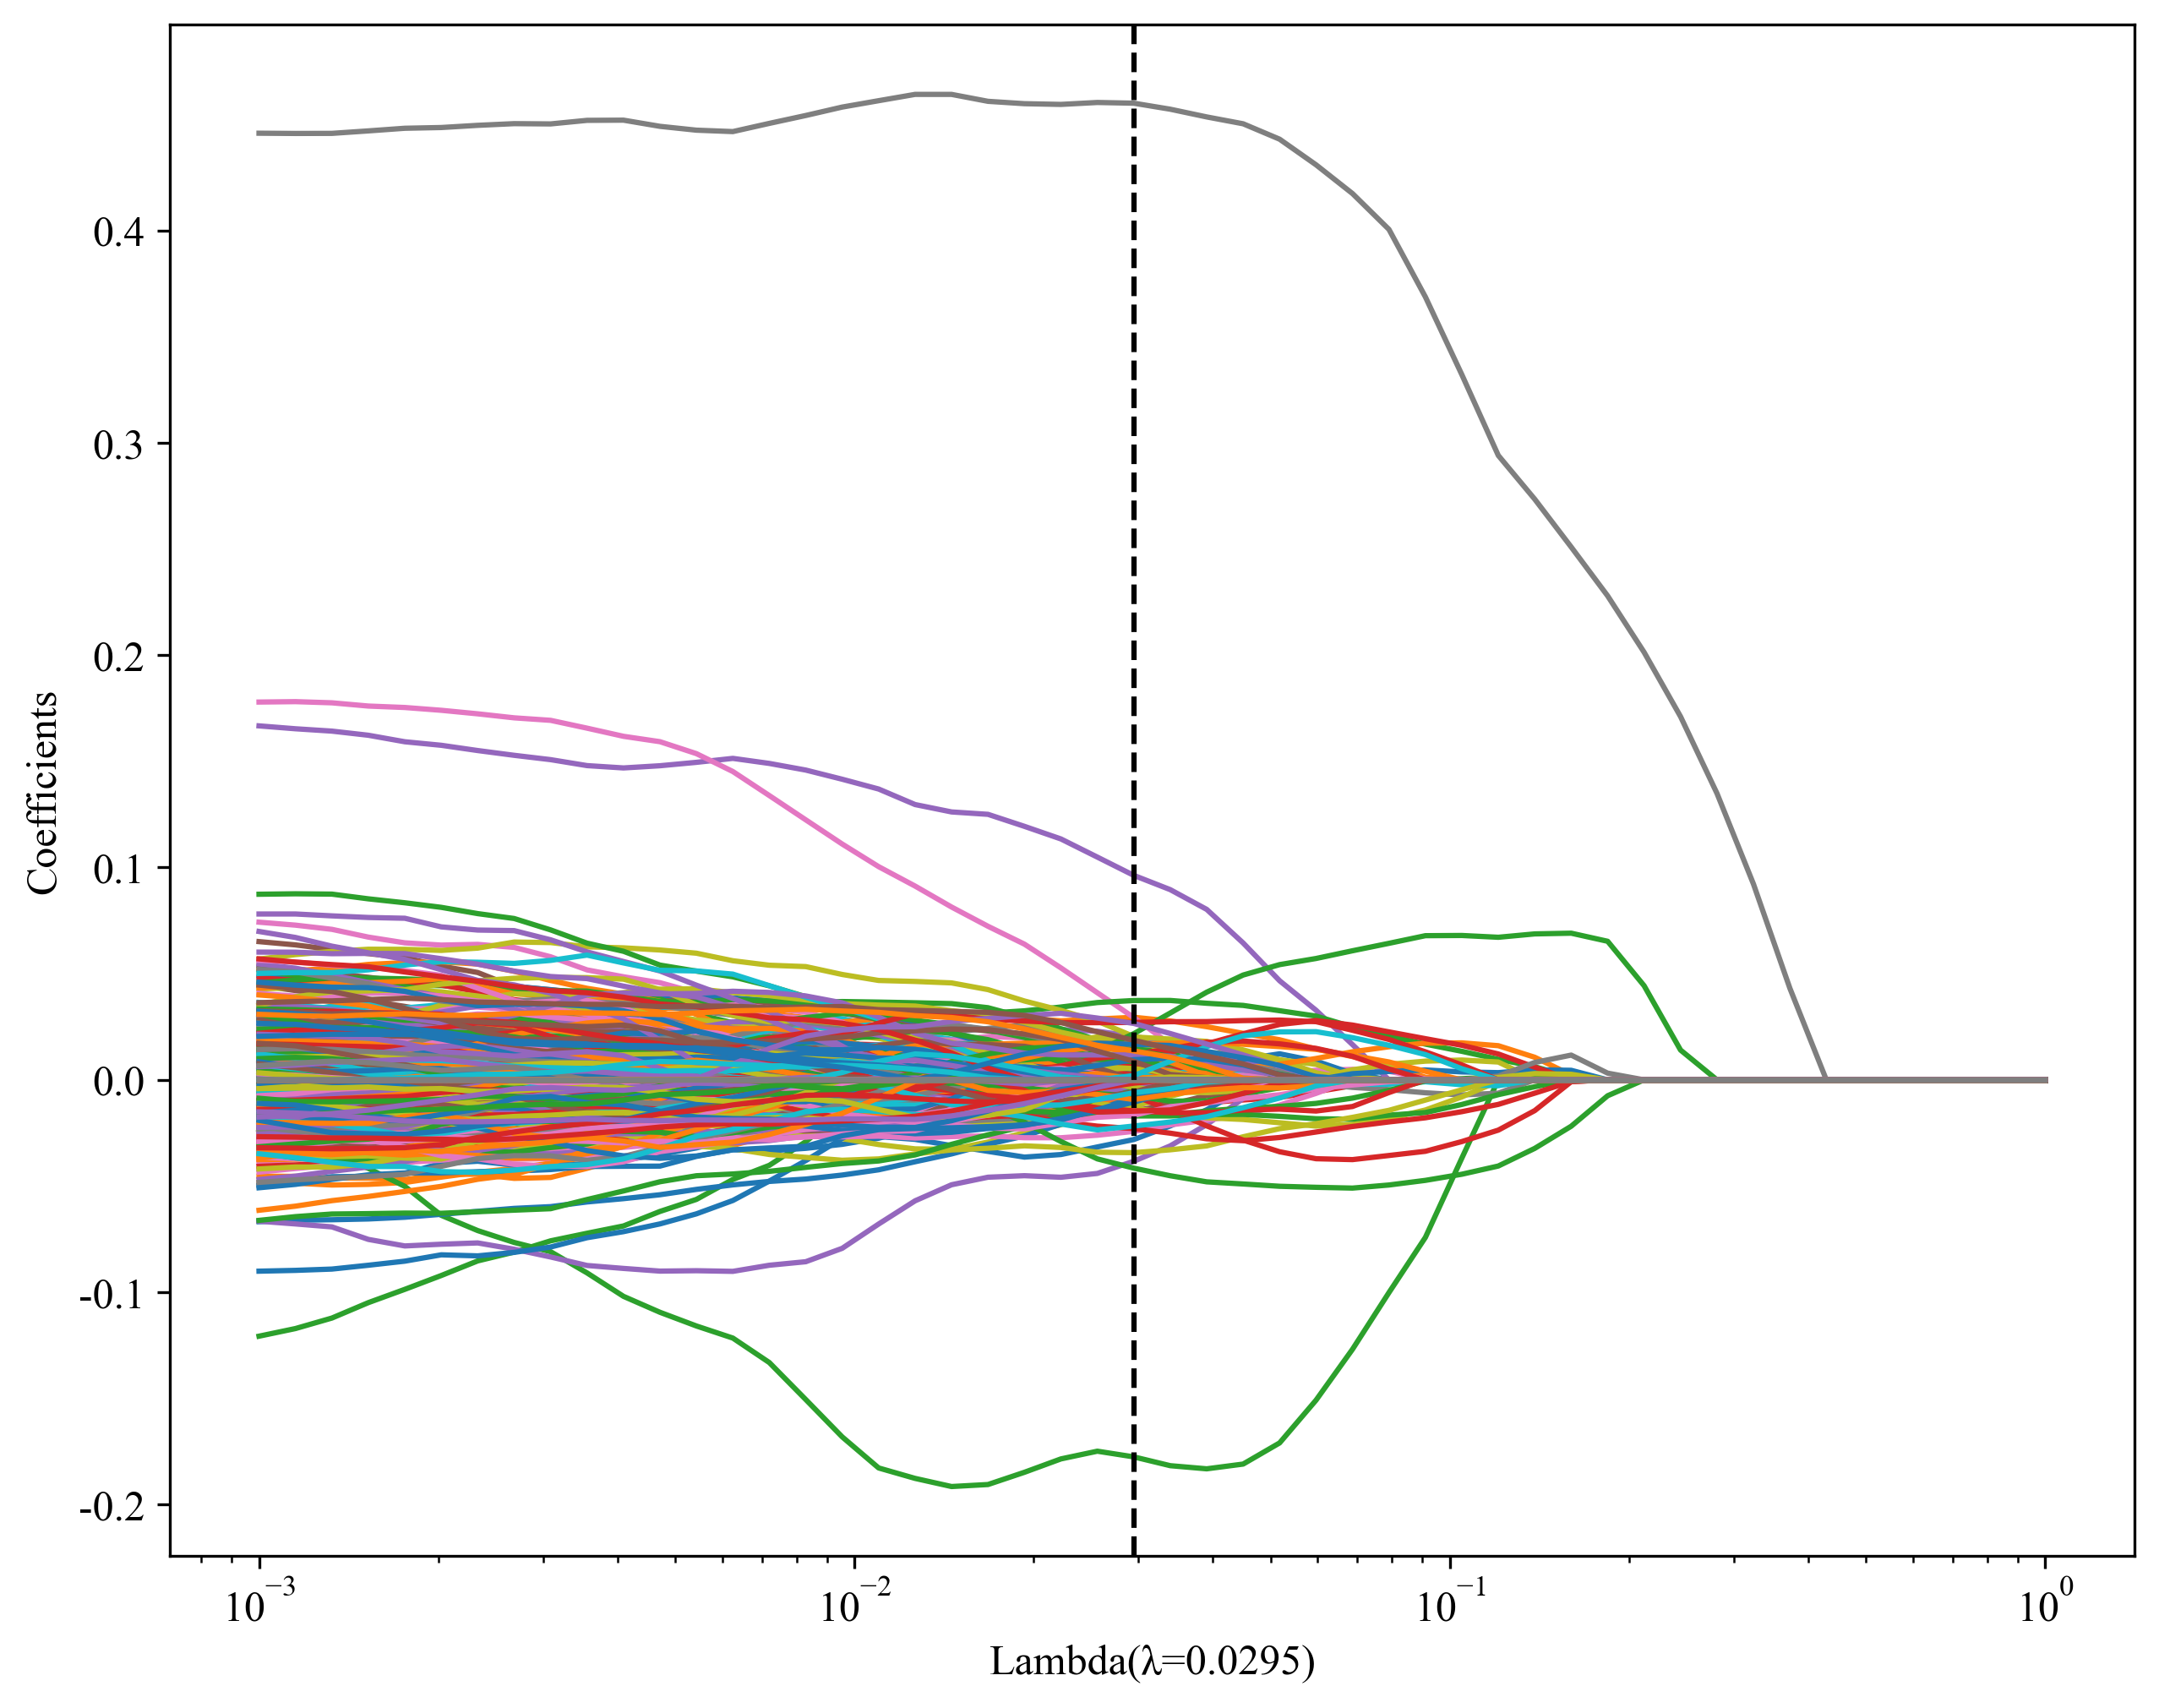

In [12]:
alpha = okcomp.comp1.lasso_cv_coefs(X_data, y_data, column_names=None, alpha_logmin=-3)
plt.savefig(f'img/{task_type}_feature_lasso.svg', bbox_inches = 'tight')

### 模型效能

```python
def lasso_cv_efficiency(X_data, y_data, points=50, **kwargs):
    """

    Args:
        Xdata: 训练数据
        ydata: 测试数据
        points: 打印的数据密度
        **kwargs: 其他的图像样式
            # 数据点标记, fmt="o"
            # 数据点大小, ms=3
            # 数据点颜色, mfc="r"
            # 数据点边缘颜色, mec="r"
            # 误差棒颜色, ecolor="b"
            # 误差棒线宽, elinewidth=2
            # 误差棒边界线长度, capsize=2
            # 误差棒边界厚度, capthick=1
    Returns:
    """
 ```

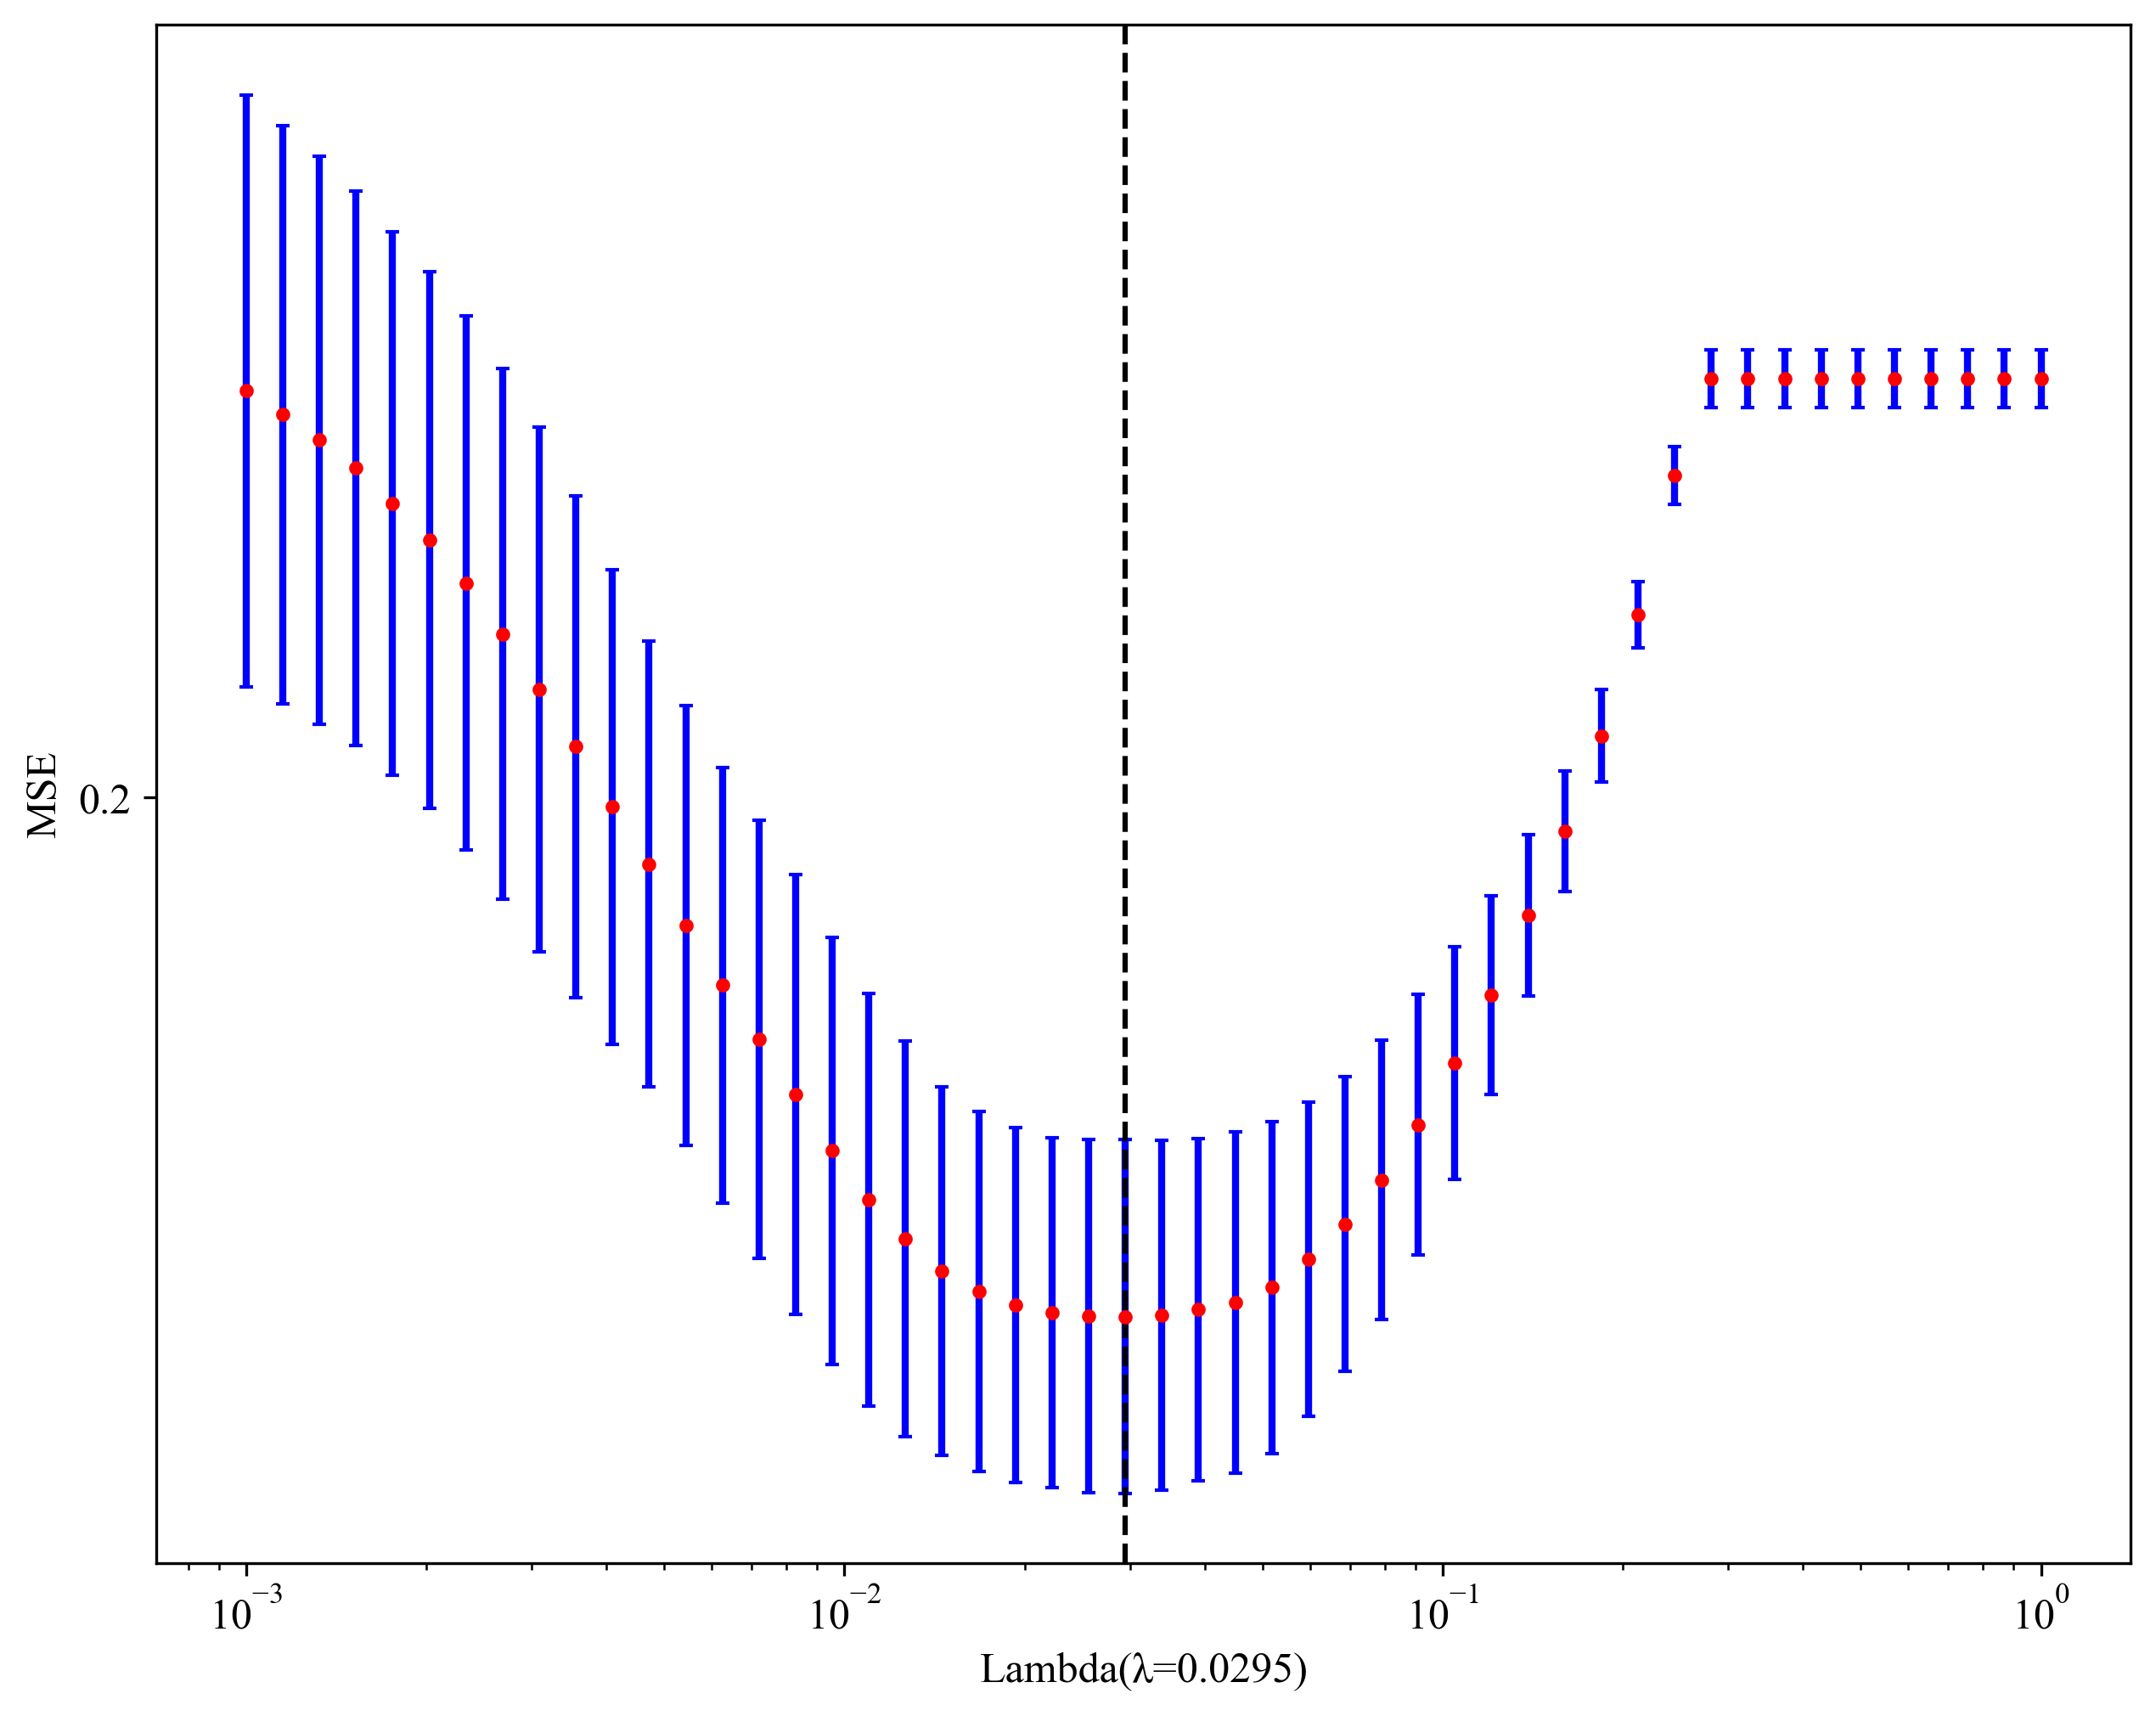

In [13]:
okcomp.comp1.lasso_cv_efficiency(X_data, y_data, points=50, alpha_logmin=-3)
plt.savefig(f'img/{task_type}_feature_mse_label.svg', bbox_inches = 'tight')

### 惩罚系数

使用交叉验证的惩罚系数作为模型训练的基础。

In [14]:
from sklearn import linear_model

models = []
for label in labels:
    clf = linear_model.Lasso(alpha=alpha)
    clf.fit(X_data, y_data[label])
    models.append(clf)

### 特征筛选

筛选出其中coef > 0的特征。并且打印出相应的公式。

In [15]:
COEF_THRESHOLD = 1e-8 # 筛选的特征阈值
scores = []
selected_features = []
for label, model in zip(labels, models):
    feat_coef = [(feat_name, coef) for feat_name, coef in zip(column_names, model.coef_) 
                 if COEF_THRESHOLD is None or abs(coef) > COEF_THRESHOLD]
    selected_features.append([feat for feat, _ in feat_coef])
    formula = ' '.join([f"{coef:+.6f} * {feat_name}" for feat_name, coef in feat_coef])
    score = f"{label} = {model.intercept_} {'+' if formula[0] != '-' else ''} {formula}"
    scores.append(score)
    
print(scores[0])

label = 0.5  -0.000002 * wavelet_HHH_firstorder_Minimum_h1 -0.004791 * wavelet_HHL_firstorder_10Percentile_h1 +0.004651 * wavelet_HHL_glszm_GrayLevelVariance_h1 -0.011140 * wavelet_LHL_glcm_InverseVariance_h1 -0.003938 * wavelet_LLH_firstorder_Kurtosis_h1 -0.005630 * wavelet_LLH_firstorder_Skewness_h1 +0.003452 * lbp_3D_m2_glszm_SmallAreaEmphasis_h2 +0.013608 * wavelet_LHH_firstorder_90Percentile_h2 +0.000226 * wavelet_LHH_firstorder_Mean_h2 -0.010307 * lbp_3D_k_firstorder_10Percentile_h3 -0.013532 * lbp_3D_k_gldm_SmallDependenceLowGrayLevelEmphasis_h3 +0.002050 * wavelet_HHH_firstorder_Mean_h3 +0.013480 * wavelet_HHH_firstorder_Range_h3 +0.005971 * wavelet_HHL_glszm_SmallAreaHighGrayLevelEmphasis_h3 +0.003820 * wavelet_LHH_gldm_DependenceEntropy_h3 +0.009040 * wavelet_LLH_glszm_SizeZoneNonUniformityNormalized_h3 +0.000318 * gradient_firstorder_Range_h4 +0.007153 * wavelet_HHH_firstorder_Maximum_h4 +0.006214 * wavelet_LHL_glcm_DifferenceVariance_h4 +0.011166 * wavelet_LHL_glcm_Idm_h4 -

### 特征权重

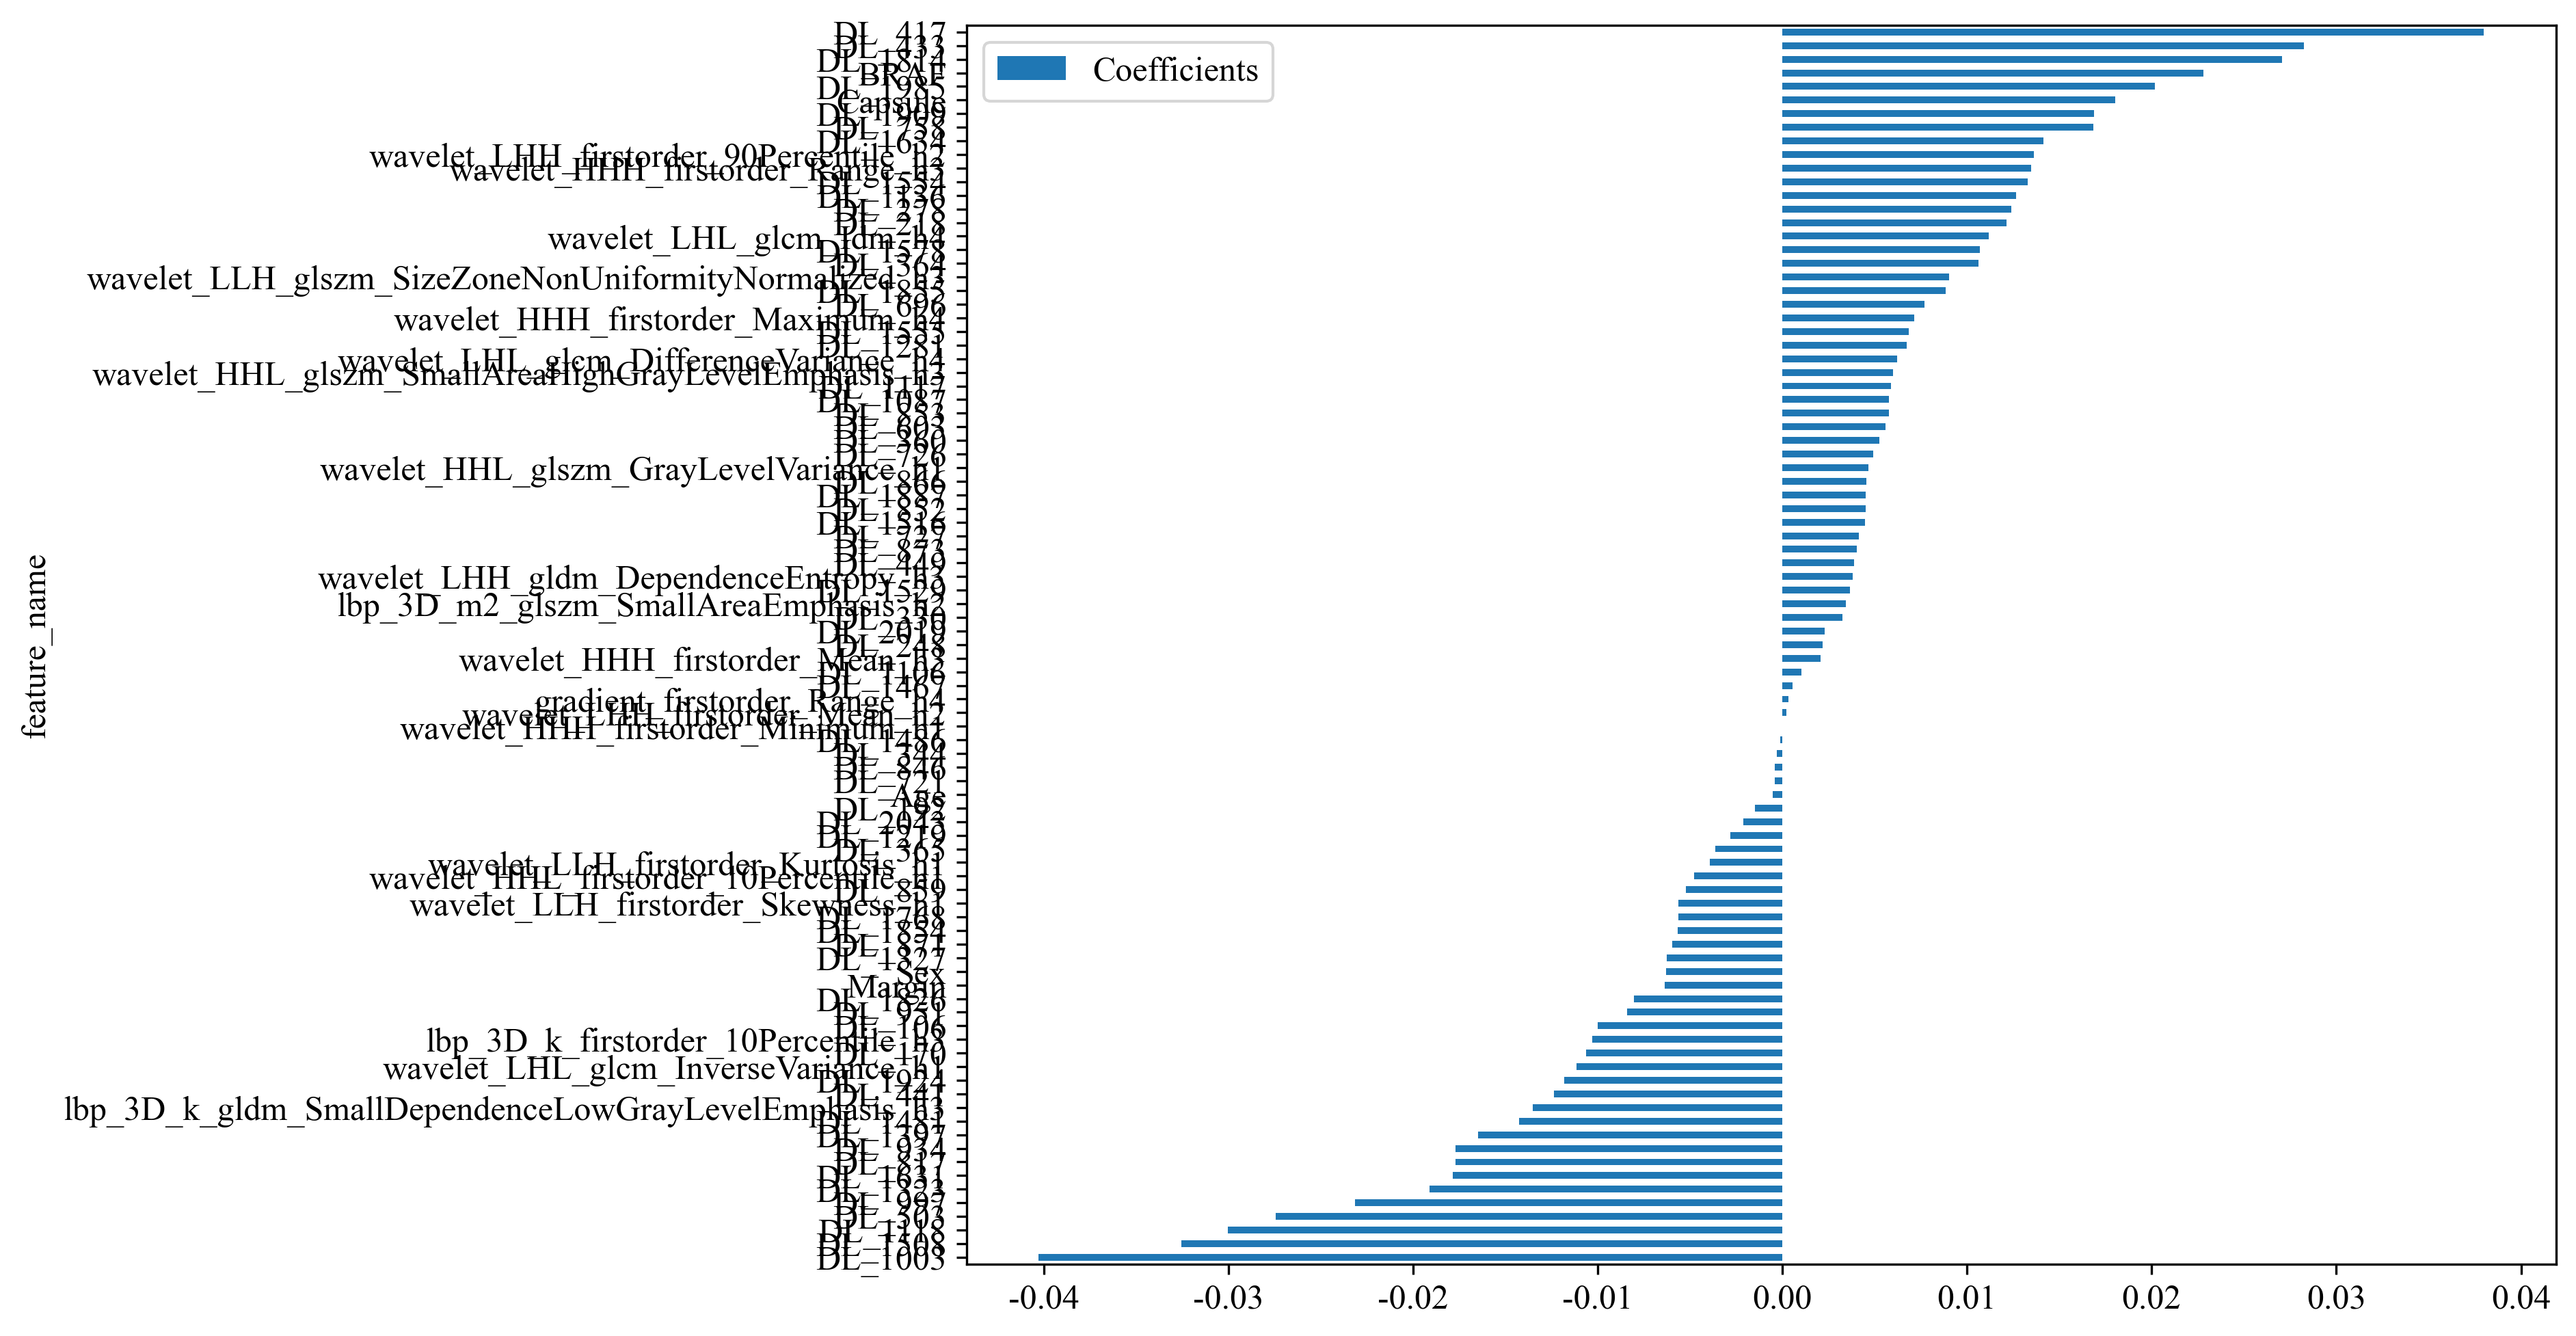

In [16]:
feat_coef = sorted(feat_coef, key=lambda x: x[1])
feat_coef_df = pd.DataFrame(feat_coef, columns=['feature_name', 'Coefficients'])
feat_coef_df.plot(x='feature_name', y='Coefficients', kind='barh')

plt.savefig(f'img/{task_type}_feature_weights.svg', bbox_inches = 'tight')

### 进一步筛选特征

使用Lasso筛选出来的Coefficients比较高的特征作为训练数据。

In [17]:
X_data = X_data[selected_features[0]]
X_test_data = X_test_data[selected_features[0]]
X_data.columns

Index(['wavelet_HHH_firstorder_Minimum_h1',
       'wavelet_HHL_firstorder_10Percentile_h1',
       'wavelet_HHL_glszm_GrayLevelVariance_h1',
       'wavelet_LHL_glcm_InverseVariance_h1',
       'wavelet_LLH_firstorder_Kurtosis_h1',
       'wavelet_LLH_firstorder_Skewness_h1',
       'lbp_3D_m2_glszm_SmallAreaEmphasis_h2',
       'wavelet_LHH_firstorder_90Percentile_h2',
       'wavelet_LHH_firstorder_Mean_h2', 'lbp_3D_k_firstorder_10Percentile_h3',
       'lbp_3D_k_gldm_SmallDependenceLowGrayLevelEmphasis_h3',
       'wavelet_HHH_firstorder_Mean_h3', 'wavelet_HHH_firstorder_Range_h3',
       'wavelet_HHL_glszm_SmallAreaHighGrayLevelEmphasis_h3',
       'wavelet_LHH_gldm_DependenceEntropy_h3',
       'wavelet_LLH_glszm_SizeZoneNonUniformityNormalized_h3',
       'gradient_firstorder_Range_h4', 'wavelet_HHH_firstorder_Maximum_h4',
       'wavelet_LHL_glcm_DifferenceVariance_h4', 'wavelet_LHL_glcm_Idm_h4',
       'DL_106', 'DL_170', 'DL_192', 'DL_218', 'DL_248', 'DL_278', 'DL_330',
     

## 模型筛选

根据筛选出来的数据，做模型的初步选择。当前主要使用到的是Onekey中的

1. SVM，支持向量机，引用参考。
2. KNN，K紧邻，引用参考。
3. Decision Tree，决策树，引用参考。
4. Random Forests, 随机森林，引用参考。
5. XGBoost, bosting方法。引用参考。
6. LightGBM, bosting方法，引用参考。

In [18]:
model_names = get_param_in_cwd('ml_models')
models = okcomp.comp1.create_clf_model_none_overfit(model_names)
model_names = list(models.keys())

### 交叉验证

`n_trails`指定随机次数，每次采用的是80%训练，随机20%进行测试，找到最好的模型，以及对应的最好的数据划分。

```python
def get_bst_split(X_data: pd.DataFrame, y_data: pd.DataFrame,
            models: dict, test_size=0.2, metric_fn=accuracy_score, n_trails=10,
            cv: bool = False, shuffle: bool = False, metric_cut_off: float = None, random_state=None):
    """
    寻找数据集中最好的数据划分。
    Args:
        X_data: 训练数据
        y_data: 监督数据
        models: 模型名称，Dict类型、
        test_size: 测试集比例
        metric_fn: 评价模型好坏的函数，默认准确率，可选roc_auc_score。
        n_trails: 尝试多少次寻找最佳数据集划分。
        cv: 是否是交叉验证，默认是False，当为True时，n_trails为交叉验证的n_fold
        shuffle: 是否进行随机打乱
        metric_cut_off: 当metric_fn的值达到多少时进行截断。
        random_state: 随机种子

    Returns: {'max_idx': max_idx, "max_model": max_model, "max_metric": max_metric, "results": results}

    """
```

**注意：这里采用了【挑数据】，如果想要严谨，请修改`n_trails=1`。**

[2026-01-21 16:53:38 - <frozen onekey_algo.custom.components.comp1>: 662]	WARNING	当cv=True的时候，采用的是交叉验证的模式，此时test_size的参数是不生效的，我们将忽略这个test_size设置。如果需要手动指定测试集比例，请修改cv=False。


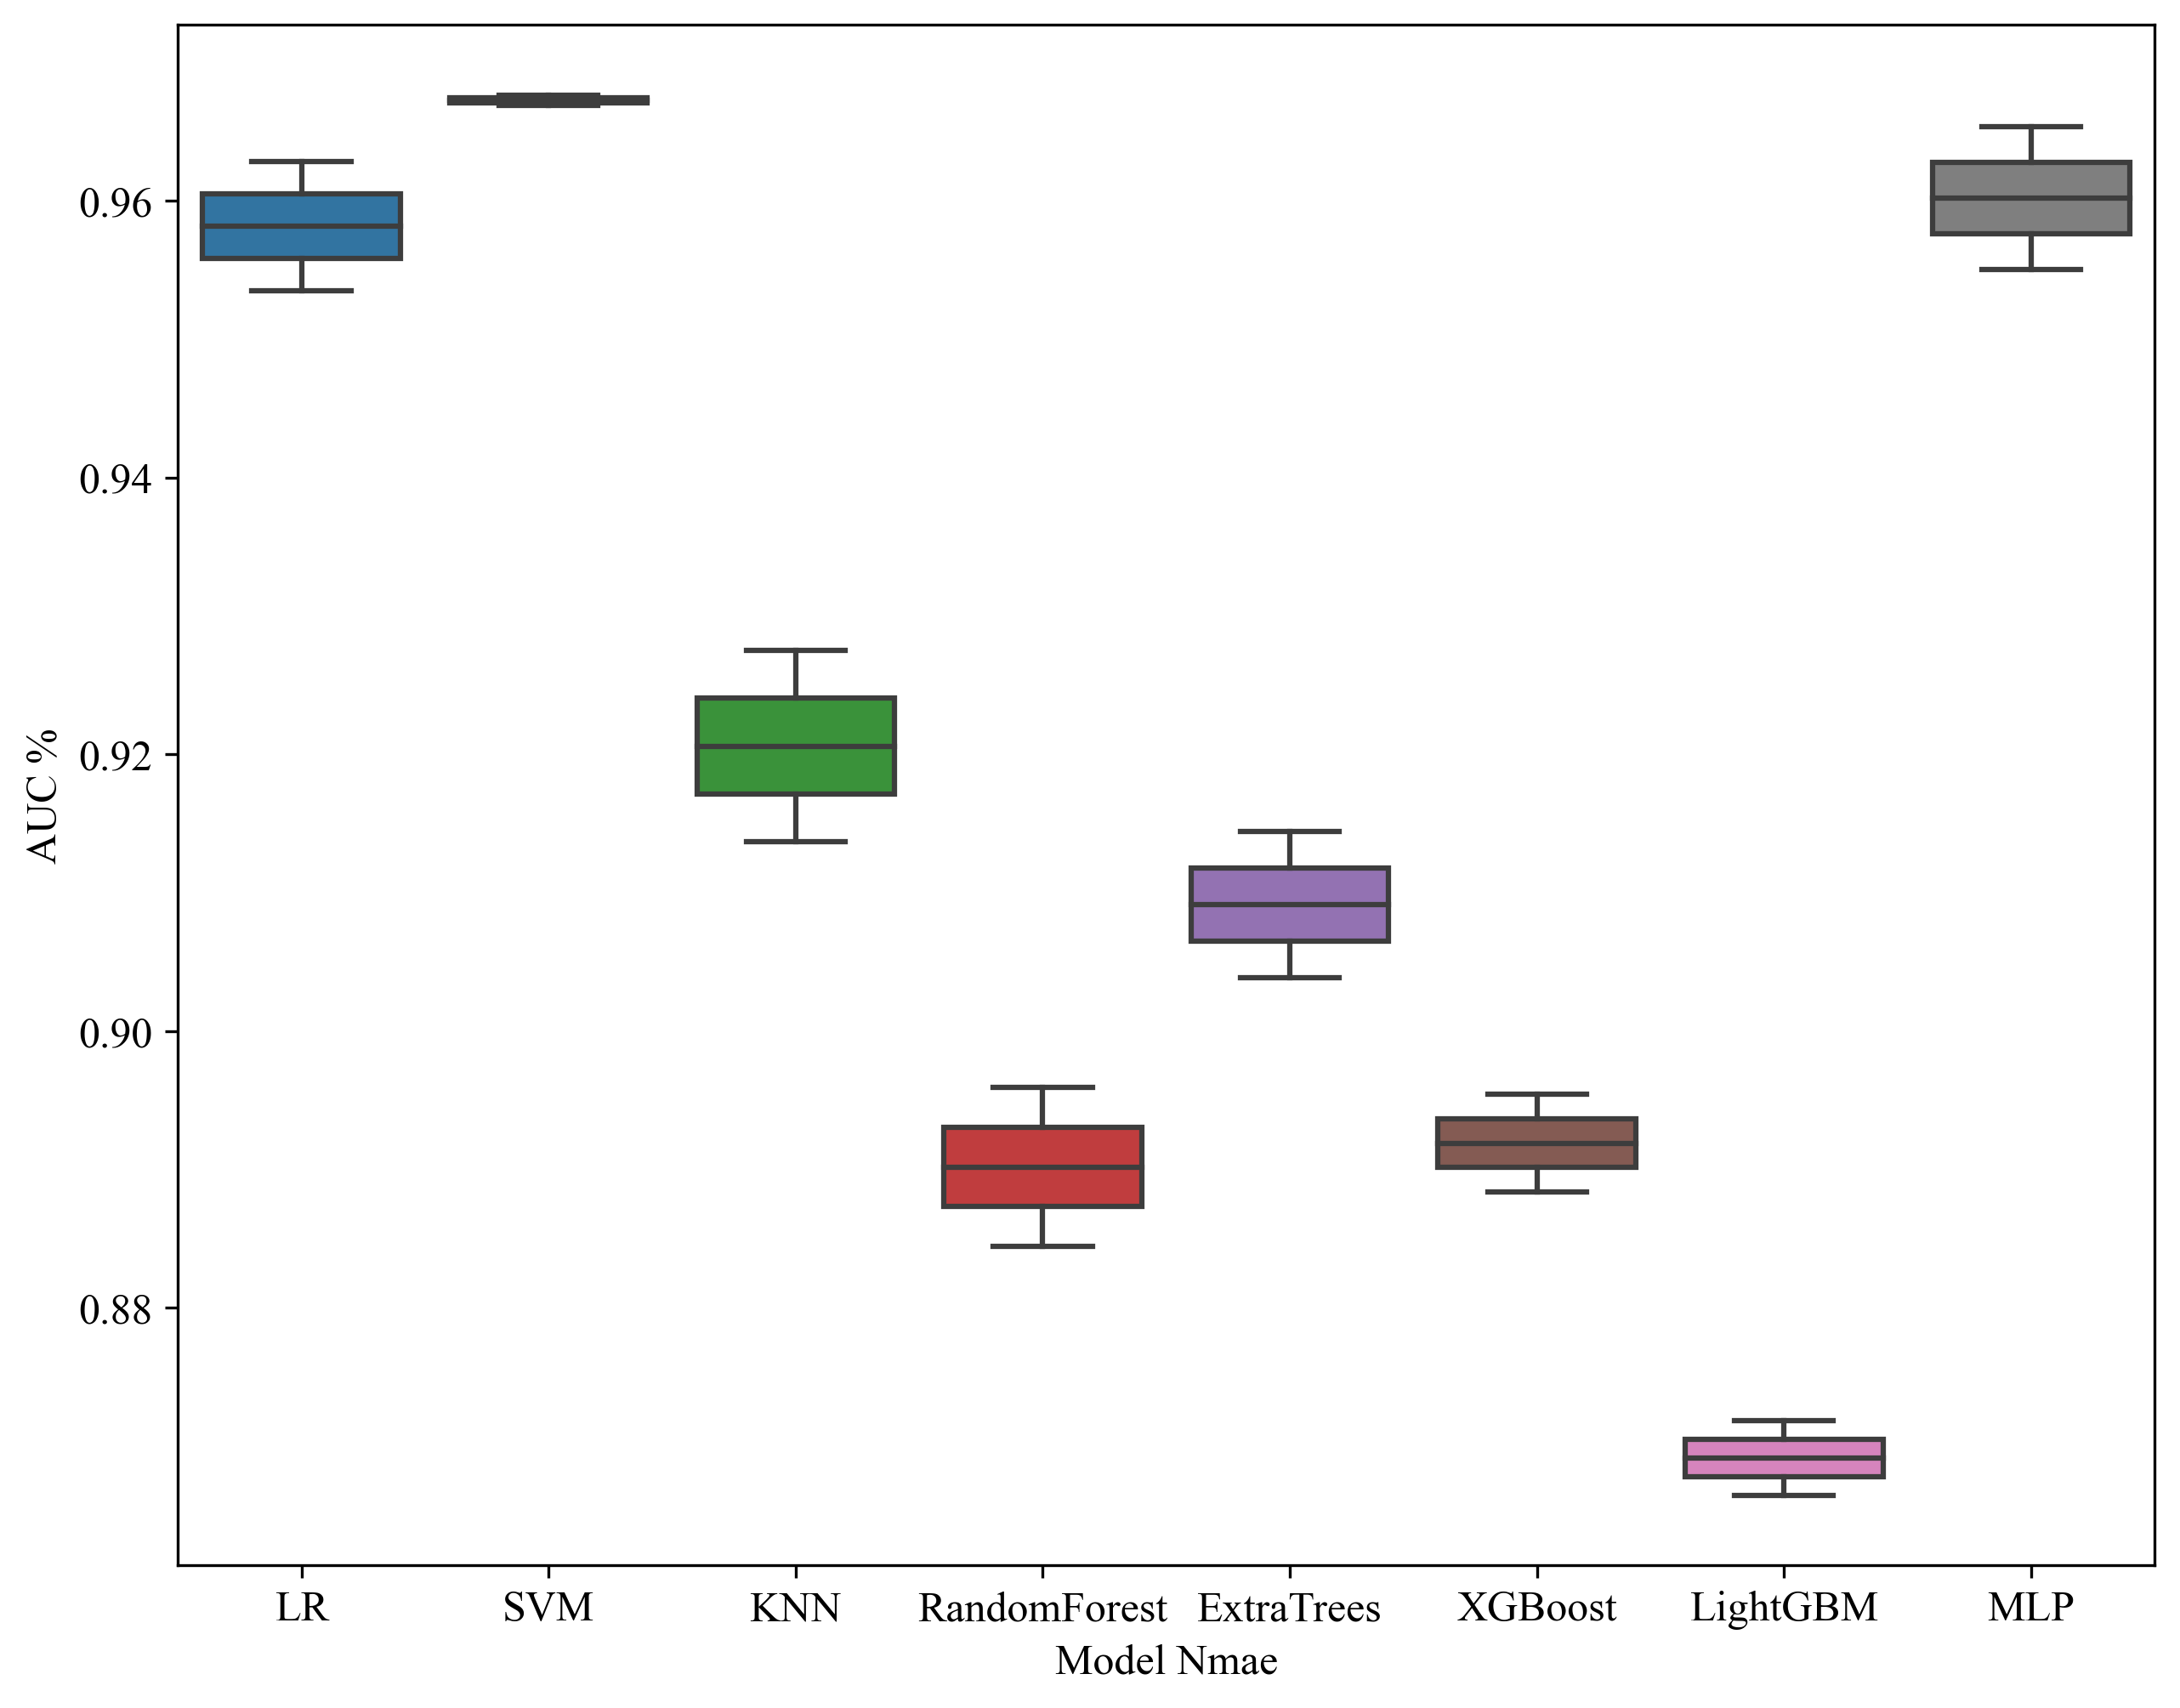

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, roc_auc_score

# 随机使用n_trails次数据划分，找到最好的一次划分方法，并且保存在results中。
results = okcomp.comp1.get_bst_split(X_data, y_data, models, test_size=0.5, metric_fn=roc_auc_score, n_trails=2, cv=True, random_state=0)
_, (X_train_sel, X_test_sel, y_train_sel, y_test_sel) = results['results'][results['max_idx']]
X_train_sel, X_test_sel, y_train_sel, y_test_sel = X_data, X_test_data, y_data, y_test_data
trails, _ = zip(*results['results'])
cv_results = pd.DataFrame(trails, columns=model_names)
# 可视化每个模型在不同的数据划分中的效果。
sns.boxplot(data=cv_results)
plt.ylabel('AUC %')
plt.xlabel('Model Nmae')
plt.savefig(f'img/{task_type}_model_cv.svg', bbox_inches = 'tight')

## 模型筛选

使用最好的数据划分，进行后续的模型研究。

**注意**: 一般情况下论文使用的是随机划分的数据，但也有些论文使用【刻意】筛选的数据划分。

In [20]:
import joblib
import json
from onekey_algo.custom.components.comp1 import plot_feature_importance, plot_learning_curve, smote_resample

from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from onekey_algo.custom.encrypt.security import dump_onekey, load_onekey

targets = []
os.makedirs('models', exist_ok=True)
for l in labels:
    new_models = okcomp.comp1.create_clf_model_none_overfit(model_names)
    new_models['LR'] = LogisticRegression(penalty='none', max_iter=1)
    new_models['SVM'] = SVC(probability=True, max_iter=10, kernel='linear')
    new_models['RandomForest'] = RandomForestClassifier(n_estimators=1, max_depth=3,
                                                        min_samples_split=4, random_state=0)
    new_models['XGBoost'] = XGBClassifier(n_estimators=5, objective='binary:logistic', max_depth=1, min_child_weight=.1,
                                              use_label_encoder=False, eval_metric='error')
    new_models['LightGBM'] = LGBMClassifier(n_estimators=3,  max_depth=1, min_child_weight=.5,)
    new_models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=10, max_depth=1, min_samples_split=2, random_state=0)
    new_models['GradientBoosting'] = GradientBoostingClassifier(n_estimators=50, random_state=0)
    new_models['AdaBoost'] = AdaBoostClassifier(n_estimators=8, random_state=0)
    new_models['MLP'] = MLPClassifier(hidden_layer_sizes=(61, 128, 64, 32), max_iter=100, solver='sgd', random_state=0)
    model_names = list(new_models.keys())
    new_models = list(new_models.values())
    
    for mn, m in zip(model_names, new_models):
        X_train_smote, y_train_smote = X_train_sel, y_train_sel
        # 取消下一行的注释可以使用Smote进行采样，解决样本不均衡的问题。
        if get_param_in_cwd('use_smote', False):
            X_train_smote, y_train_smote = smote_resample(X_train_sel, y_train_sel)
        m.fit(X_train_smote, y_train_smote[l])
        # 输出模型特征重要性，只针对高级树模型有用
#         plot_feature_importance(m, selected_features[0], save_dir='img')
#         plot_learning_curve(m, X_train_sel, y_train_sel, title=f'Learning Curve {mn}')
#         plt.savefig(f"img/Rad_{mn}_learning_curve.svg", bbox_inches='tight')
        plt.show()
    targets.append(new_models)
    encoder = json.loads(open('results/norm_info.json').read())
    dump_onekey({'TYPE':'WEBUI',
                 'data': pd.concat([ids, combined_data[selected_features[0]]], axis=1),
                 'models': {mn:nm for mn, nm in zip(model_names, new_models)},
                 'encoder': {fname: encoder[fname] for fname in selected_features[0]},
                 'feature_config': selected_features[0]},
                save_path=f'web/config')

## 预测结果

* predictions，二维数据，每个label对应的每个模型的预测结果。
* pred_scores，二维数据，每个label对应的每个模型的预测概率值。

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from onekey_algo.custom.components.delong import calc_95_CI
from onekey_algo.custom.components.metrics import analysis_pred_binary

predictions = [[(model.predict(X_train_sel), model.predict(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]
pred_scores = [[(model.predict_proba(X_train_sel), model.predict_proba(X_test_sel)) 
                for model in target] for label, target in zip(labels, targets)]

metric = []
pred_sel_idx = []
for label, prediction, scores in zip(labels, predictions, pred_scores):
    pred_sel_idx_label = []
    for mname, (train_pred, test_pred), (train_score, test_score) in zip(model_names, prediction, scores):
        # 计算训练集指数
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_train_sel[label], 
                                                                                              train_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"{label}-train"))
                 
        # 计算验证集指标
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y_test_sel[label], 
                                                                                              test_score[:, 1])
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"{label}-test"))
        # 计算thres对应的sel idx
        pred_sel_idx_label.append(np.logical_or(test_score[:, 0] >= thres, test_score[:, 1] >= thres))
    
    pred_sel_idx.append(pred_sel_idx_label)
metric = pd.DataFrame(metric, index=None, columns=['Model', 'Accuracy', 'AUC', '95% CI',
                                                   'Sensitivity', 'Specificity', 
                                                   'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                                   'Threshold', 'Cohort'])
metric[['Model', 'Accuracy', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'Cohort']].to_csv('results/DLR_metrics.csv',
                                                                                                            index=False)
metric

Model  Accuracy    AUC           95% CI  Sensitivity  \
0                 LR     0.900  0.966  0.9524 - 0.9797        0.855   
1                 LR     0.704  0.748  0.6947 - 0.8019        0.739   
2                SVM     0.787  0.866  0.8334 - 0.8989        0.692   
3                SVM     0.629  0.650  0.5895 - 0.7104        0.600   
4                KNN     0.923  0.978  0.9673 - 0.9878        0.878   
5                KNN     0.667  0.705  0.6488 - 0.7615        0.612   
6       RandomForest     0.744  0.803  0.7623 - 0.8430        0.869   
7       RandomForest     0.616  0.614  0.5532 - 0.6757        0.588   
8         ExtraTrees     0.787  0.871  0.8389 - 0.9027        0.792   
9         ExtraTrees     0.695  0.736  0.6805 - 0.7912        0.758   
10           XGBoost     0.819  0.887  0.8573 - 0.9173        0.787   
11           XGBoost     0.676  0.738  0.6841 - 0.7925        0.606   
12          LightGBM     0.760  0.793  0.7535 - 0.8326        0.792   
13          LightGBM     0.632  0.650  0.5948 - 0.7053        0.648   
14               MLP     0.925  0.976  0.9647 - 0.9868        0.937   
15               MLP     0.698  0.734  0.6785 - 0.7891        0.709   
16  GradientBoosting     1.000  1.000  1.0000 - 1.0000        1.000   
17  GradientBoosting     0.698  0.752  0.6983 - 0.8048        0.606   
18          AdaBoost     0.857  0.939  0.9194 - 0.9594        0.792   
19          AdaBoost     0.686  0.724  0.6683 - 0.7800        0.655   

    Specificity    PPV    NPV  Precision  Recall     F1  Threshold  \
0         0.946  0.940  0.867      0.940   0.855  0.896      0.556   
1         0.667  0.705  0.703      0.705   0.739  0.722      0.388   
2         0.882  0.855  0.741      0.855   0.692  0.765      0.689   
3         0.660  0.656  0.605      0.656   0.600  0.627      0.618   
4         0.968  0.965  0.888      0.965   0.878  0.919      0.600   
5         0.725  0.706  0.634      0.706   0.612  0.656      0.600   
6         0.620  0.696  0.825      0.696   0.869  0.773      0.433   
7         0.647  0.642  0.593      0.642   0.588  0.614      0.642   
8         0.783  0.785  0.790      0.785   0.792  0.788      0.494   
9         0.627  0.687  0.706      0.687   0.758  0.720      0.494   
10        0.851  0.841  0.800      0.841   0.787  0.813      0.549   
11        0.752  0.725  0.639      0.725   0.606  0.660      0.551   
12        0.729  0.745  0.778      0.745   0.792  0.768      0.526   
13        0.614  0.645  0.618      0.645   0.648  0.647      0.526   
14        0.914  0.916  0.935      0.916   0.937  0.926      0.464   
15        0.686  0.709  0.686      0.709   0.709  0.709      0.489   
16        1.000  1.000  1.000      1.000   1.000  1.000      0.654   
17        0.797  0.763  0.652      0.763   0.606  0.676      0.624   
18        0.923  0.911  0.816      0.911   0.792  0.847      0.515   
19        0.719  0.715  0.659      0.715   0.655  0.684      0.506   

         Cohort  
0   label-train  
1    label-test  
2   label-train  
3    label-test  
4   label-train  
5    label-test  
6   label-train  
7    label-test  
8   label-train  
9    label-test  
10  label-train  
11   label-test  
12  label-train  
13   label-test  
14  label-train  
15   label-test  
16  label-train  
17   label-test  
18  label-train  
19   label-test

### 绘制曲线

绘制的不同模型的准确率柱状图和折线图曲线。

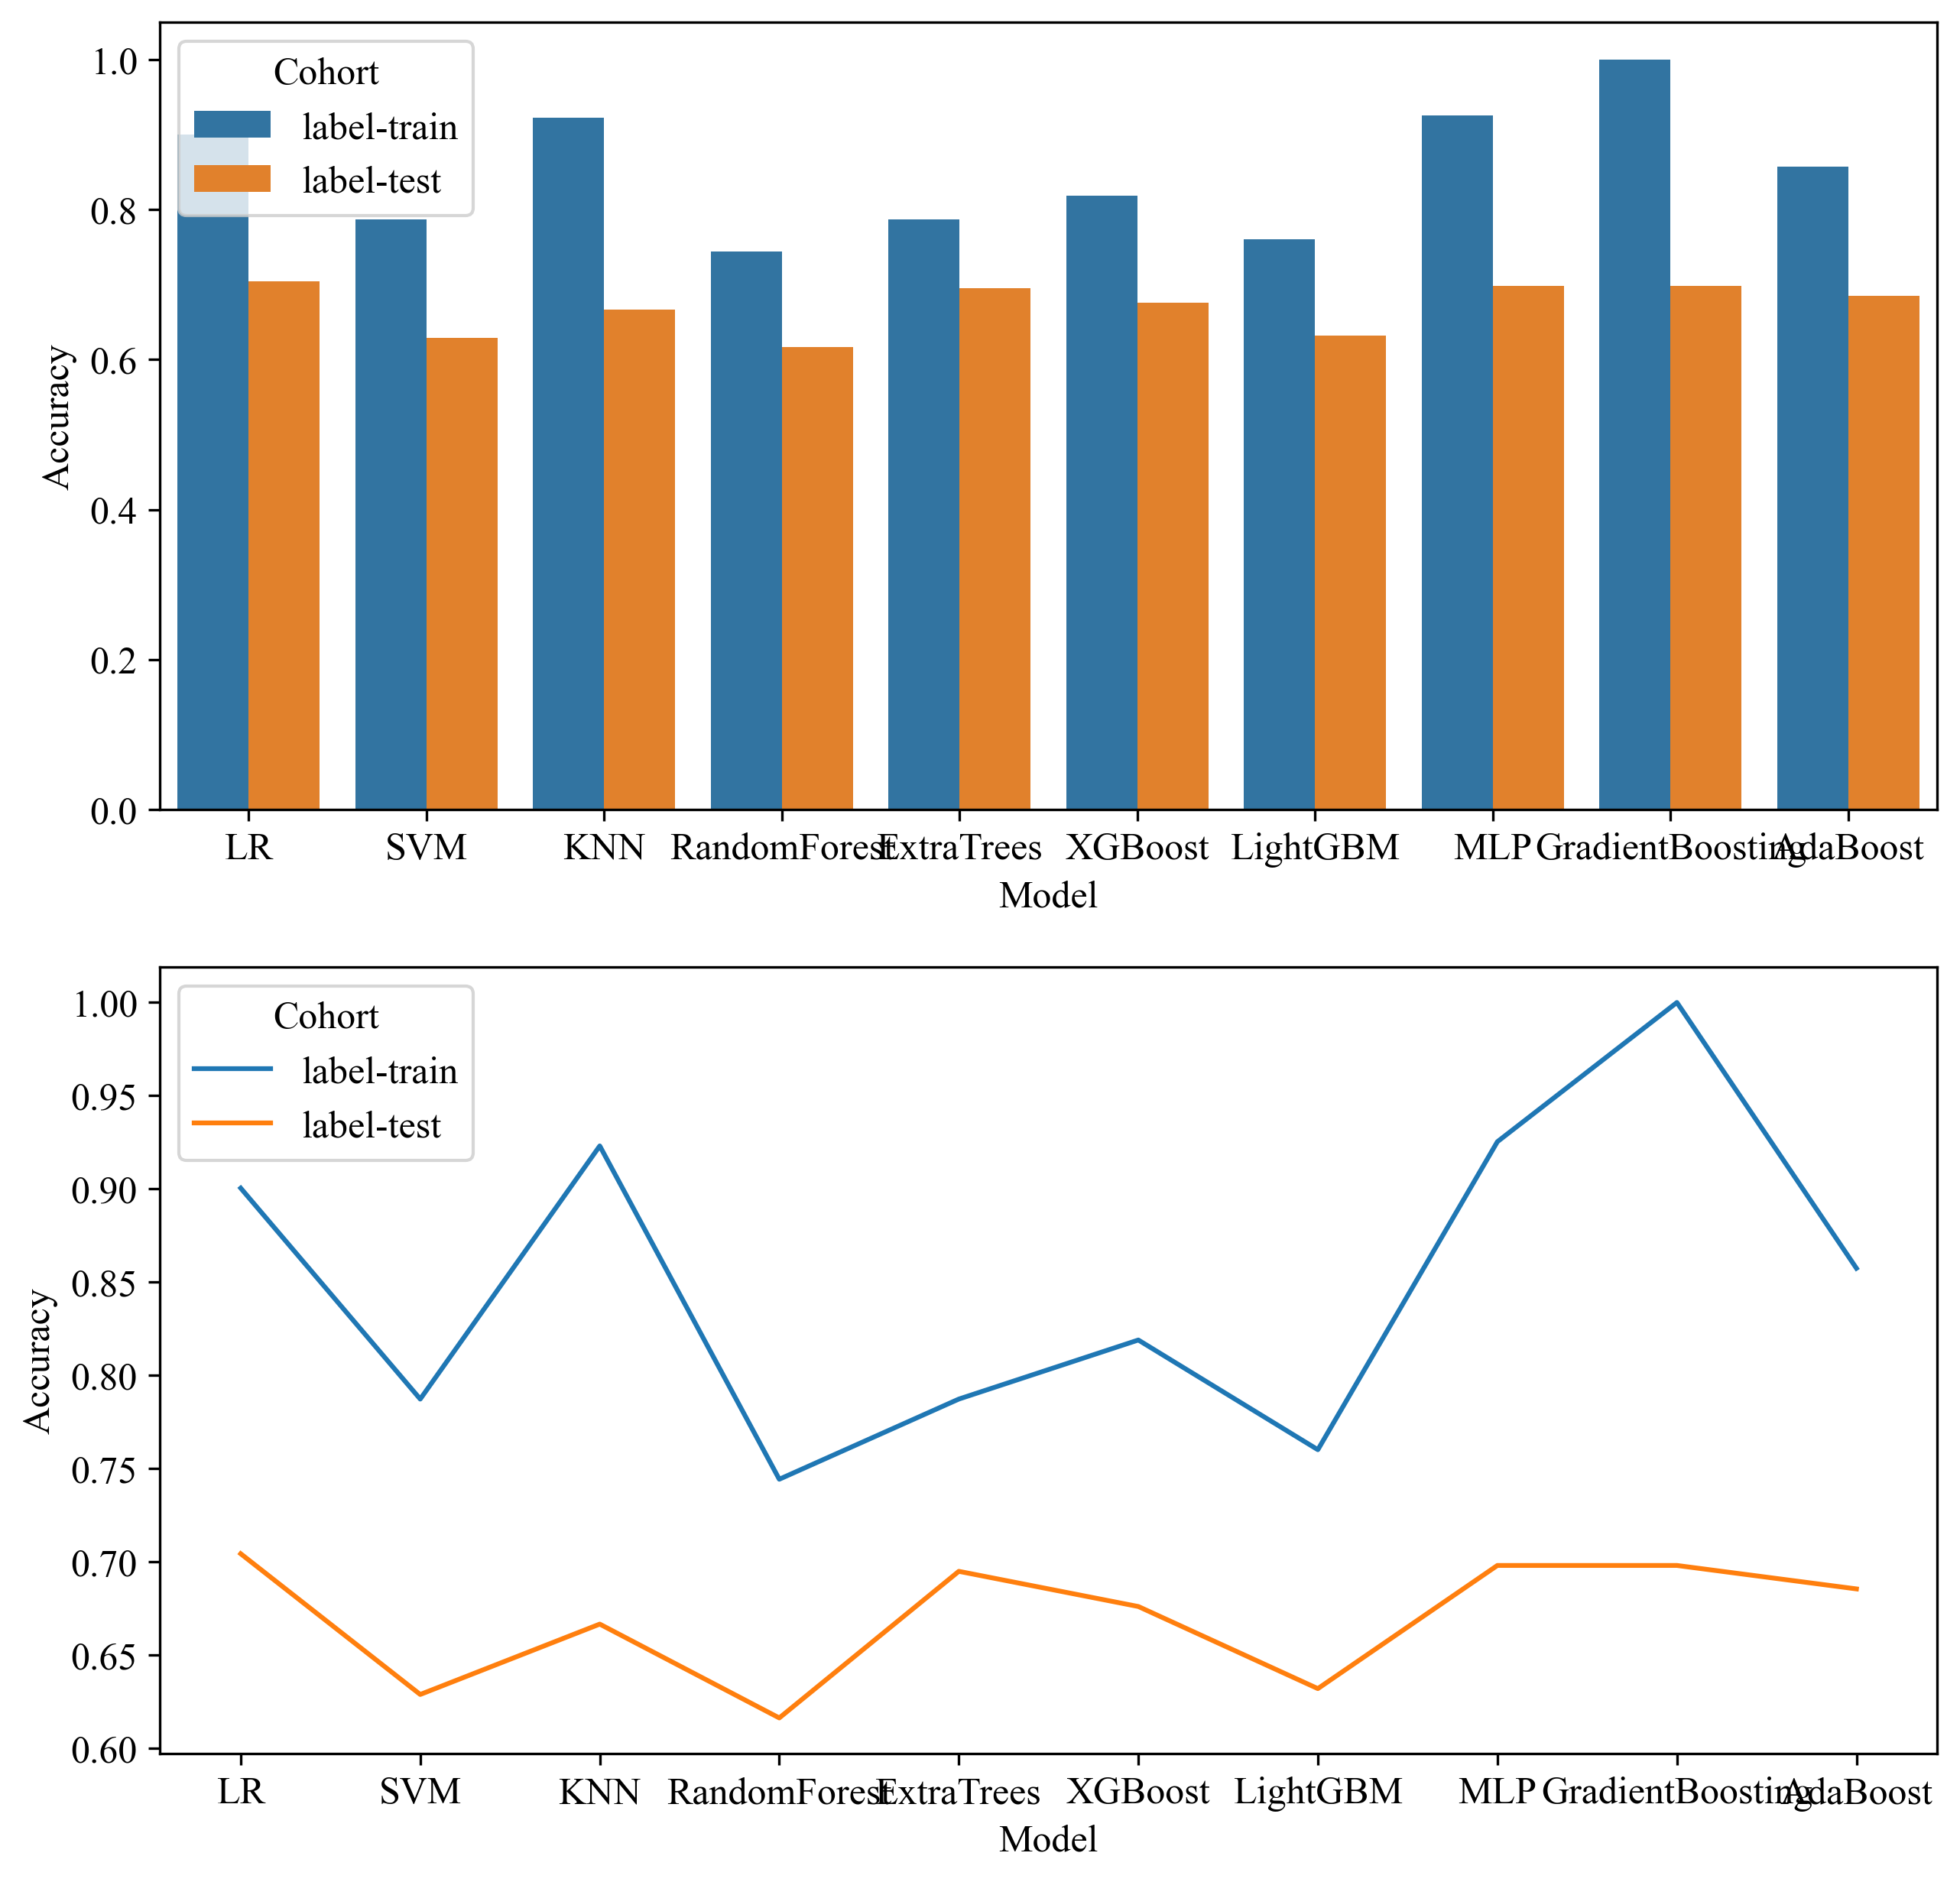

In [22]:
import seaborn as sns

plt.figure(figsize=(10, 10))
plt.subplot(211)
sns.barplot(x='Model', y='Accuracy', data=metric, hue='Cohort')
plt.subplot(212)
sns.lineplot(x='Model', y='Accuracy', data=metric, hue='Cohort')
plt.savefig(f'img/{task_type}_model_acc.svg', bbox_inches = 'tight')

### 绘制ROC曲线
确定最好的模型，并且绘制曲线。

```python
def draw_roc(y_test, y_score, title='ROC', labels=None):
```

`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

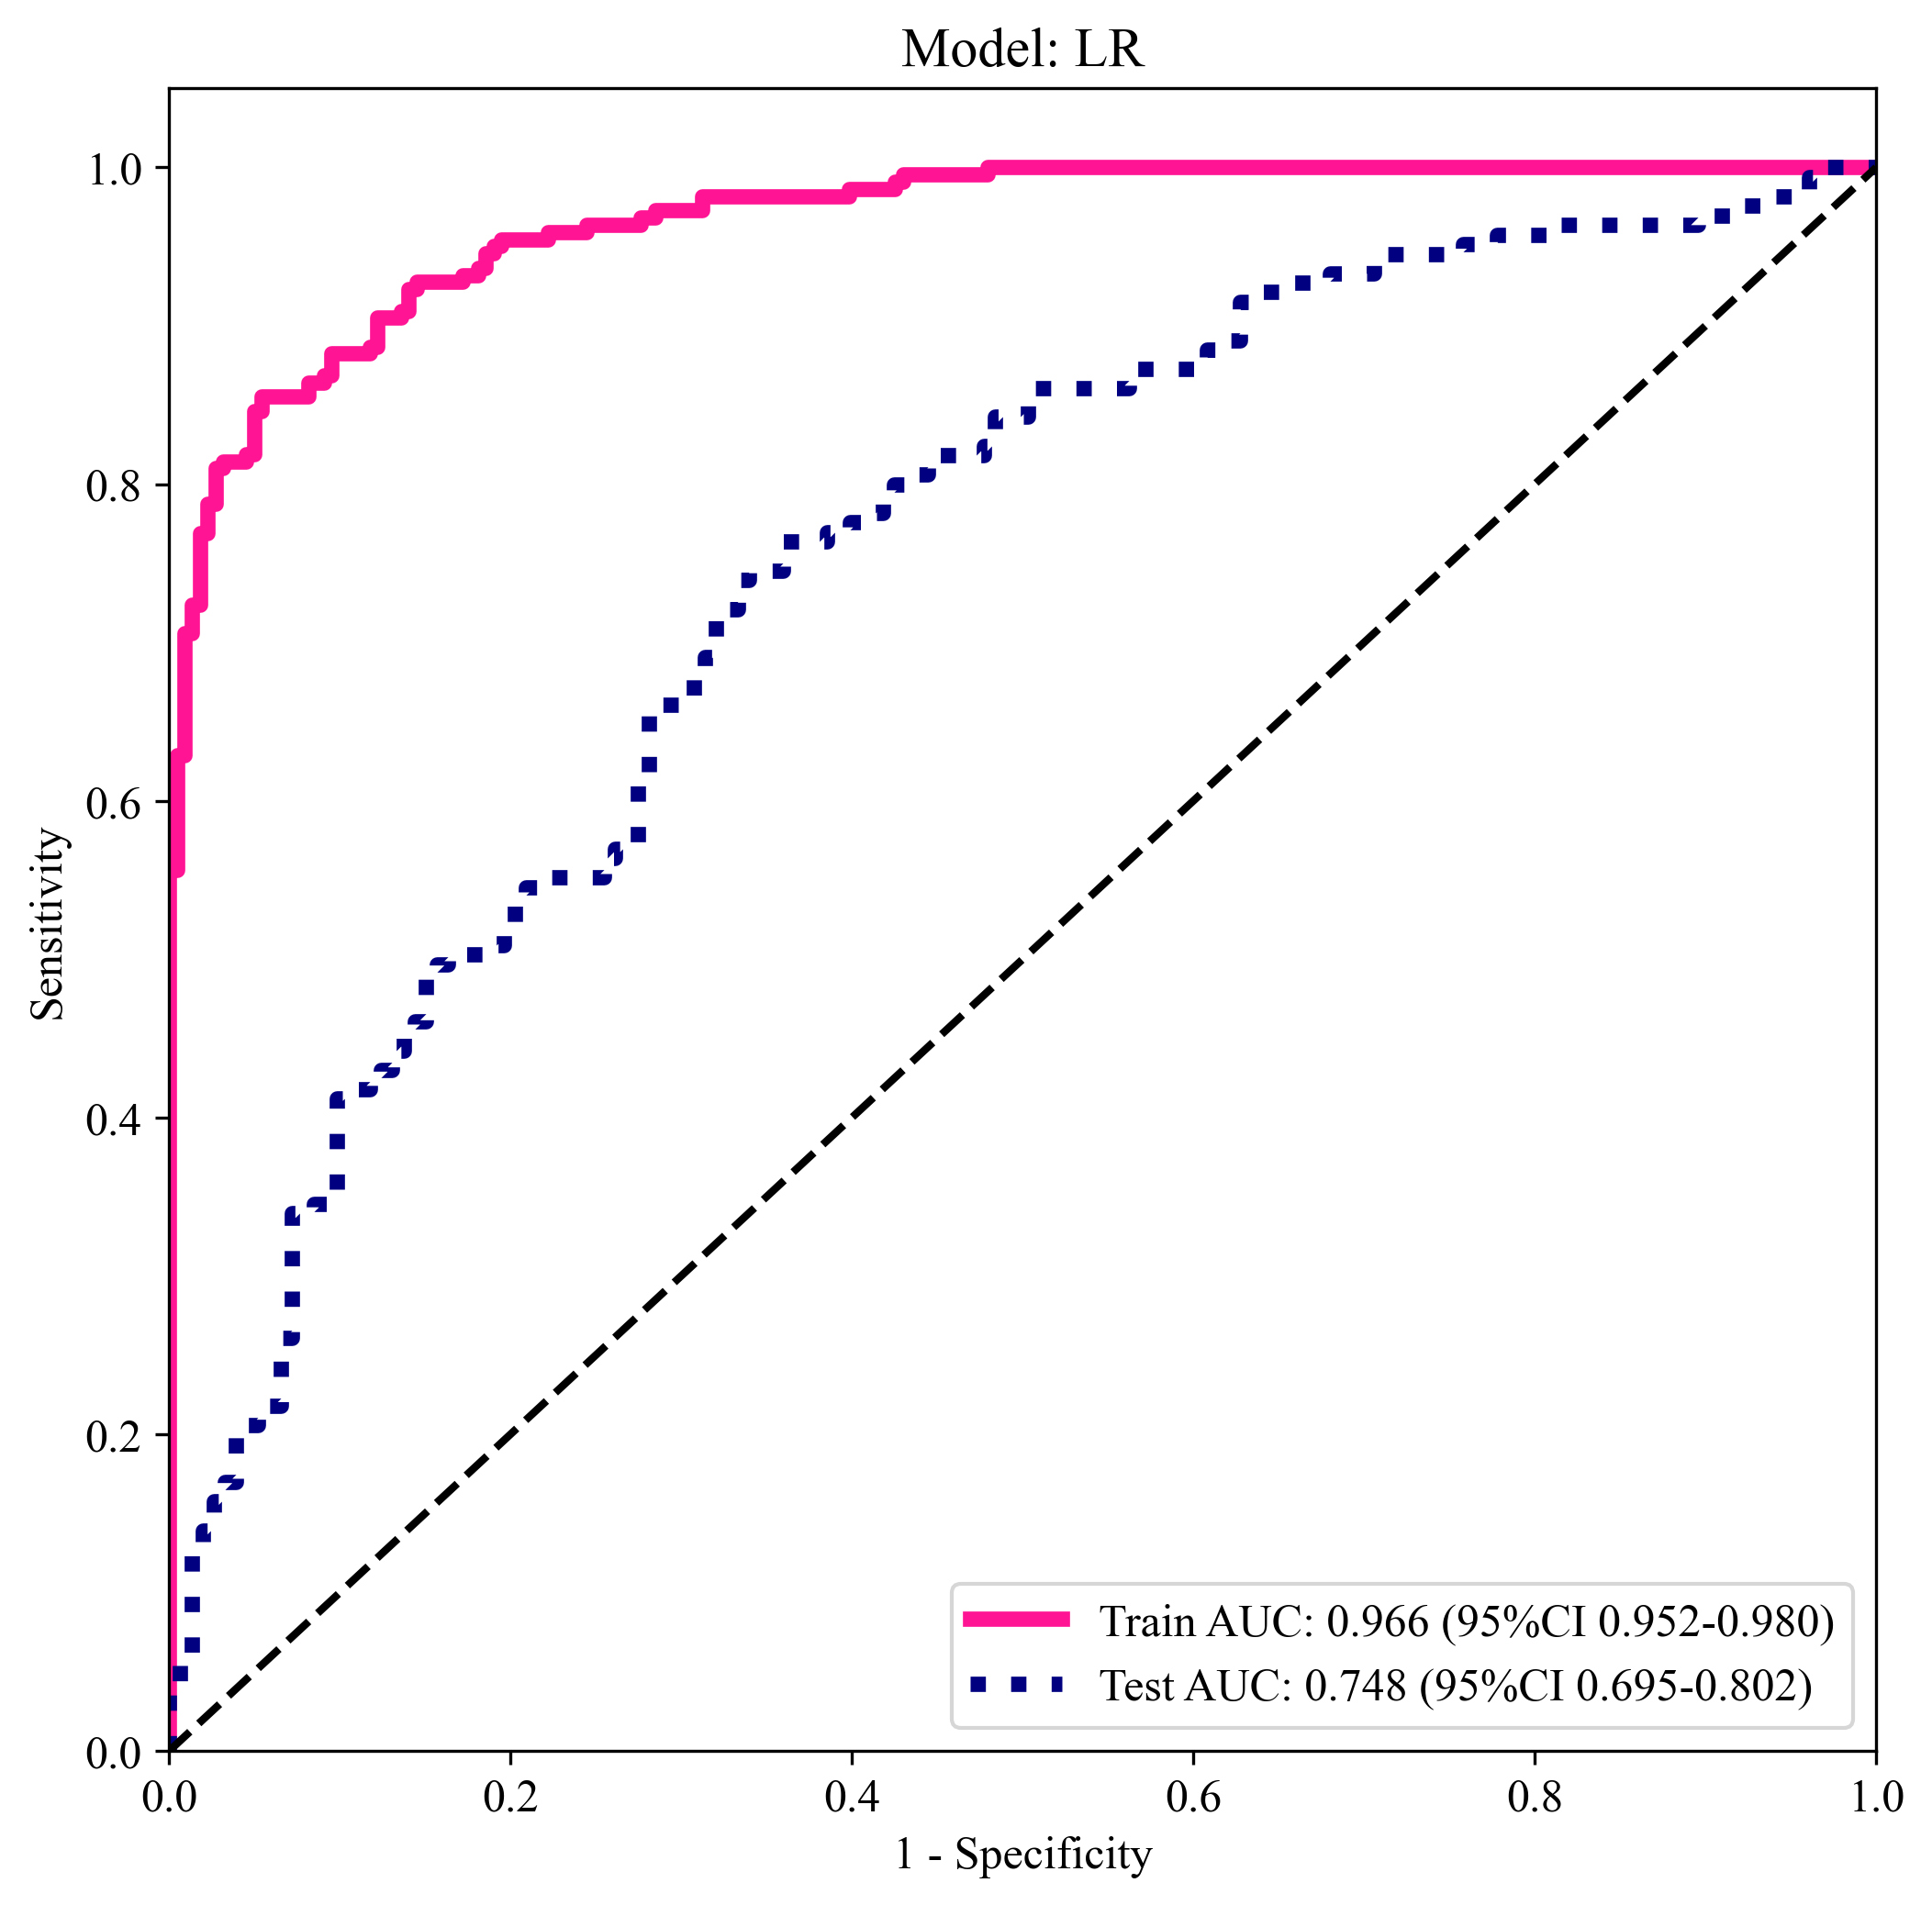

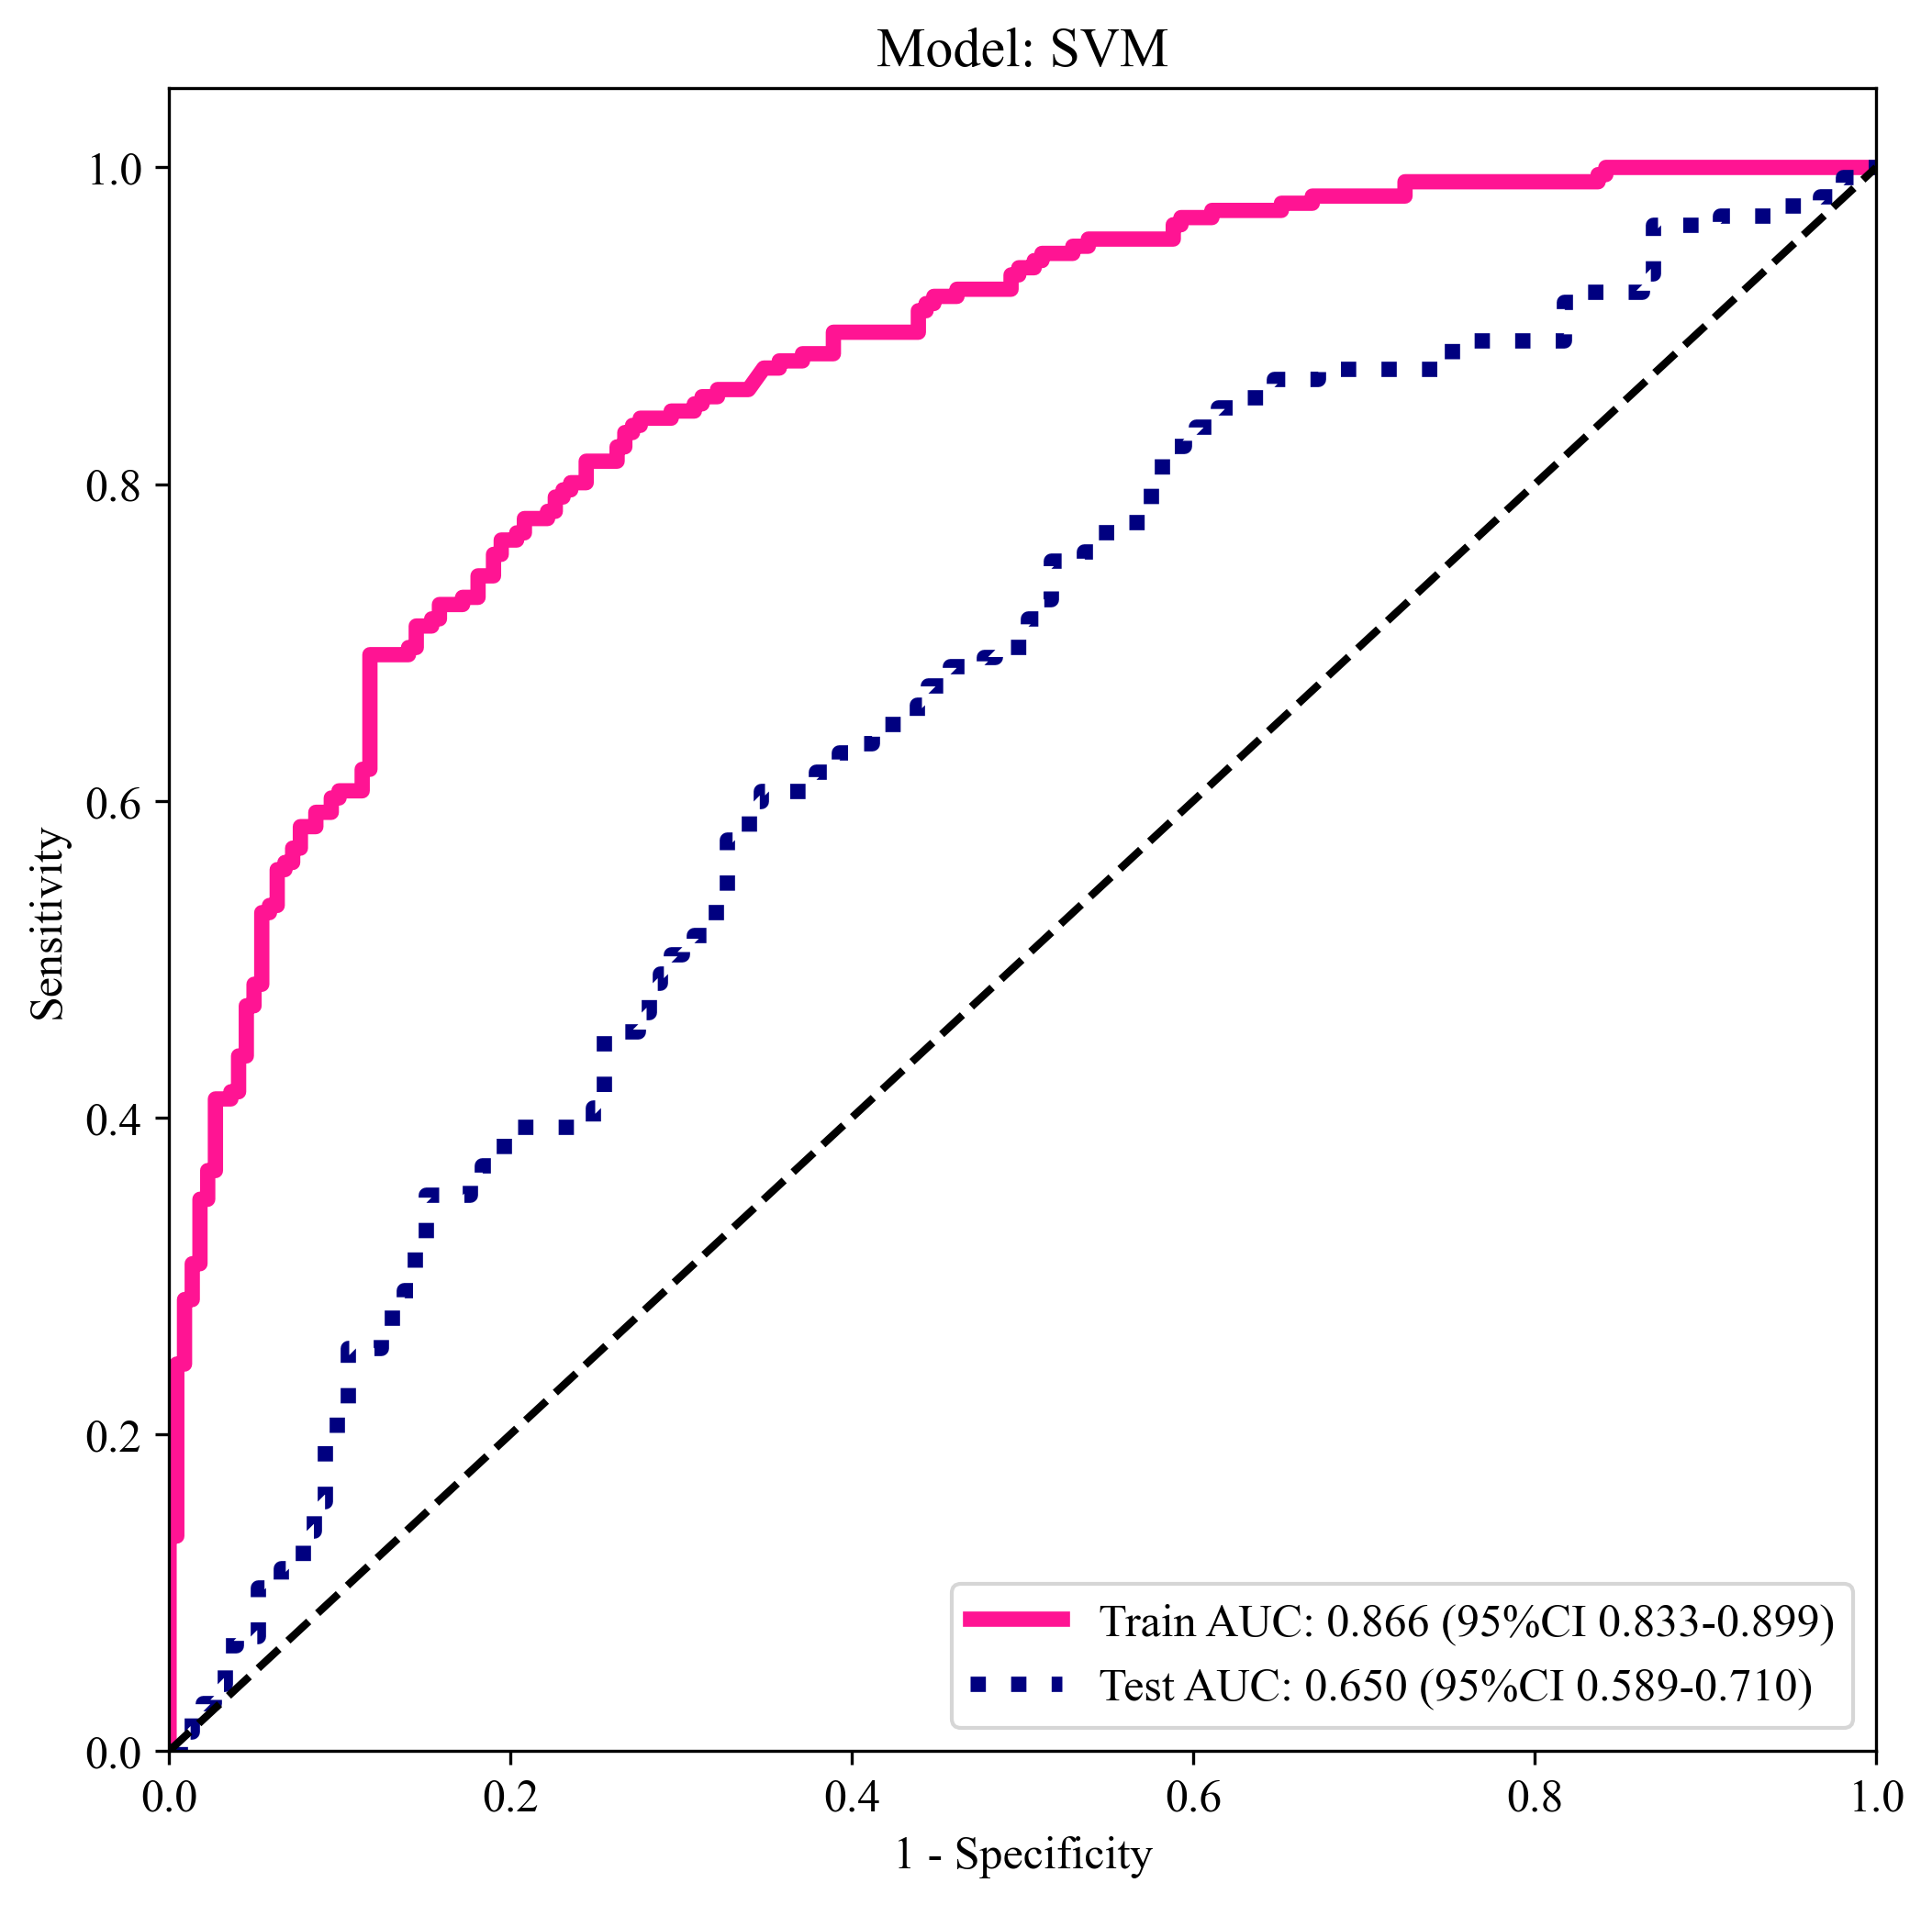

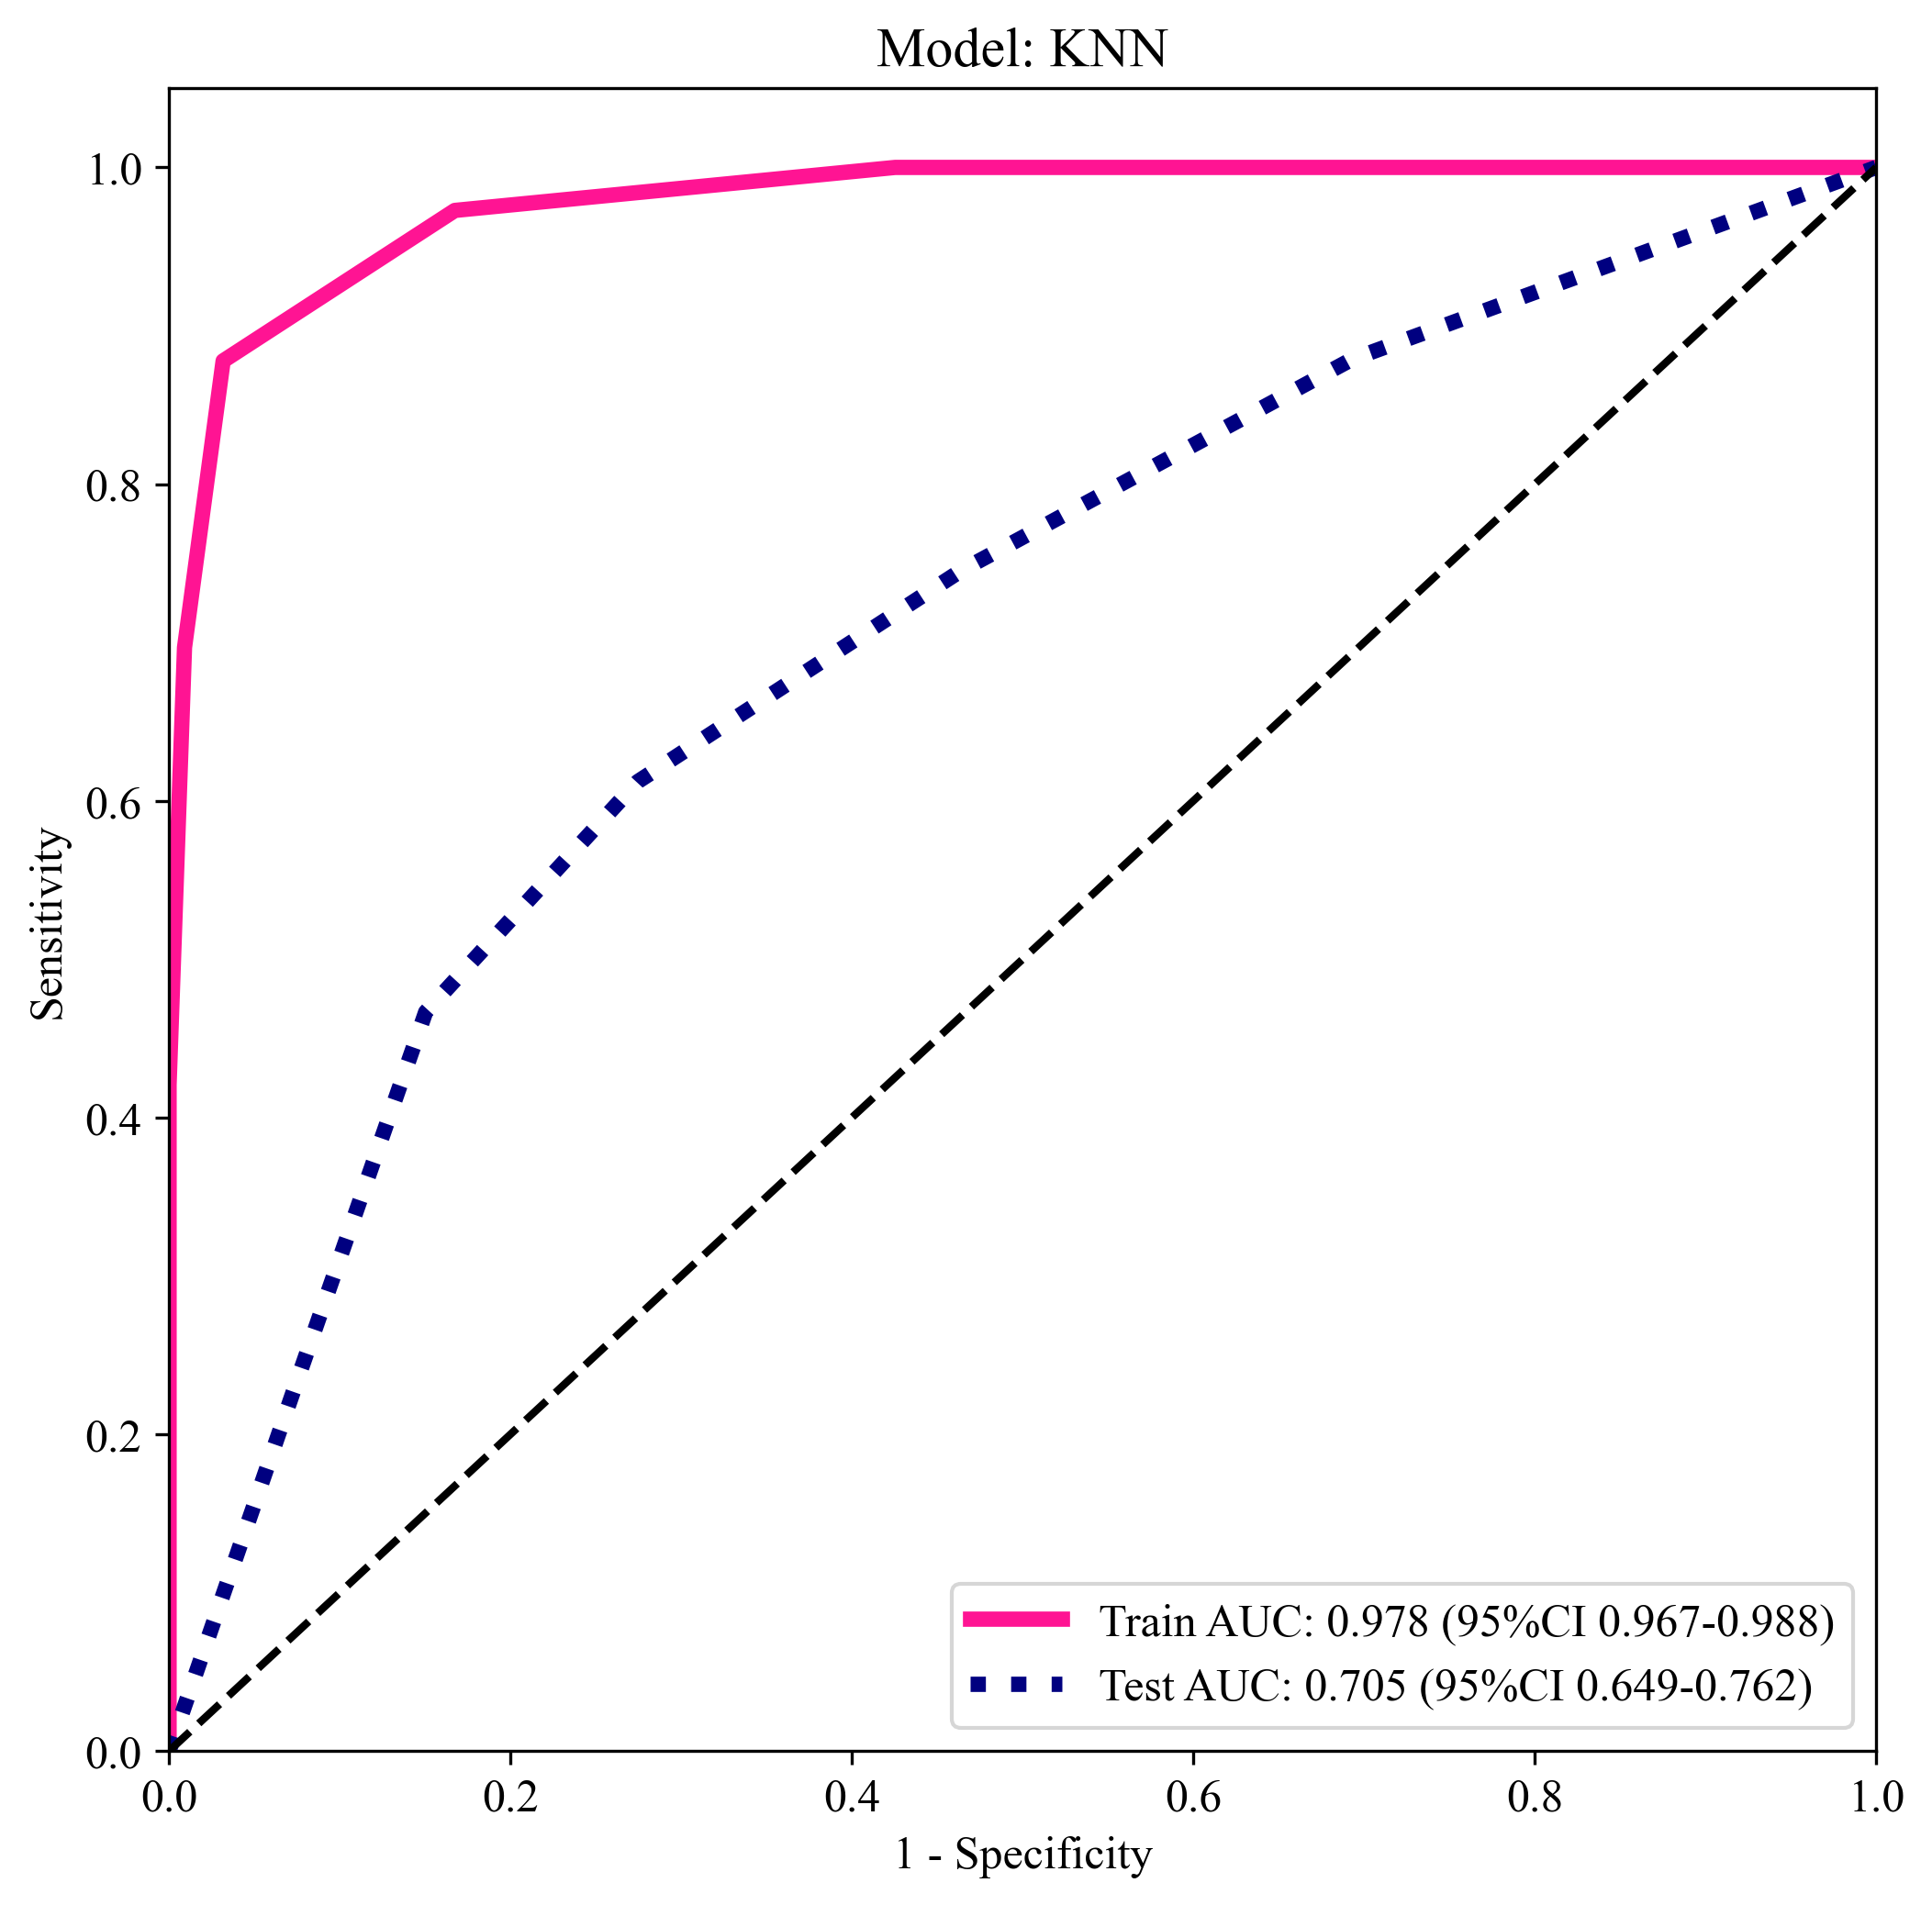

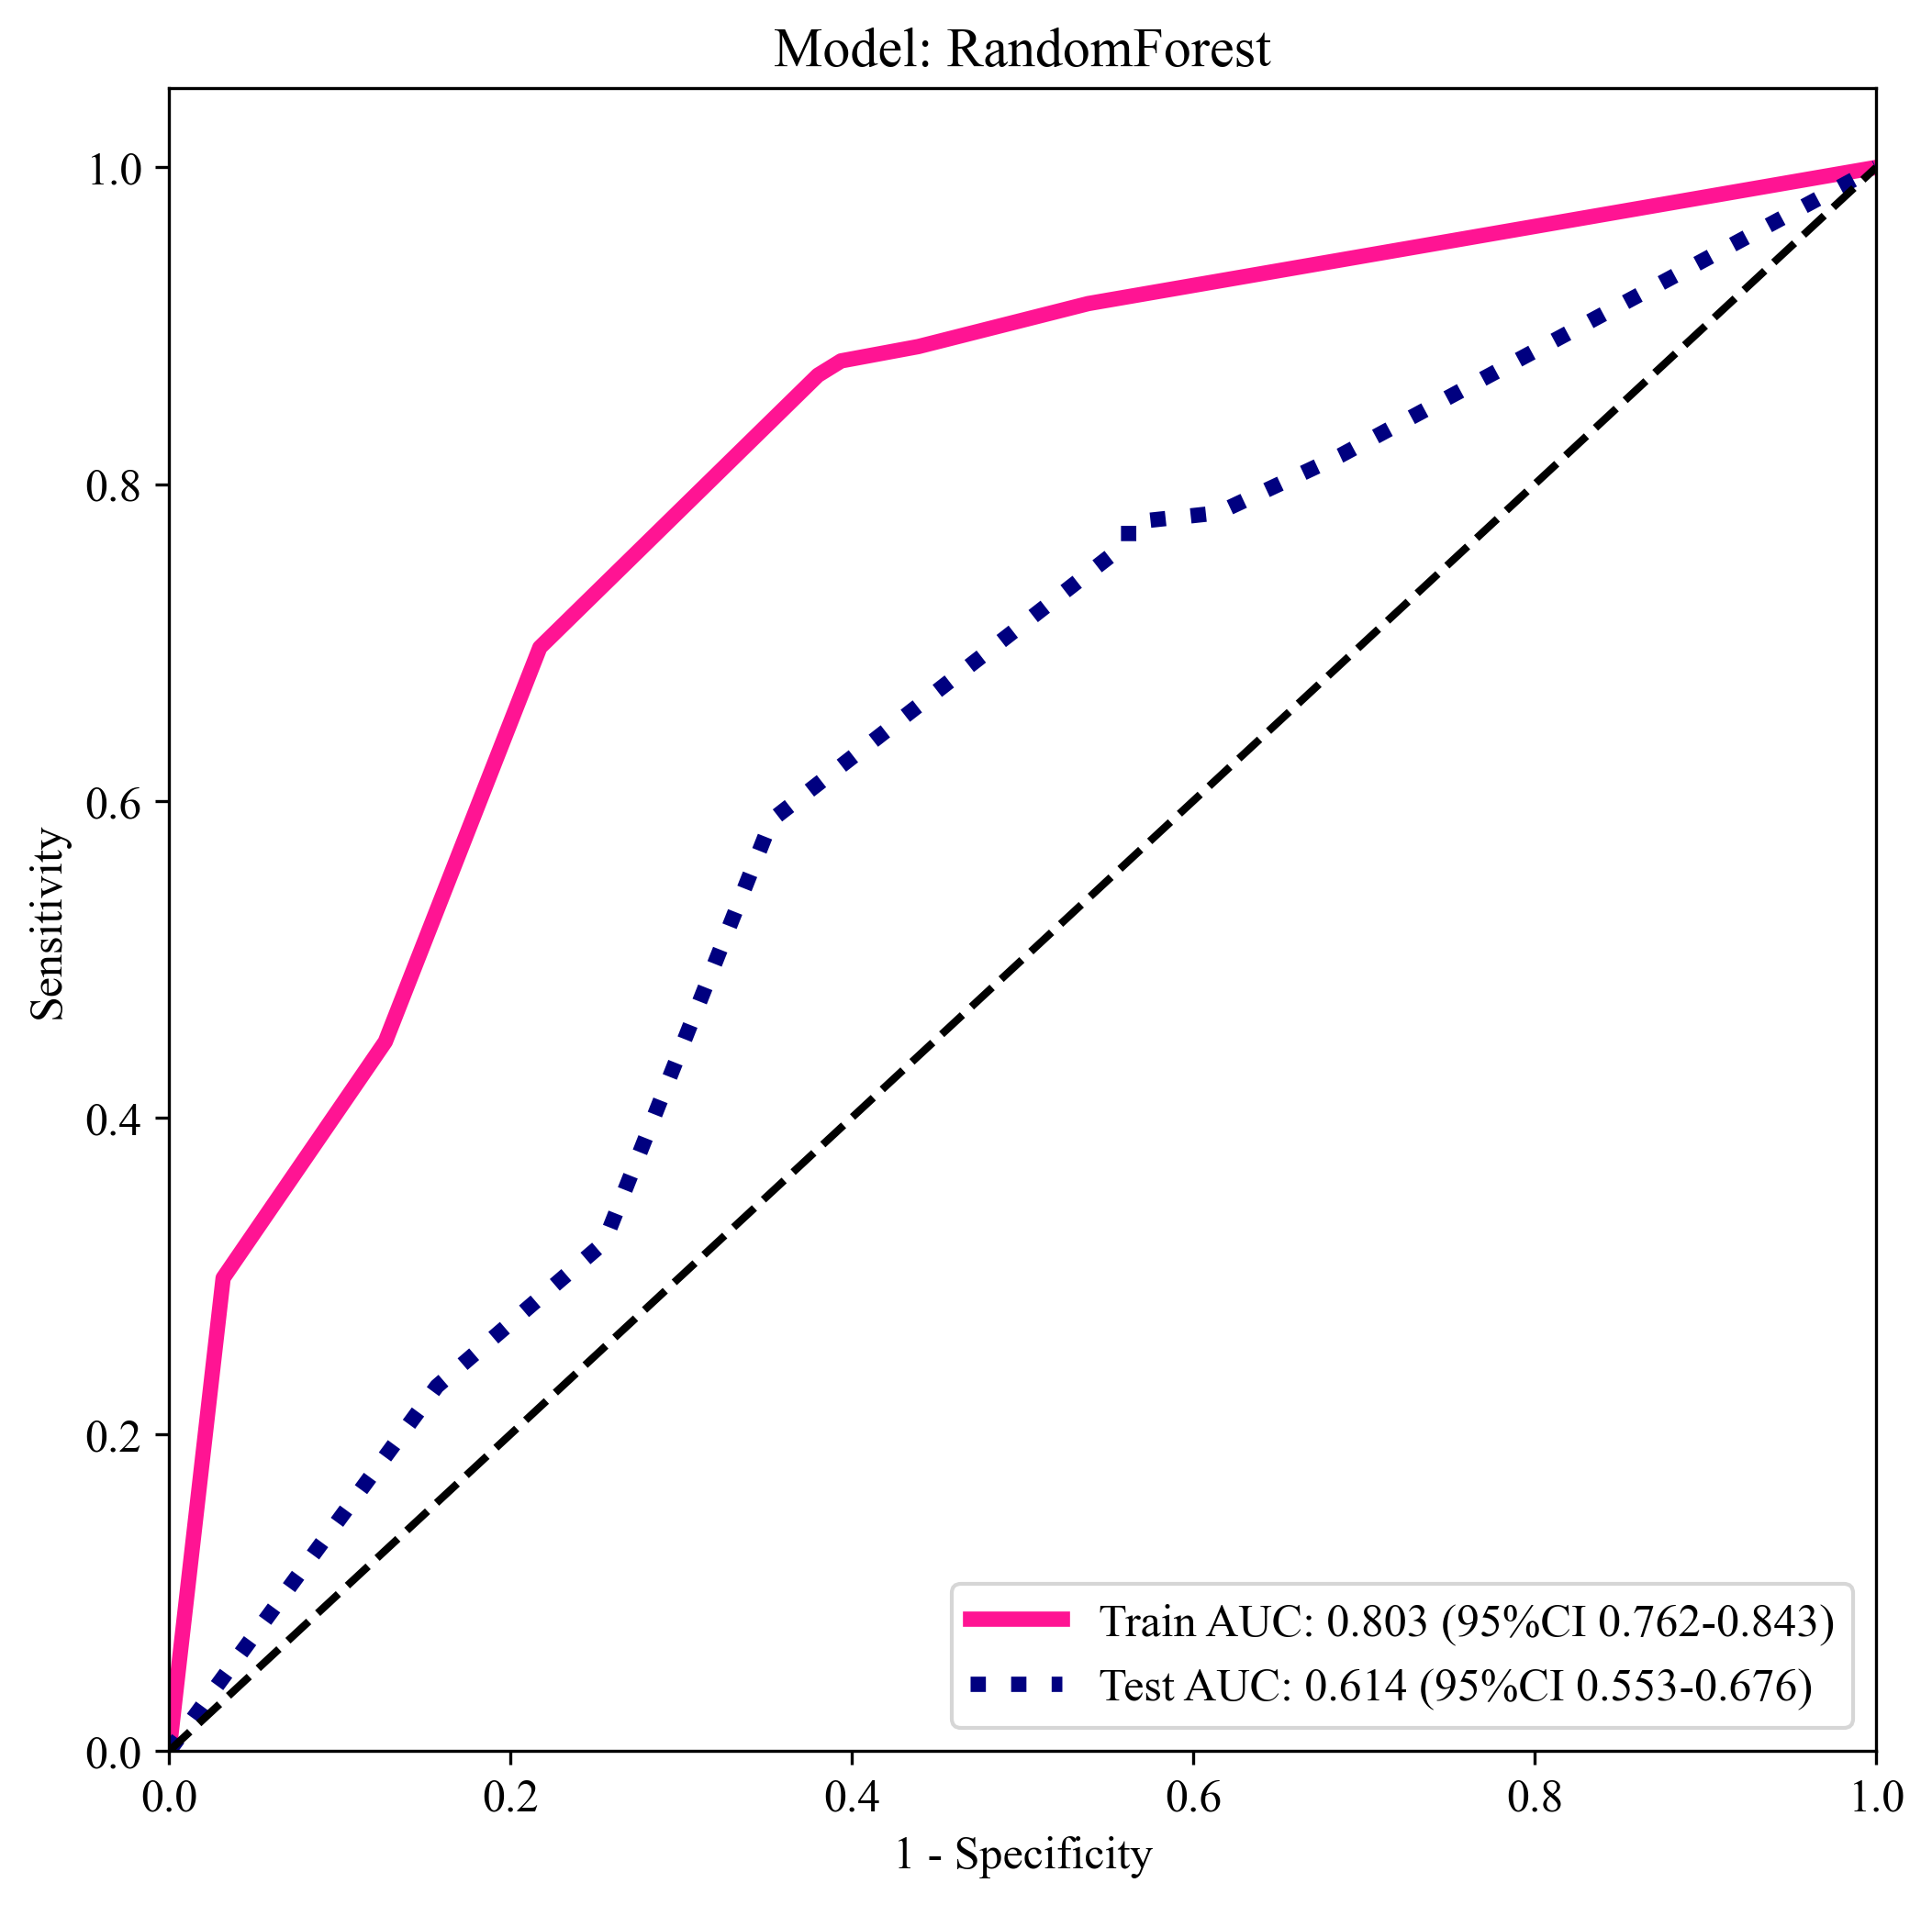

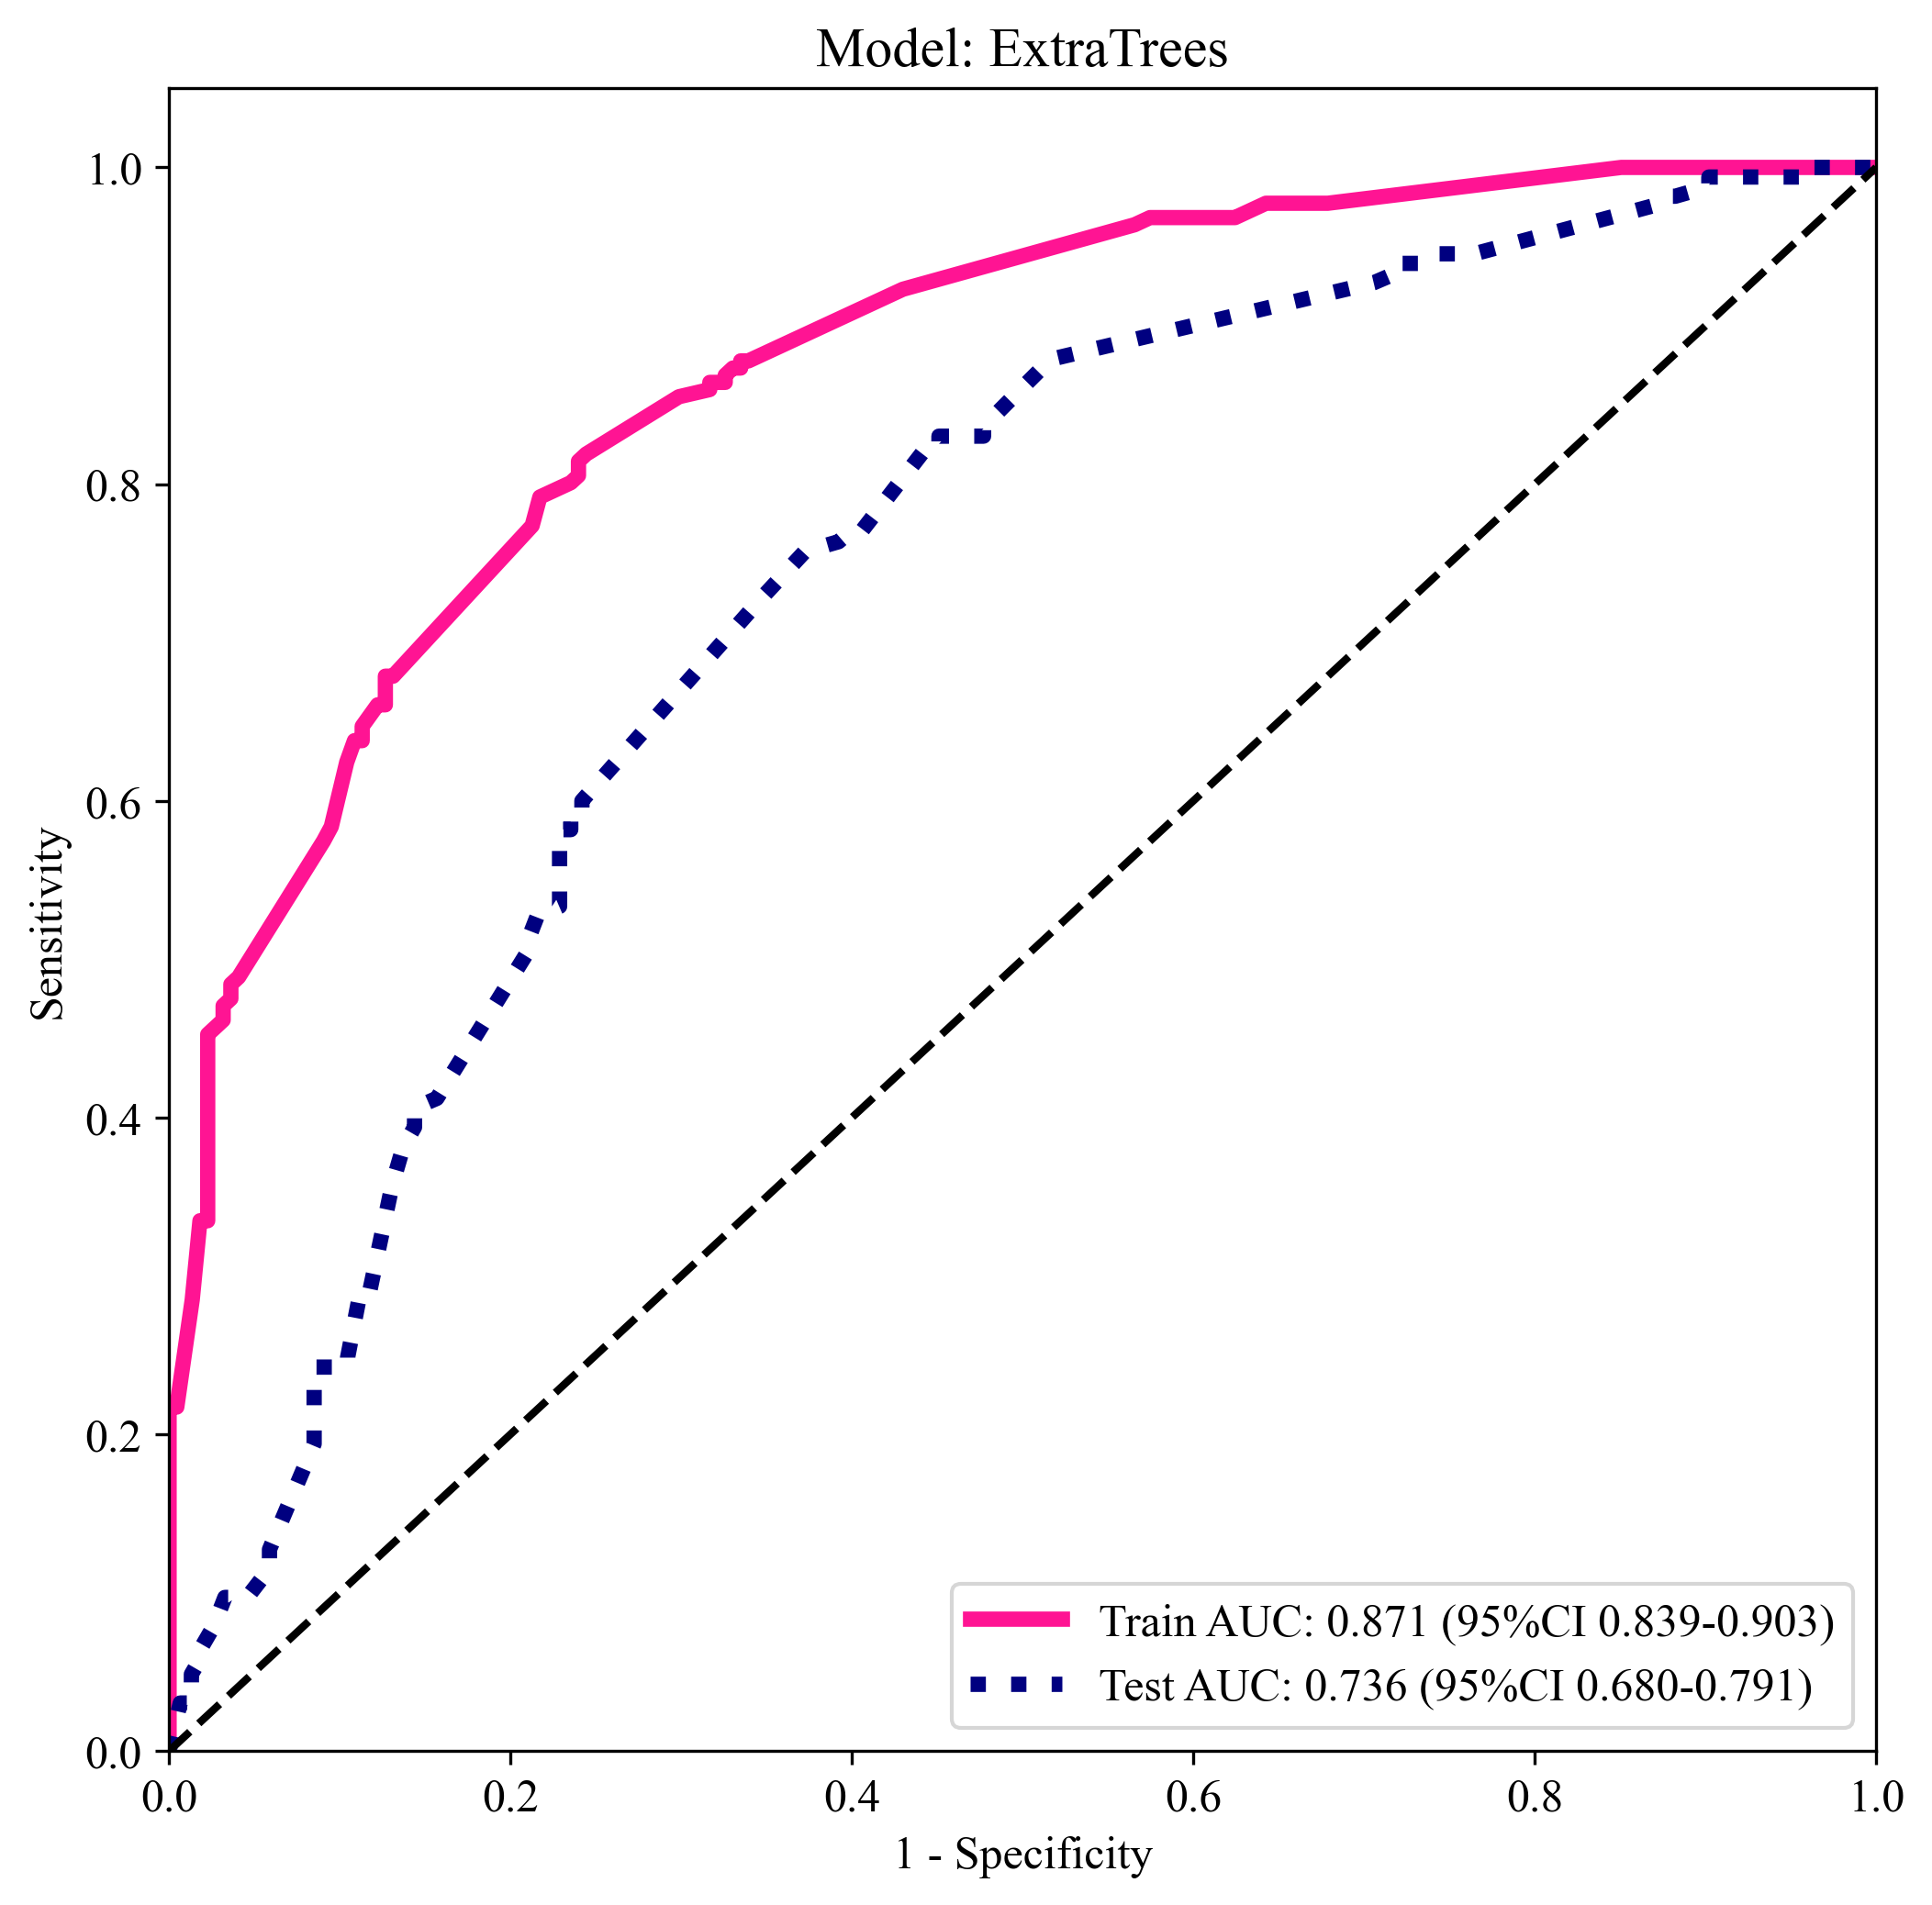

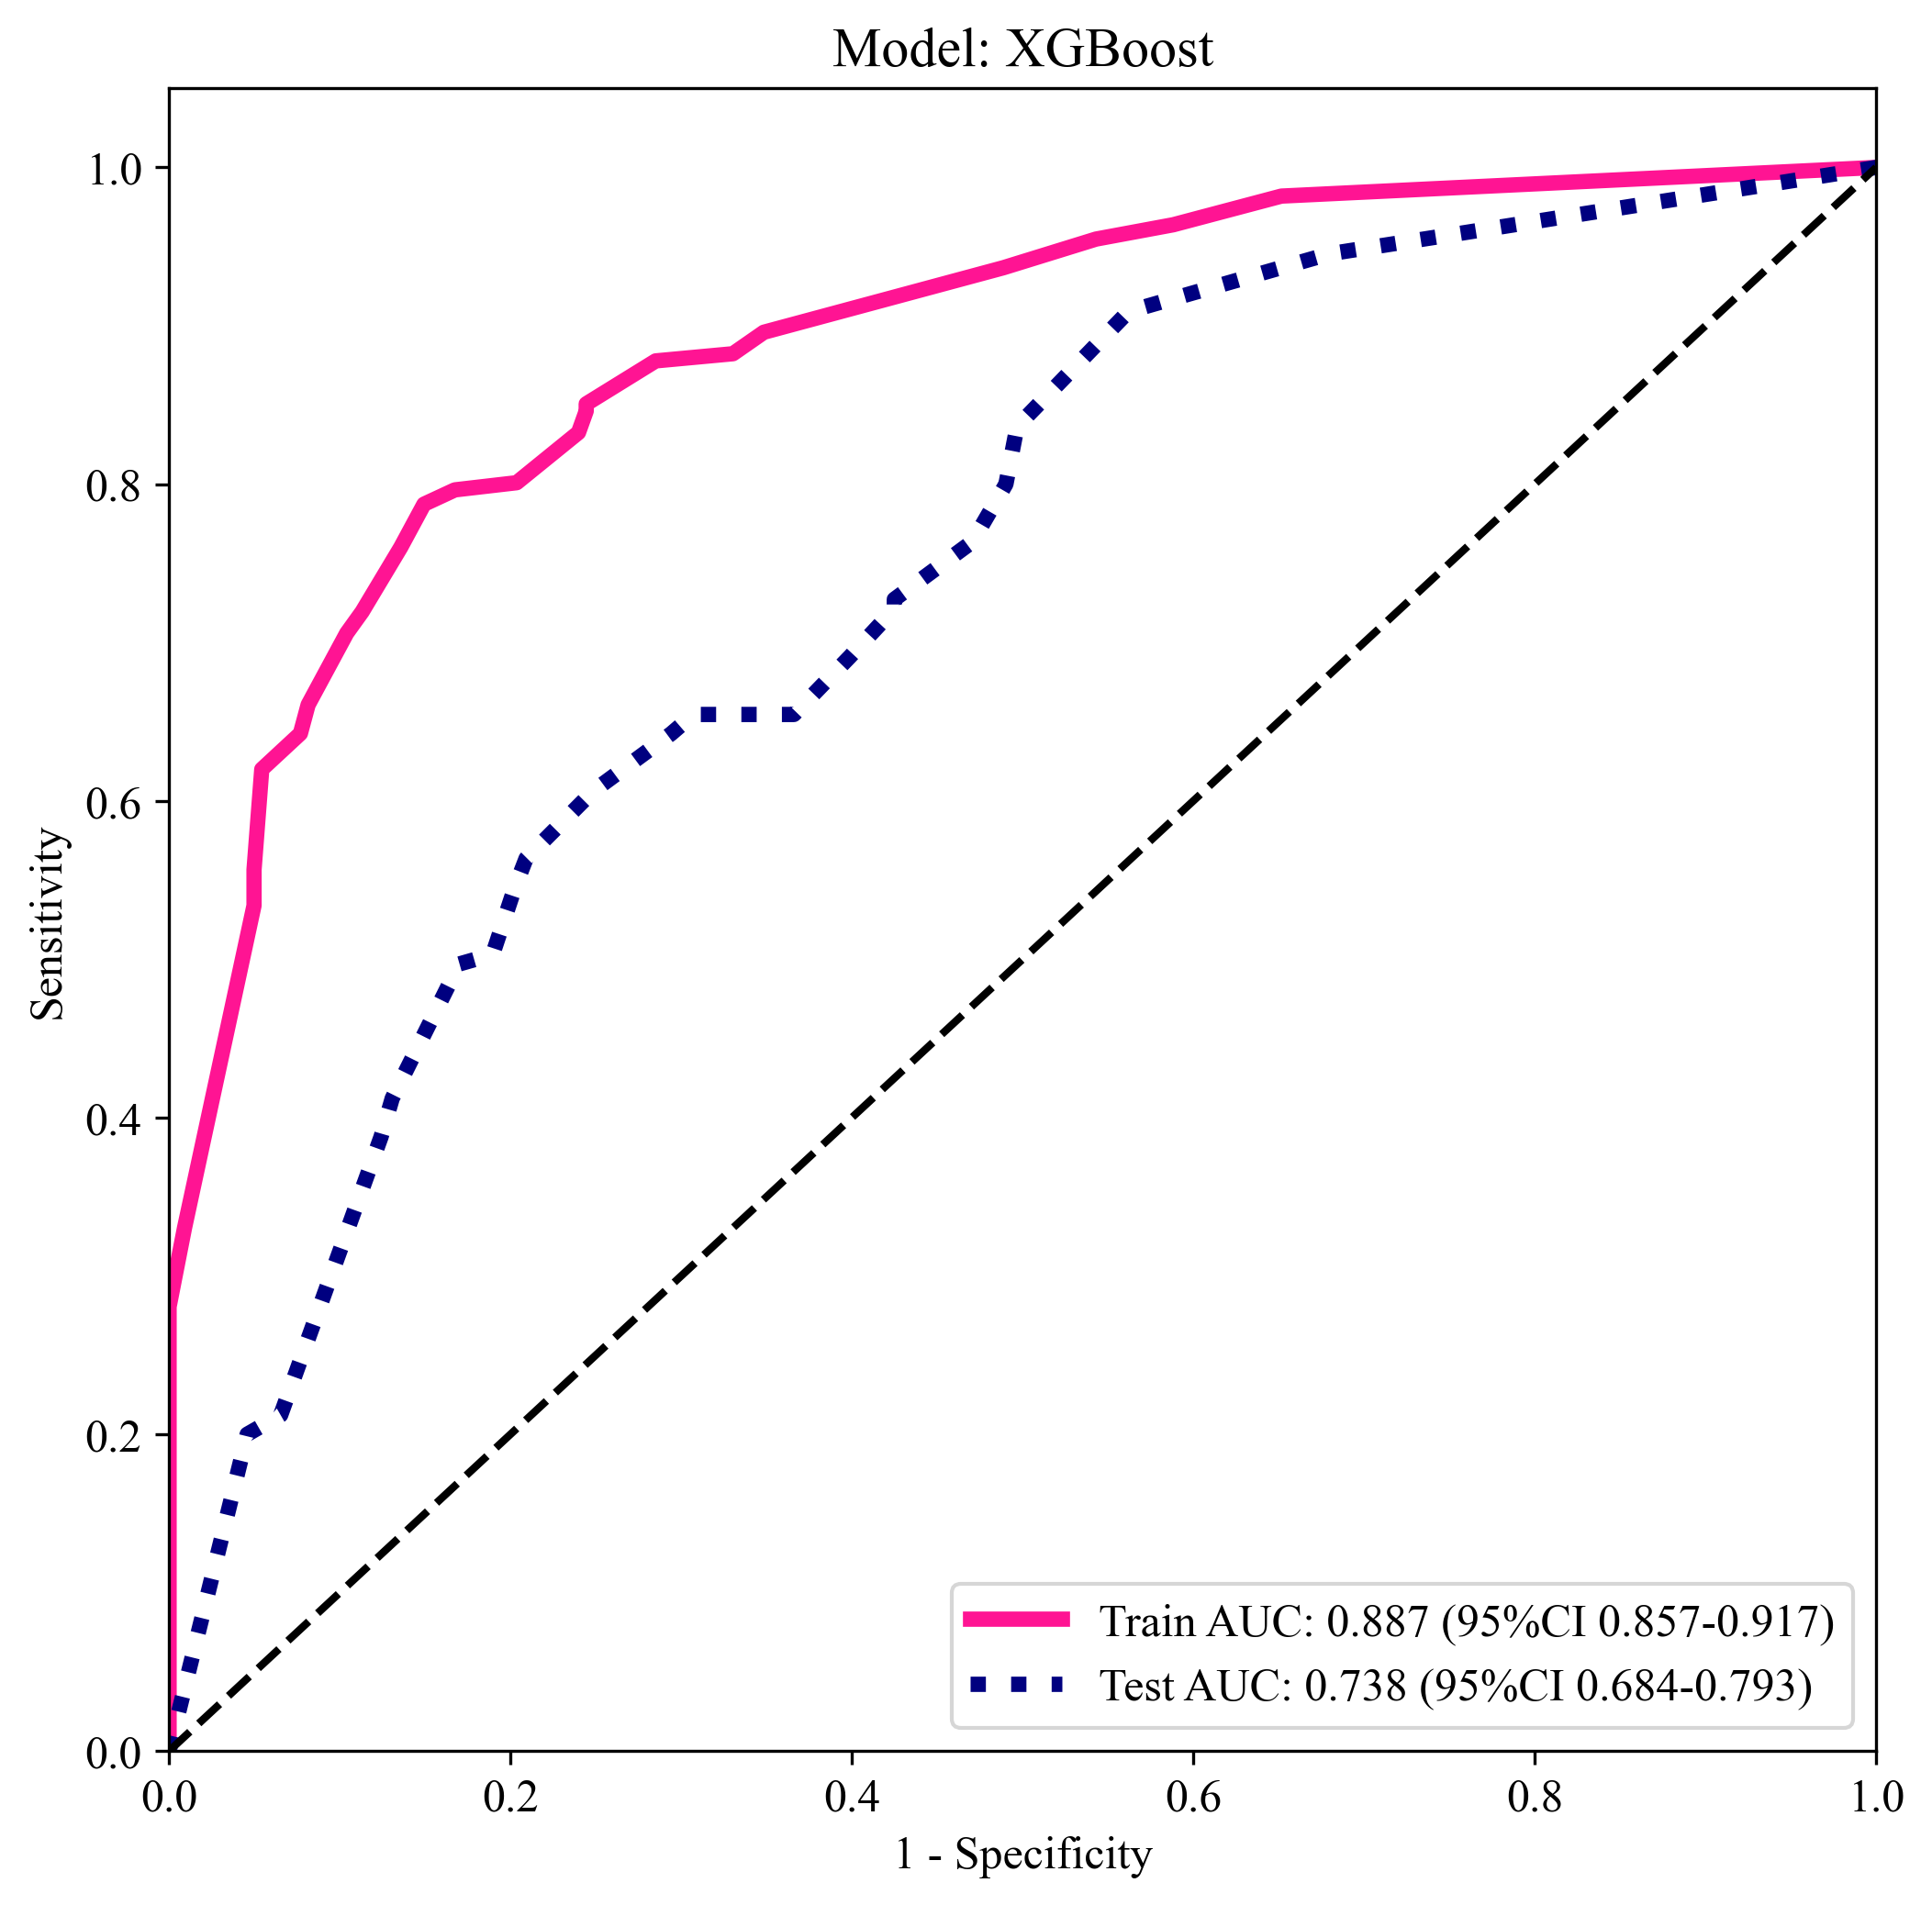

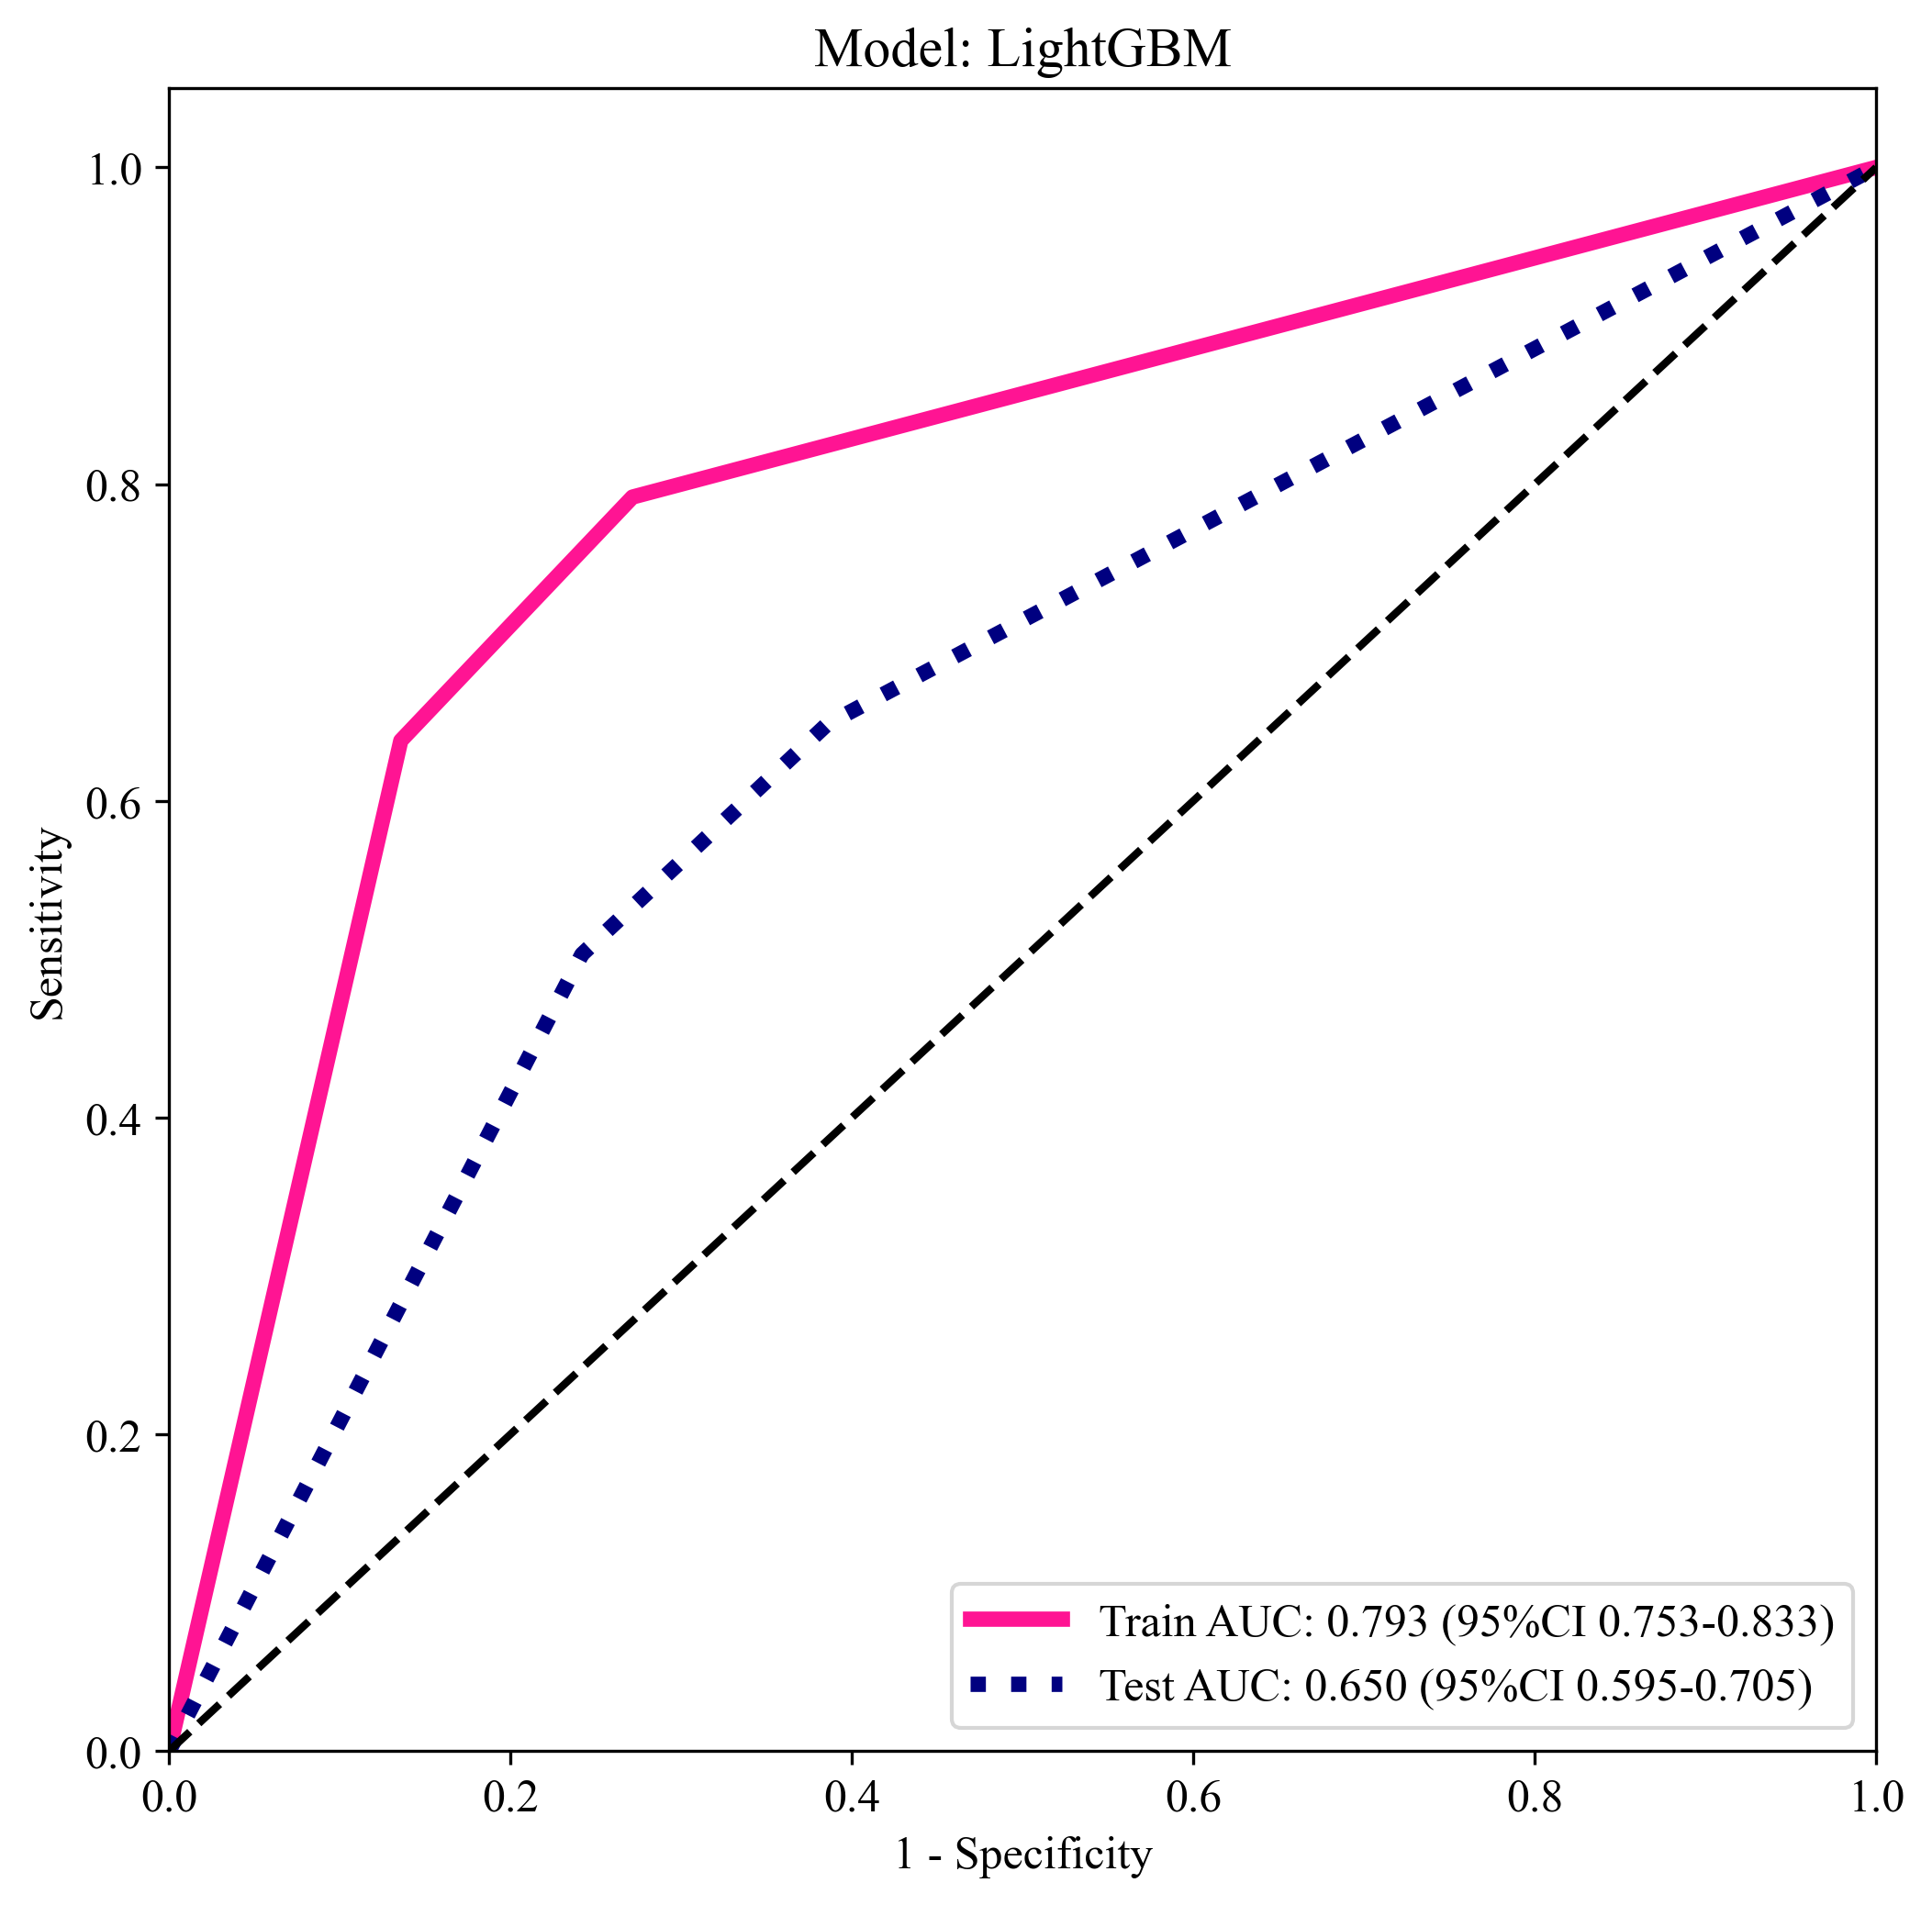

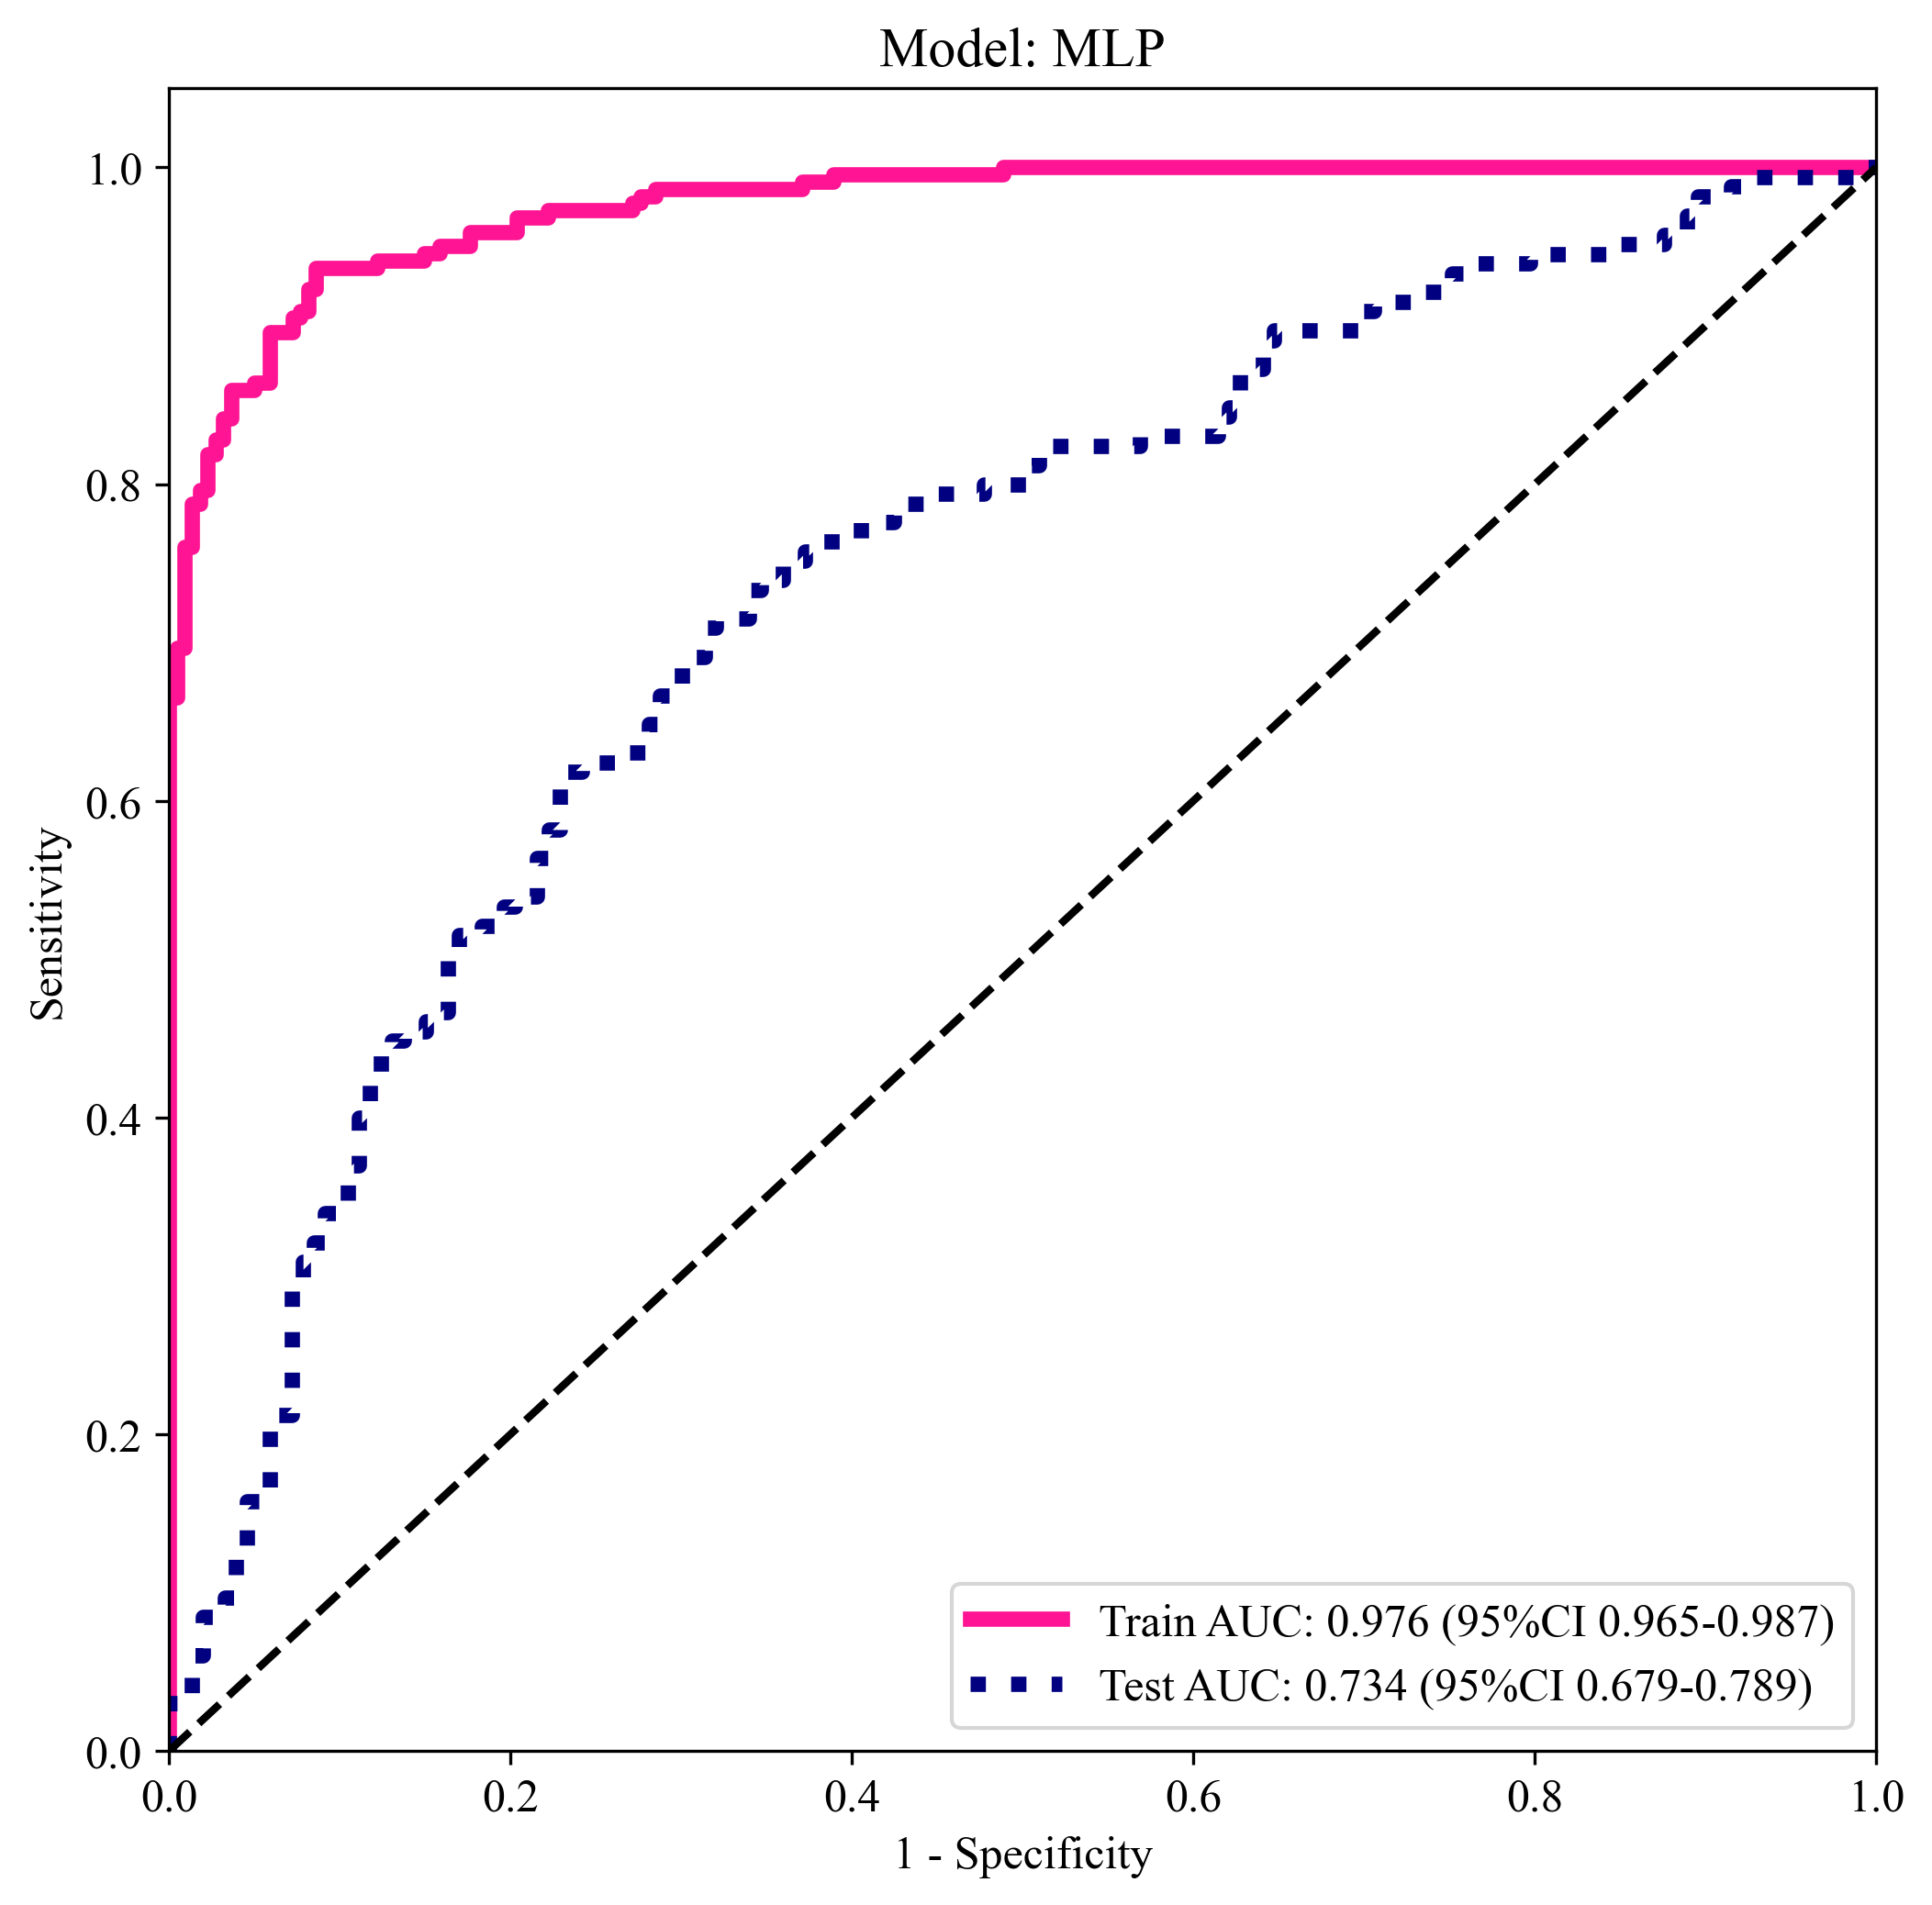

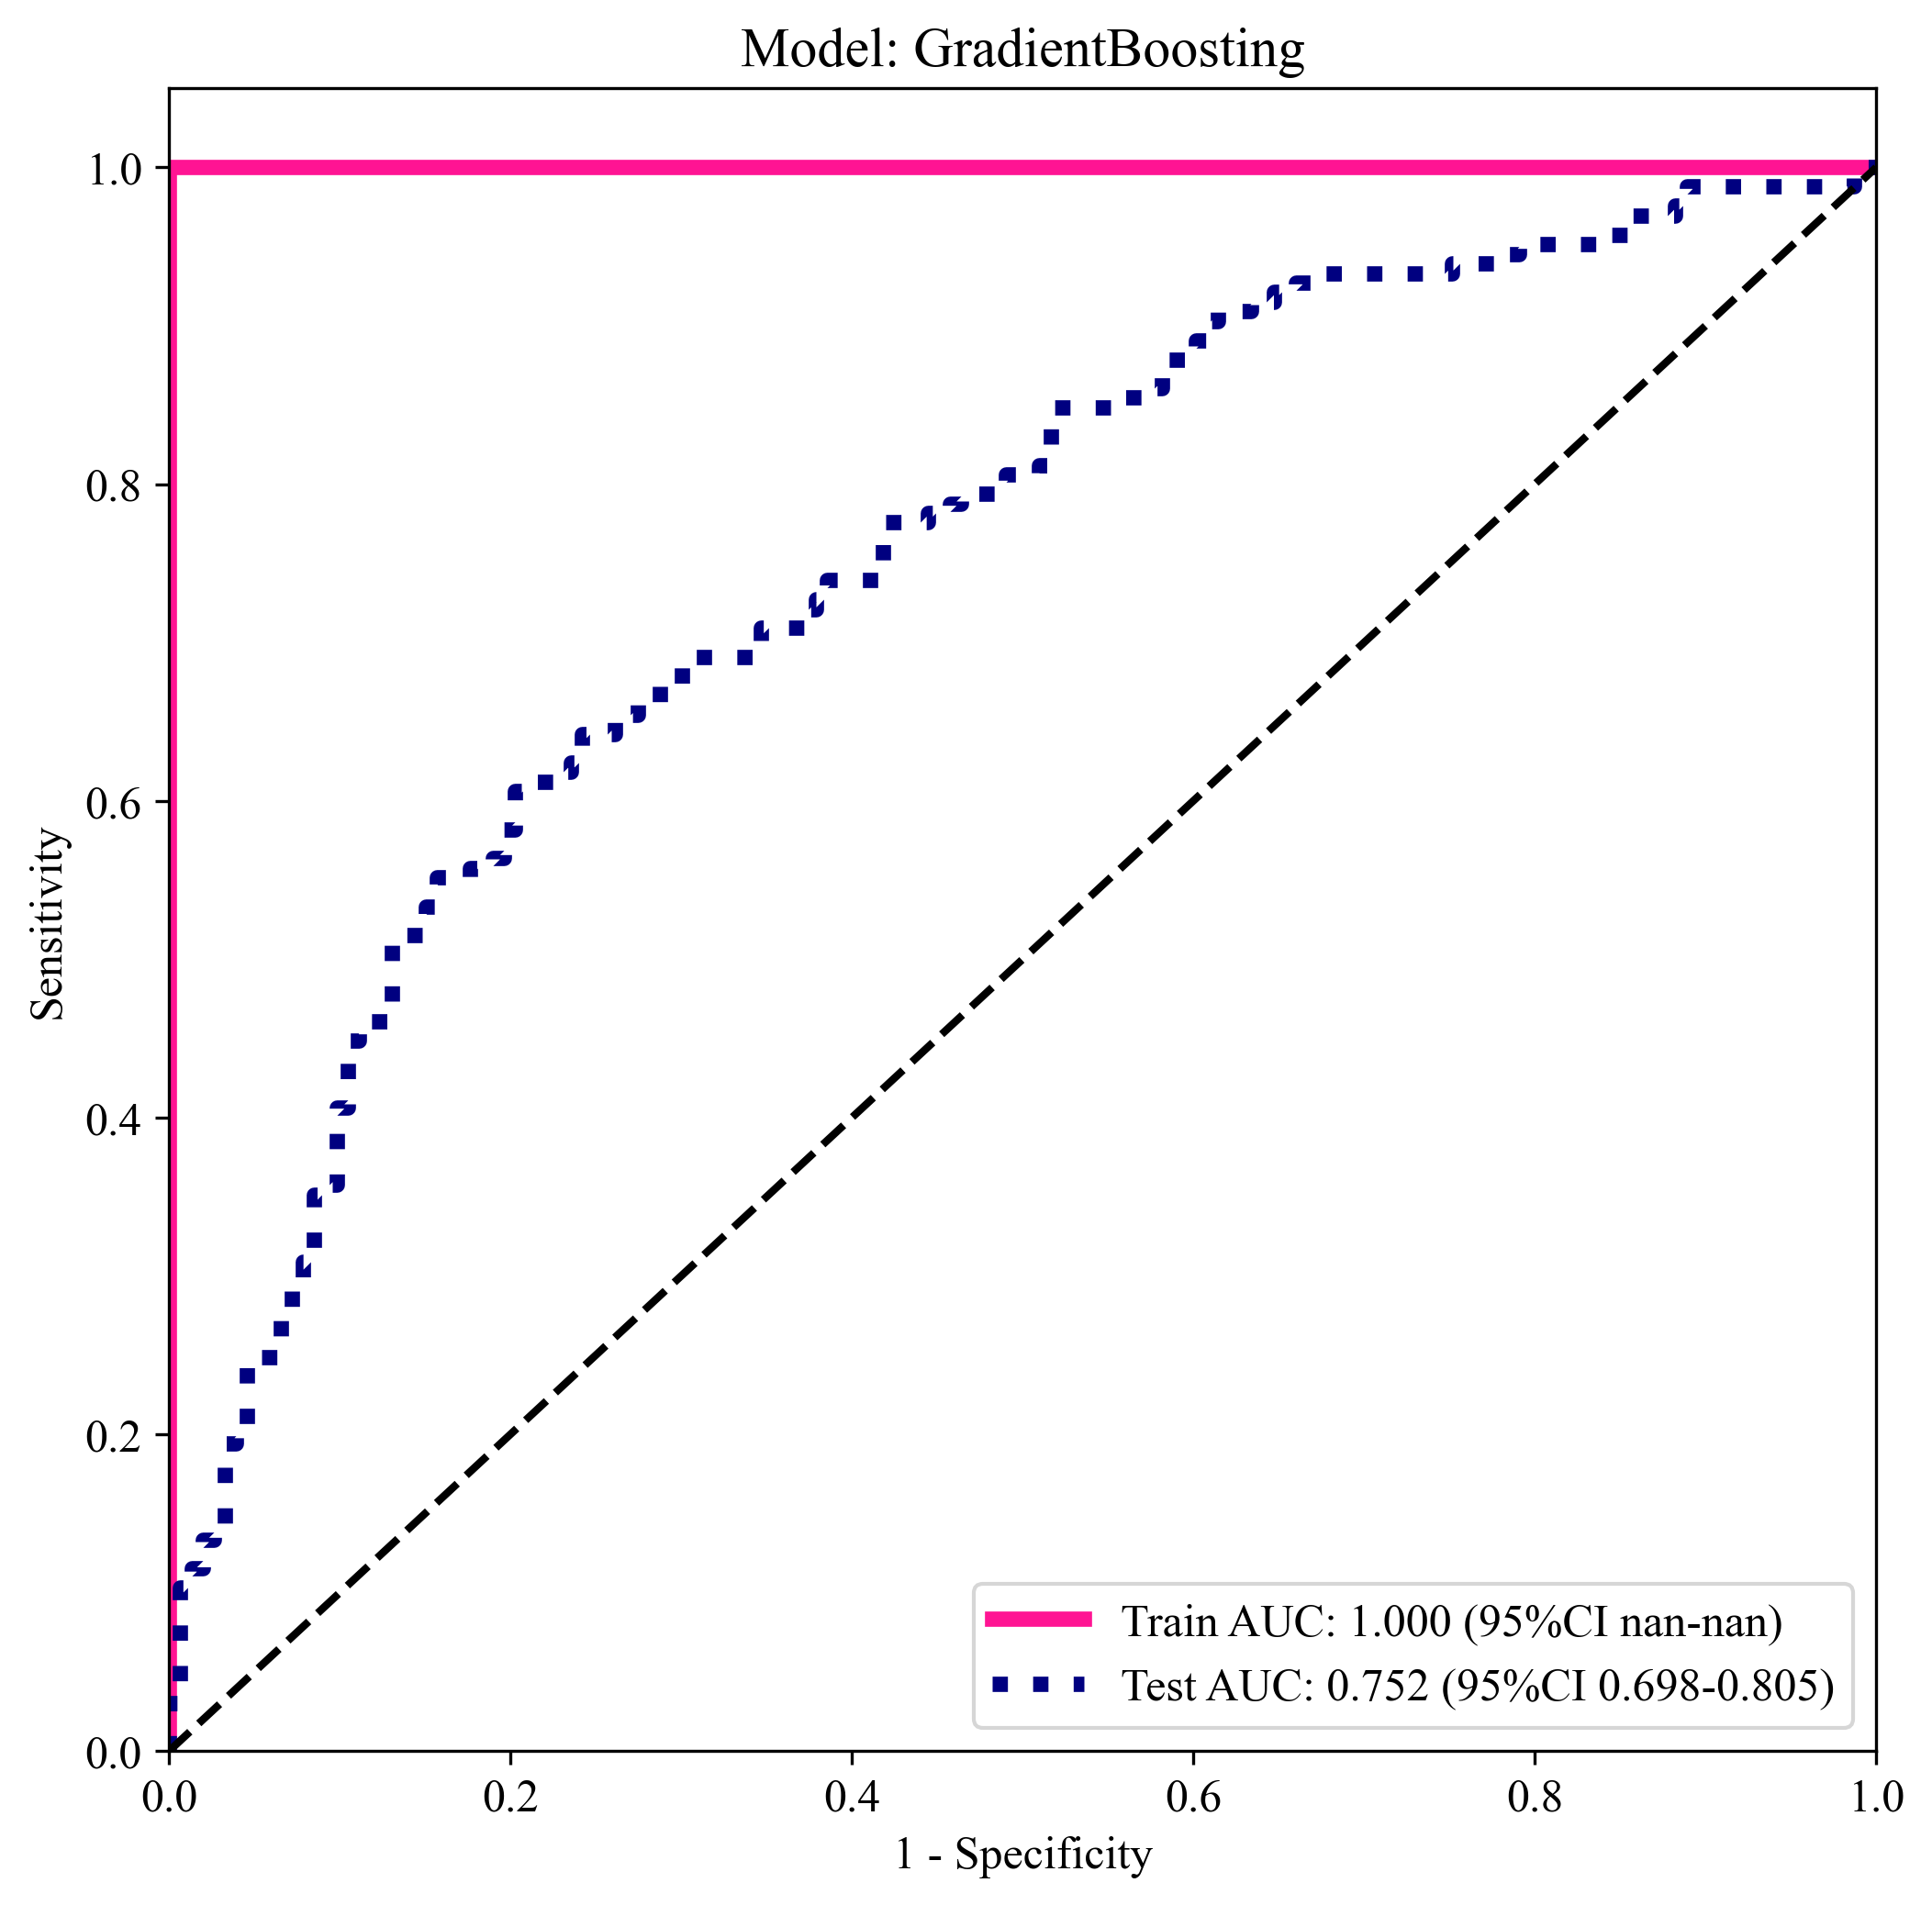

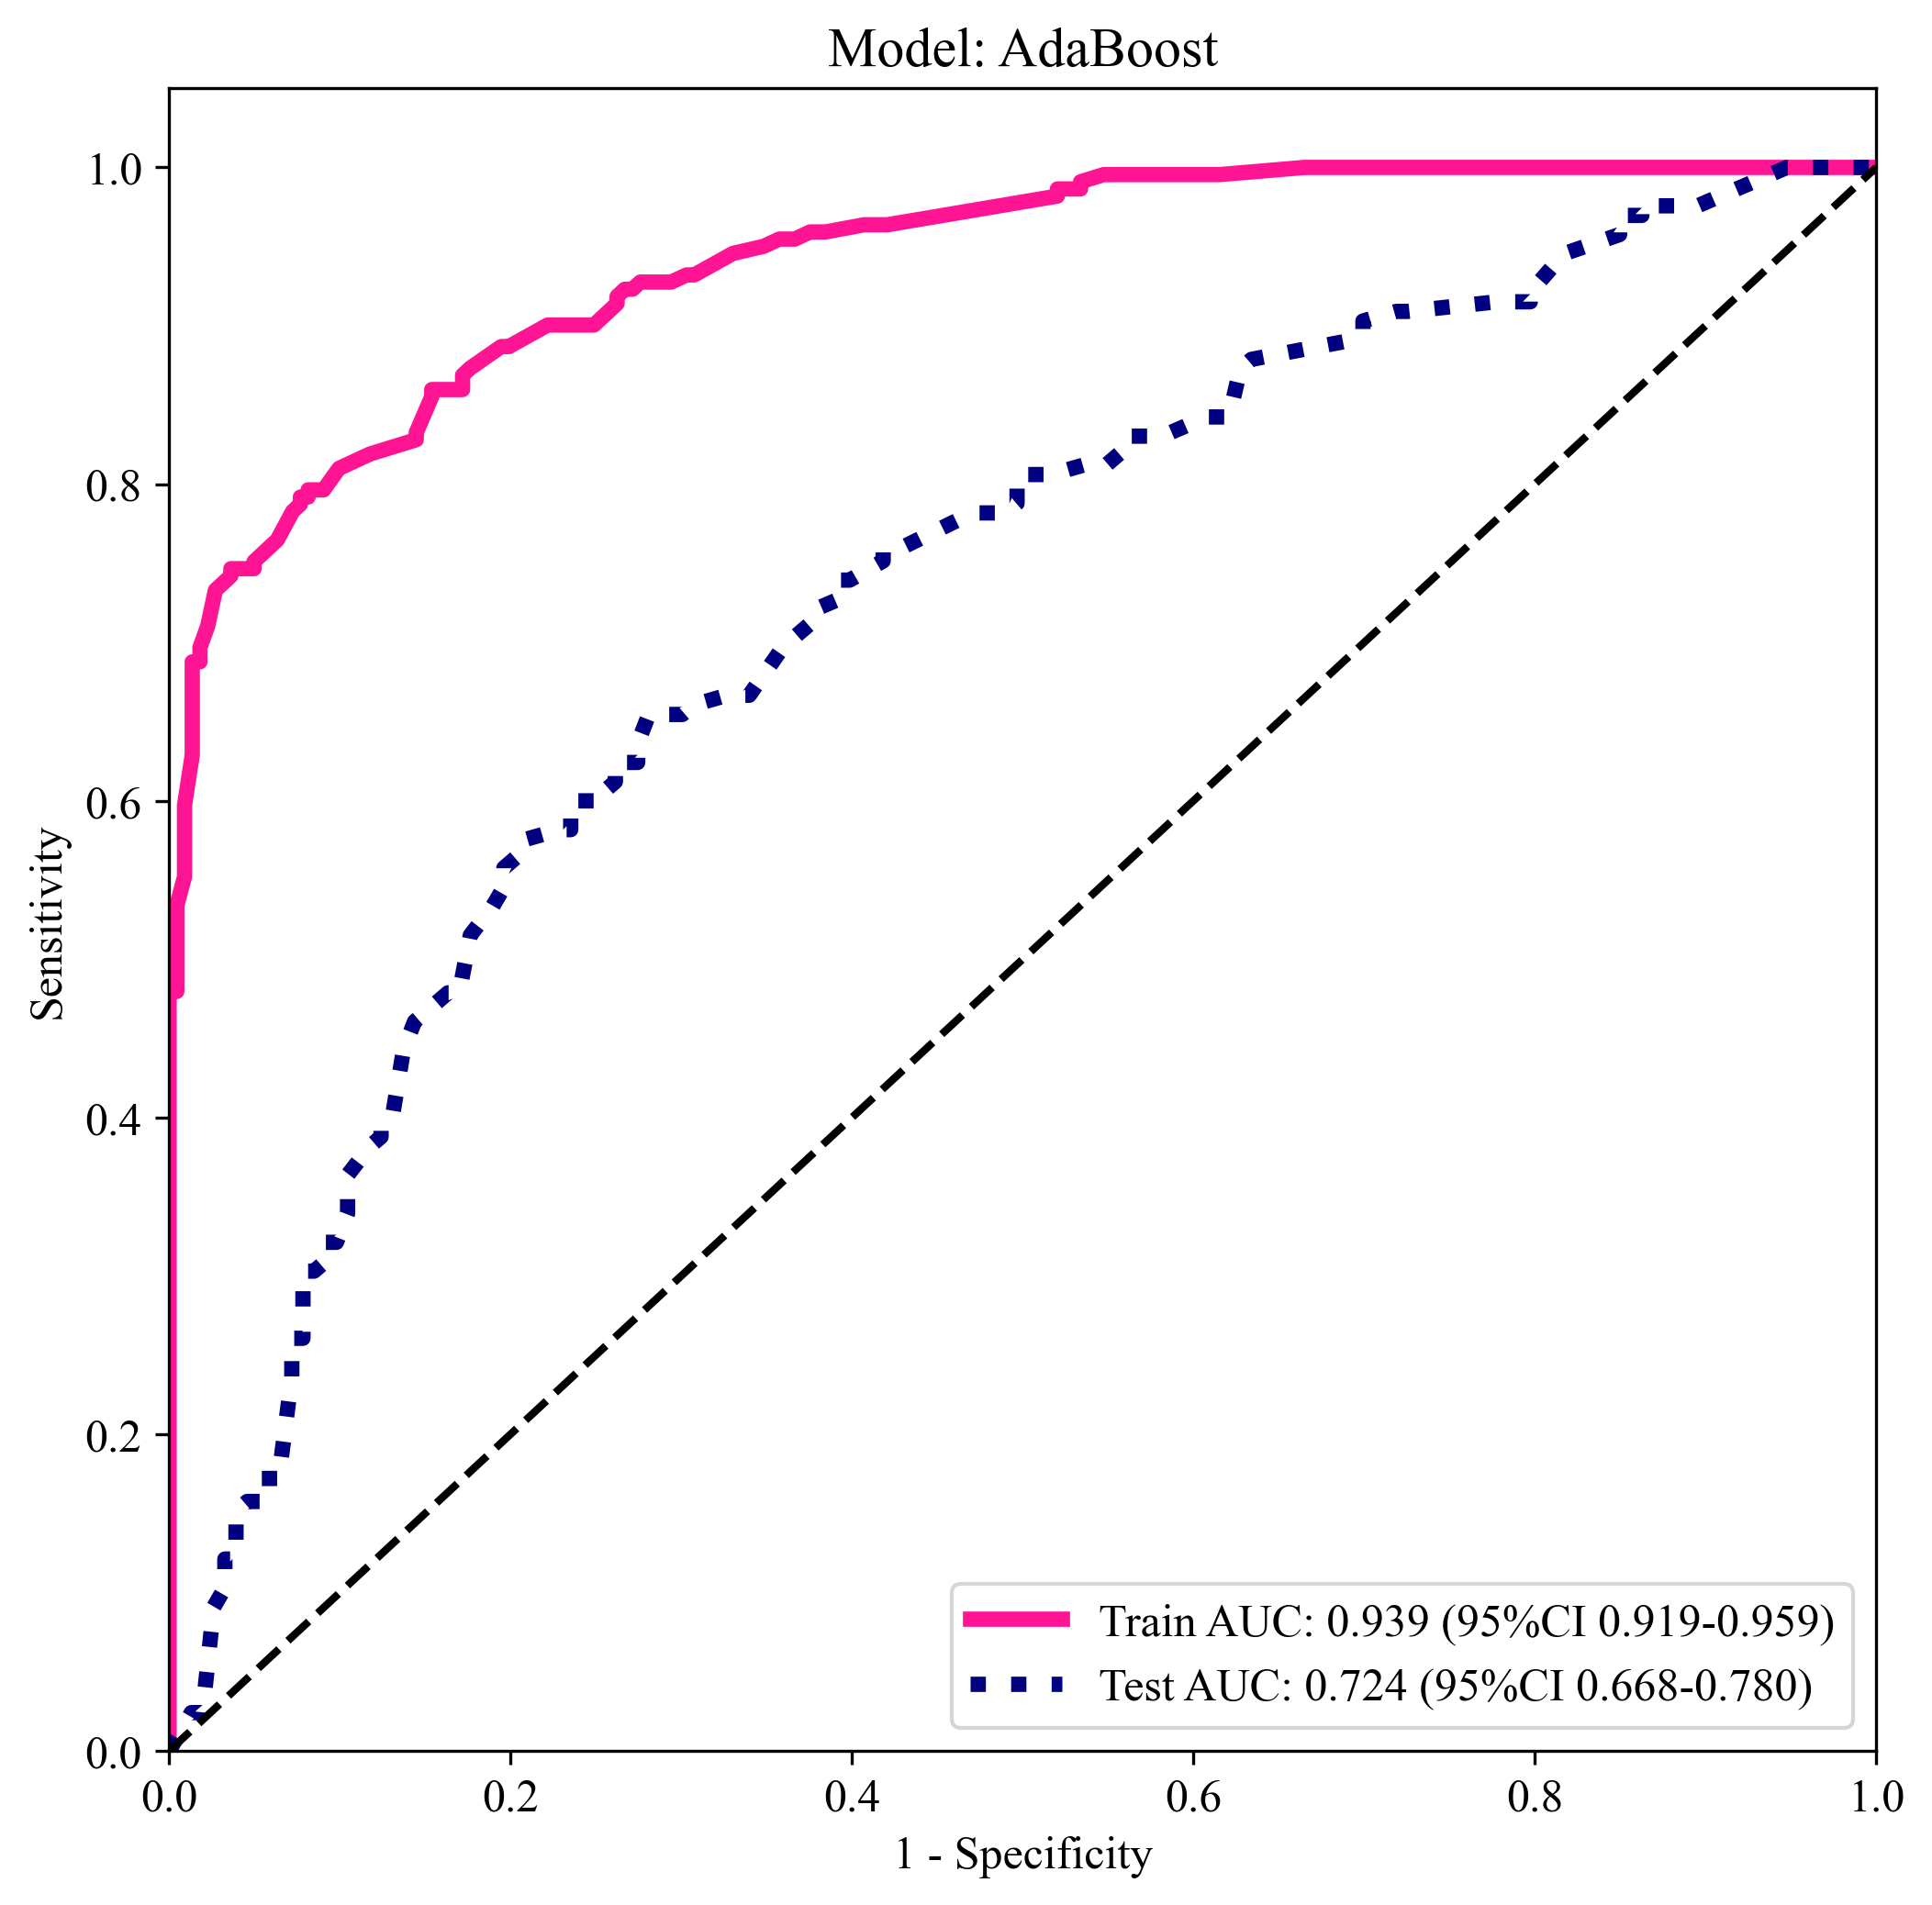

In [23]:
sel_model = model_names

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
    
        # Plot all ROC curves
        plt.figure(figsize=(8, 8))
        for pred_score, label in zip(pred_scores, labels):
            okcomp.comp1.draw_roc([np.array(y_train_sel[label]), np.array(y_test_sel[label])], 
                                  pred_score[sel_model_idx], 
                                  labels=['Train', 'Test'], title=f"Model: {sm}")
            plt.savefig(f'img/{task_type}_model_{sm}_roc.svg', bbox_inches = 'tight')

#### 汇总所有模型

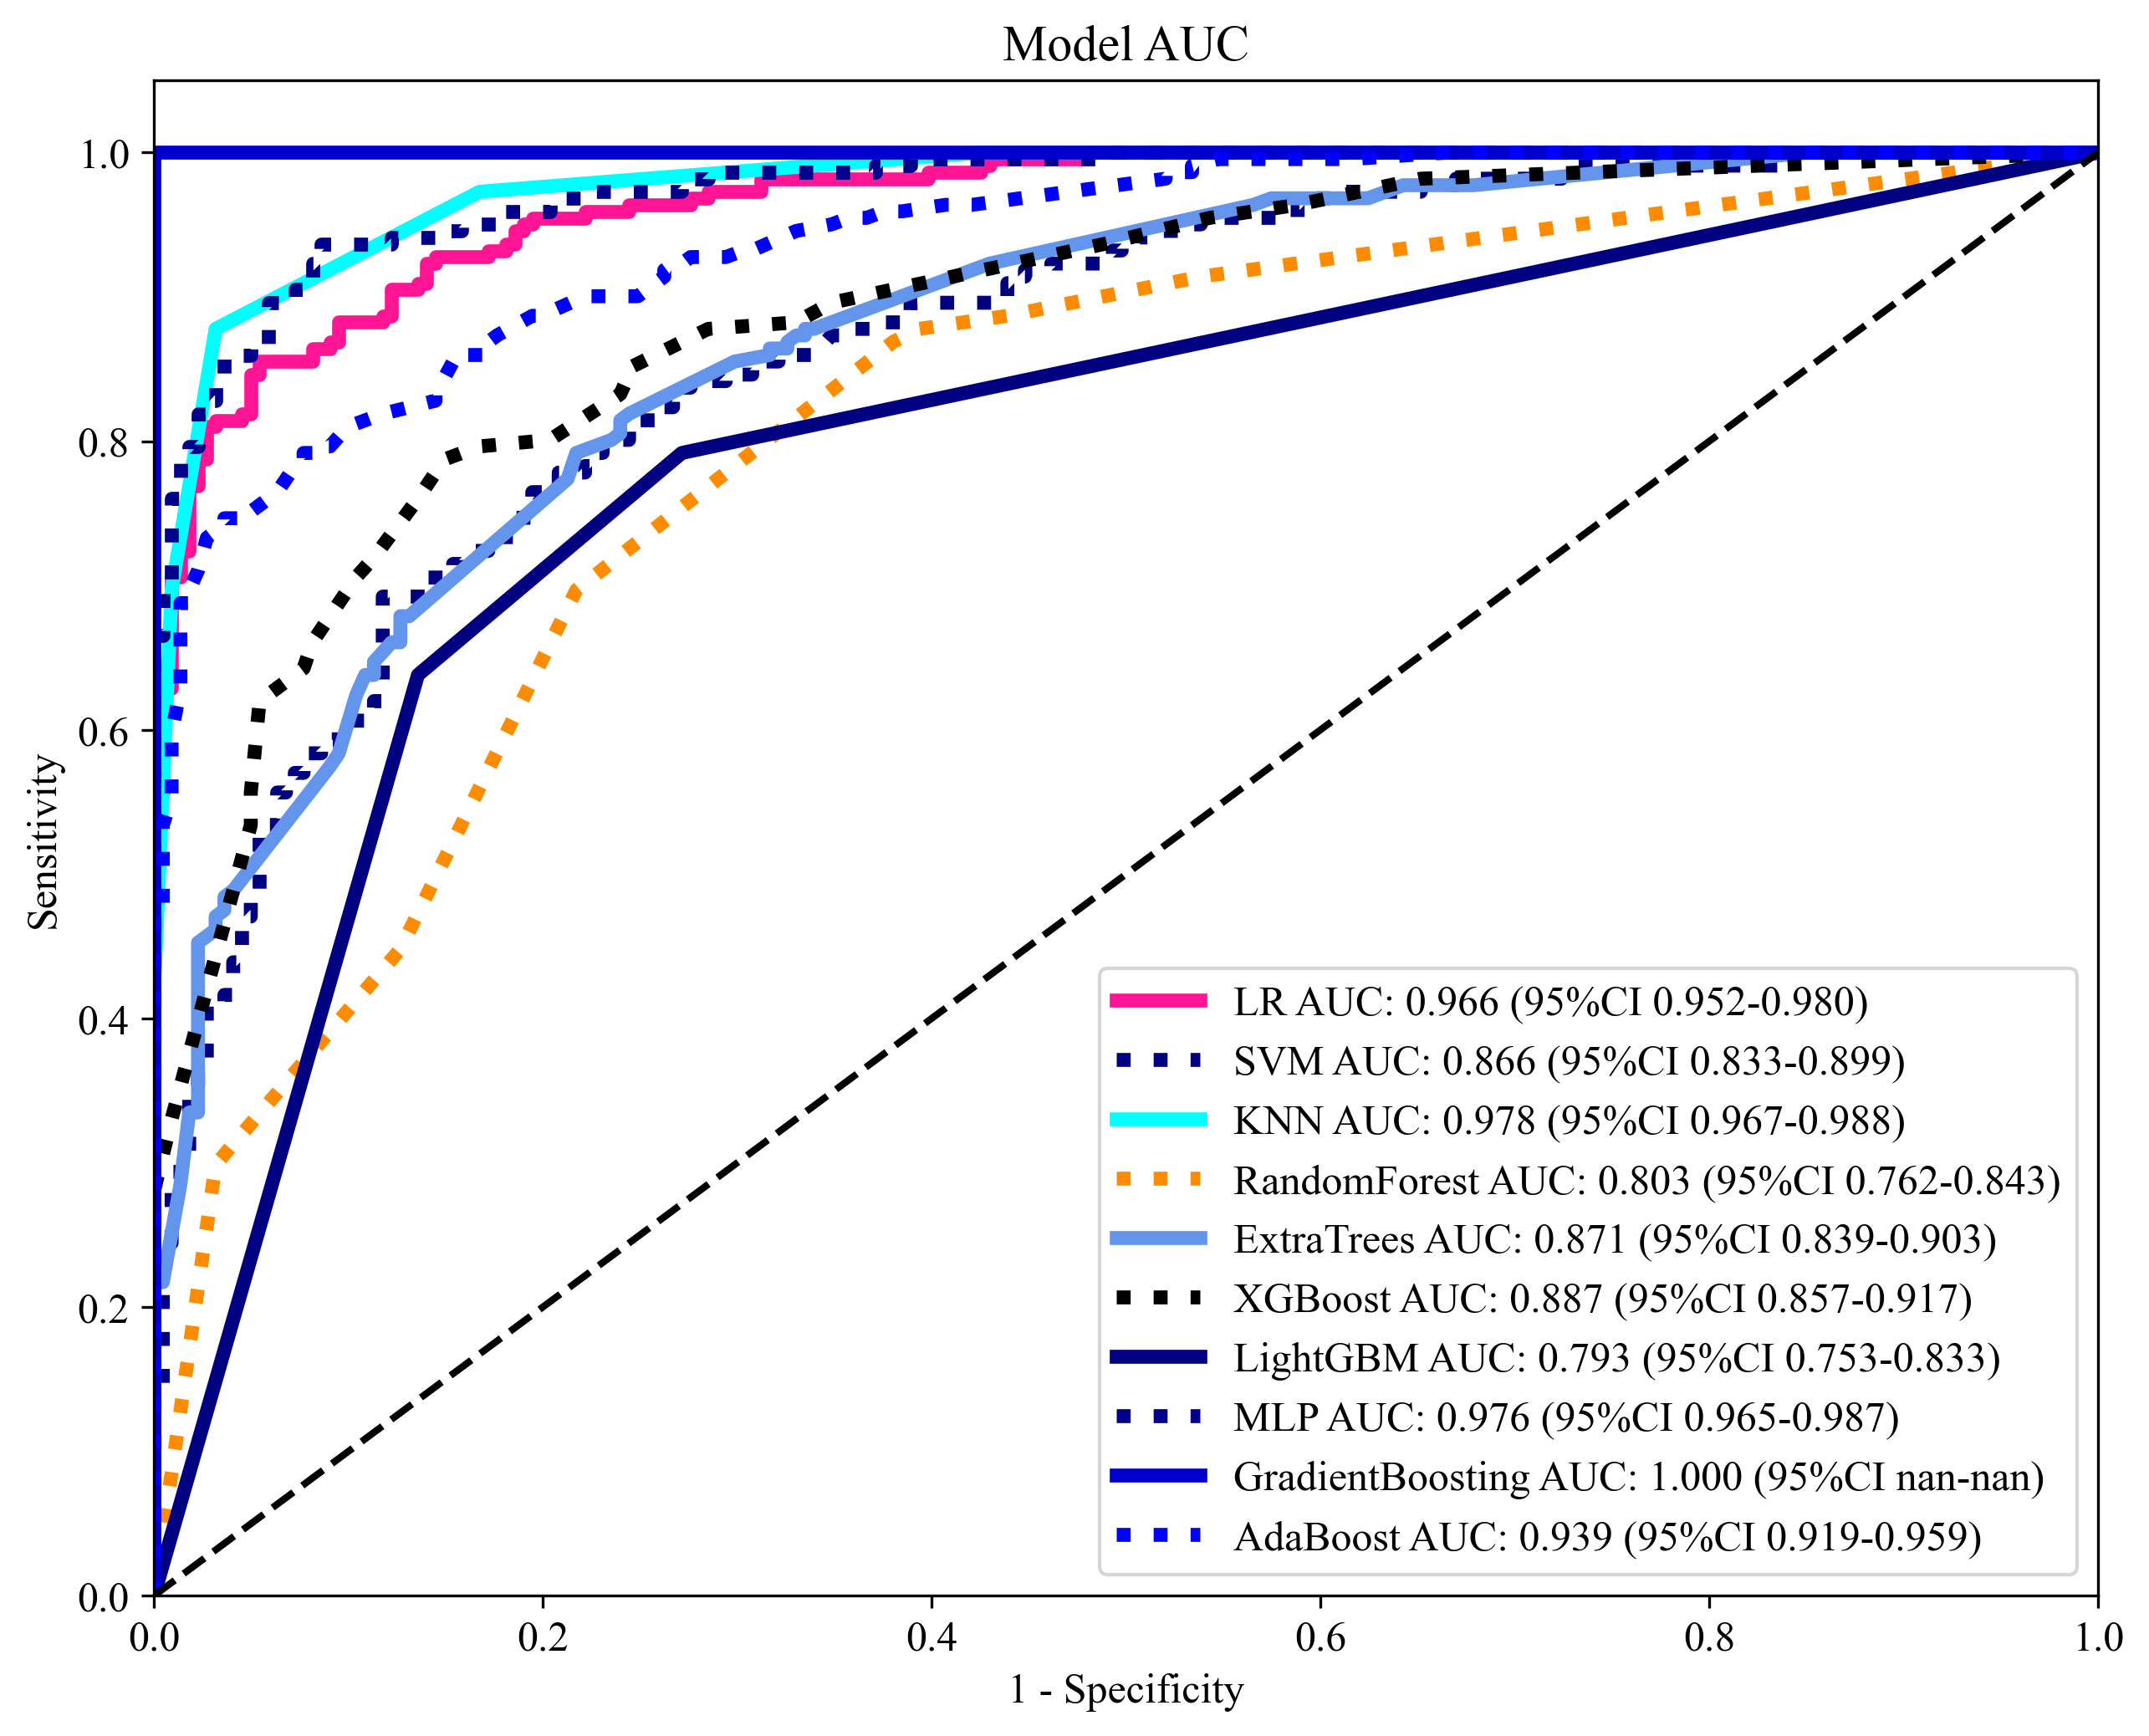

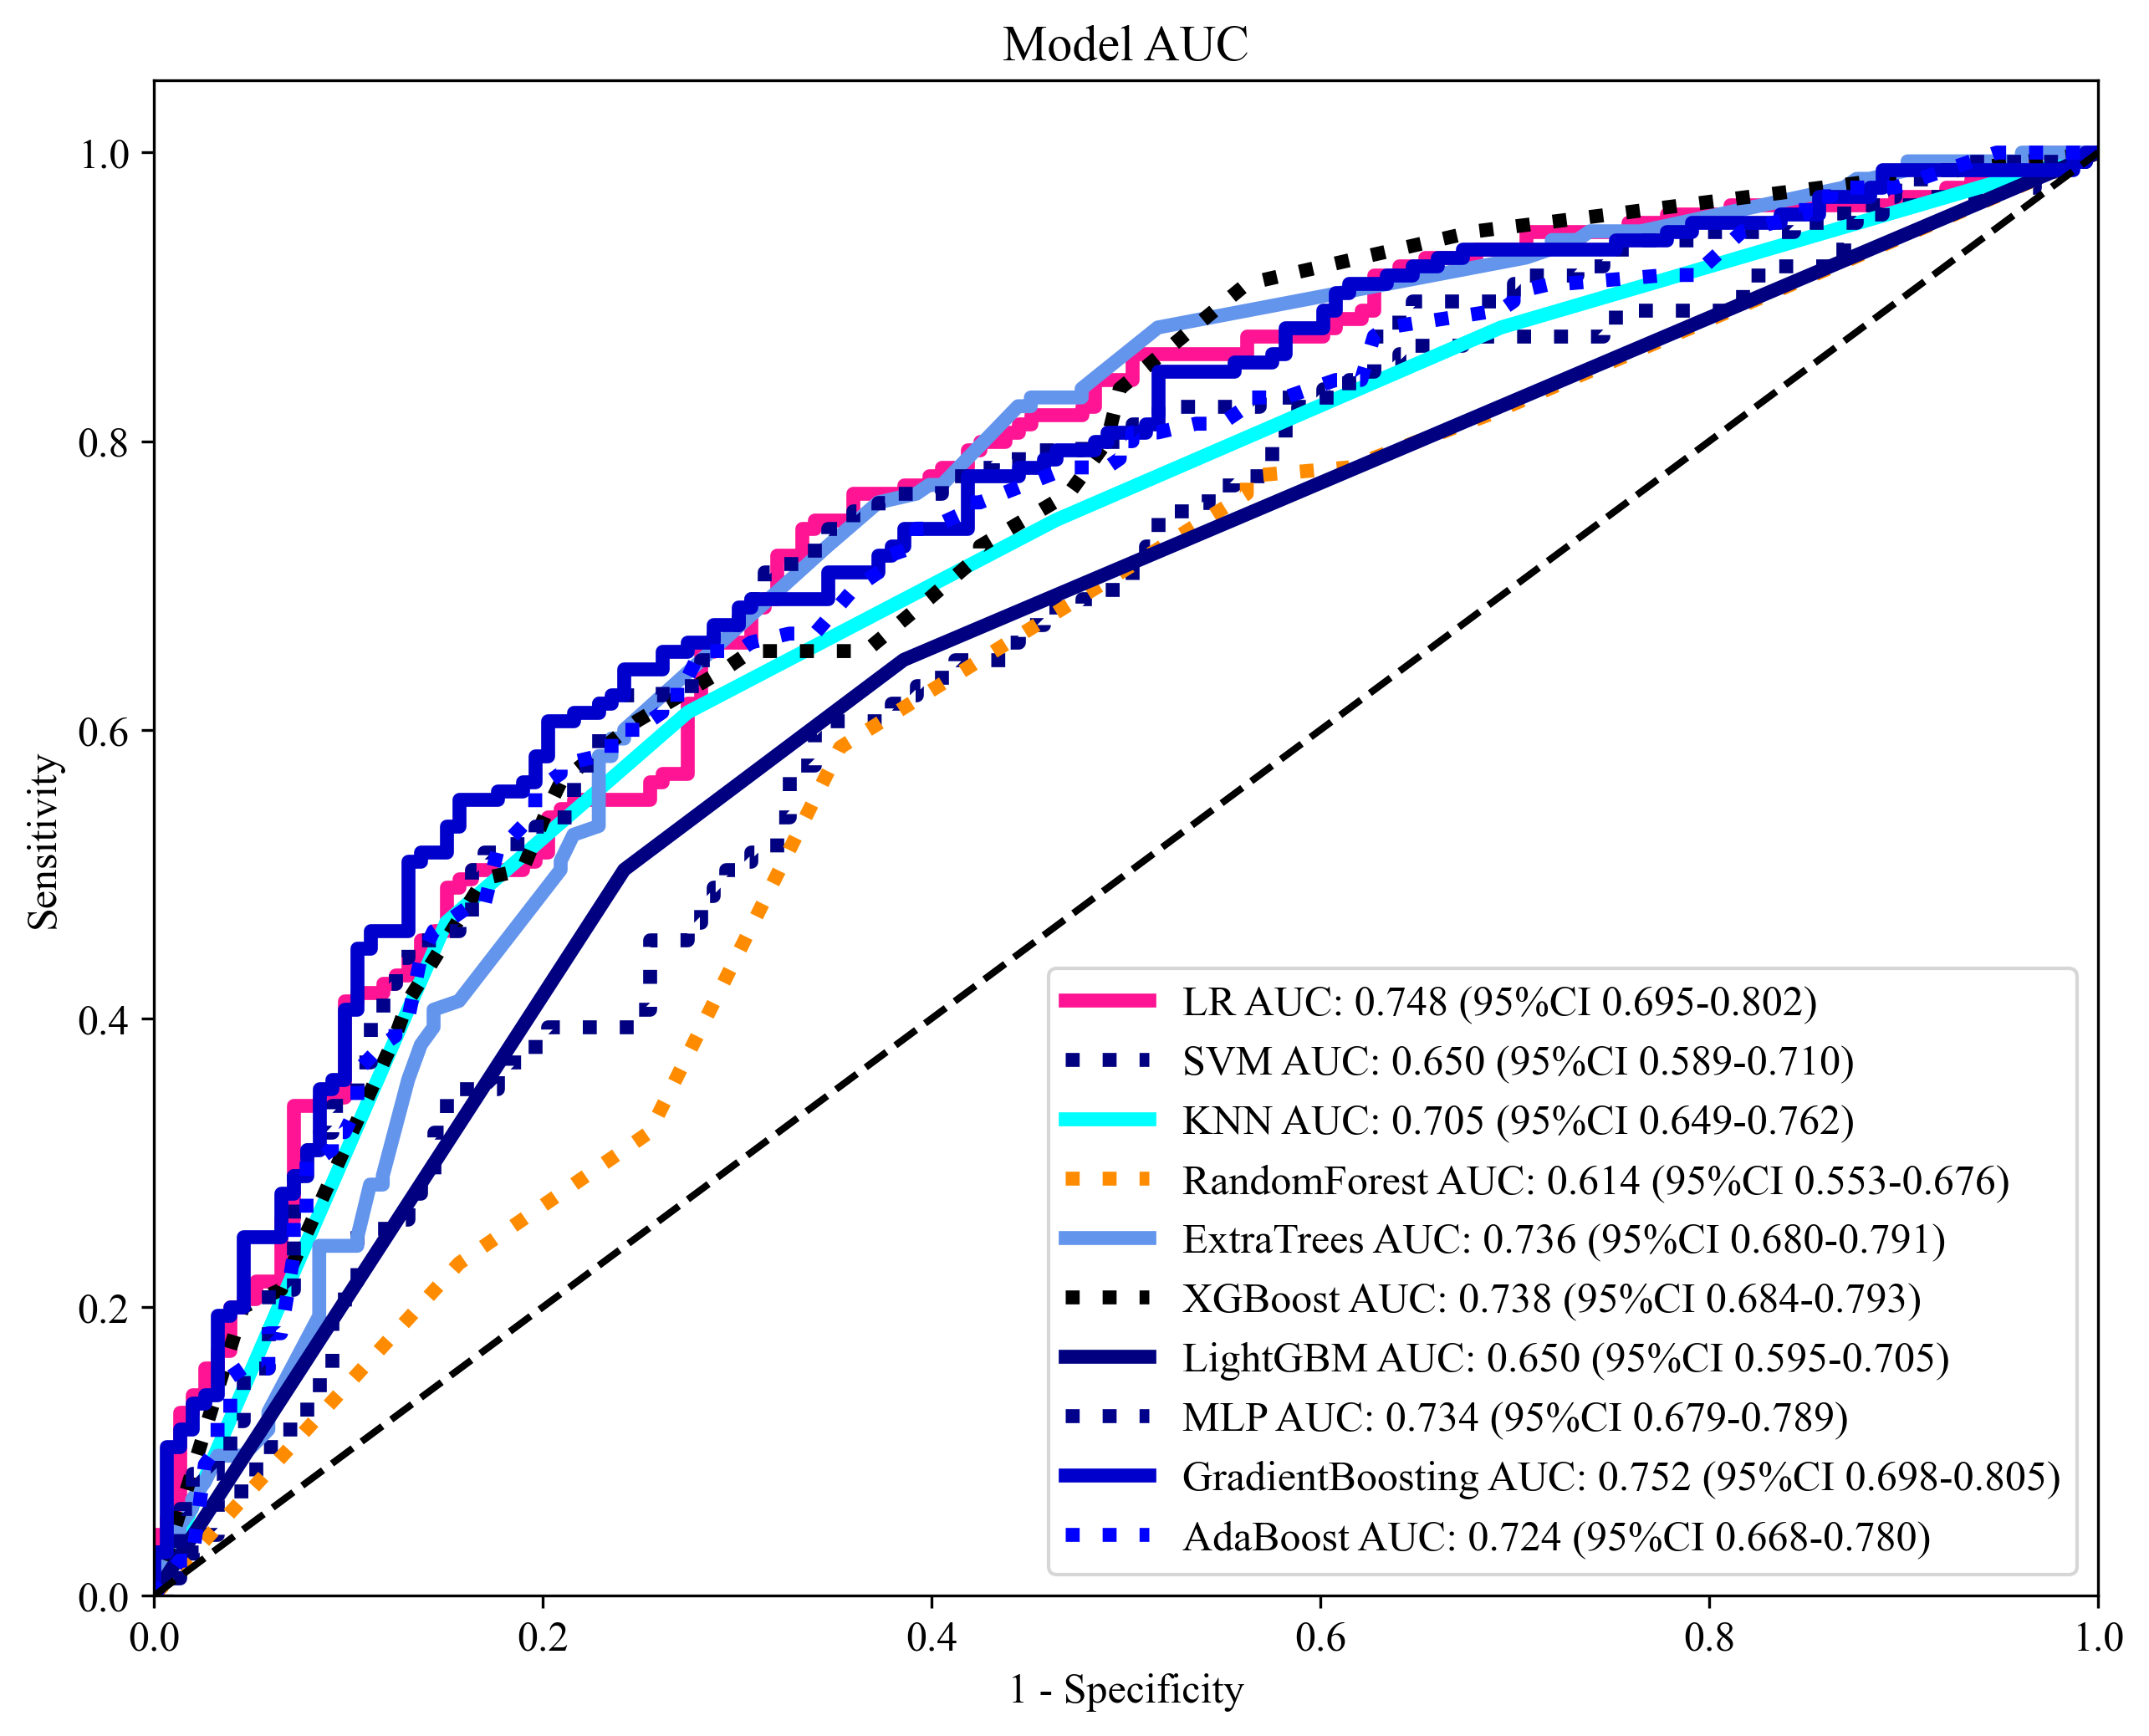

In [24]:
sel_model = model_names

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            pred_test_scores.append(pred_score[sel_model_idx][0])
    okcomp.comp1.draw_roc([np.array(y_train_sel[label])] * len(pred_test_scores), 
                          pred_test_scores, 
                          labels=sel_model, title=f"Model AUC")
    plt.savefig(f'img/{task_type}_model_roc_train.svg', bbox_inches = 'tight')
    plt.show()

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            pred_test_scores.append(pred_score[sel_model_idx][1])
    okcomp.comp1.draw_roc([np.array(y_test_sel[label])] * len(pred_test_scores), 
                          pred_test_scores, 
                          labels=sel_model, title=f"Model AUC")
    plt.savefig(f'img/{task_type}_model_roc_test.svg', bbox_inches = 'tight')

### DCA 决策曲线

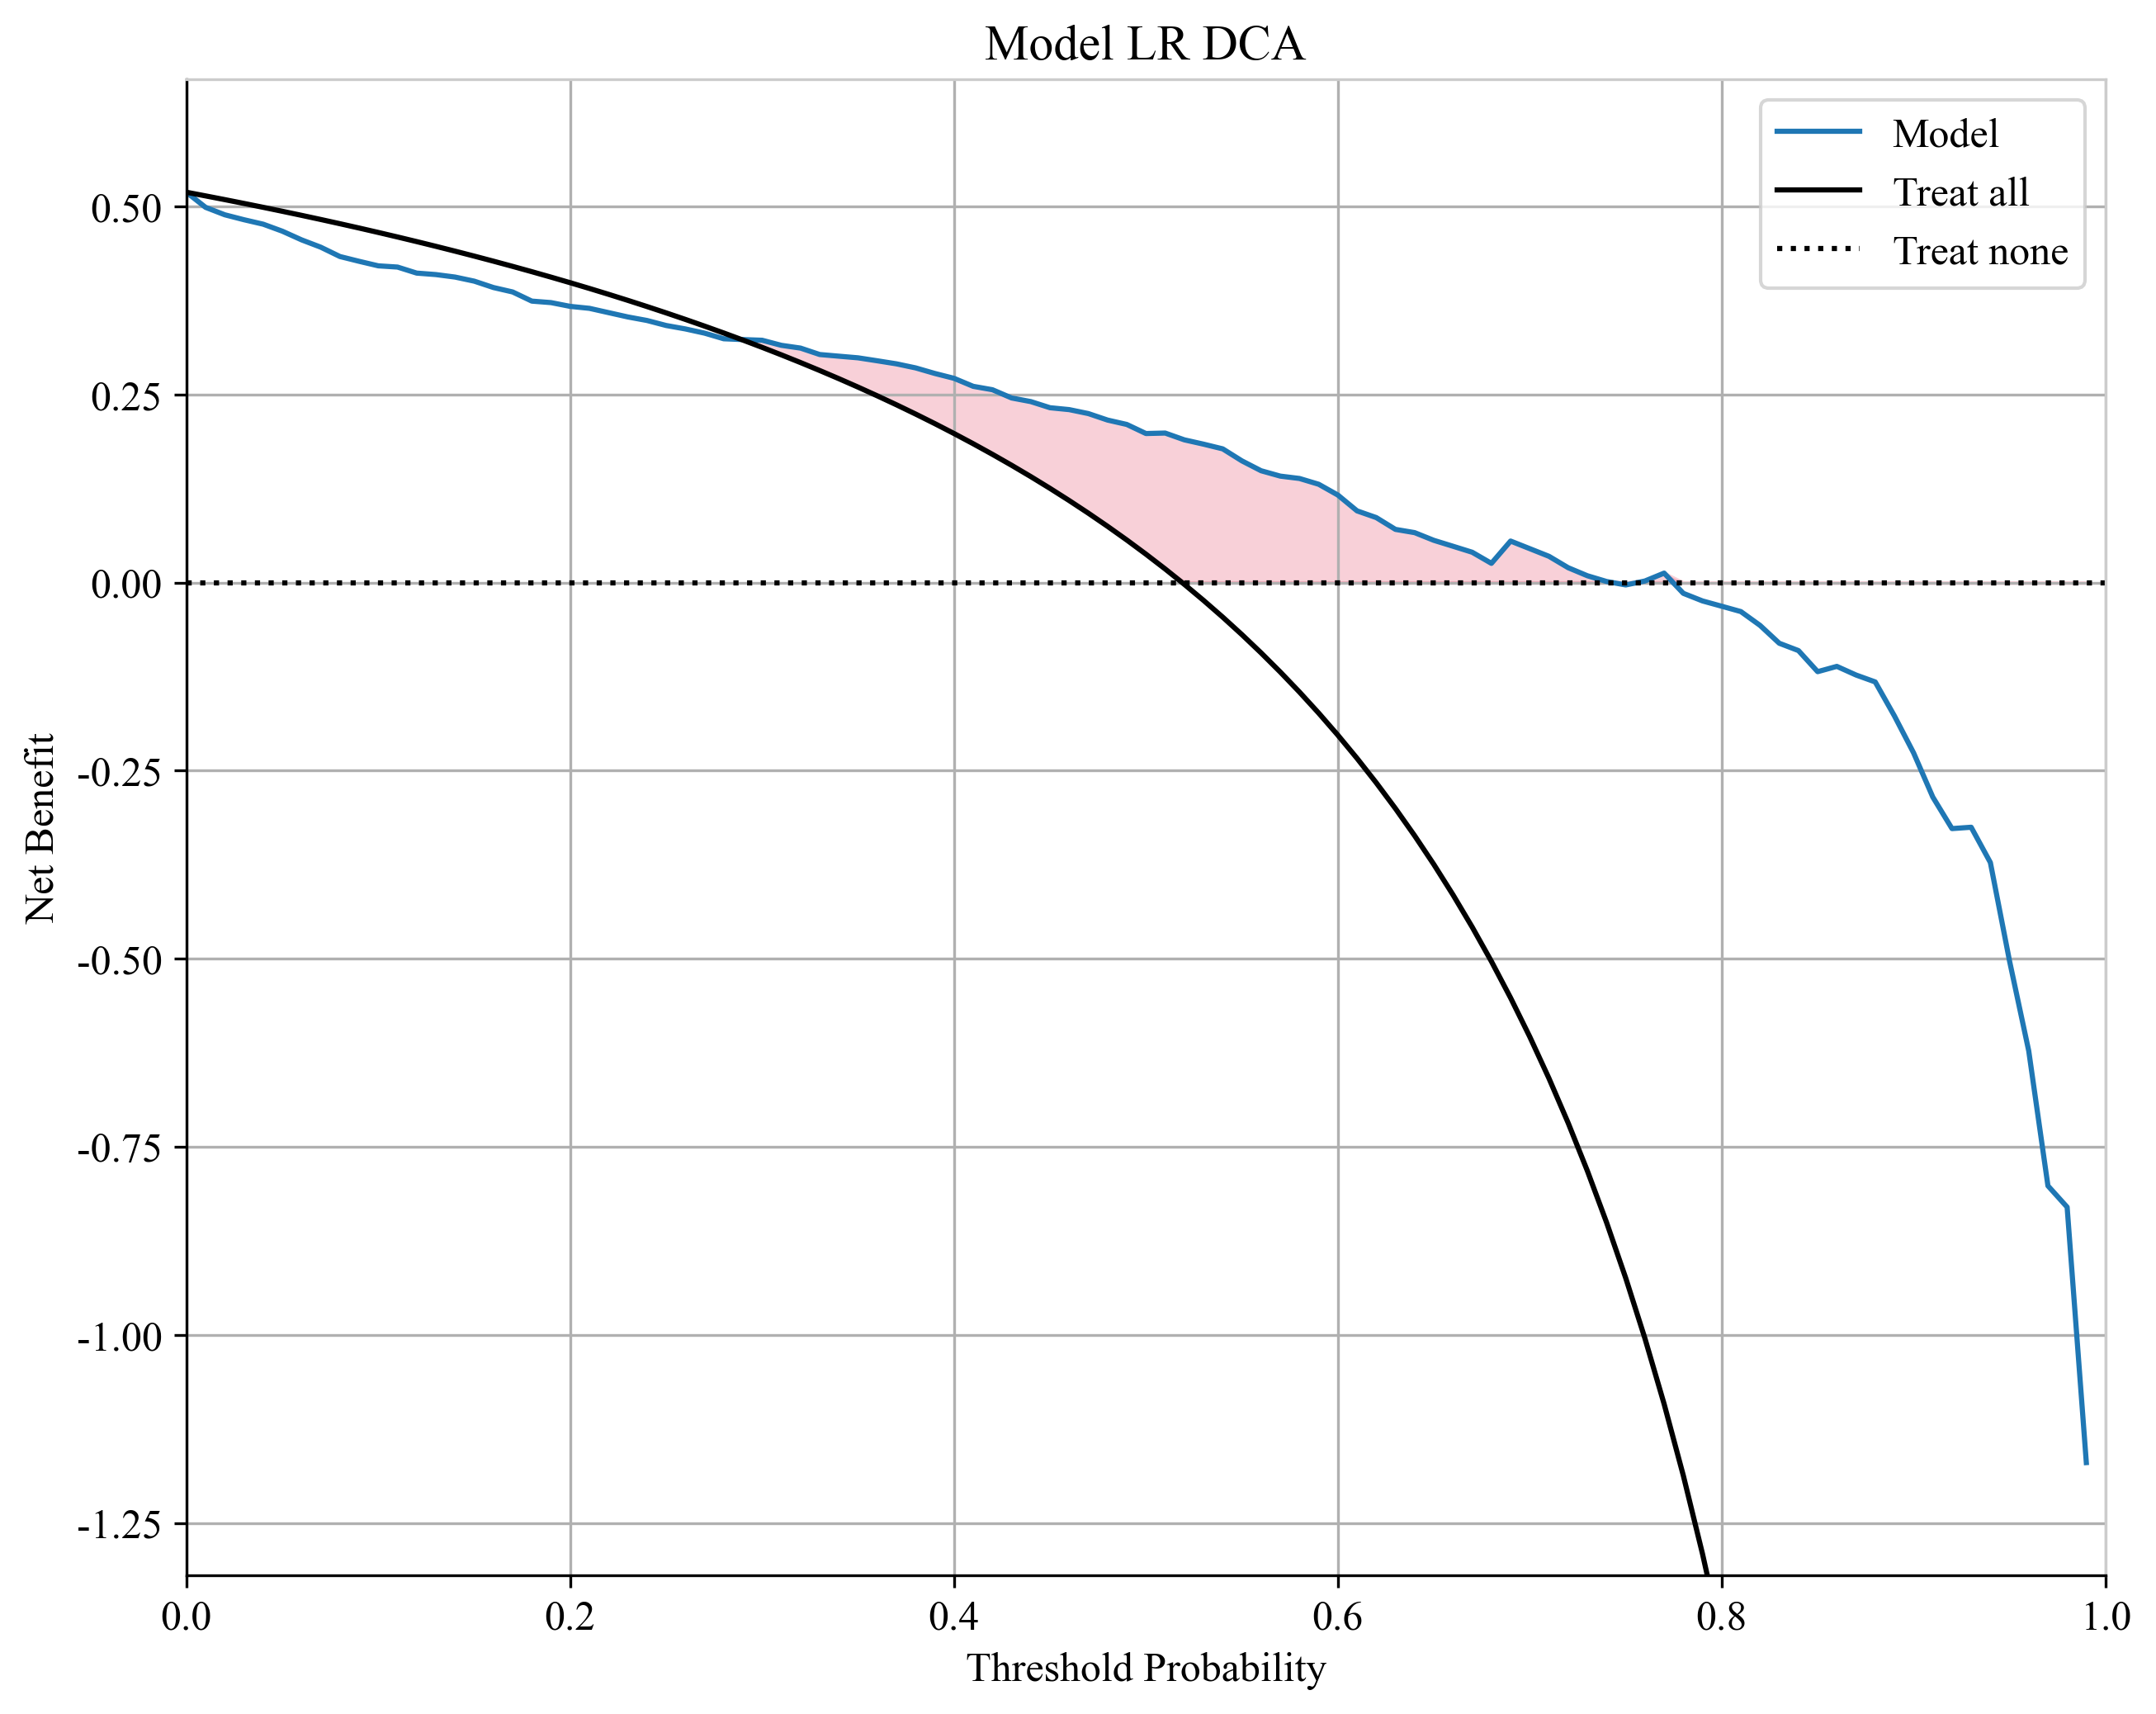

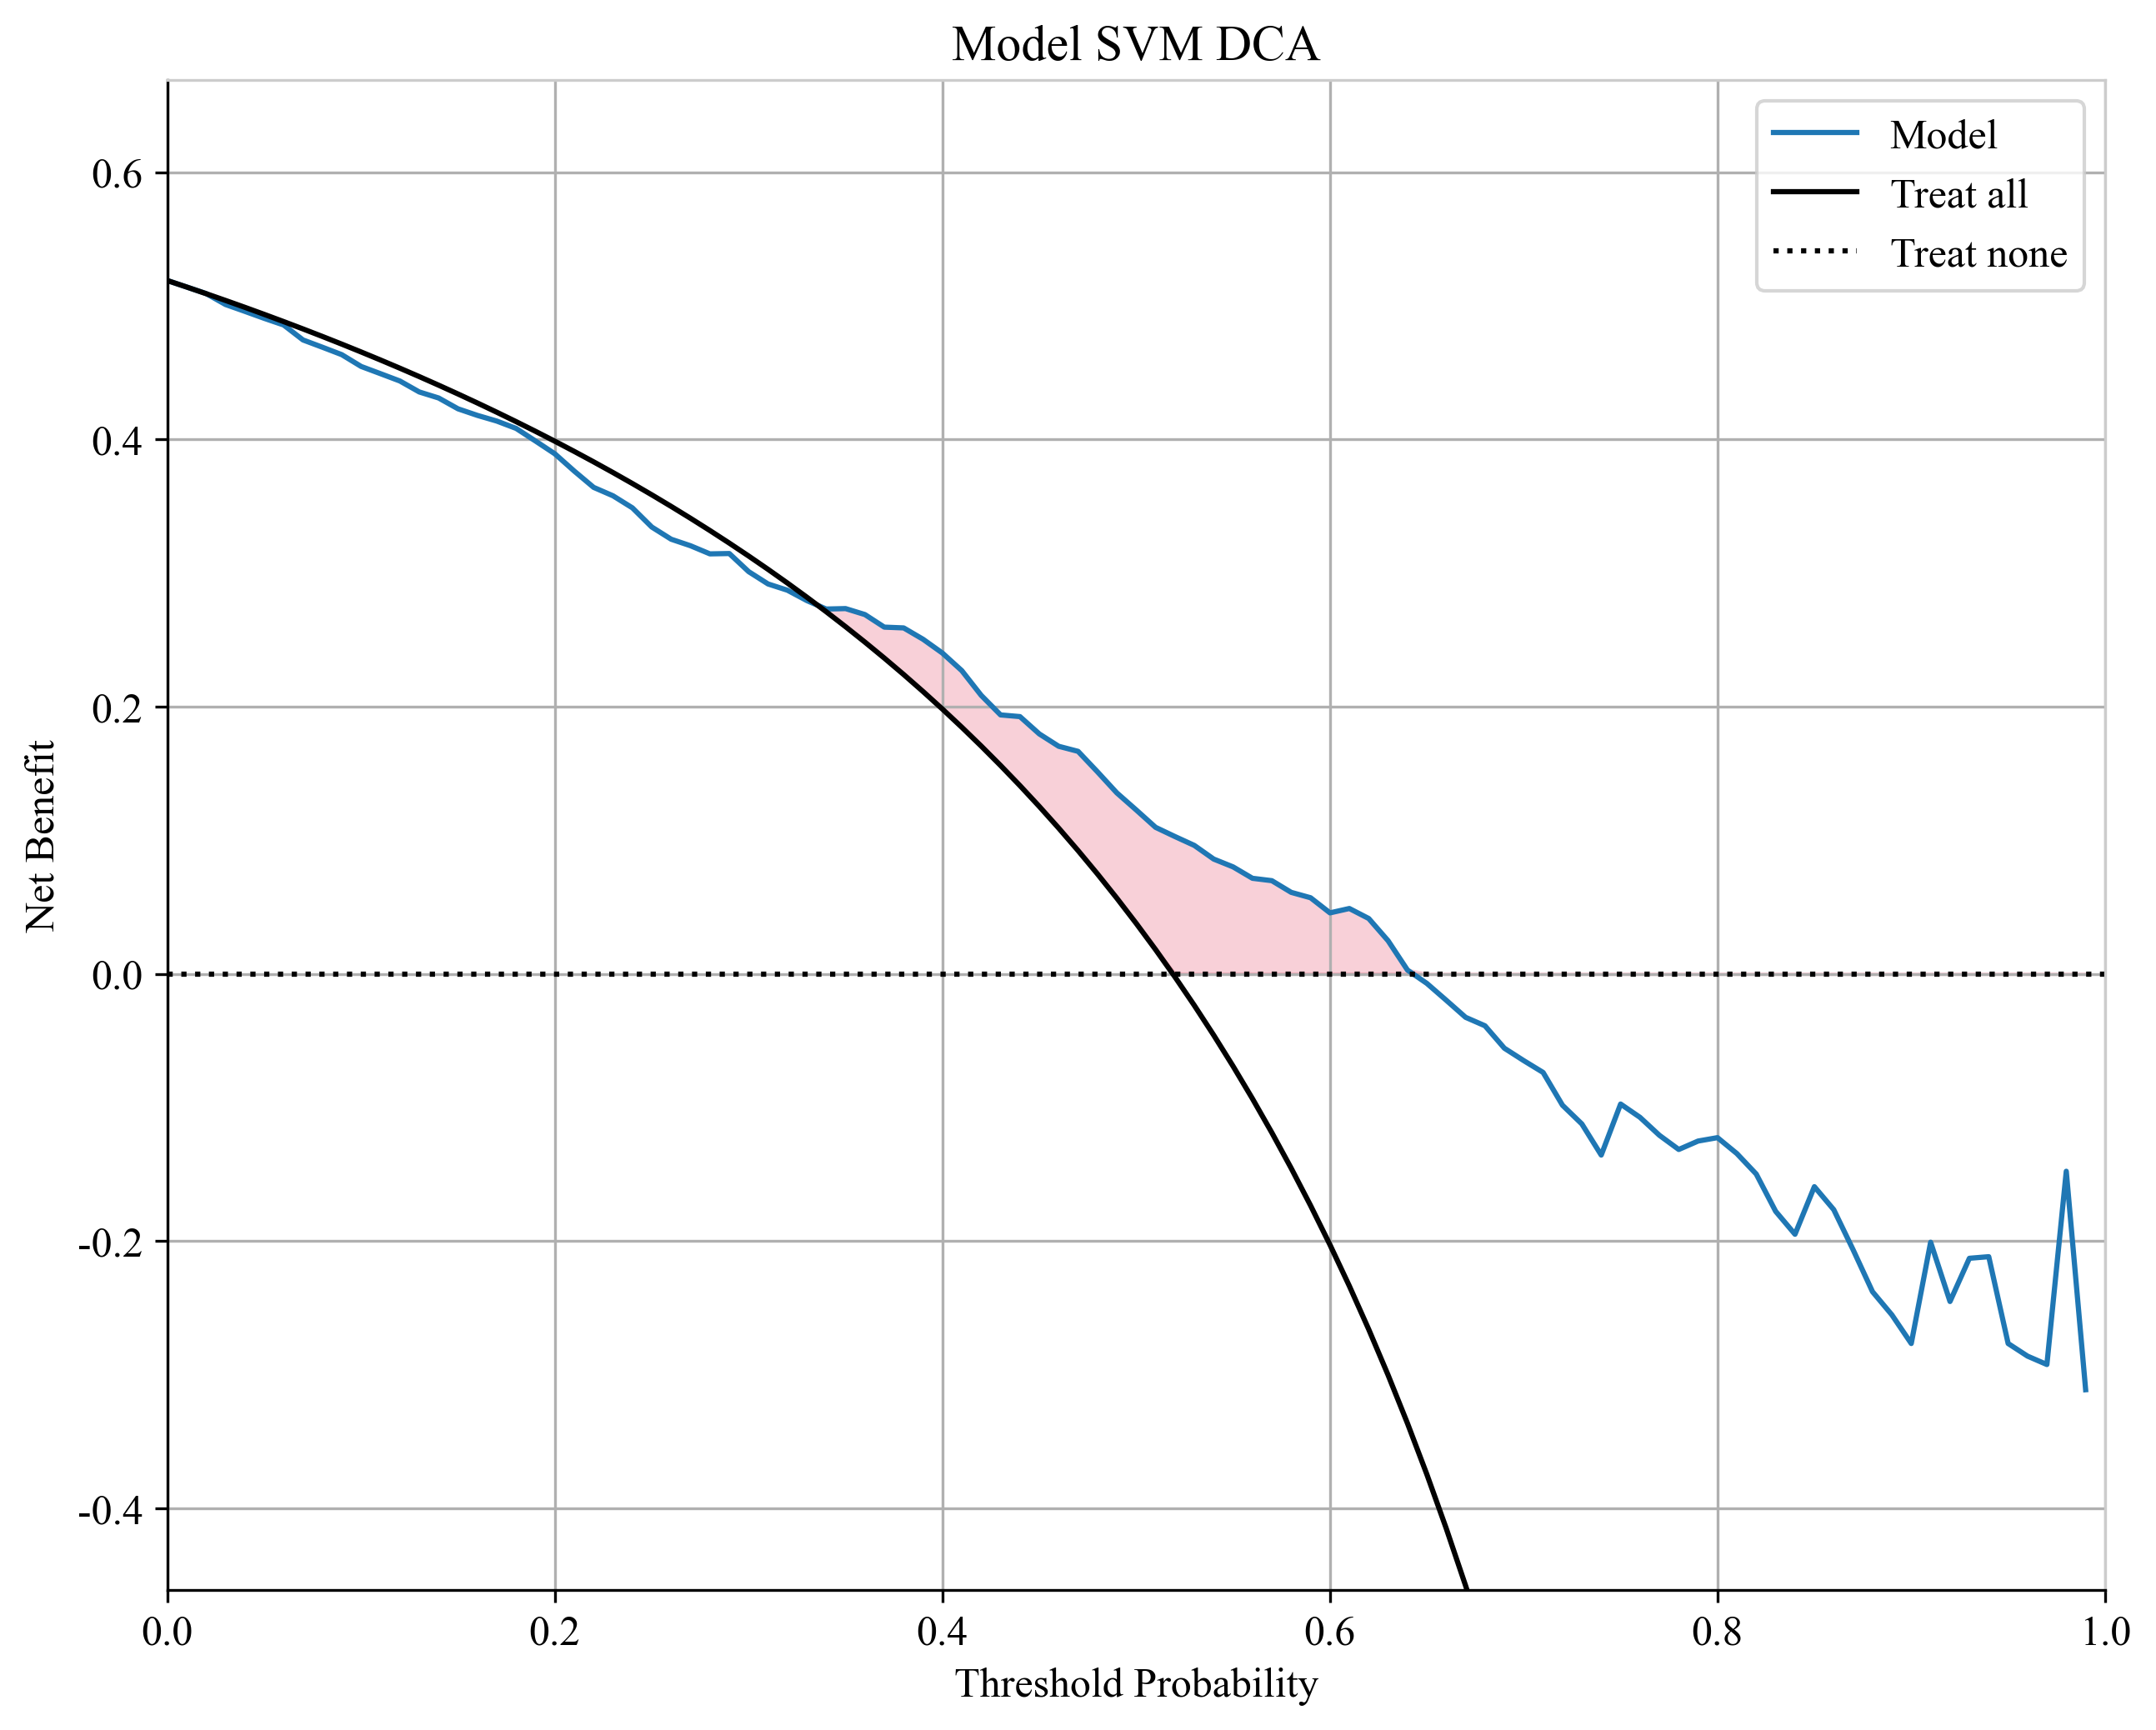

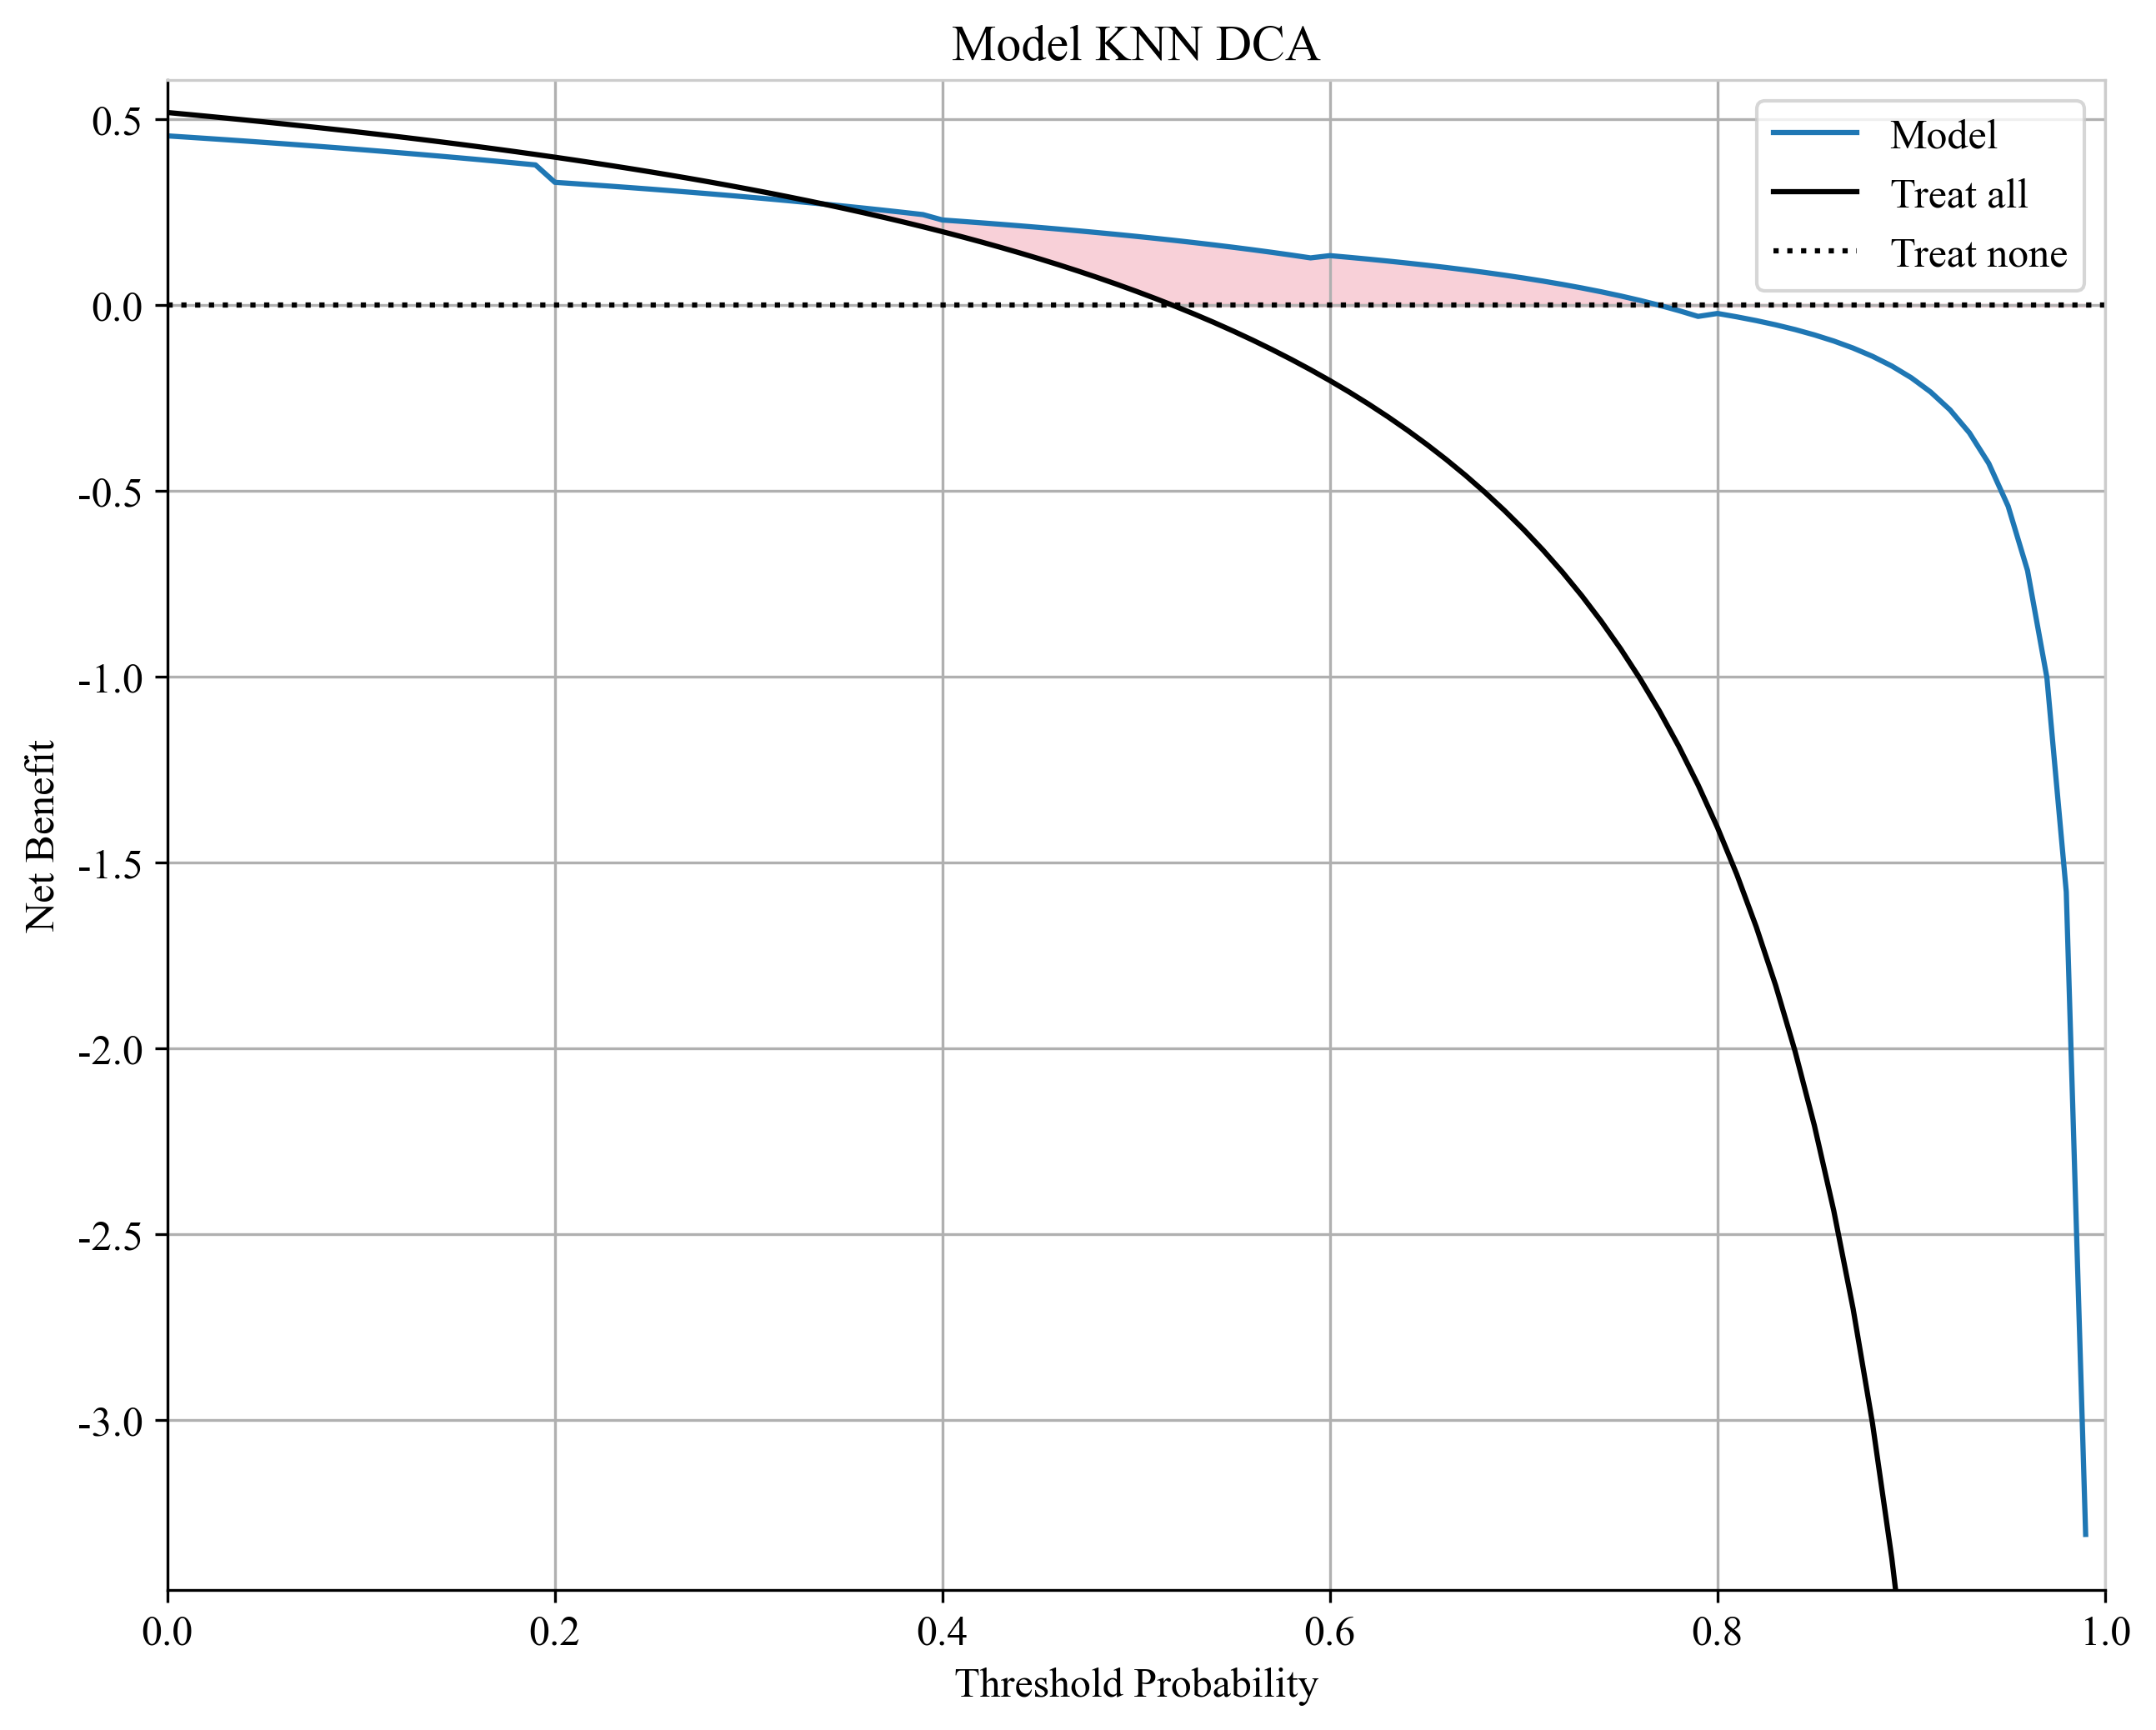

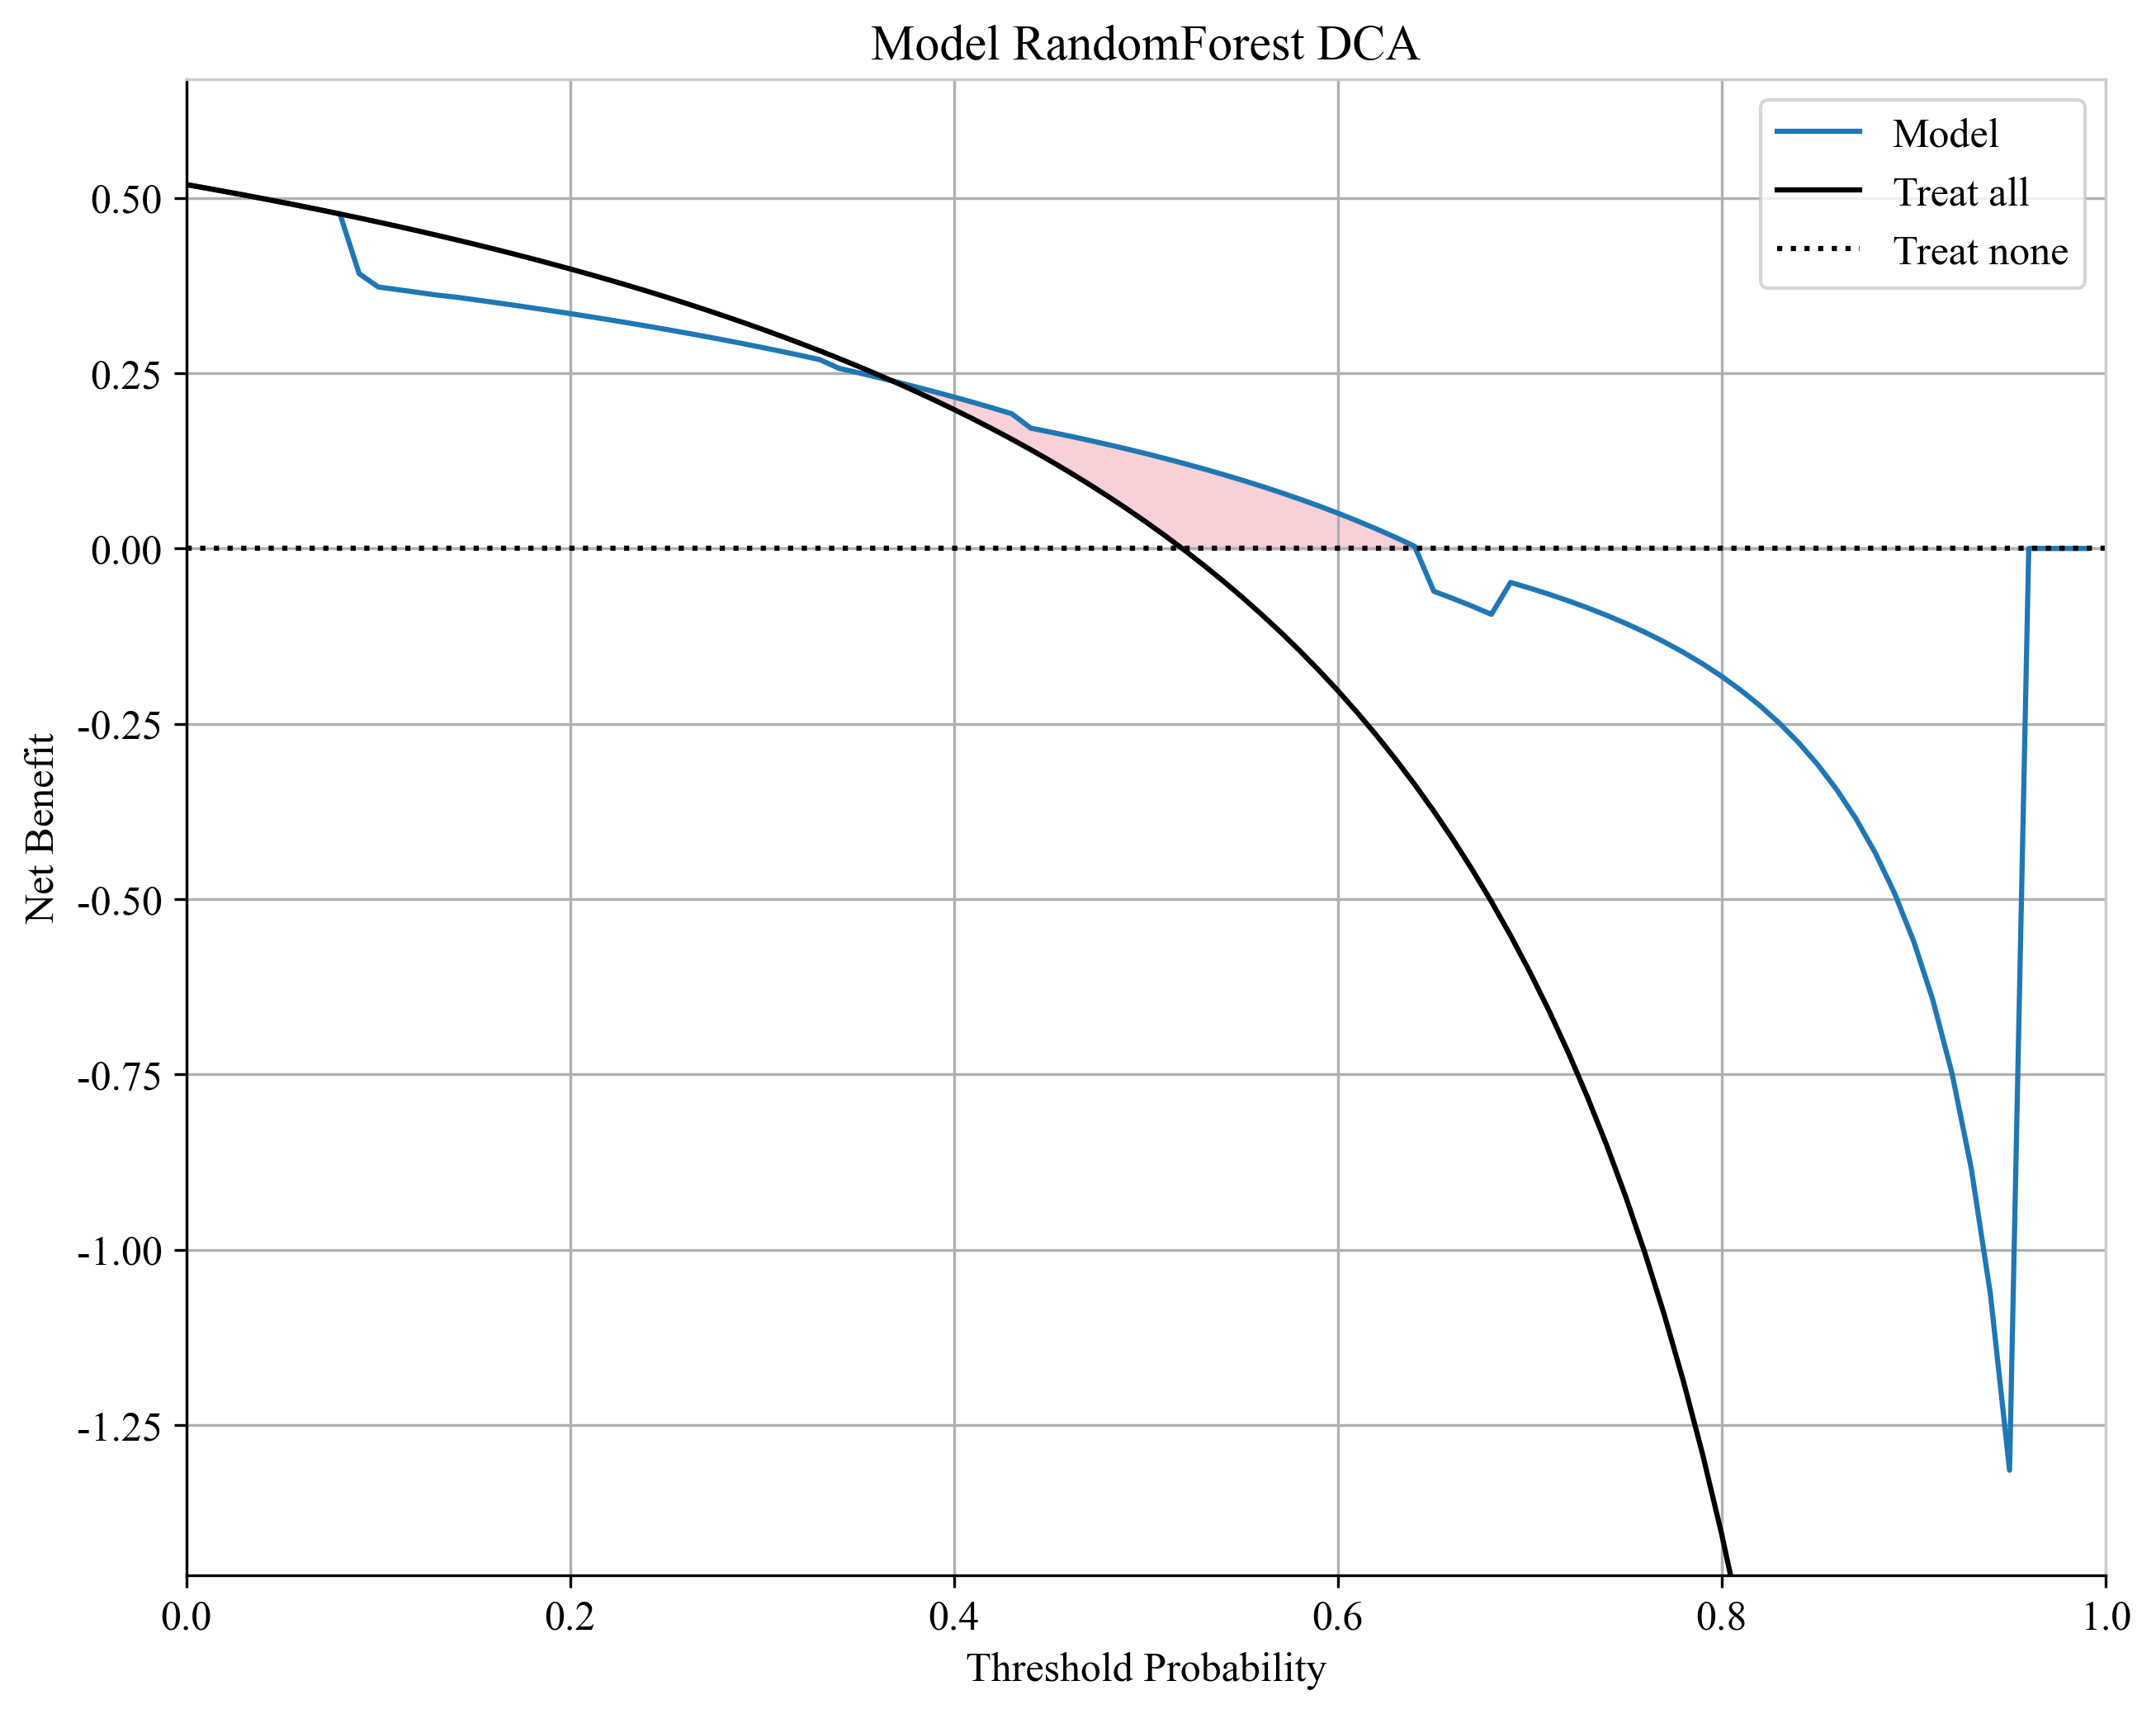

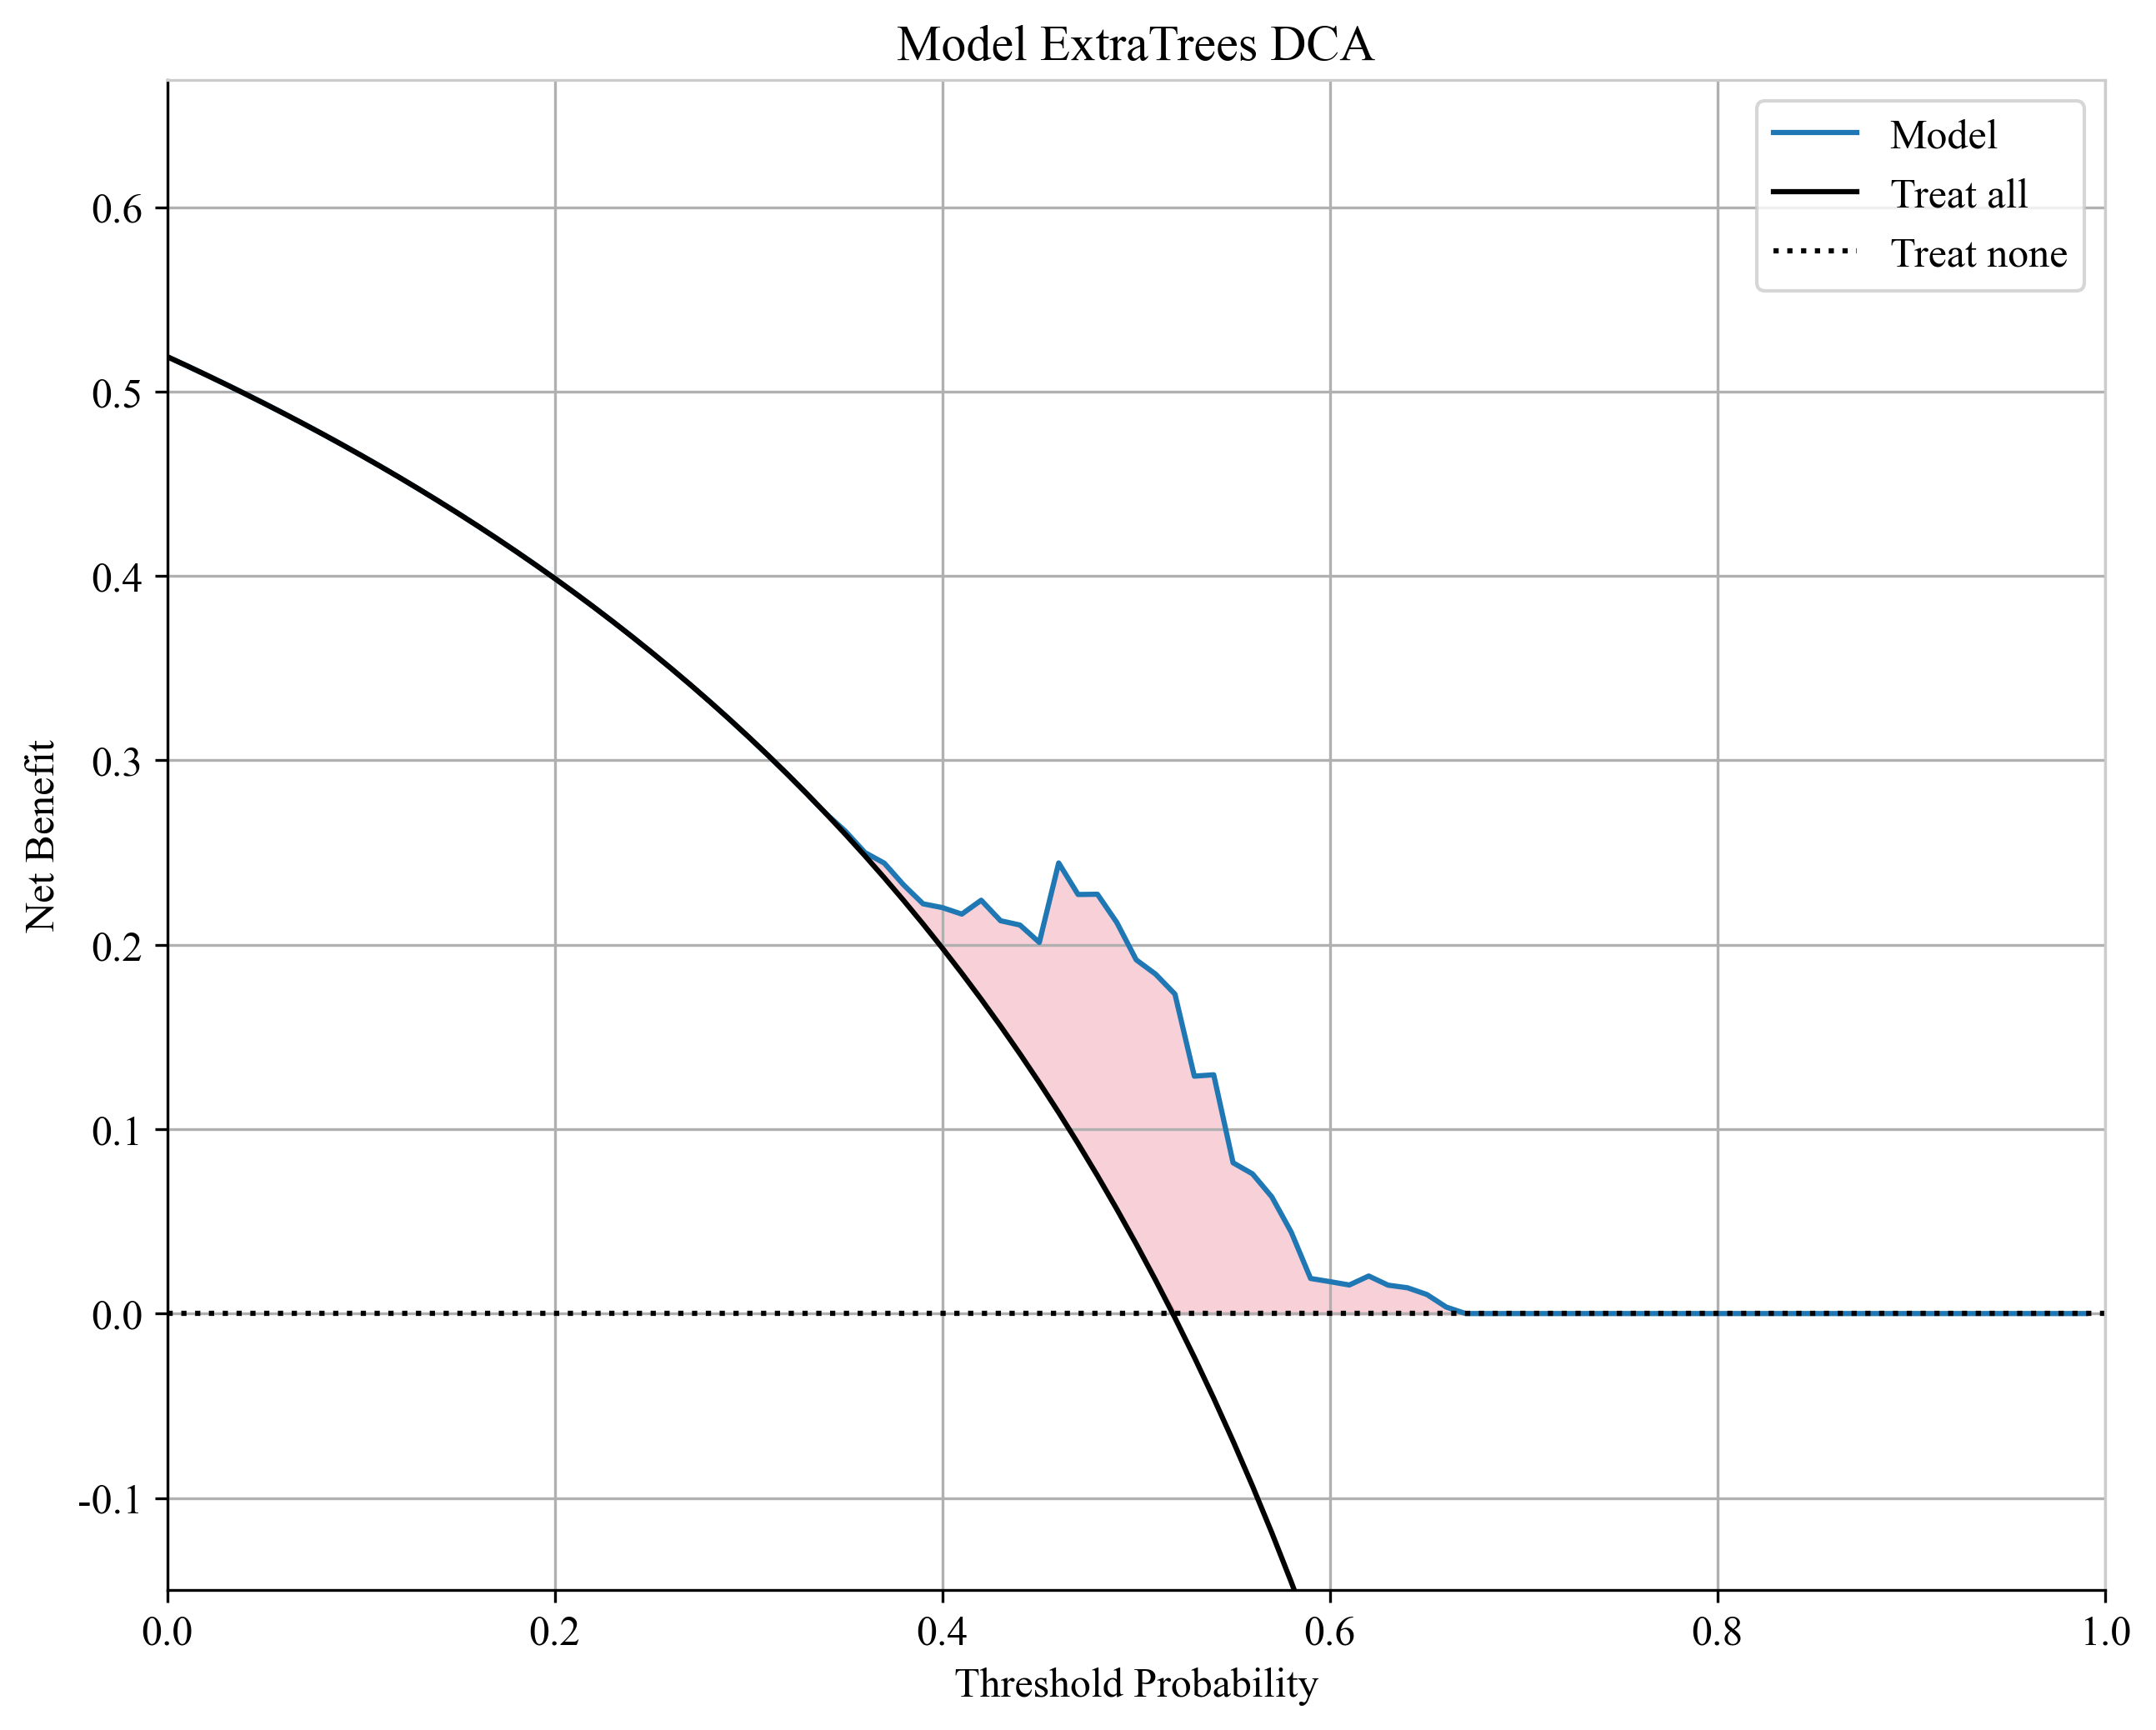

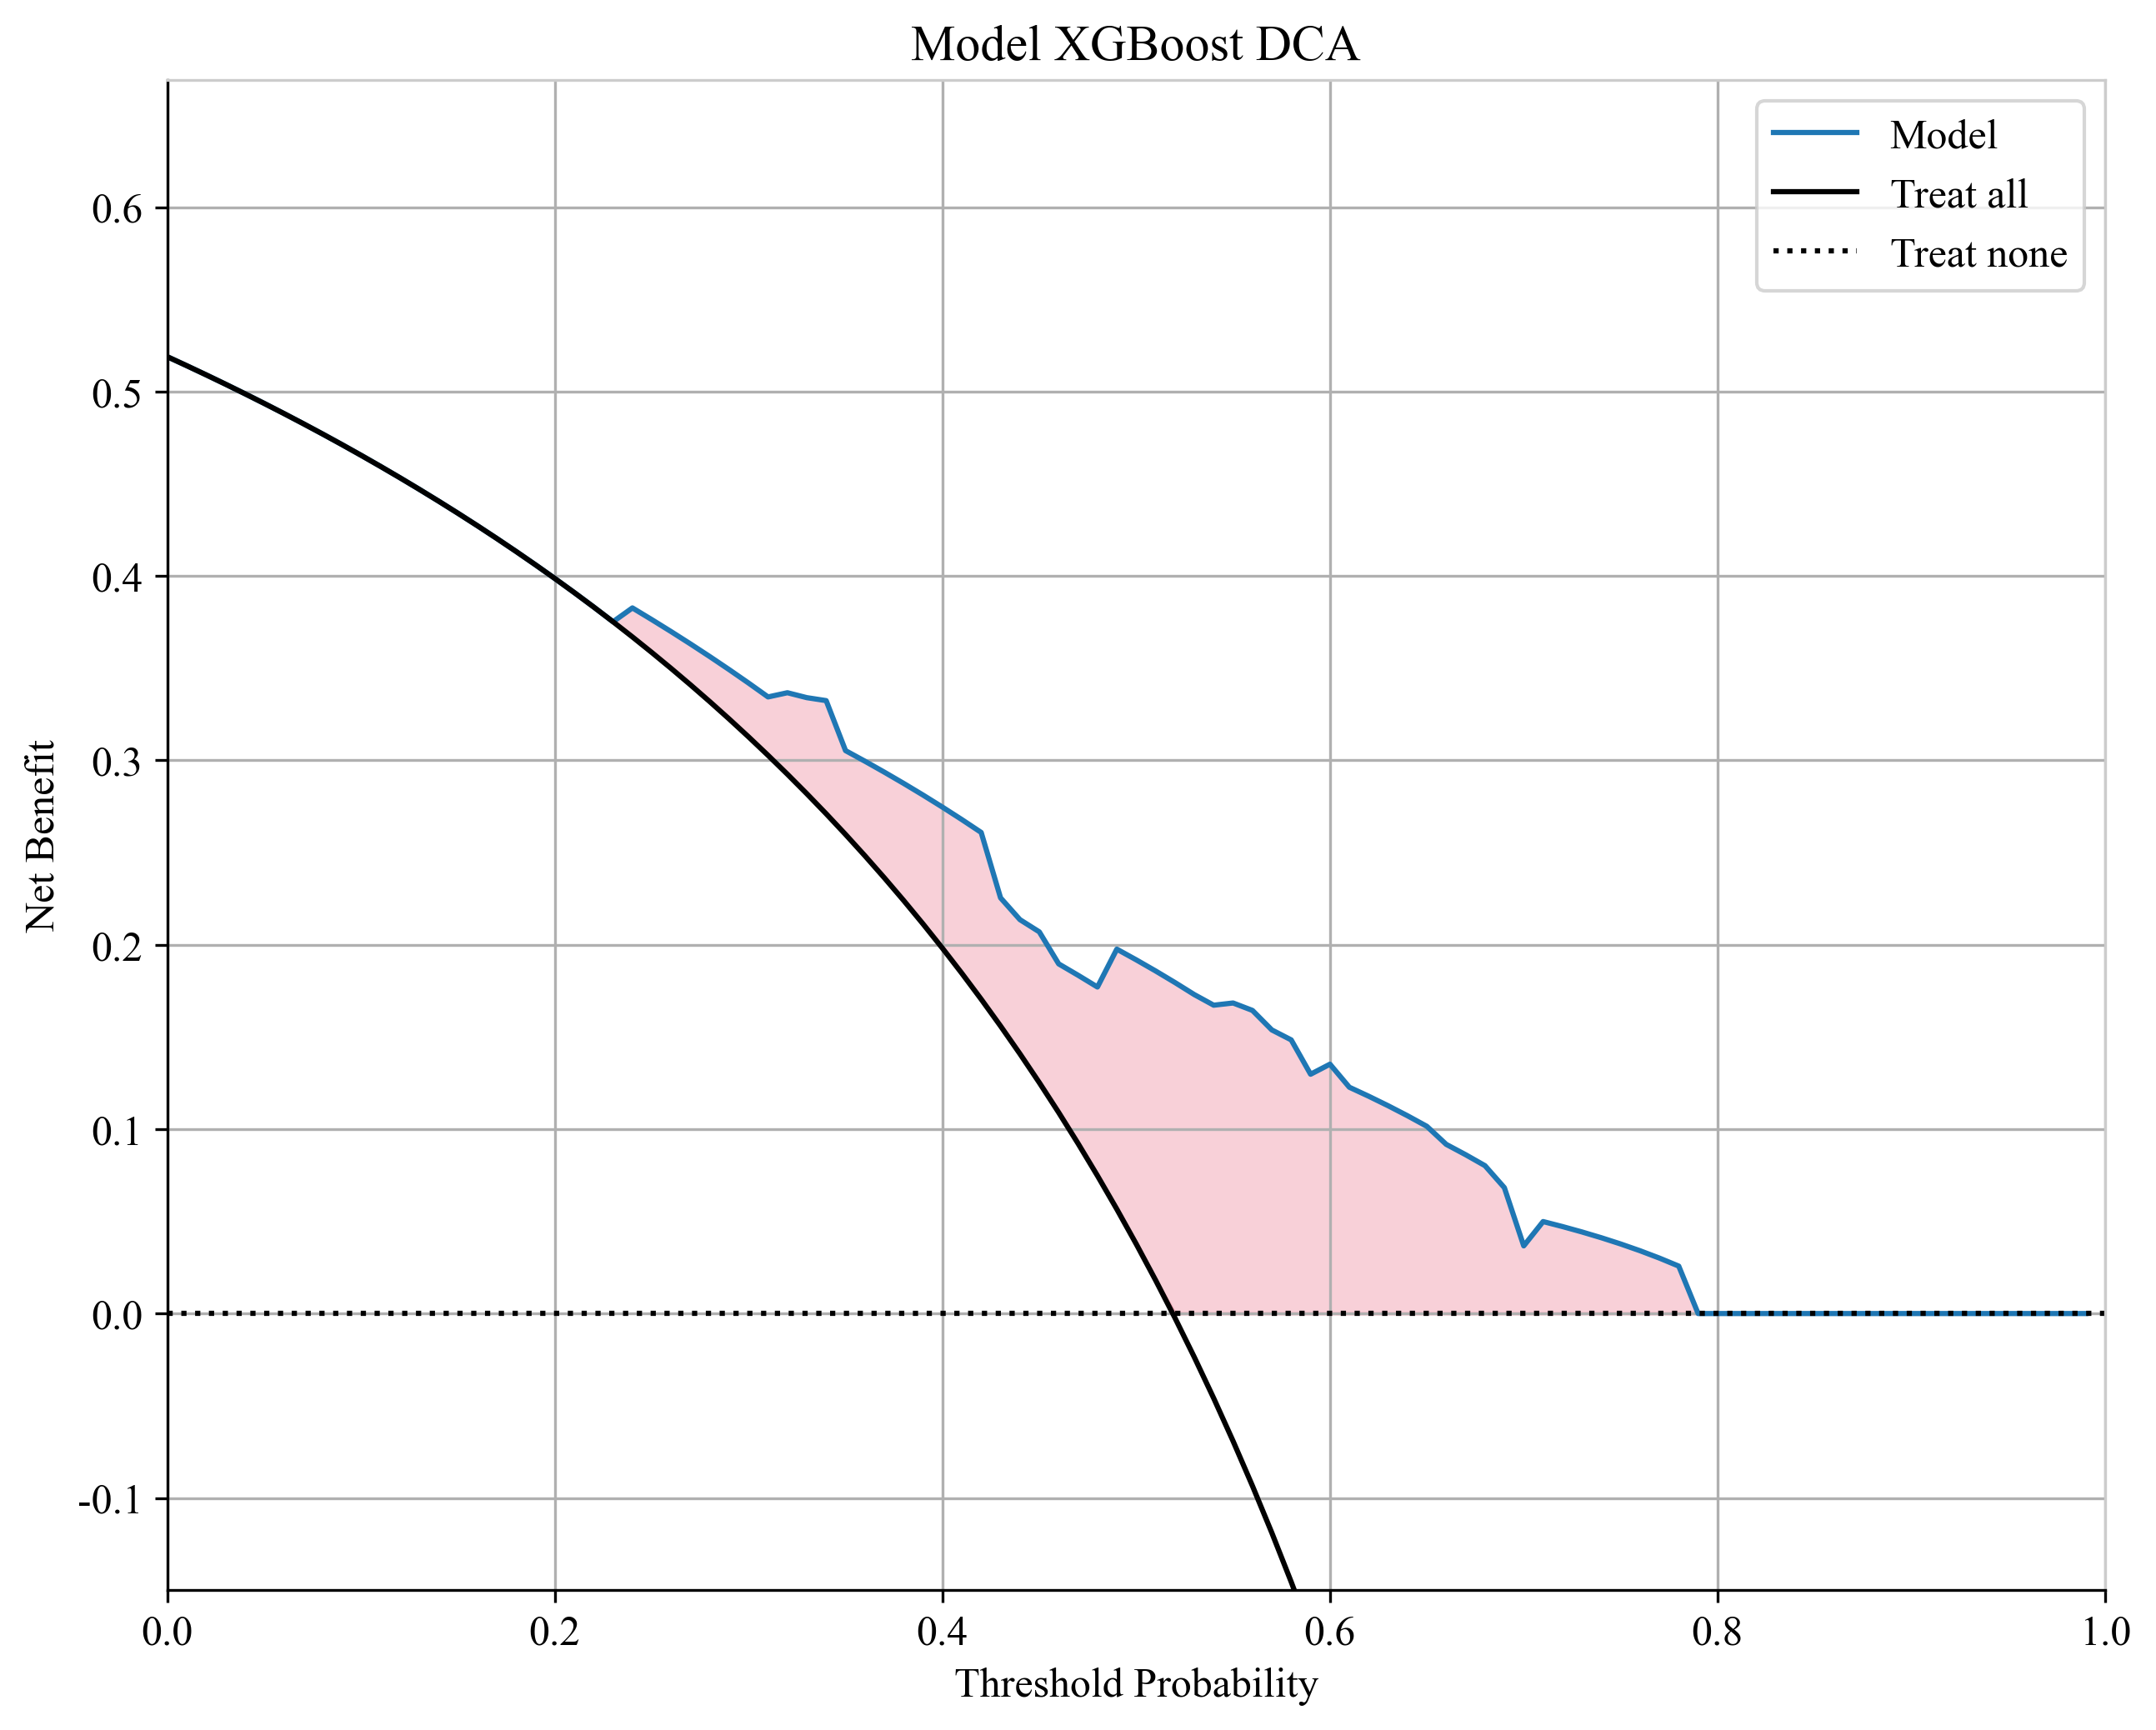

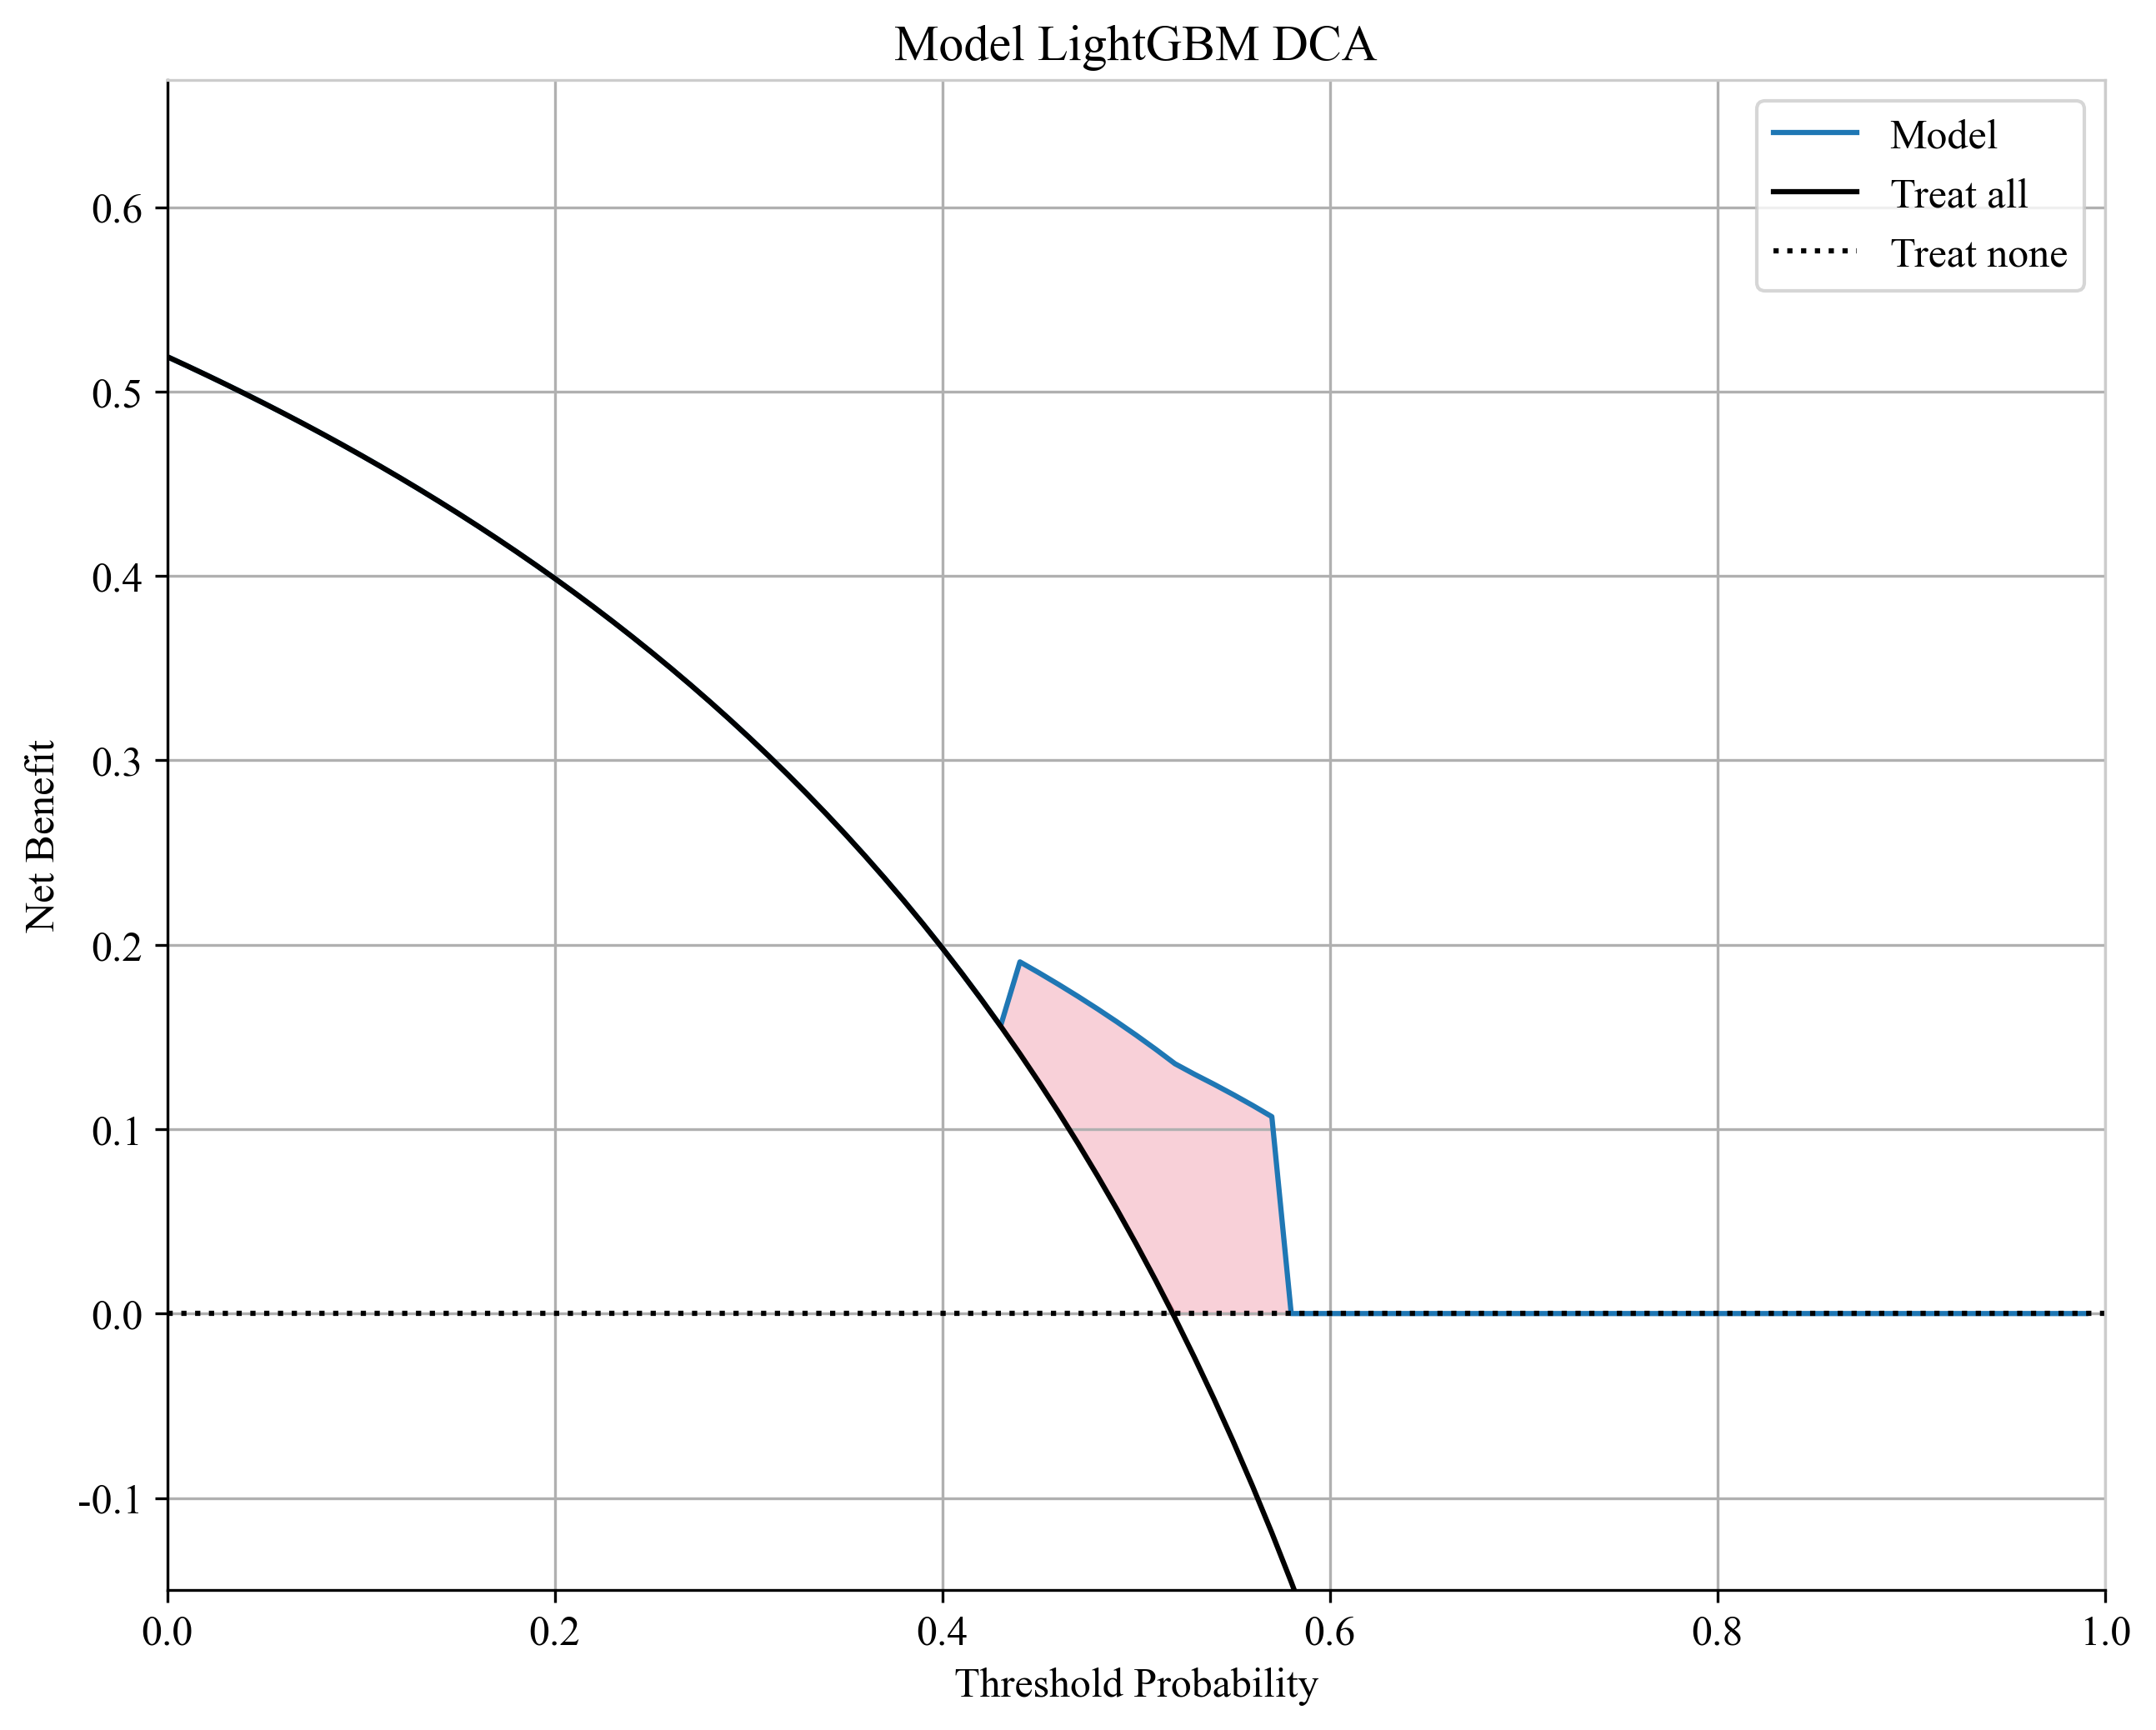

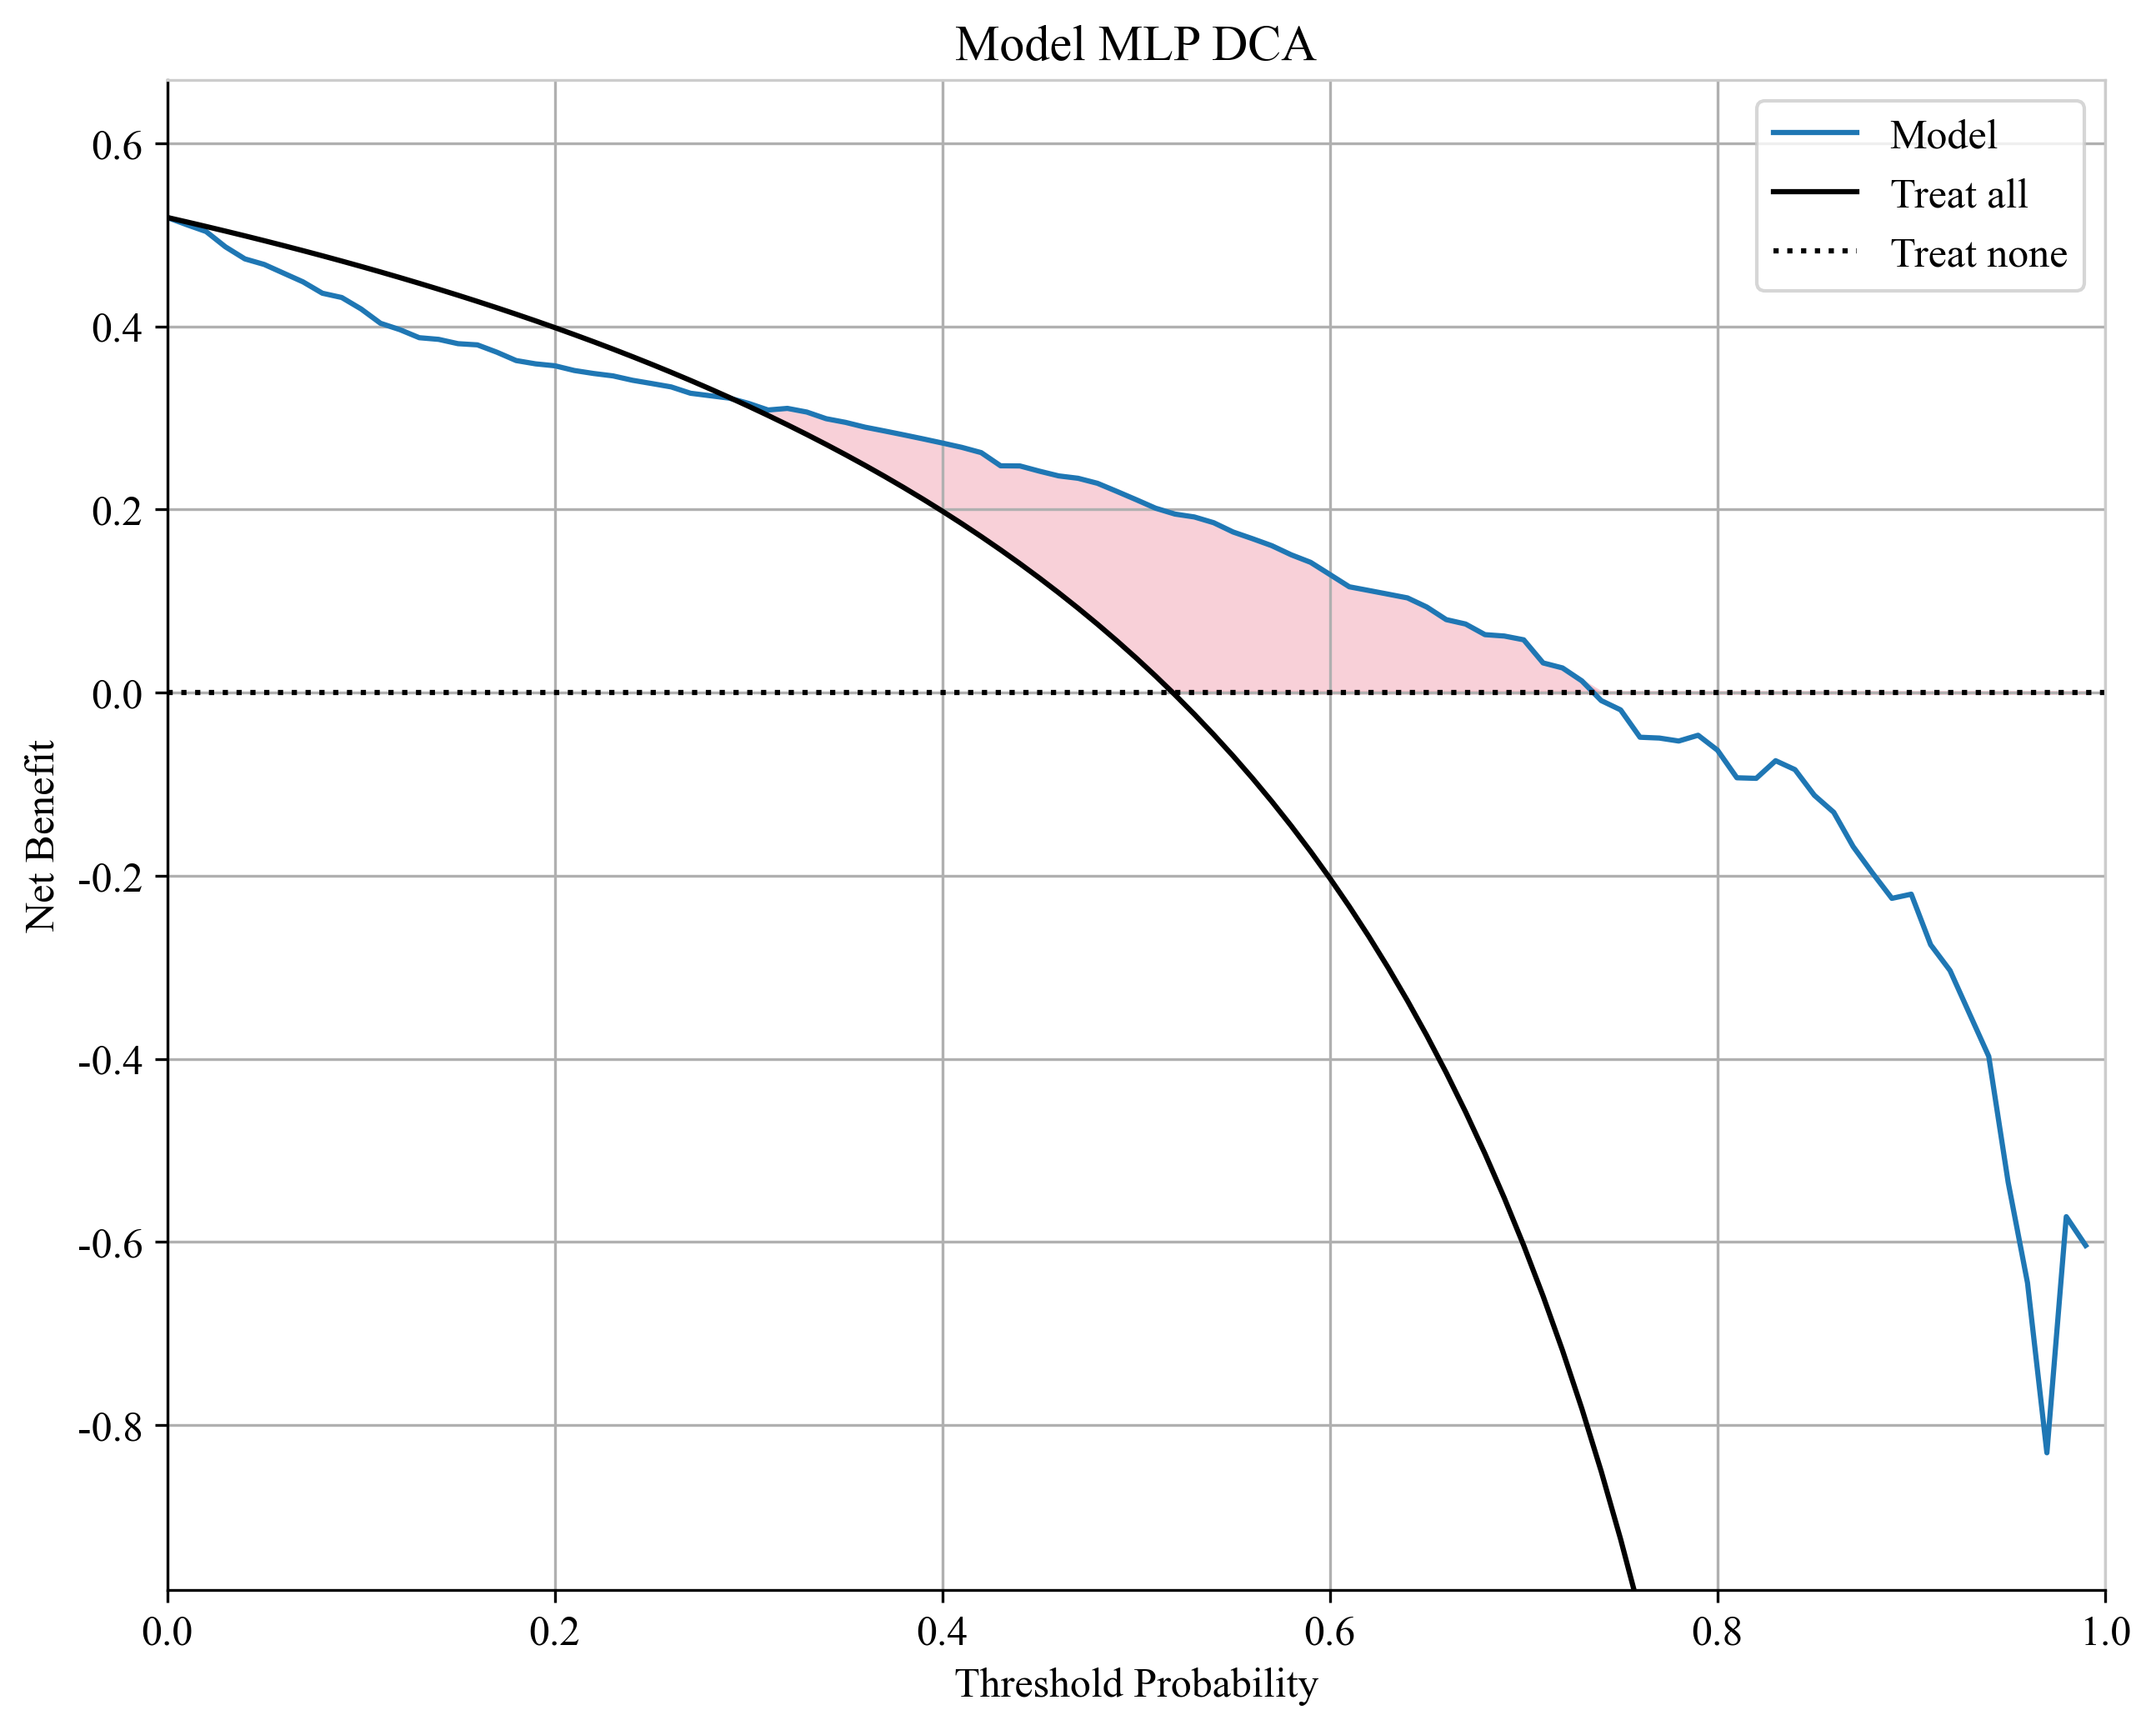

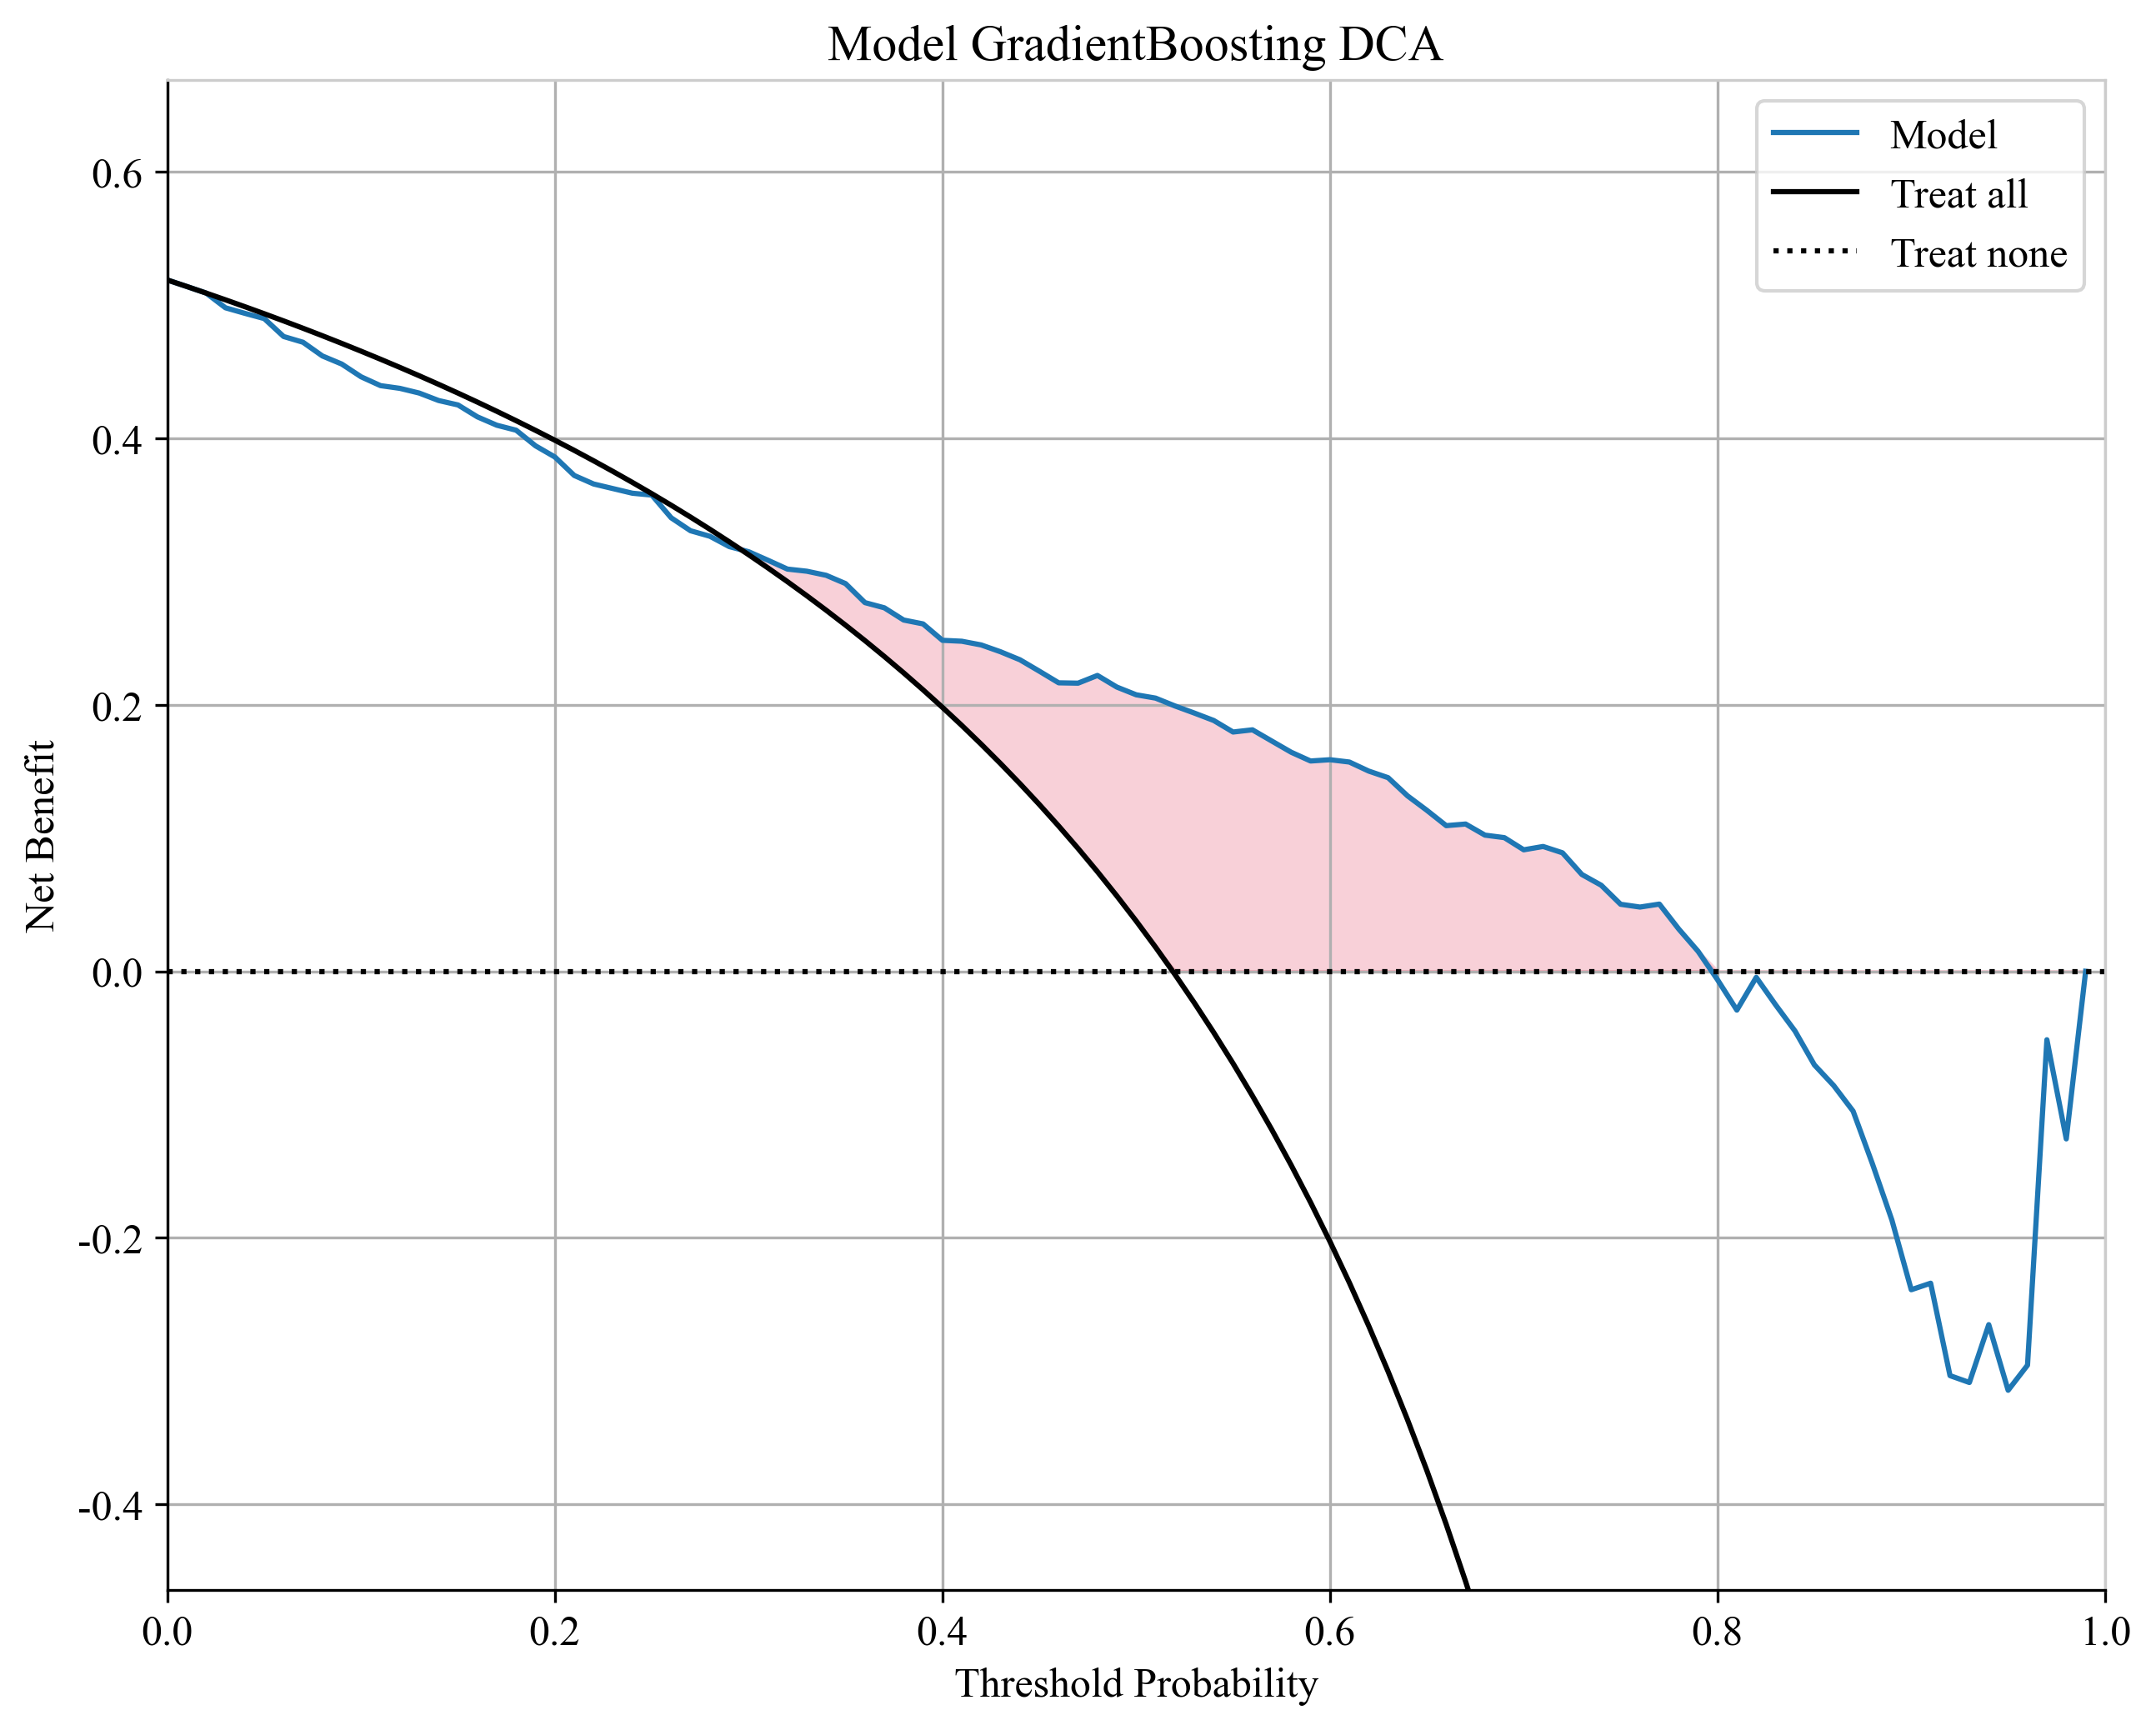

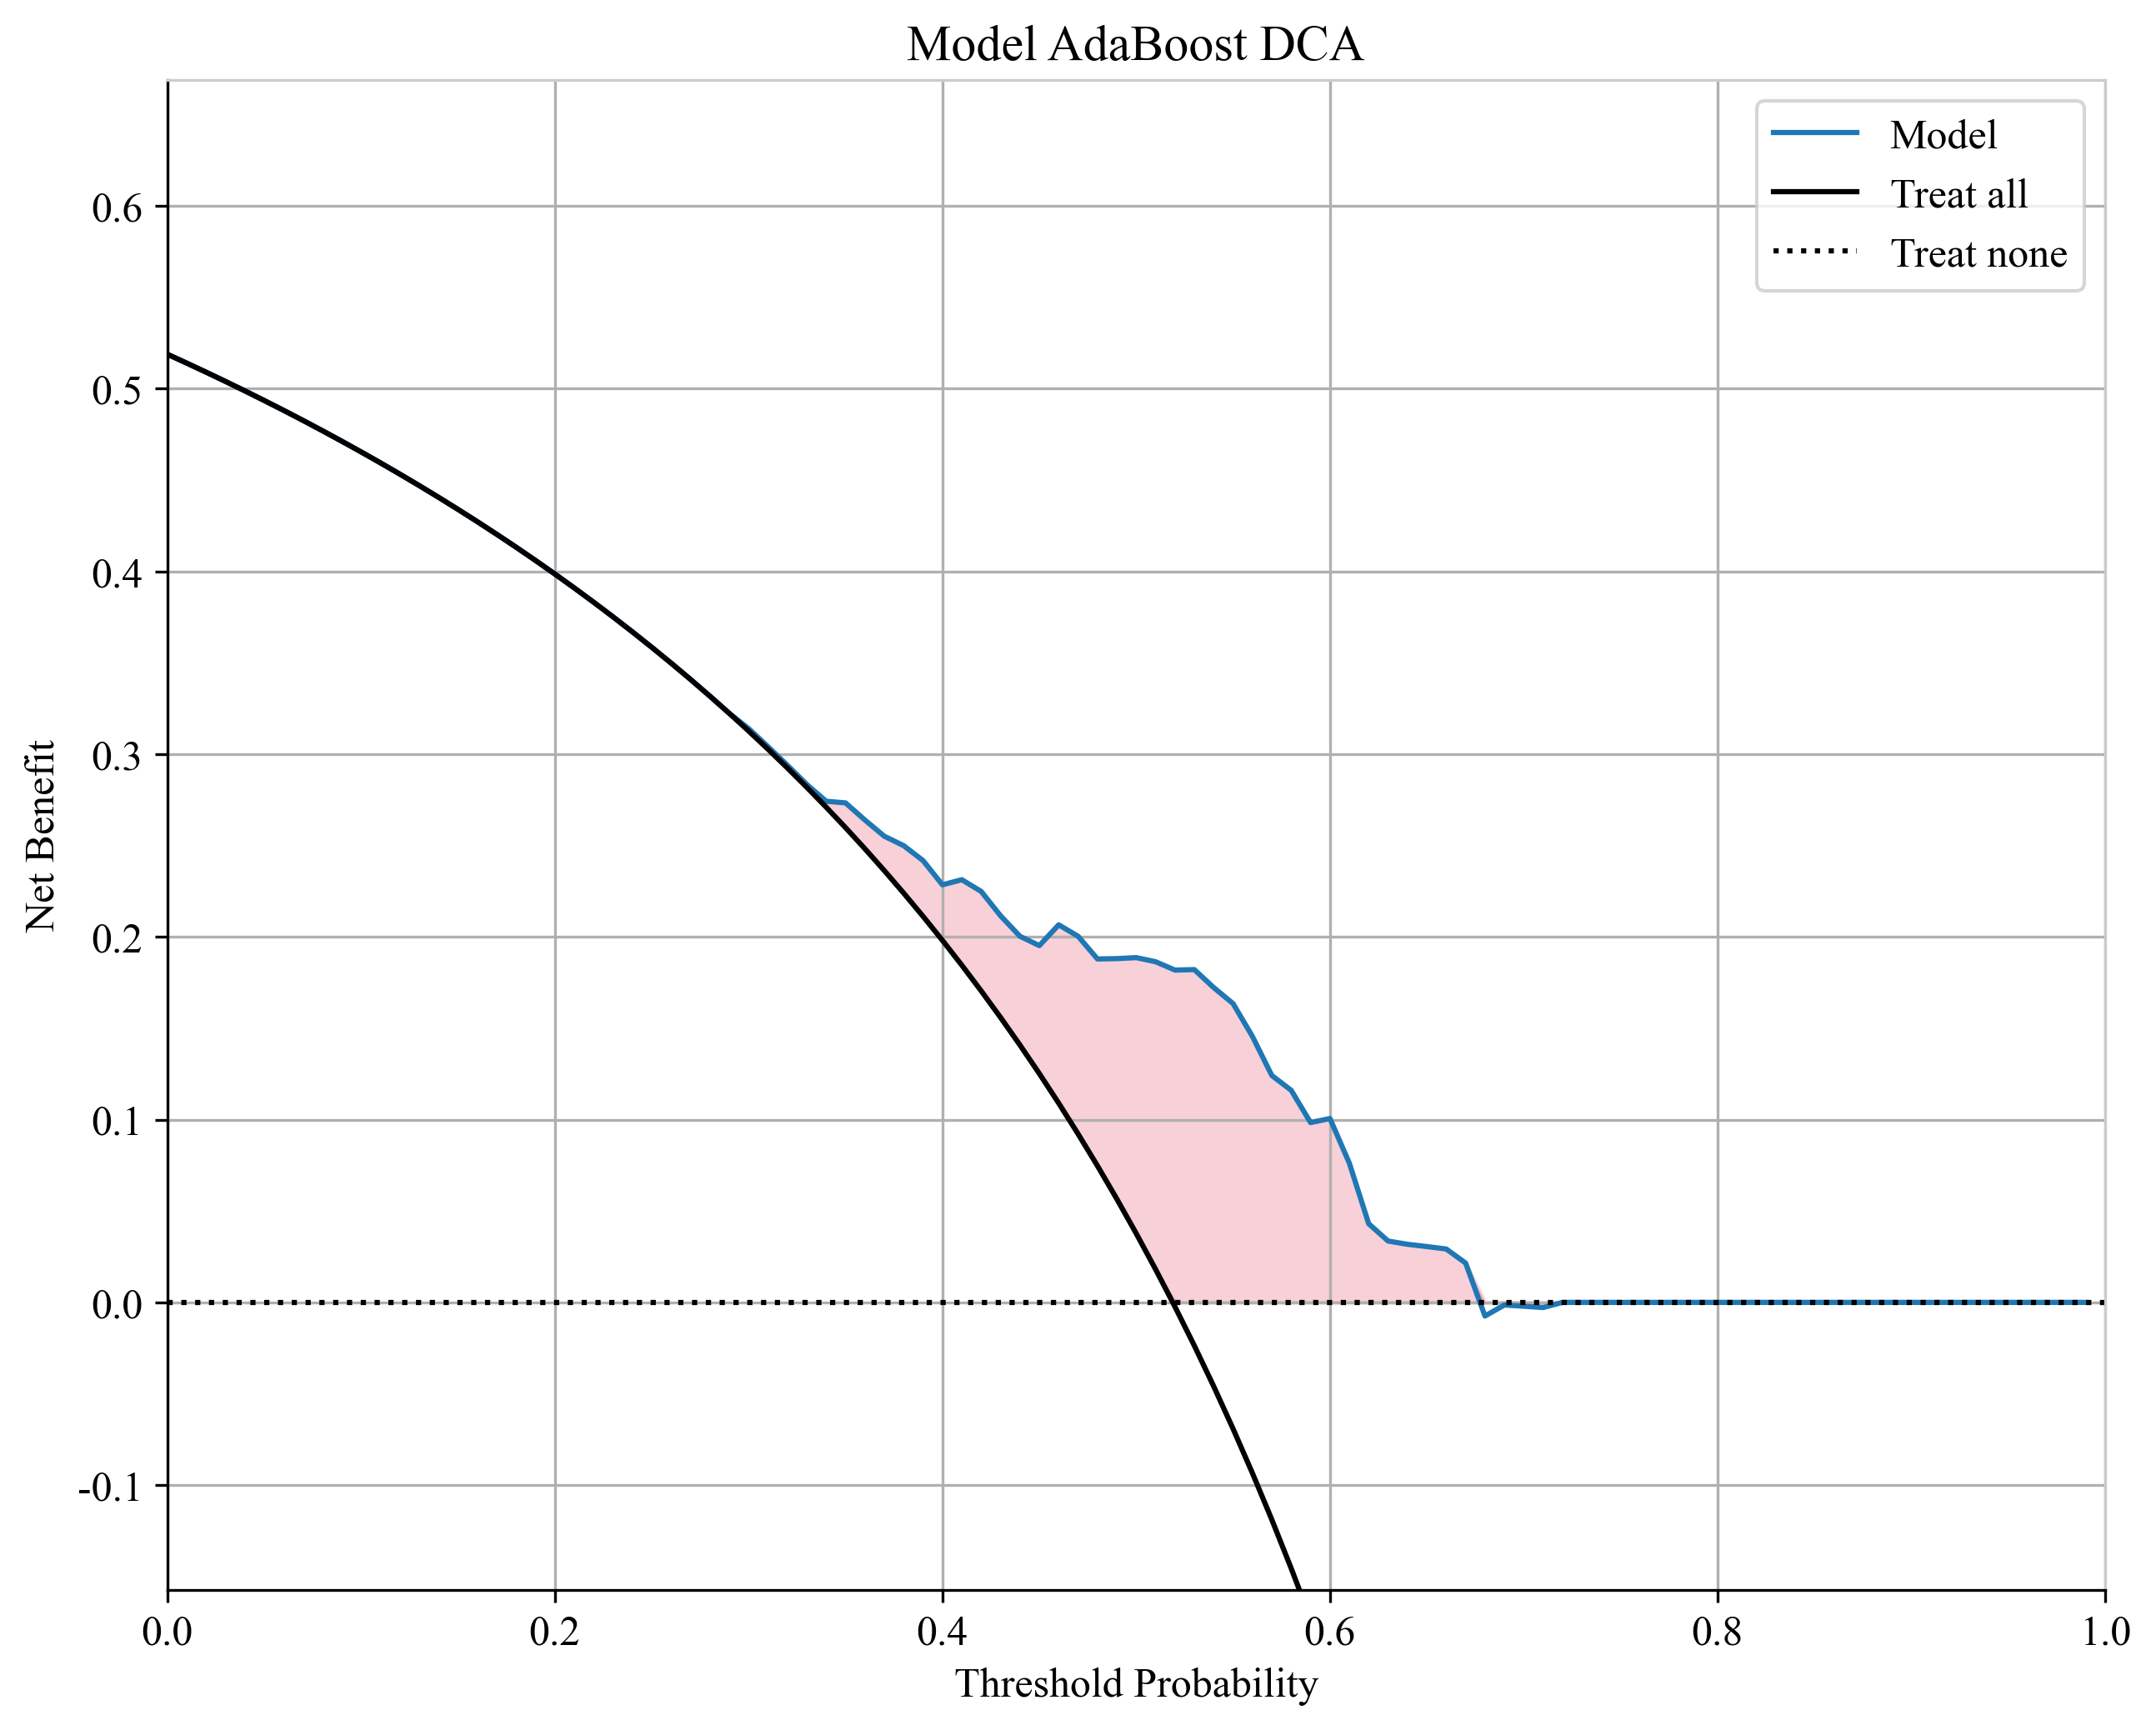

In [25]:
from onekey_algo.custom.components.comp1 import plot_DCA

for pred_score, label in zip(pred_scores, labels):
    pred_test_scores = []
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            okcomp.comp1.plot_DCA(pred_score[sel_model_idx][1][:,1], np.array(y_test_sel[label]),
                                  title=f'Model {sm} DCA')
            plt.savefig(f'img/{task_type}_model_{sm}_dca.svg', bbox_inches = 'tight')

### 绘制混淆矩阵

绘制混淆矩阵，[混淆矩阵解释](https://baike.baidu.com/item/%E6%B7%B7%E6%B7%86%E7%9F%A9%E9%98%B5/10087822?fr=aladdin)
`sel_model = ['SVM', 'KNN']`参数为想要绘制的模型对应的参数。

如果需要修改标签到名称的映射，修改`class_mapping={1:'1', 0:'0'}`

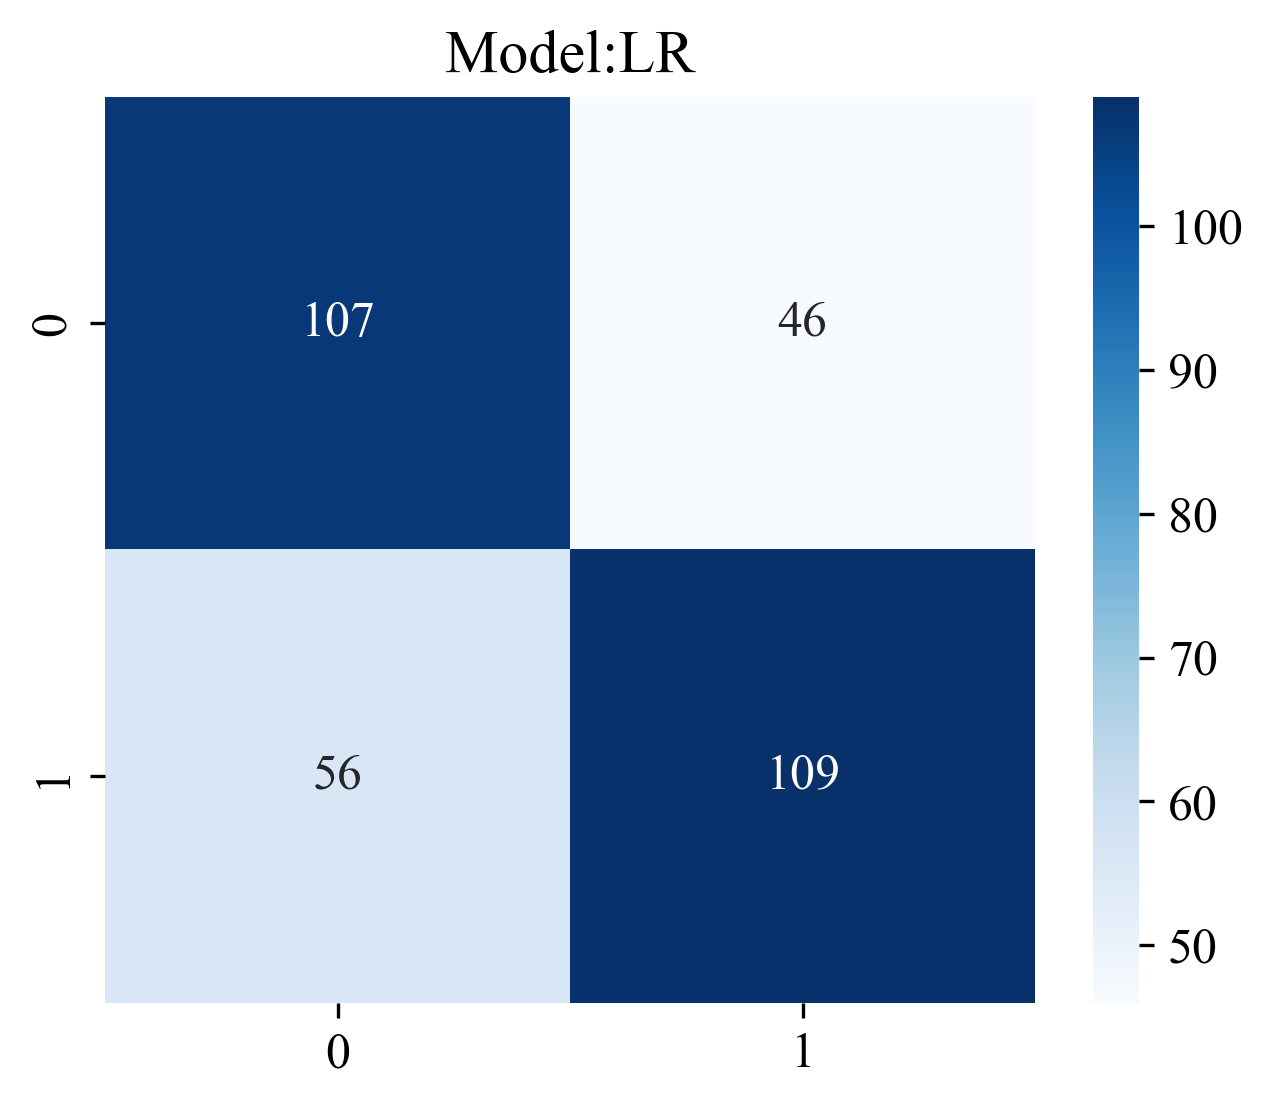

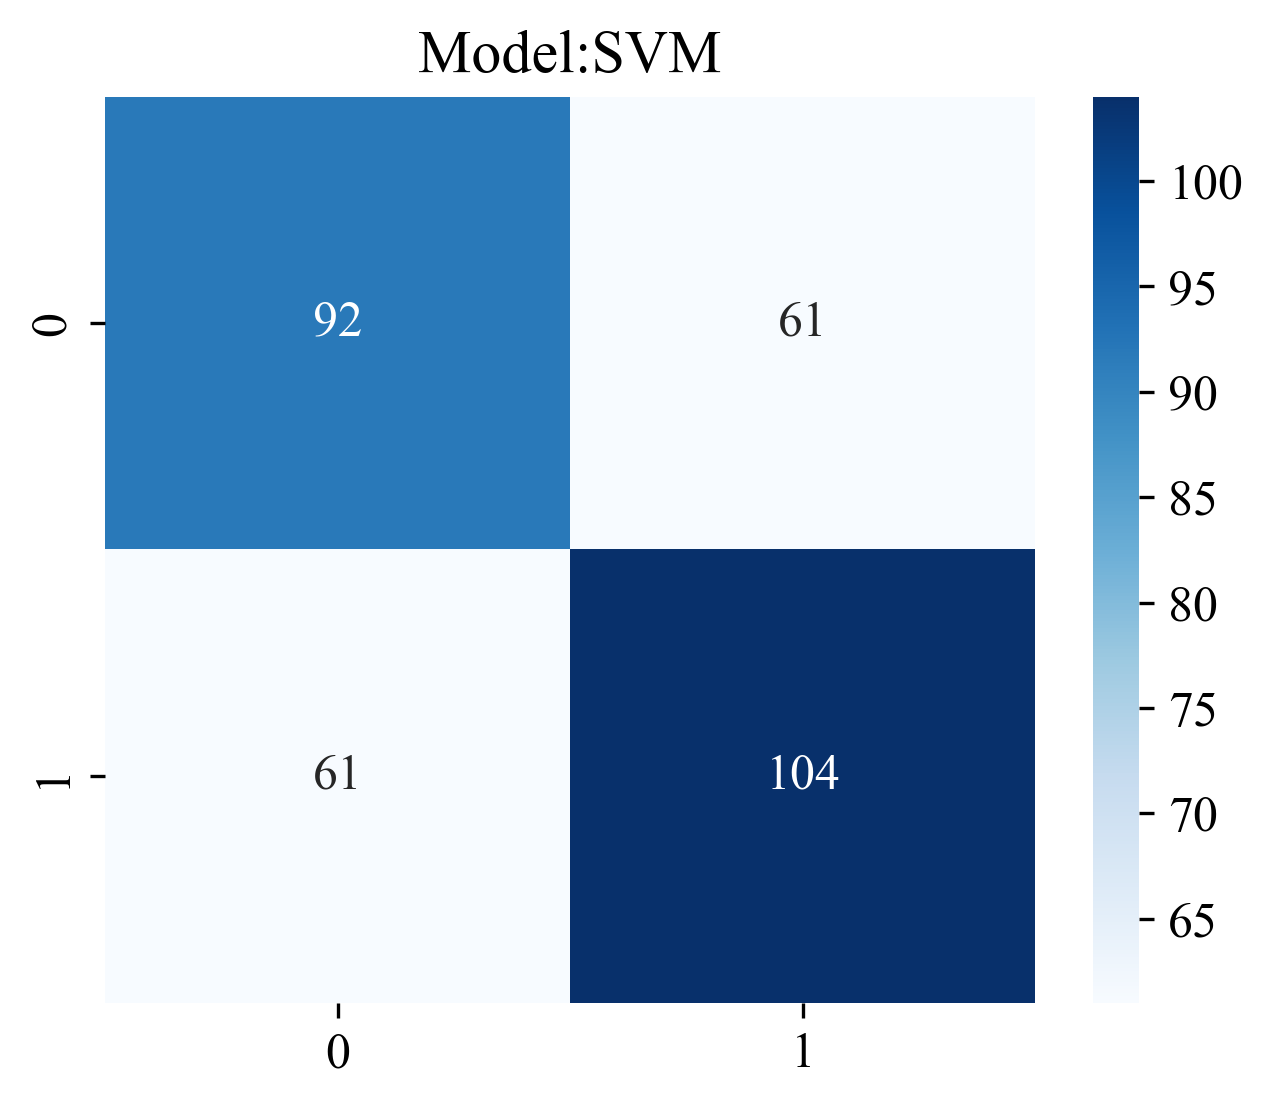

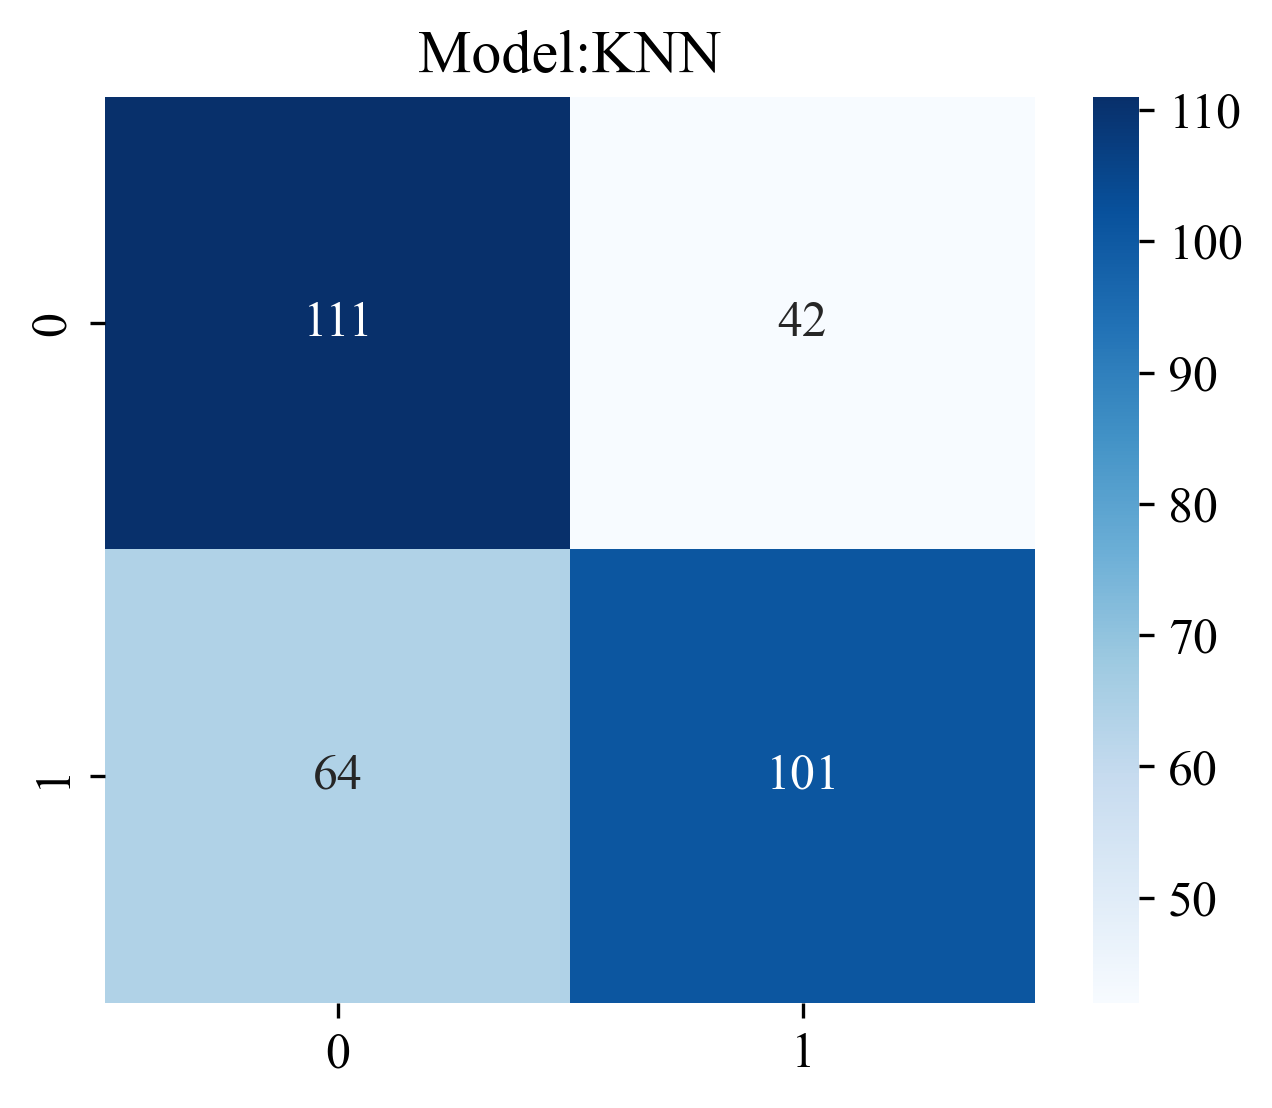

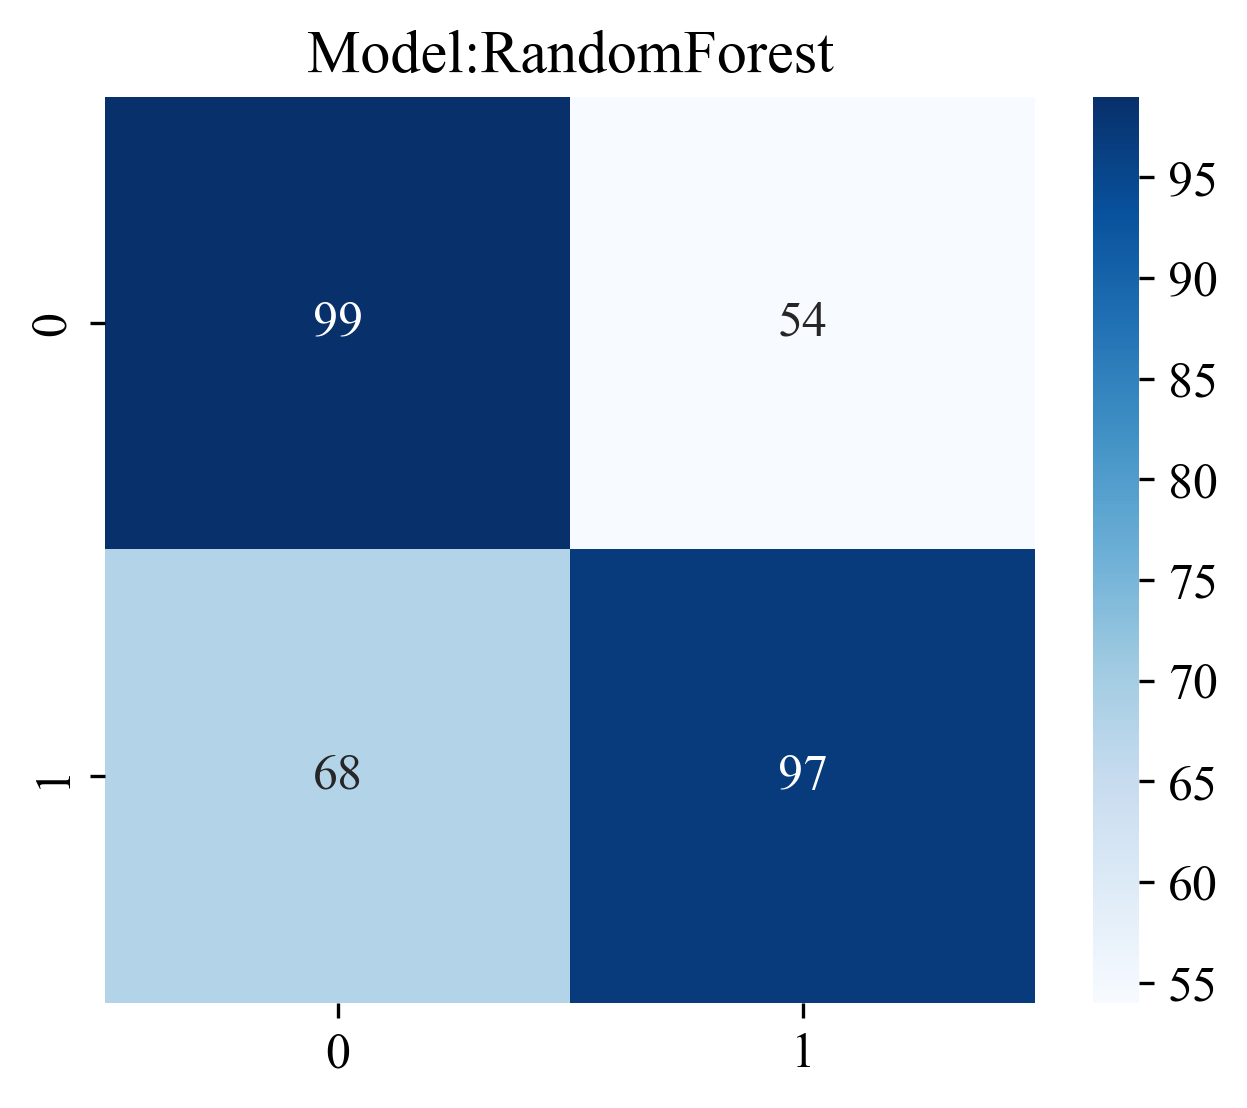

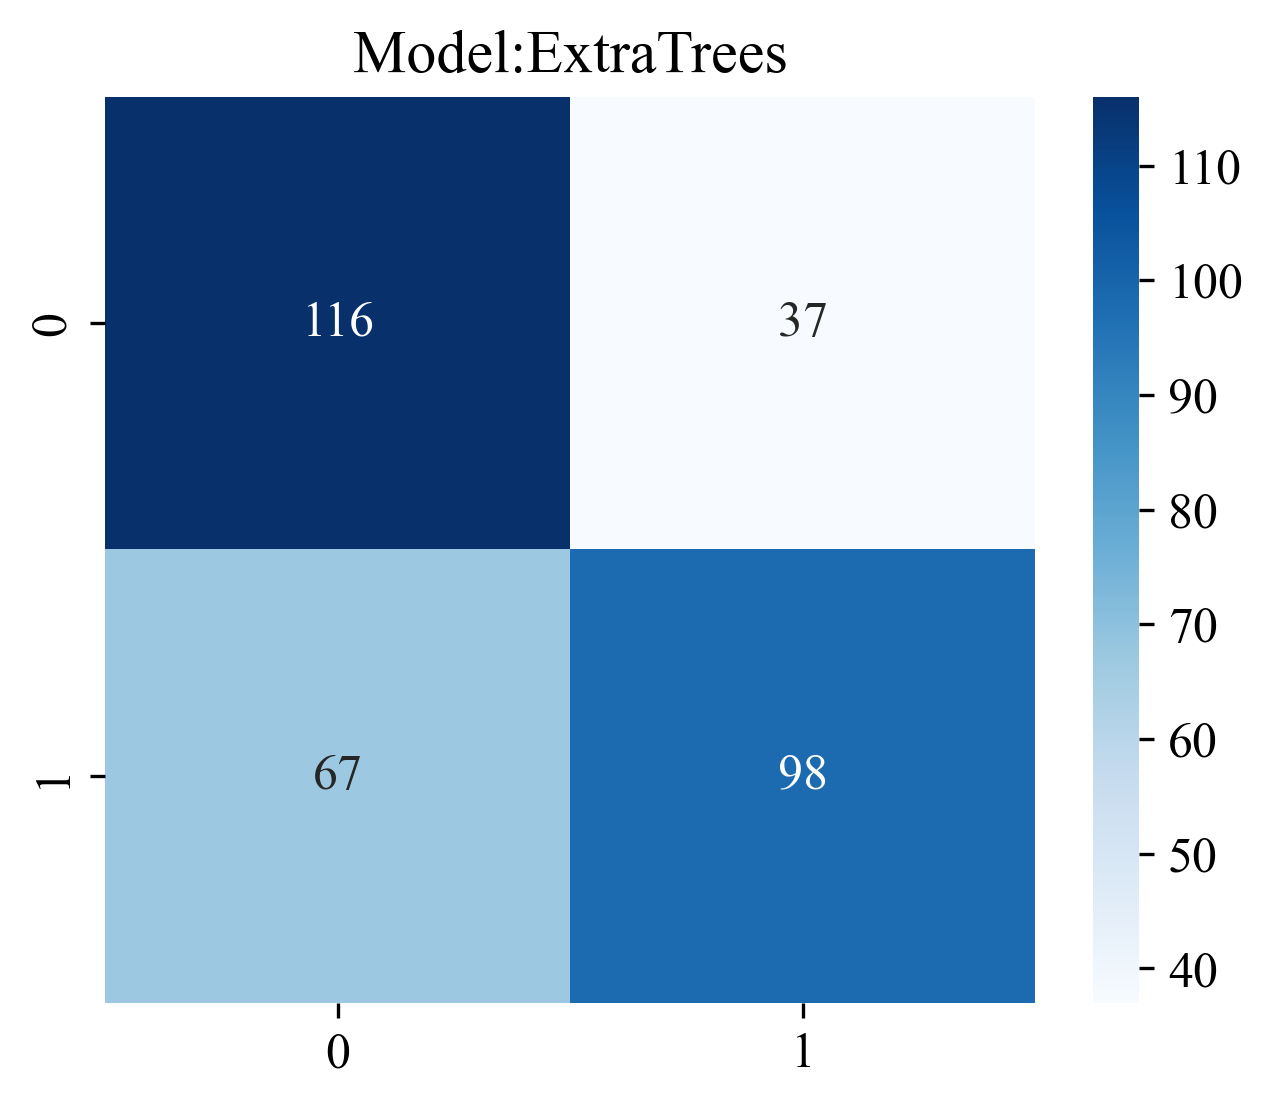

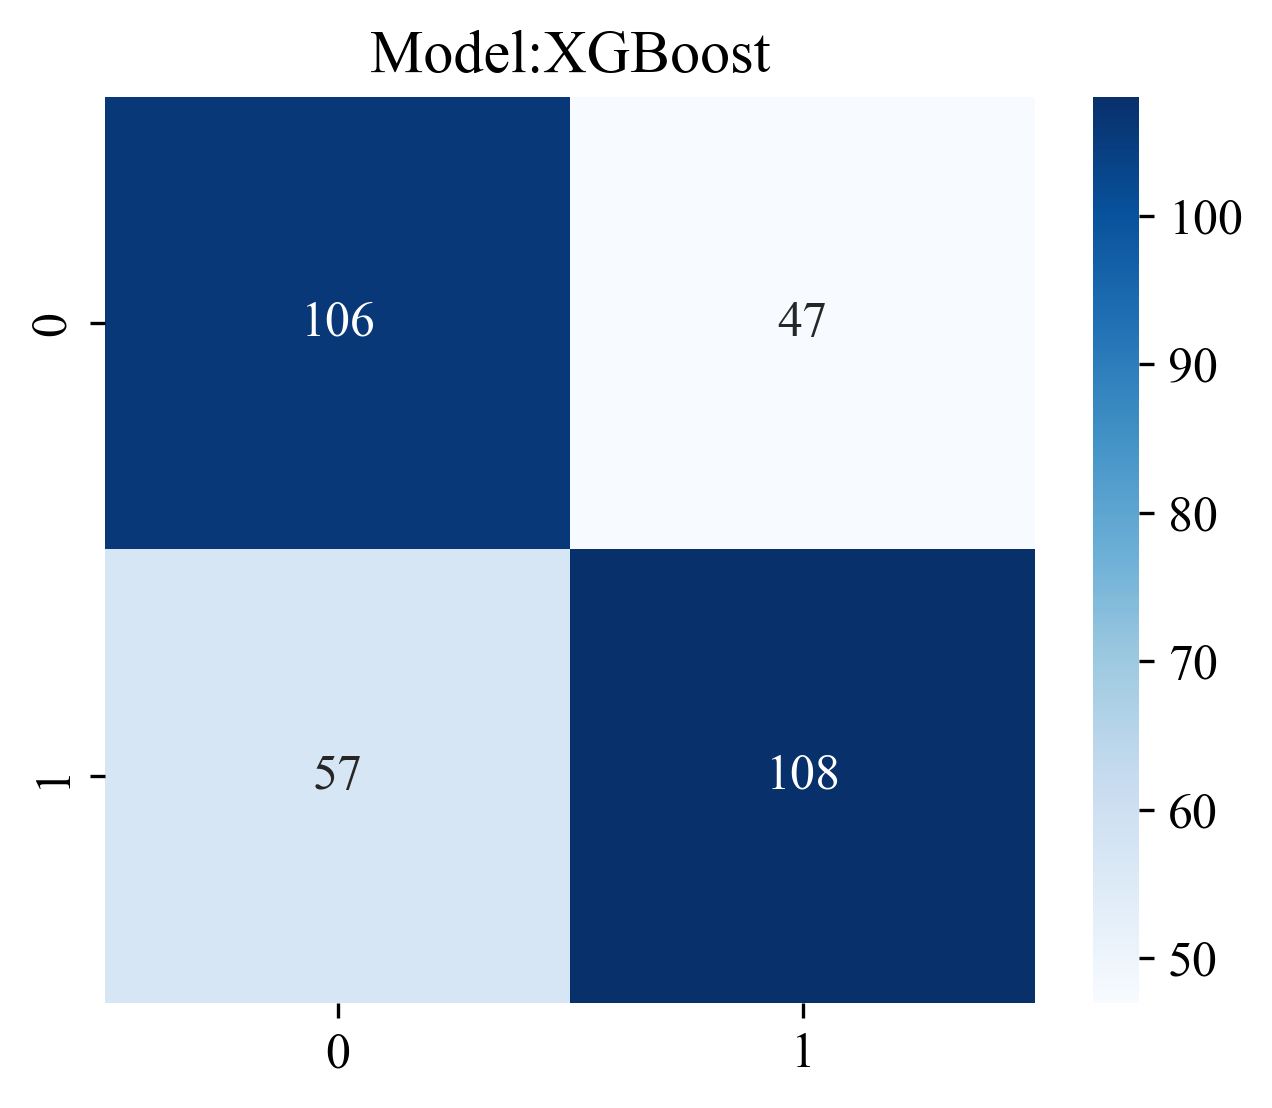

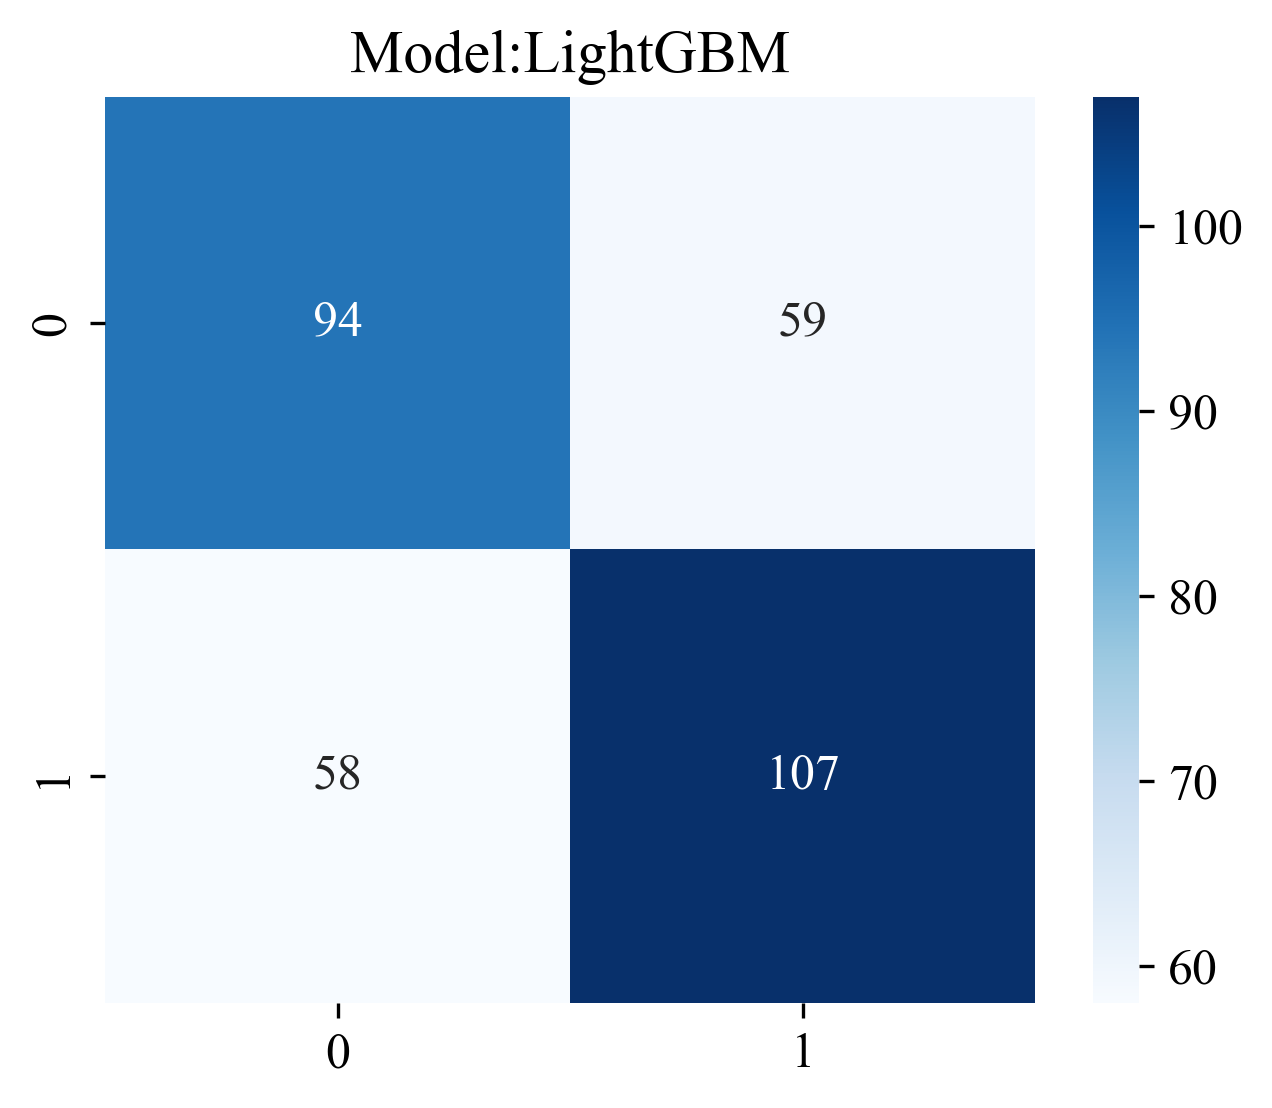

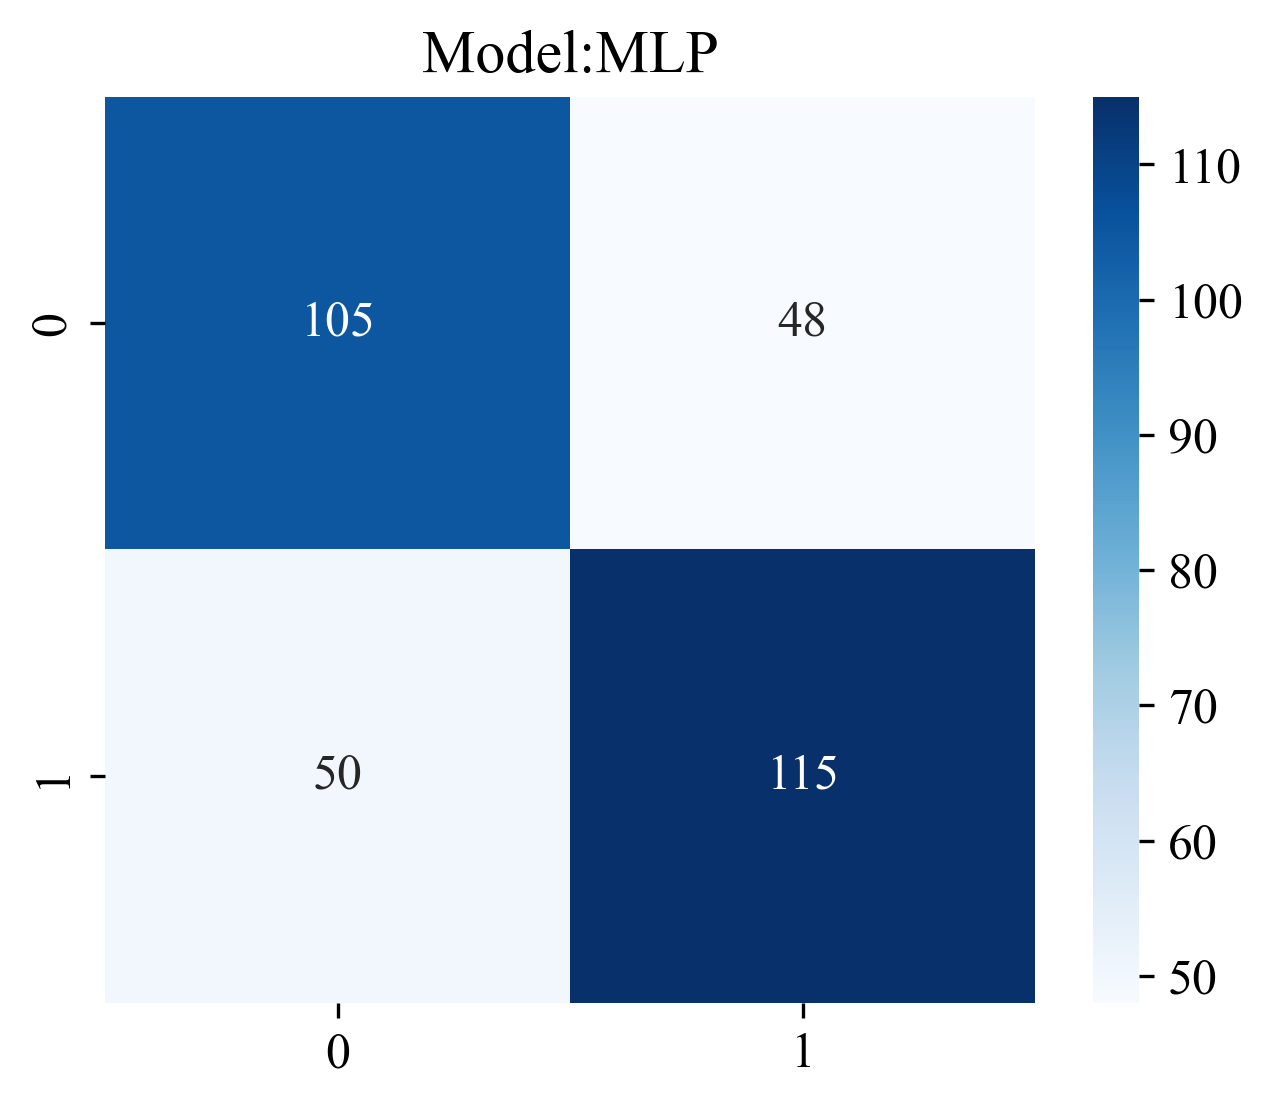

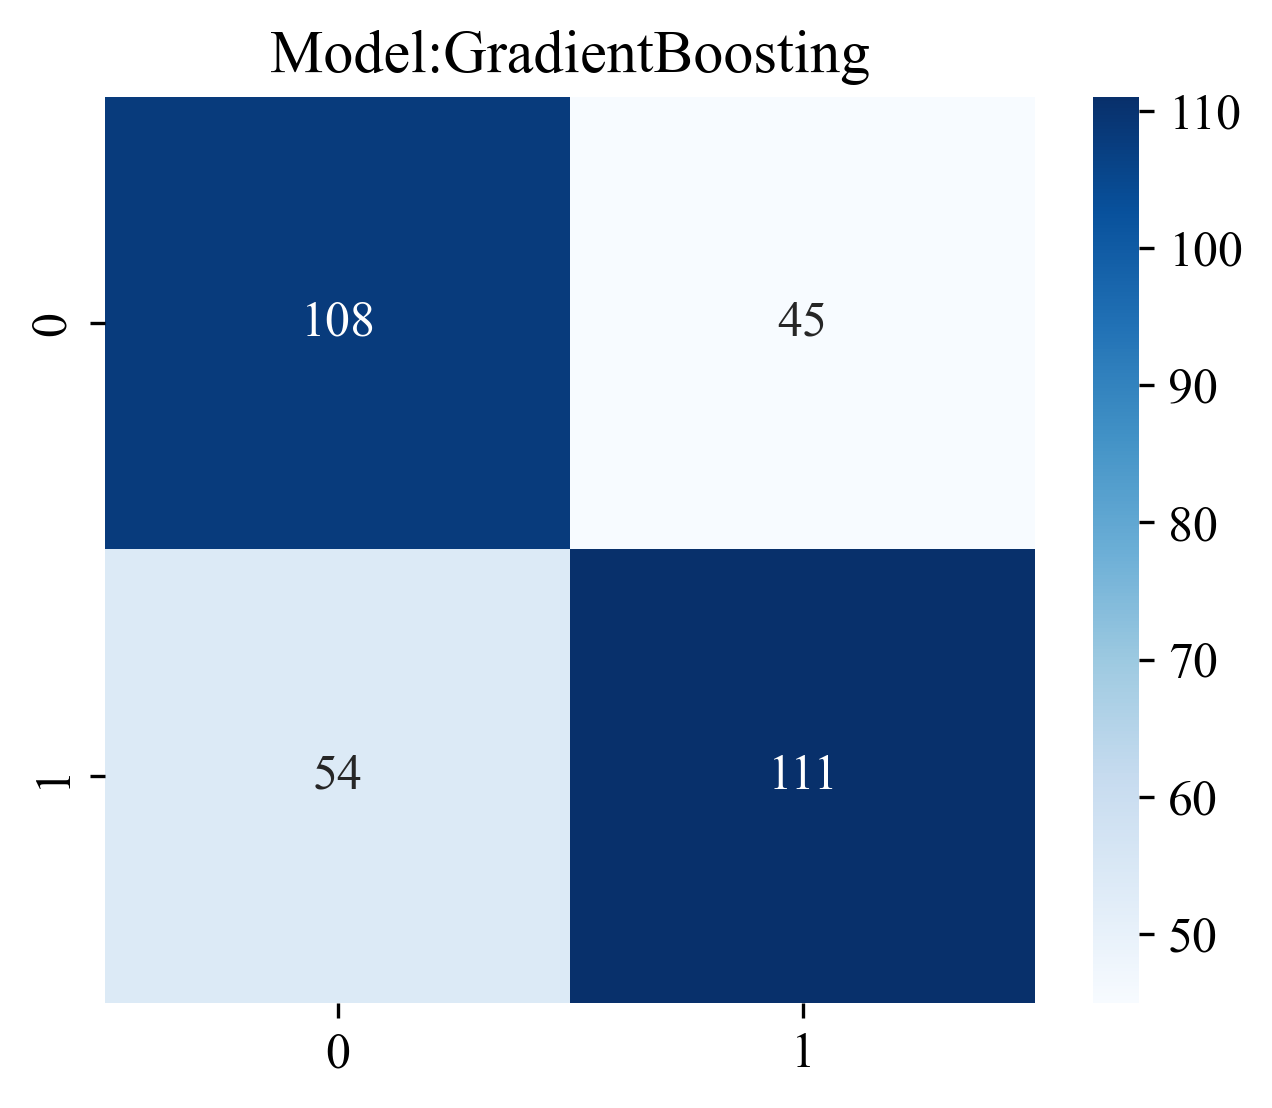

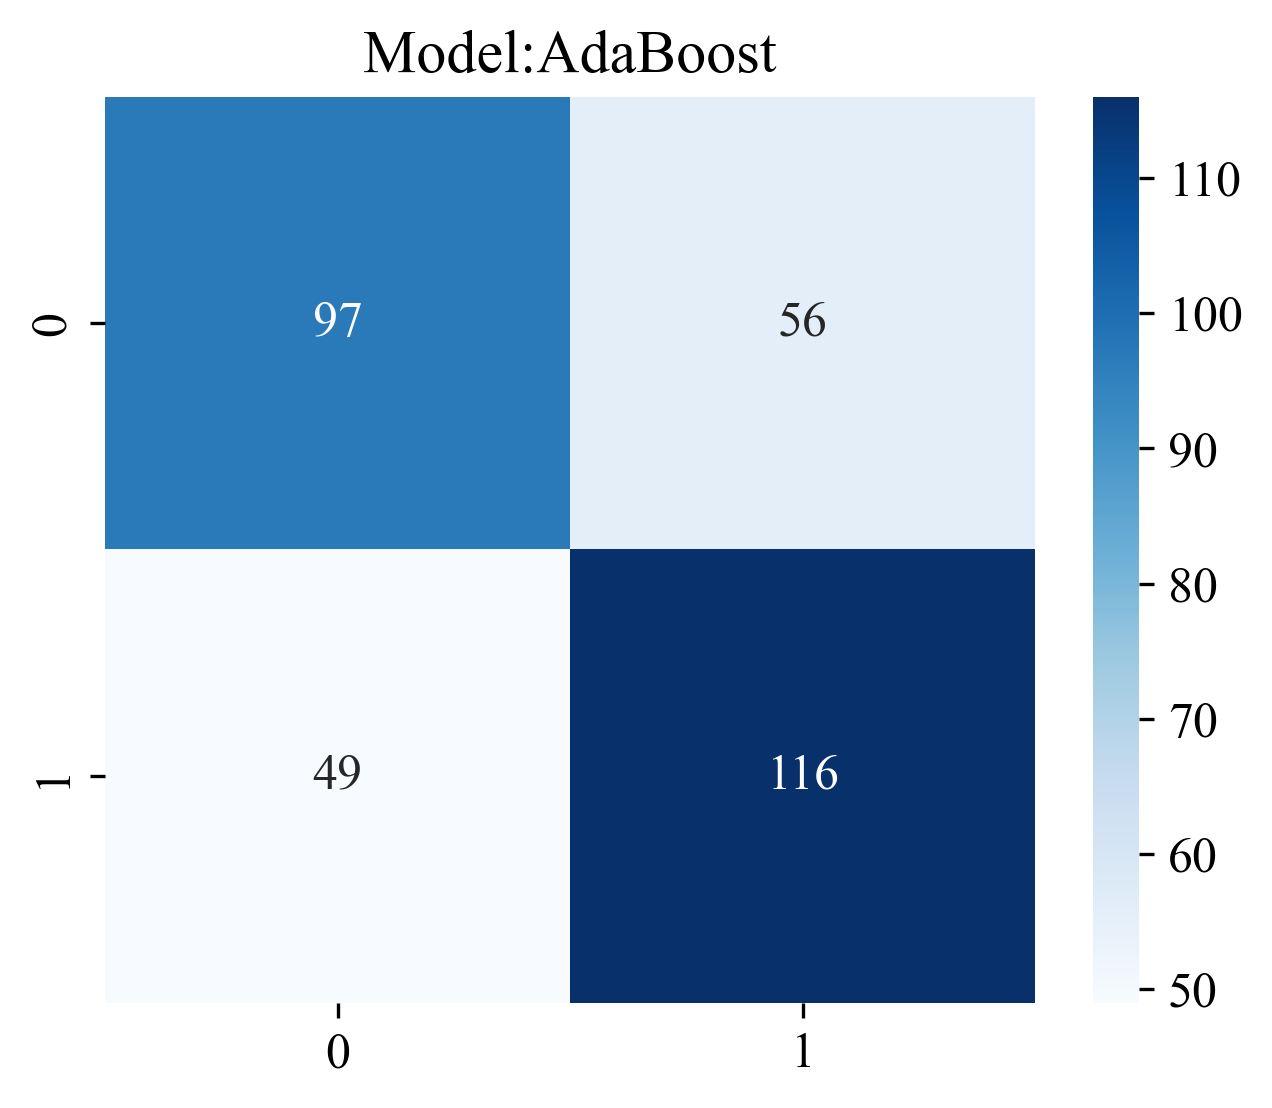

In [26]:
# 设置绘制参数
sel_model = model_names
c_matrix = {}

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):
            cm = okcomp.comp1.calc_confusion_matrix(predictions[idx][sel_model_idx][-1], y_test_sel[label],
#                                                     sel_idx = pred_sel_idx[idx][sel_model_idx],
                                                    class_mapping={1:'1', 0:'0'}, num_classes=2)
            c_matrix[label] = cm
            plt.figure(figsize=(5, 4))
            plt.title(f'Model:{sm}')
            okcomp.comp1.draw_matrix(cm, norm=False, annot=True, cmap='Blues', fmt='.3g')
            plt.savefig(f'img/{task_type}_model_{sm}_cm.svg', bbox_inches = 'tight')

### 样本预测直方图

绘制每个样本的预测结果以及对应的真实结果, 图例中label=xx可以修改成自己类别的真实标签。

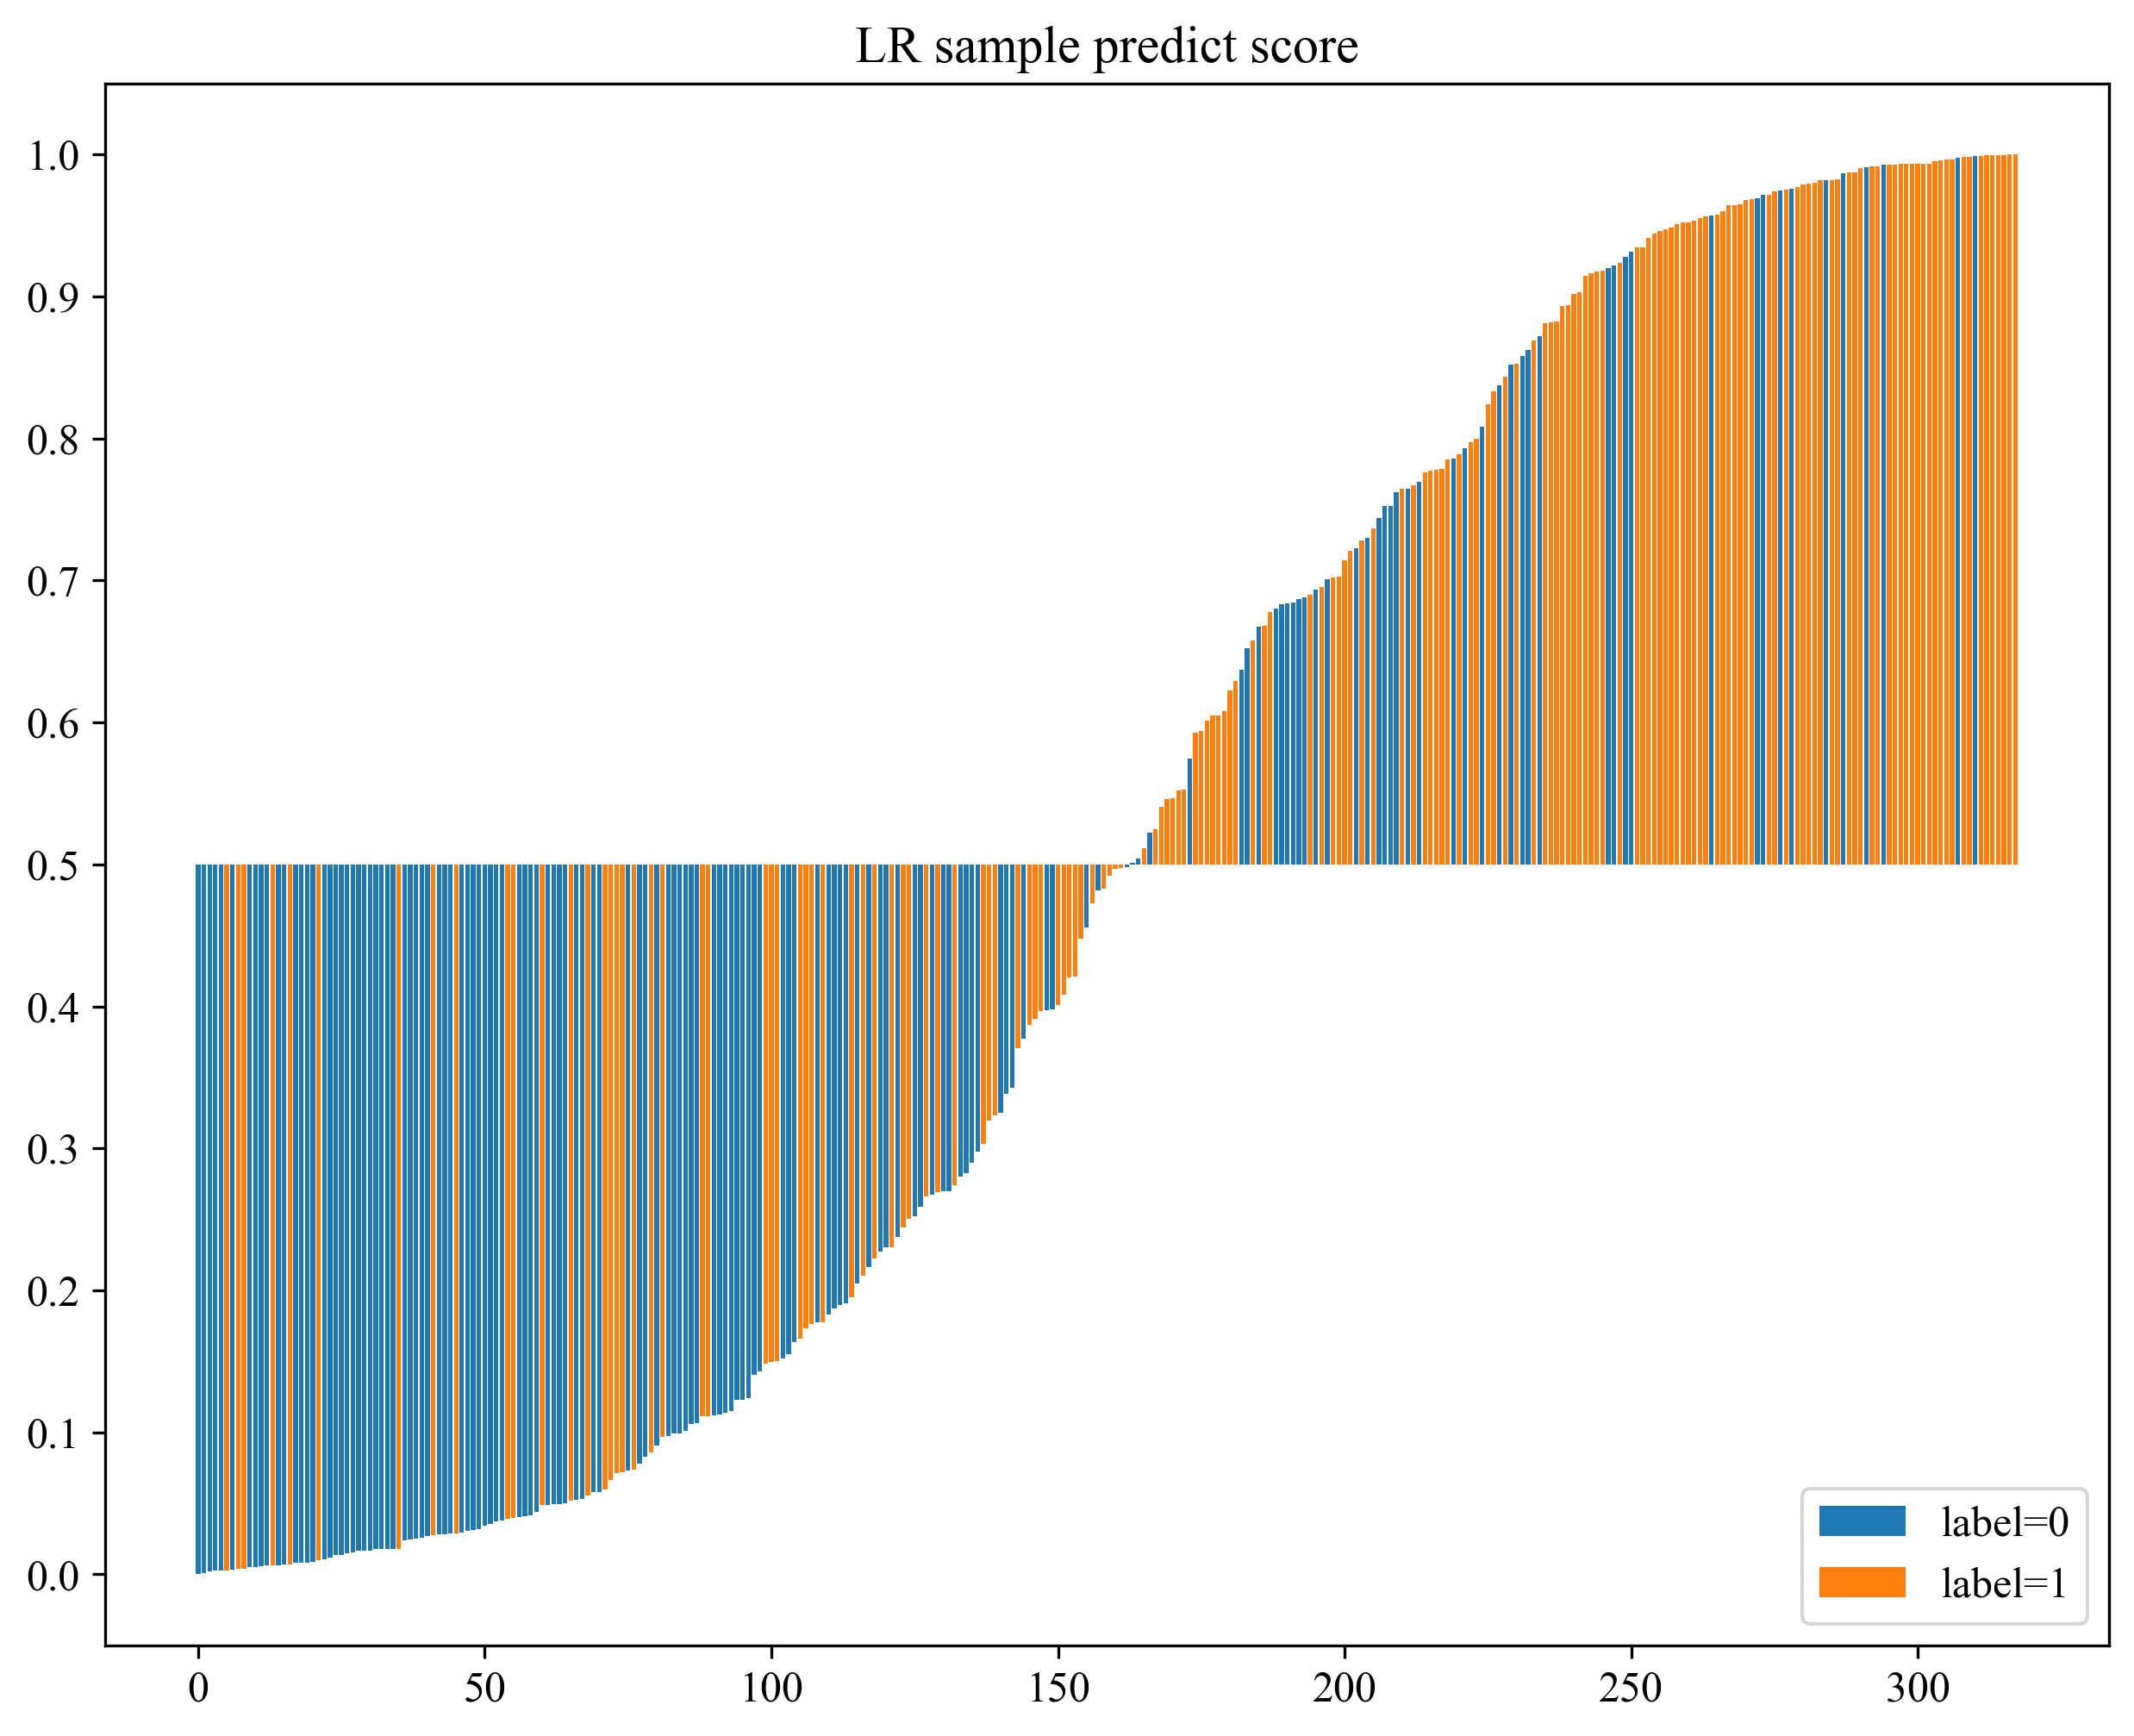

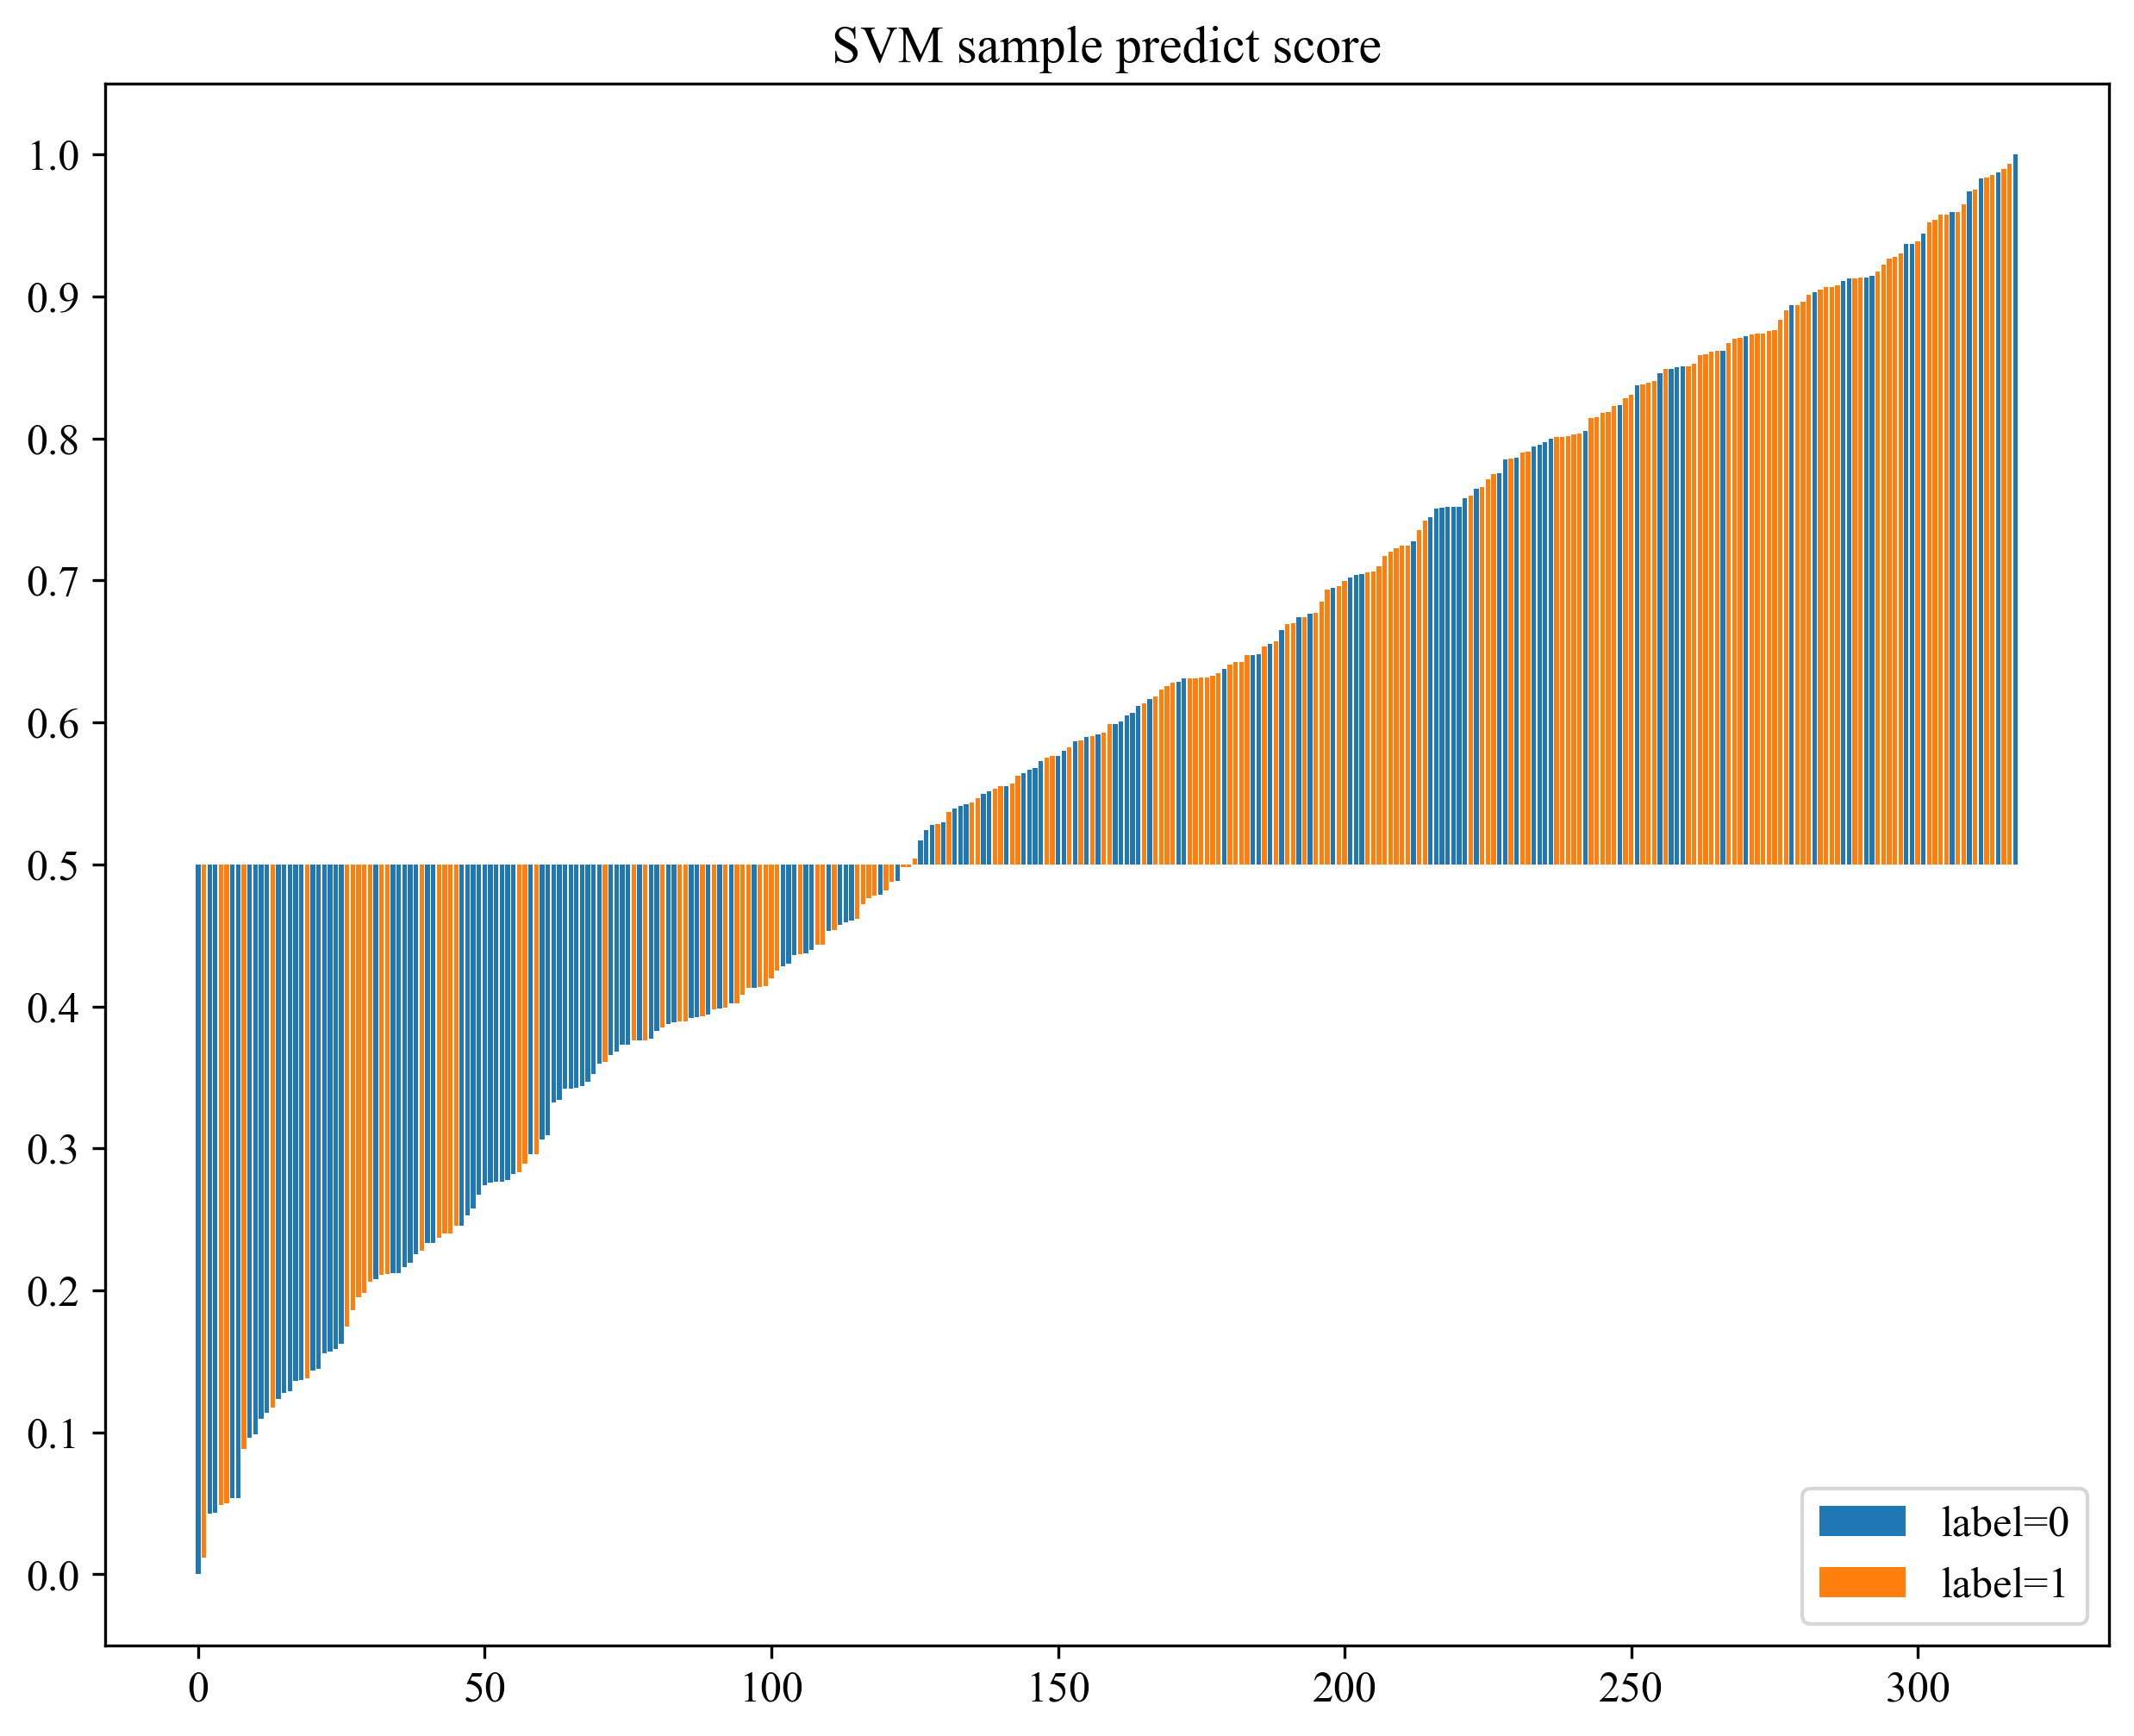

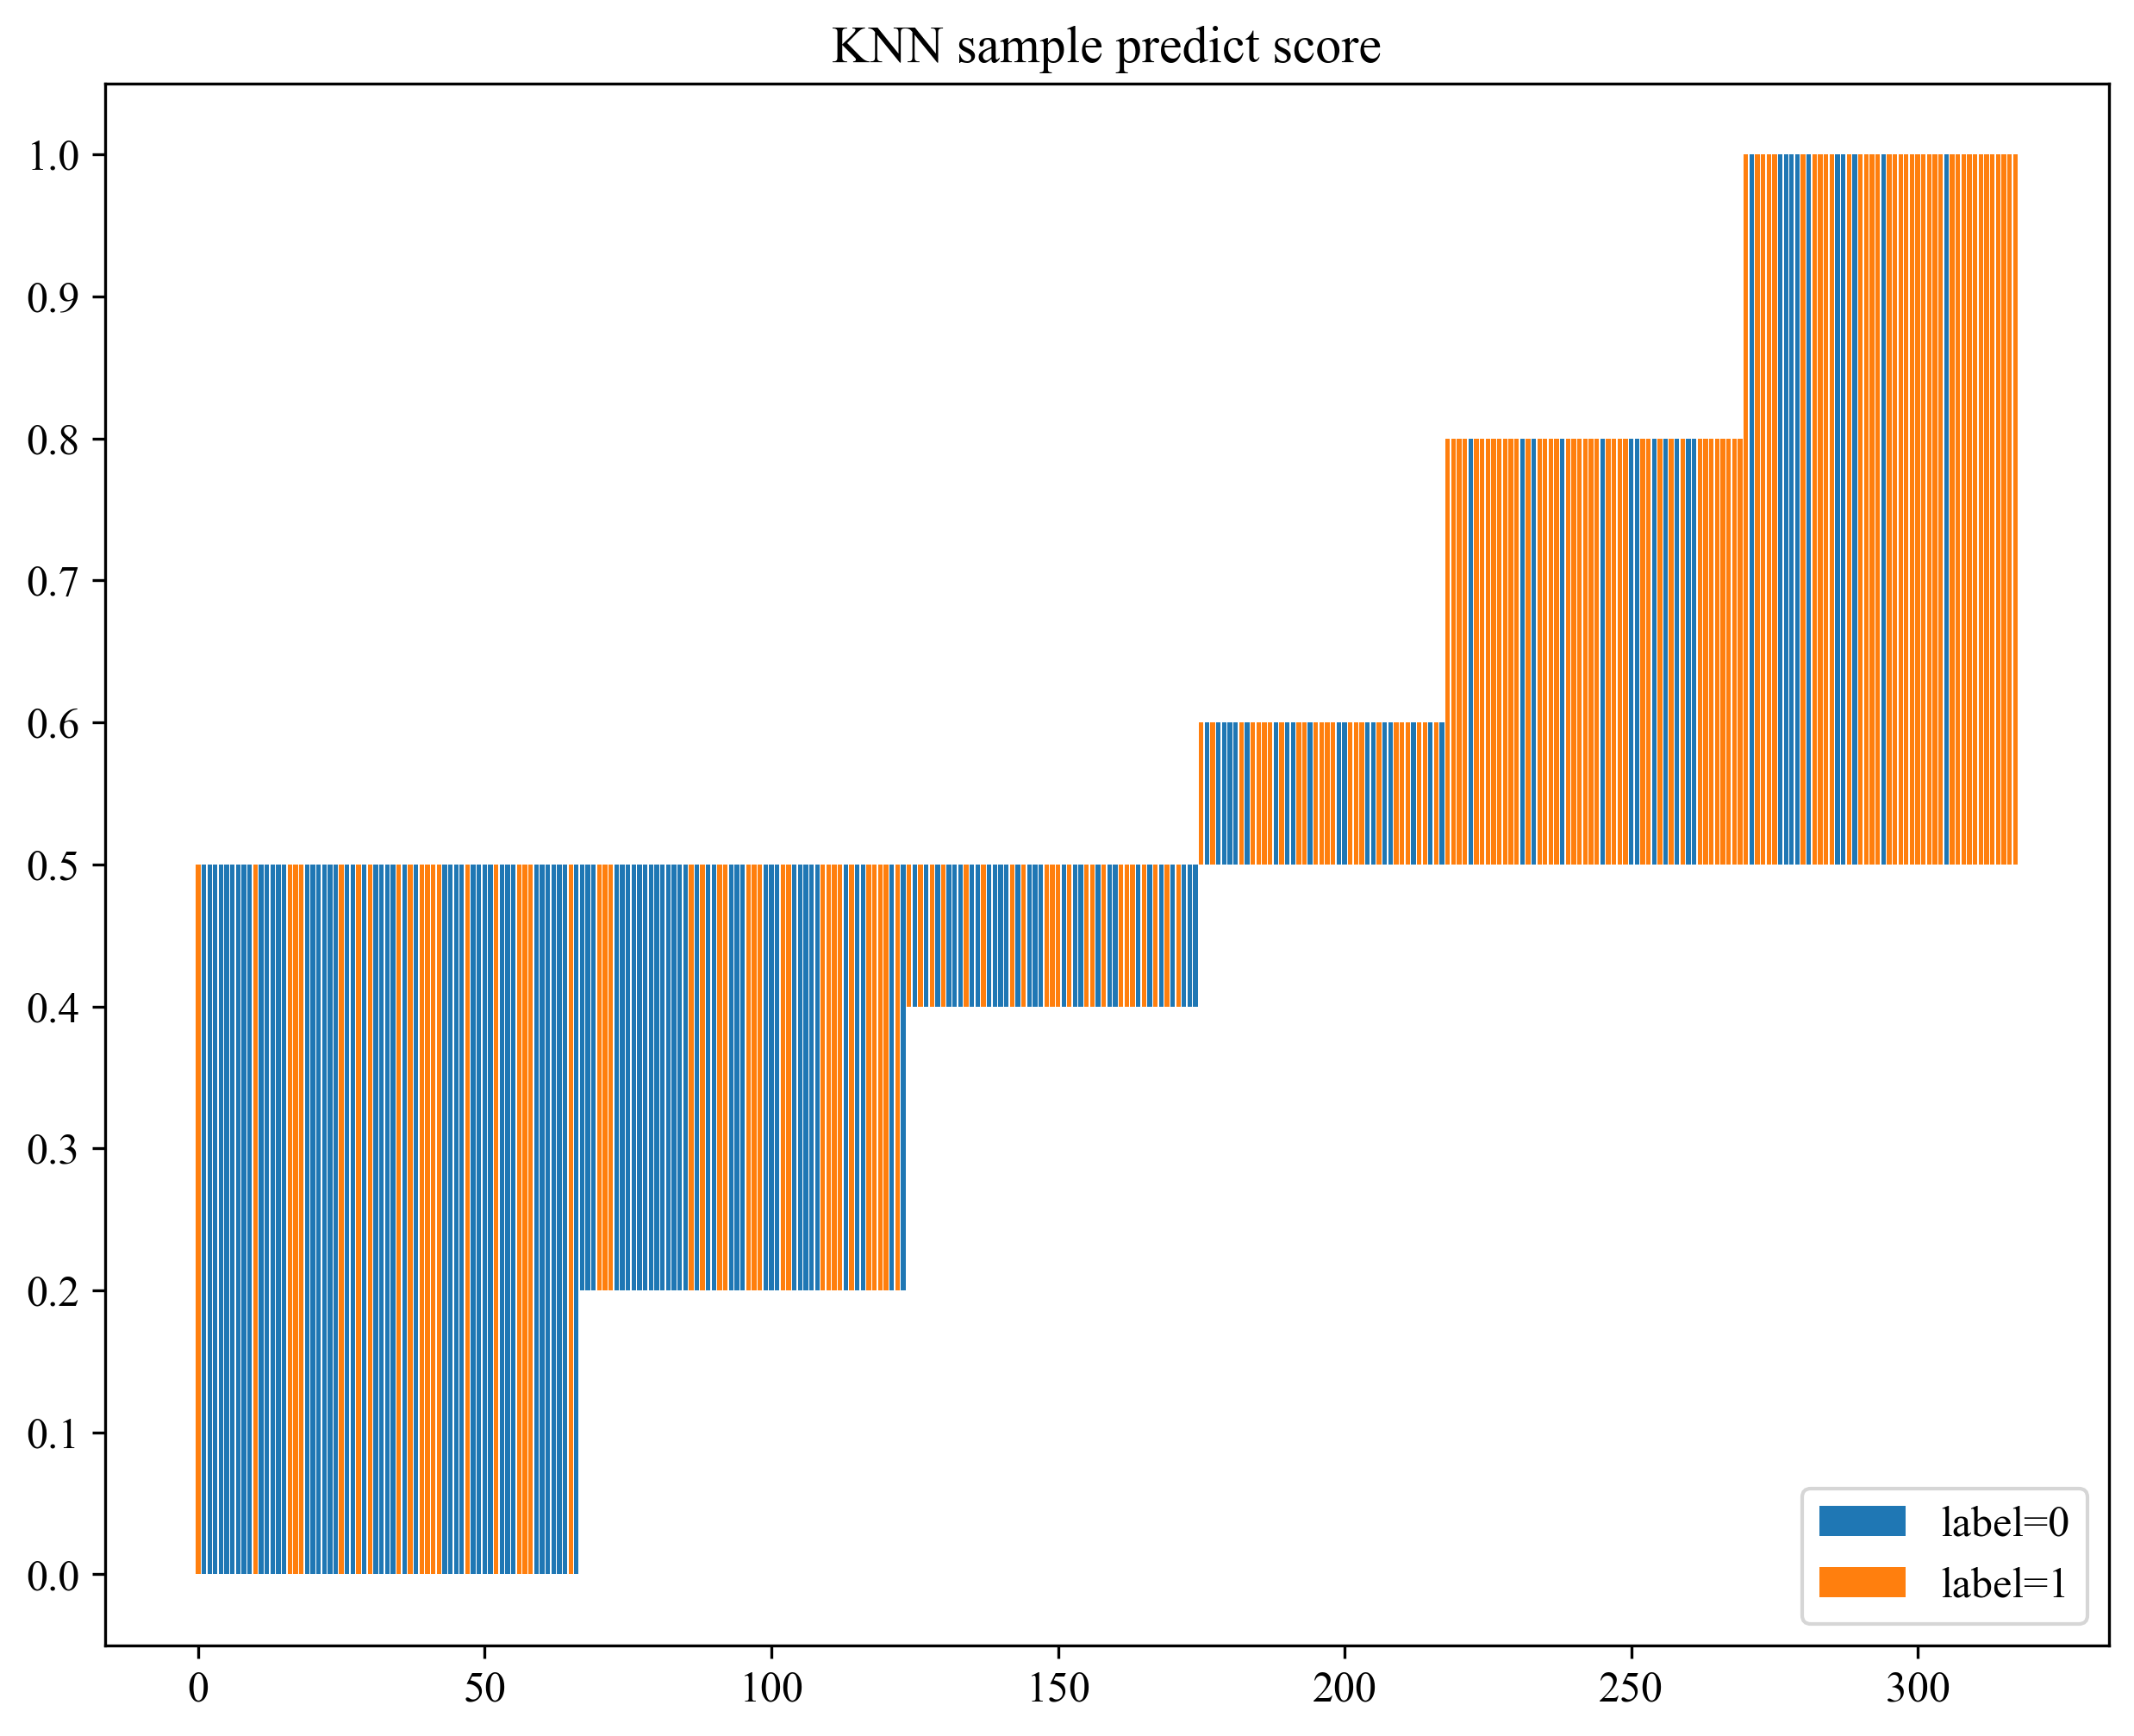

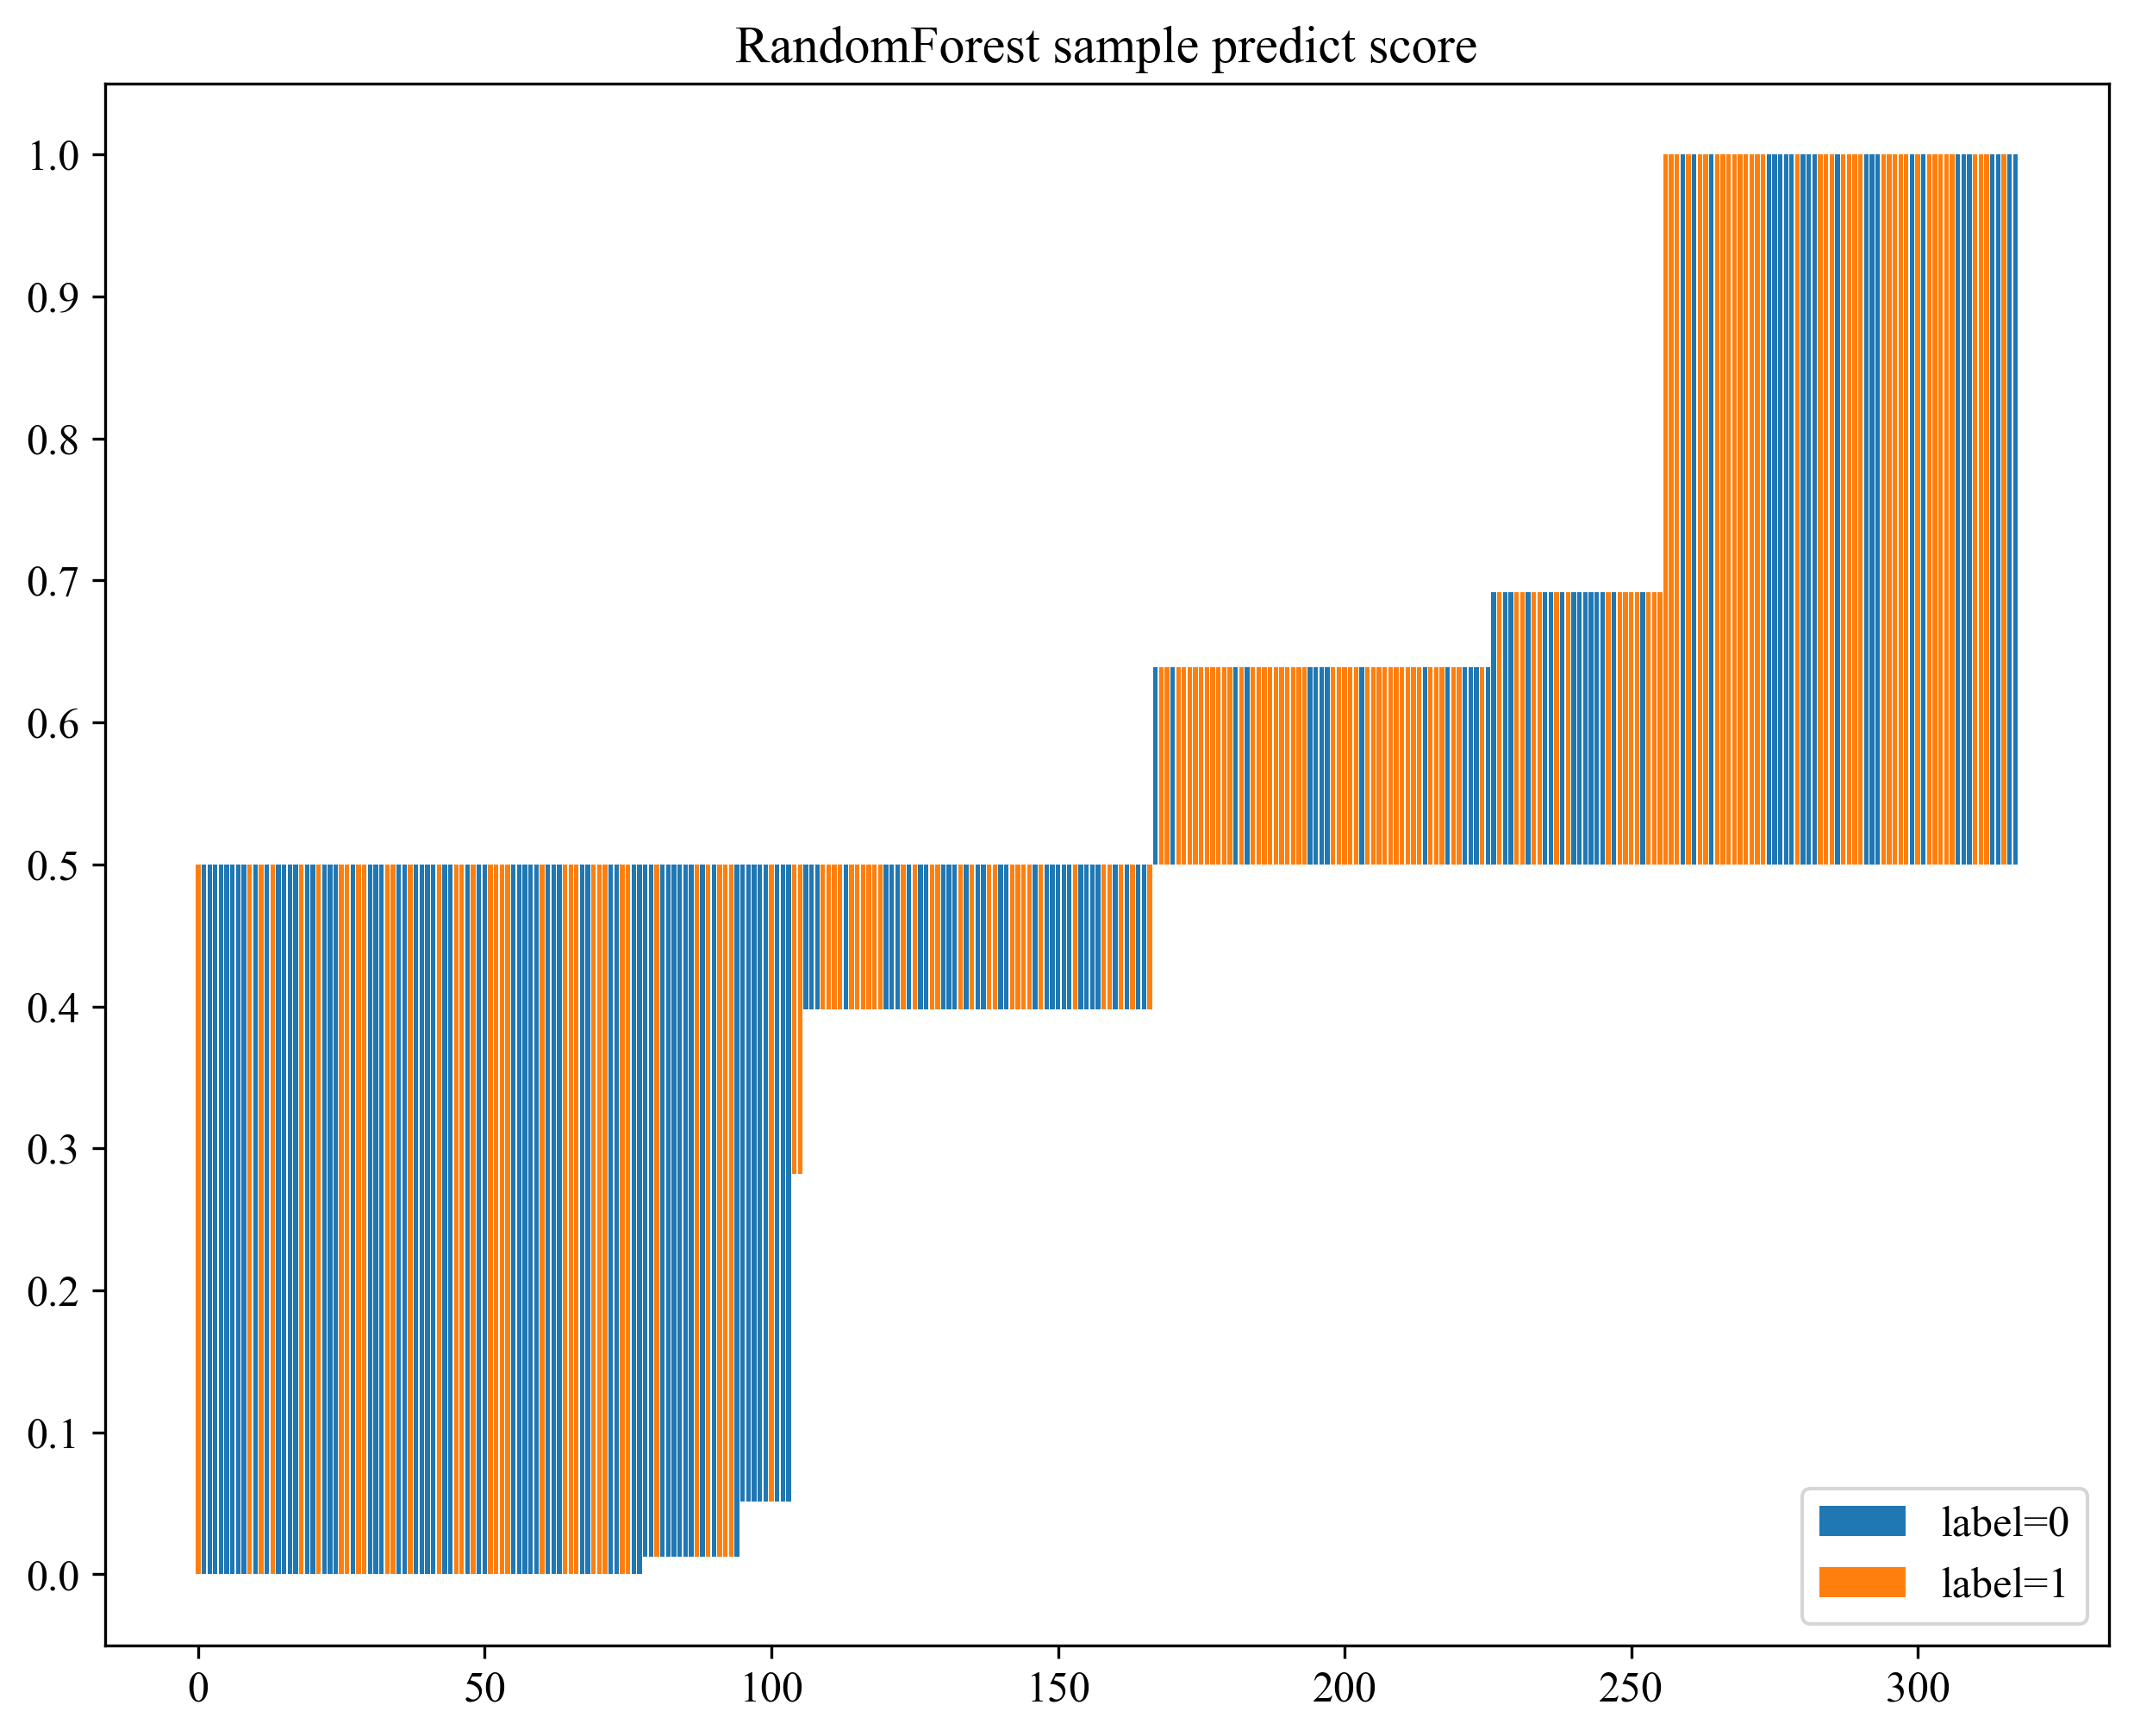

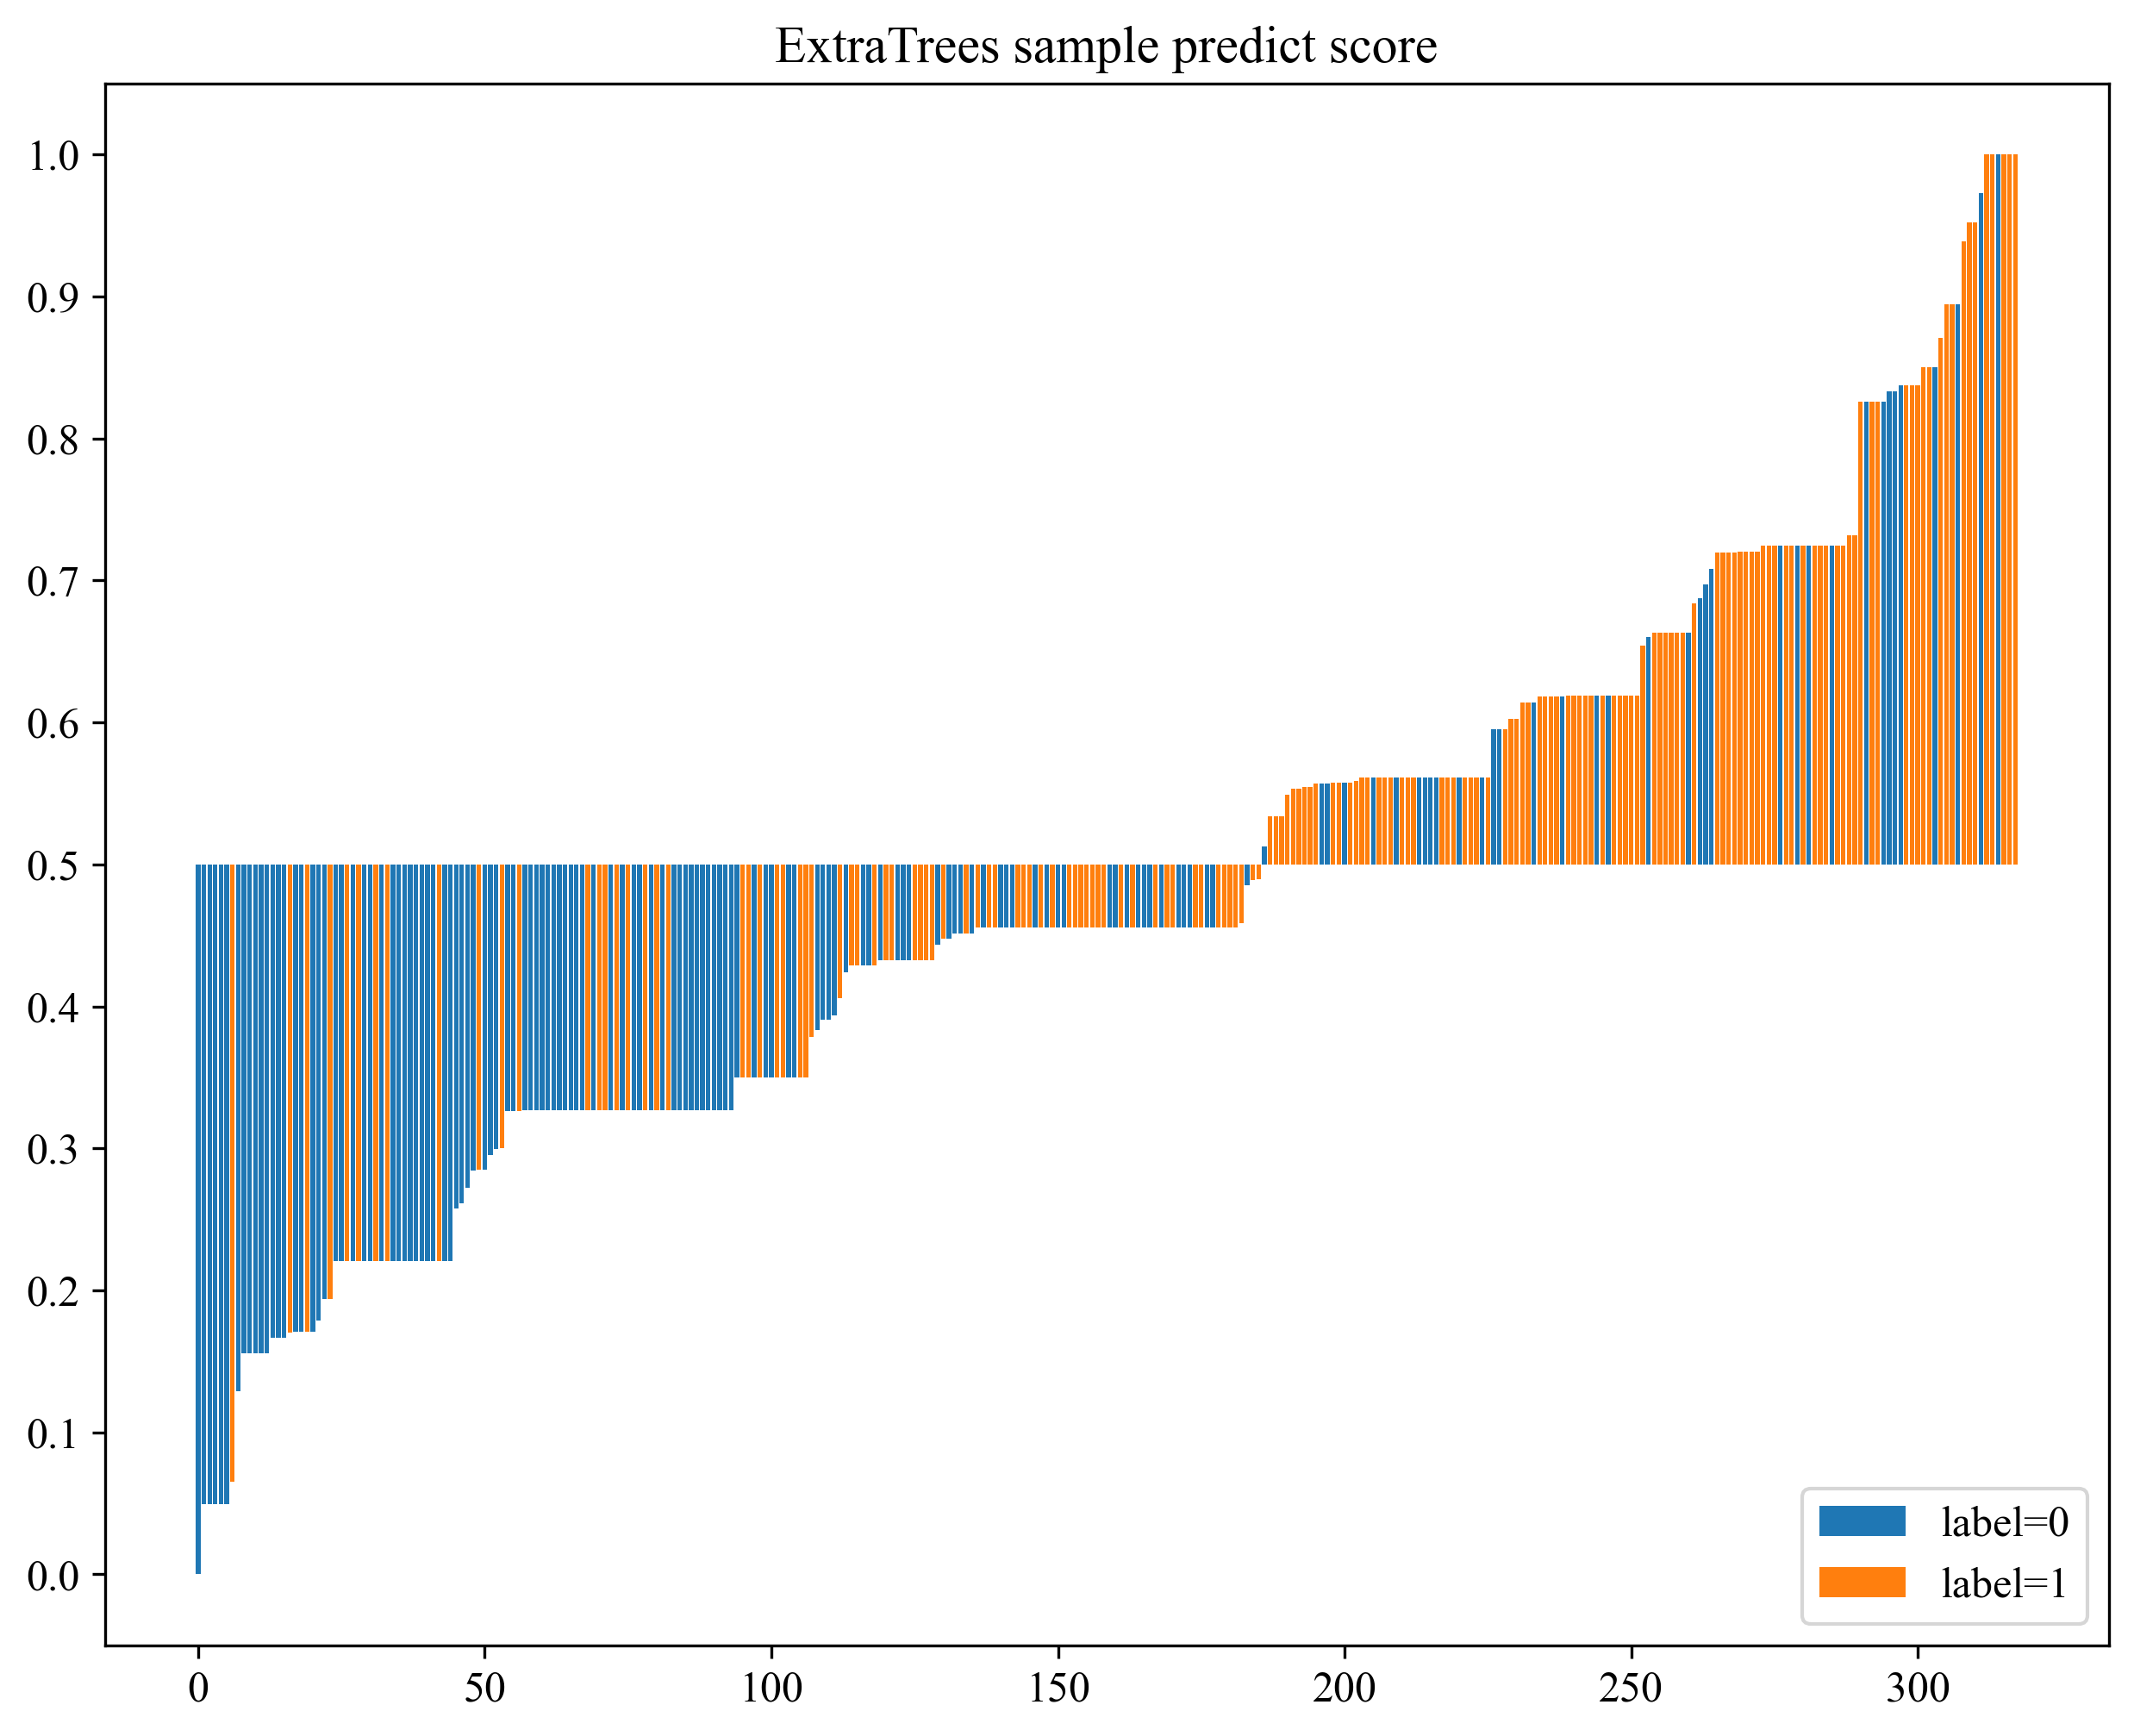

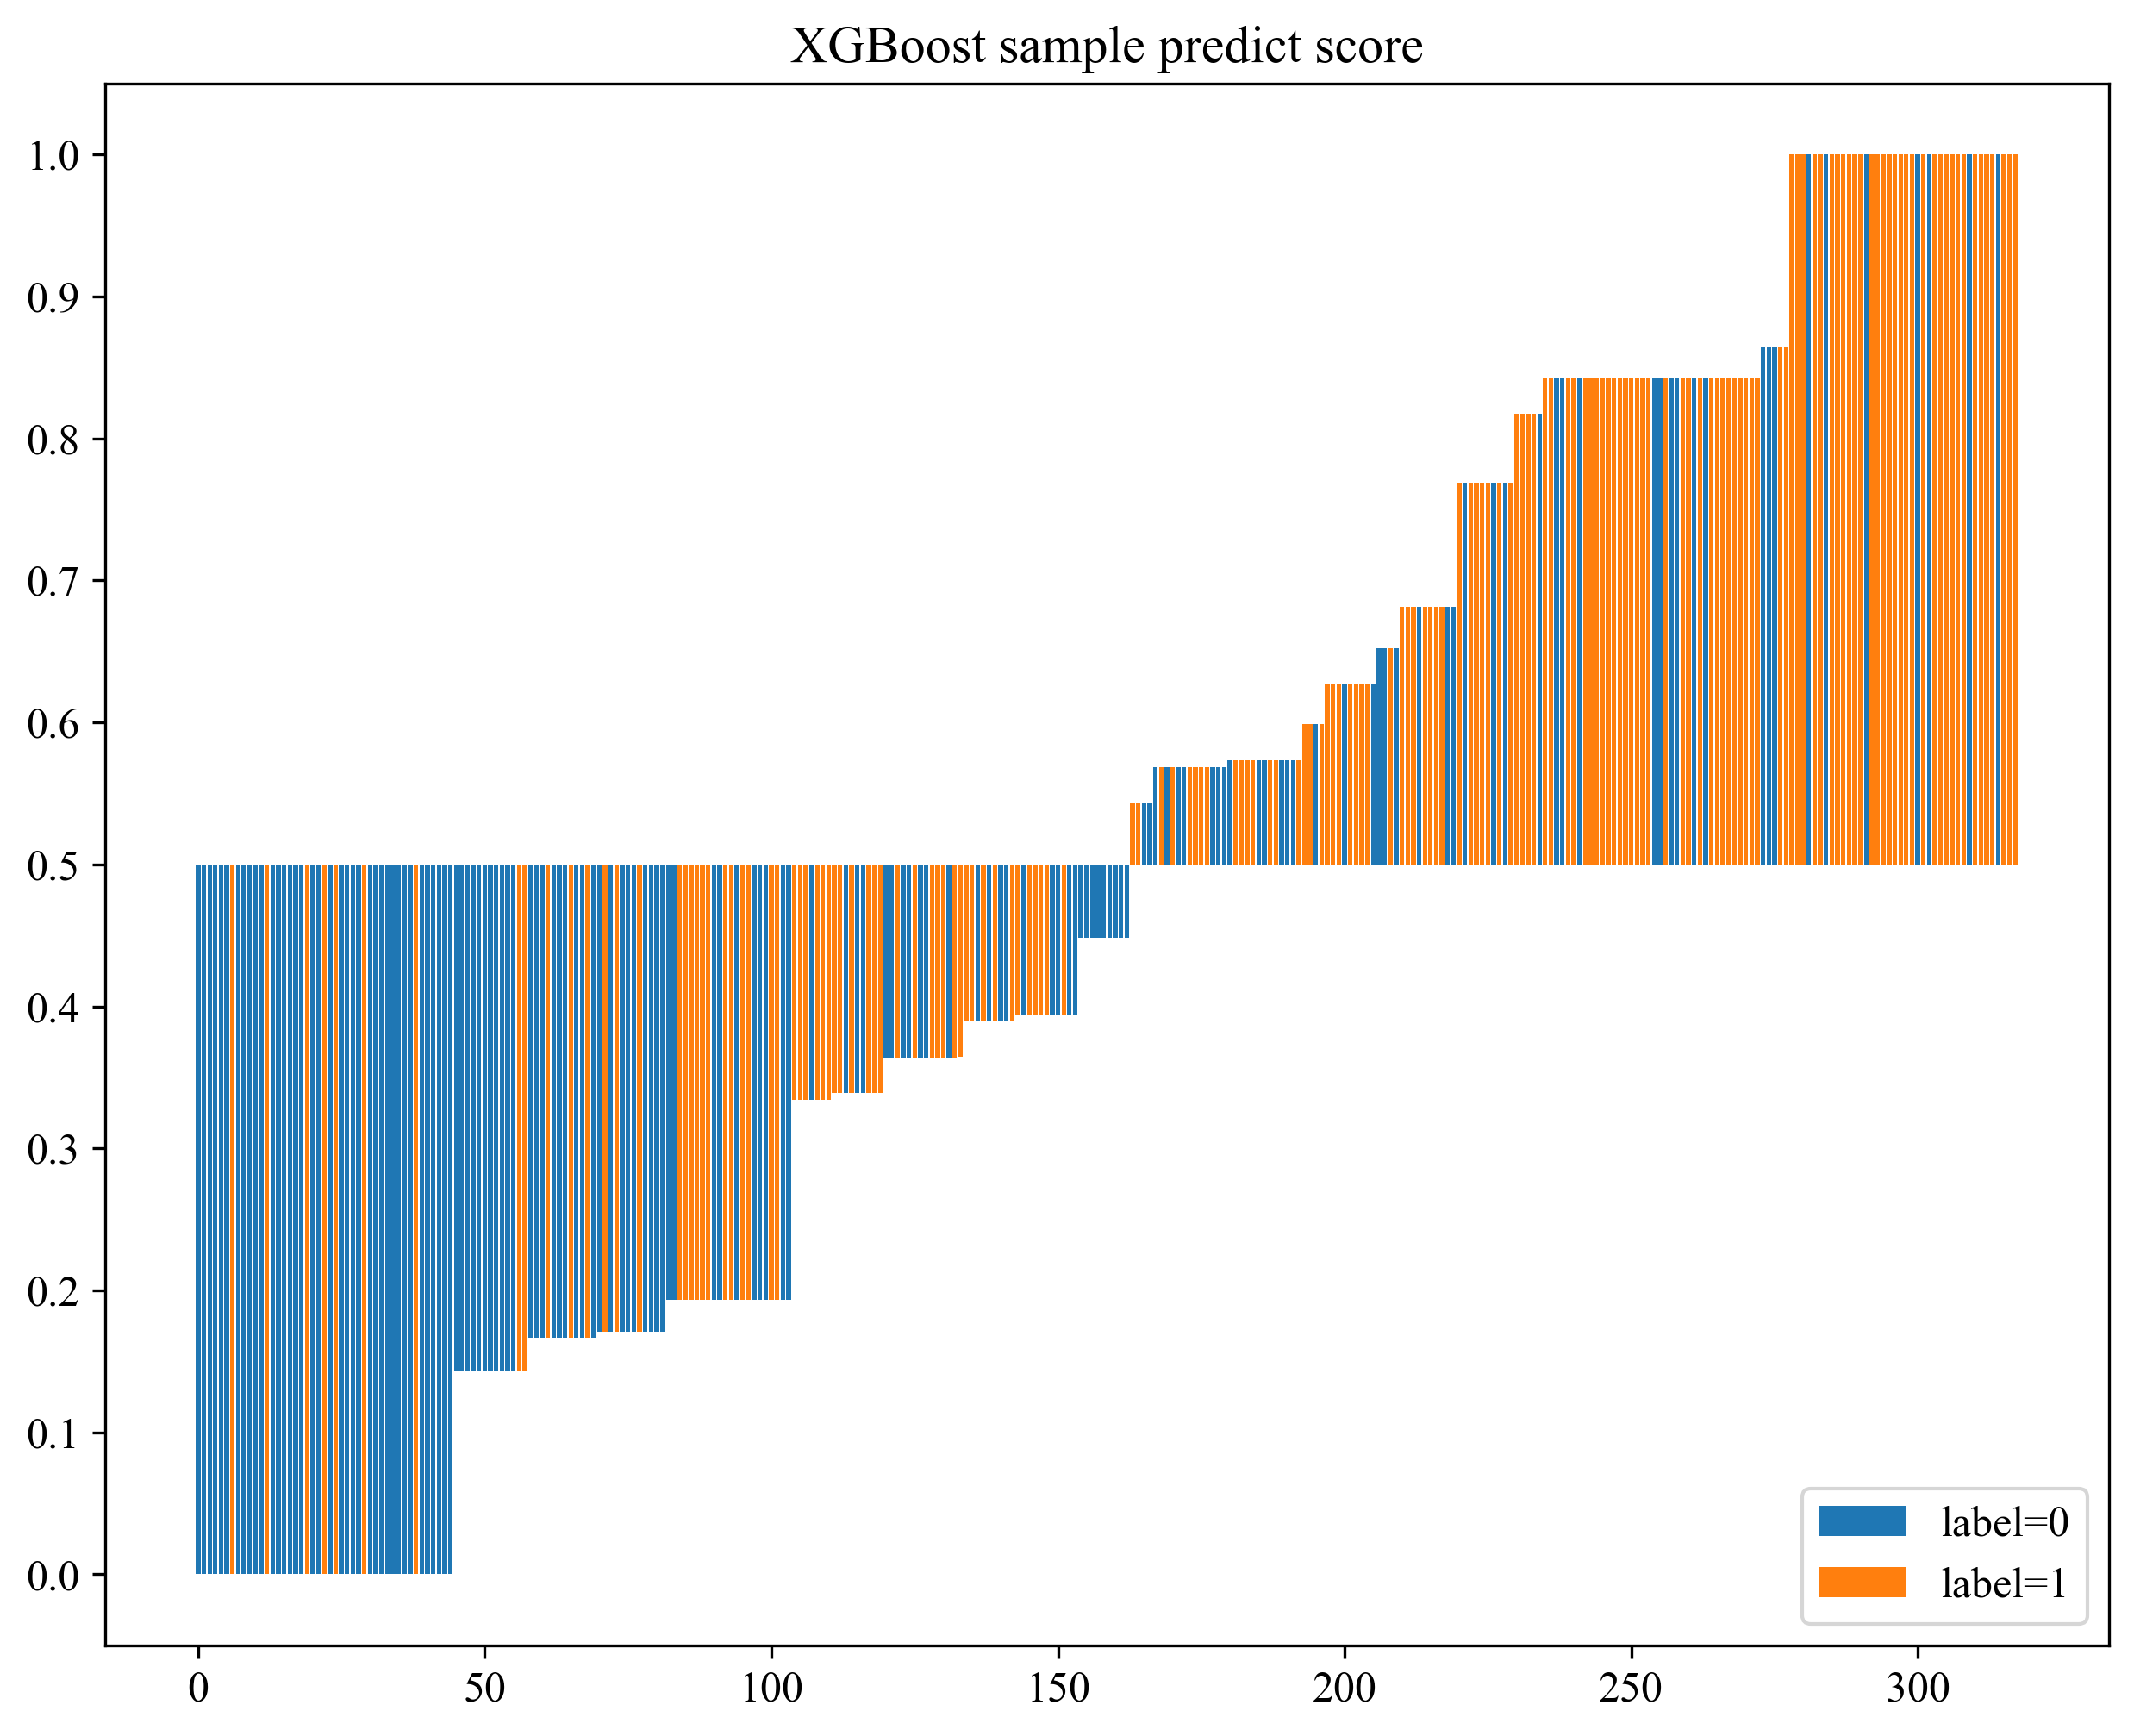

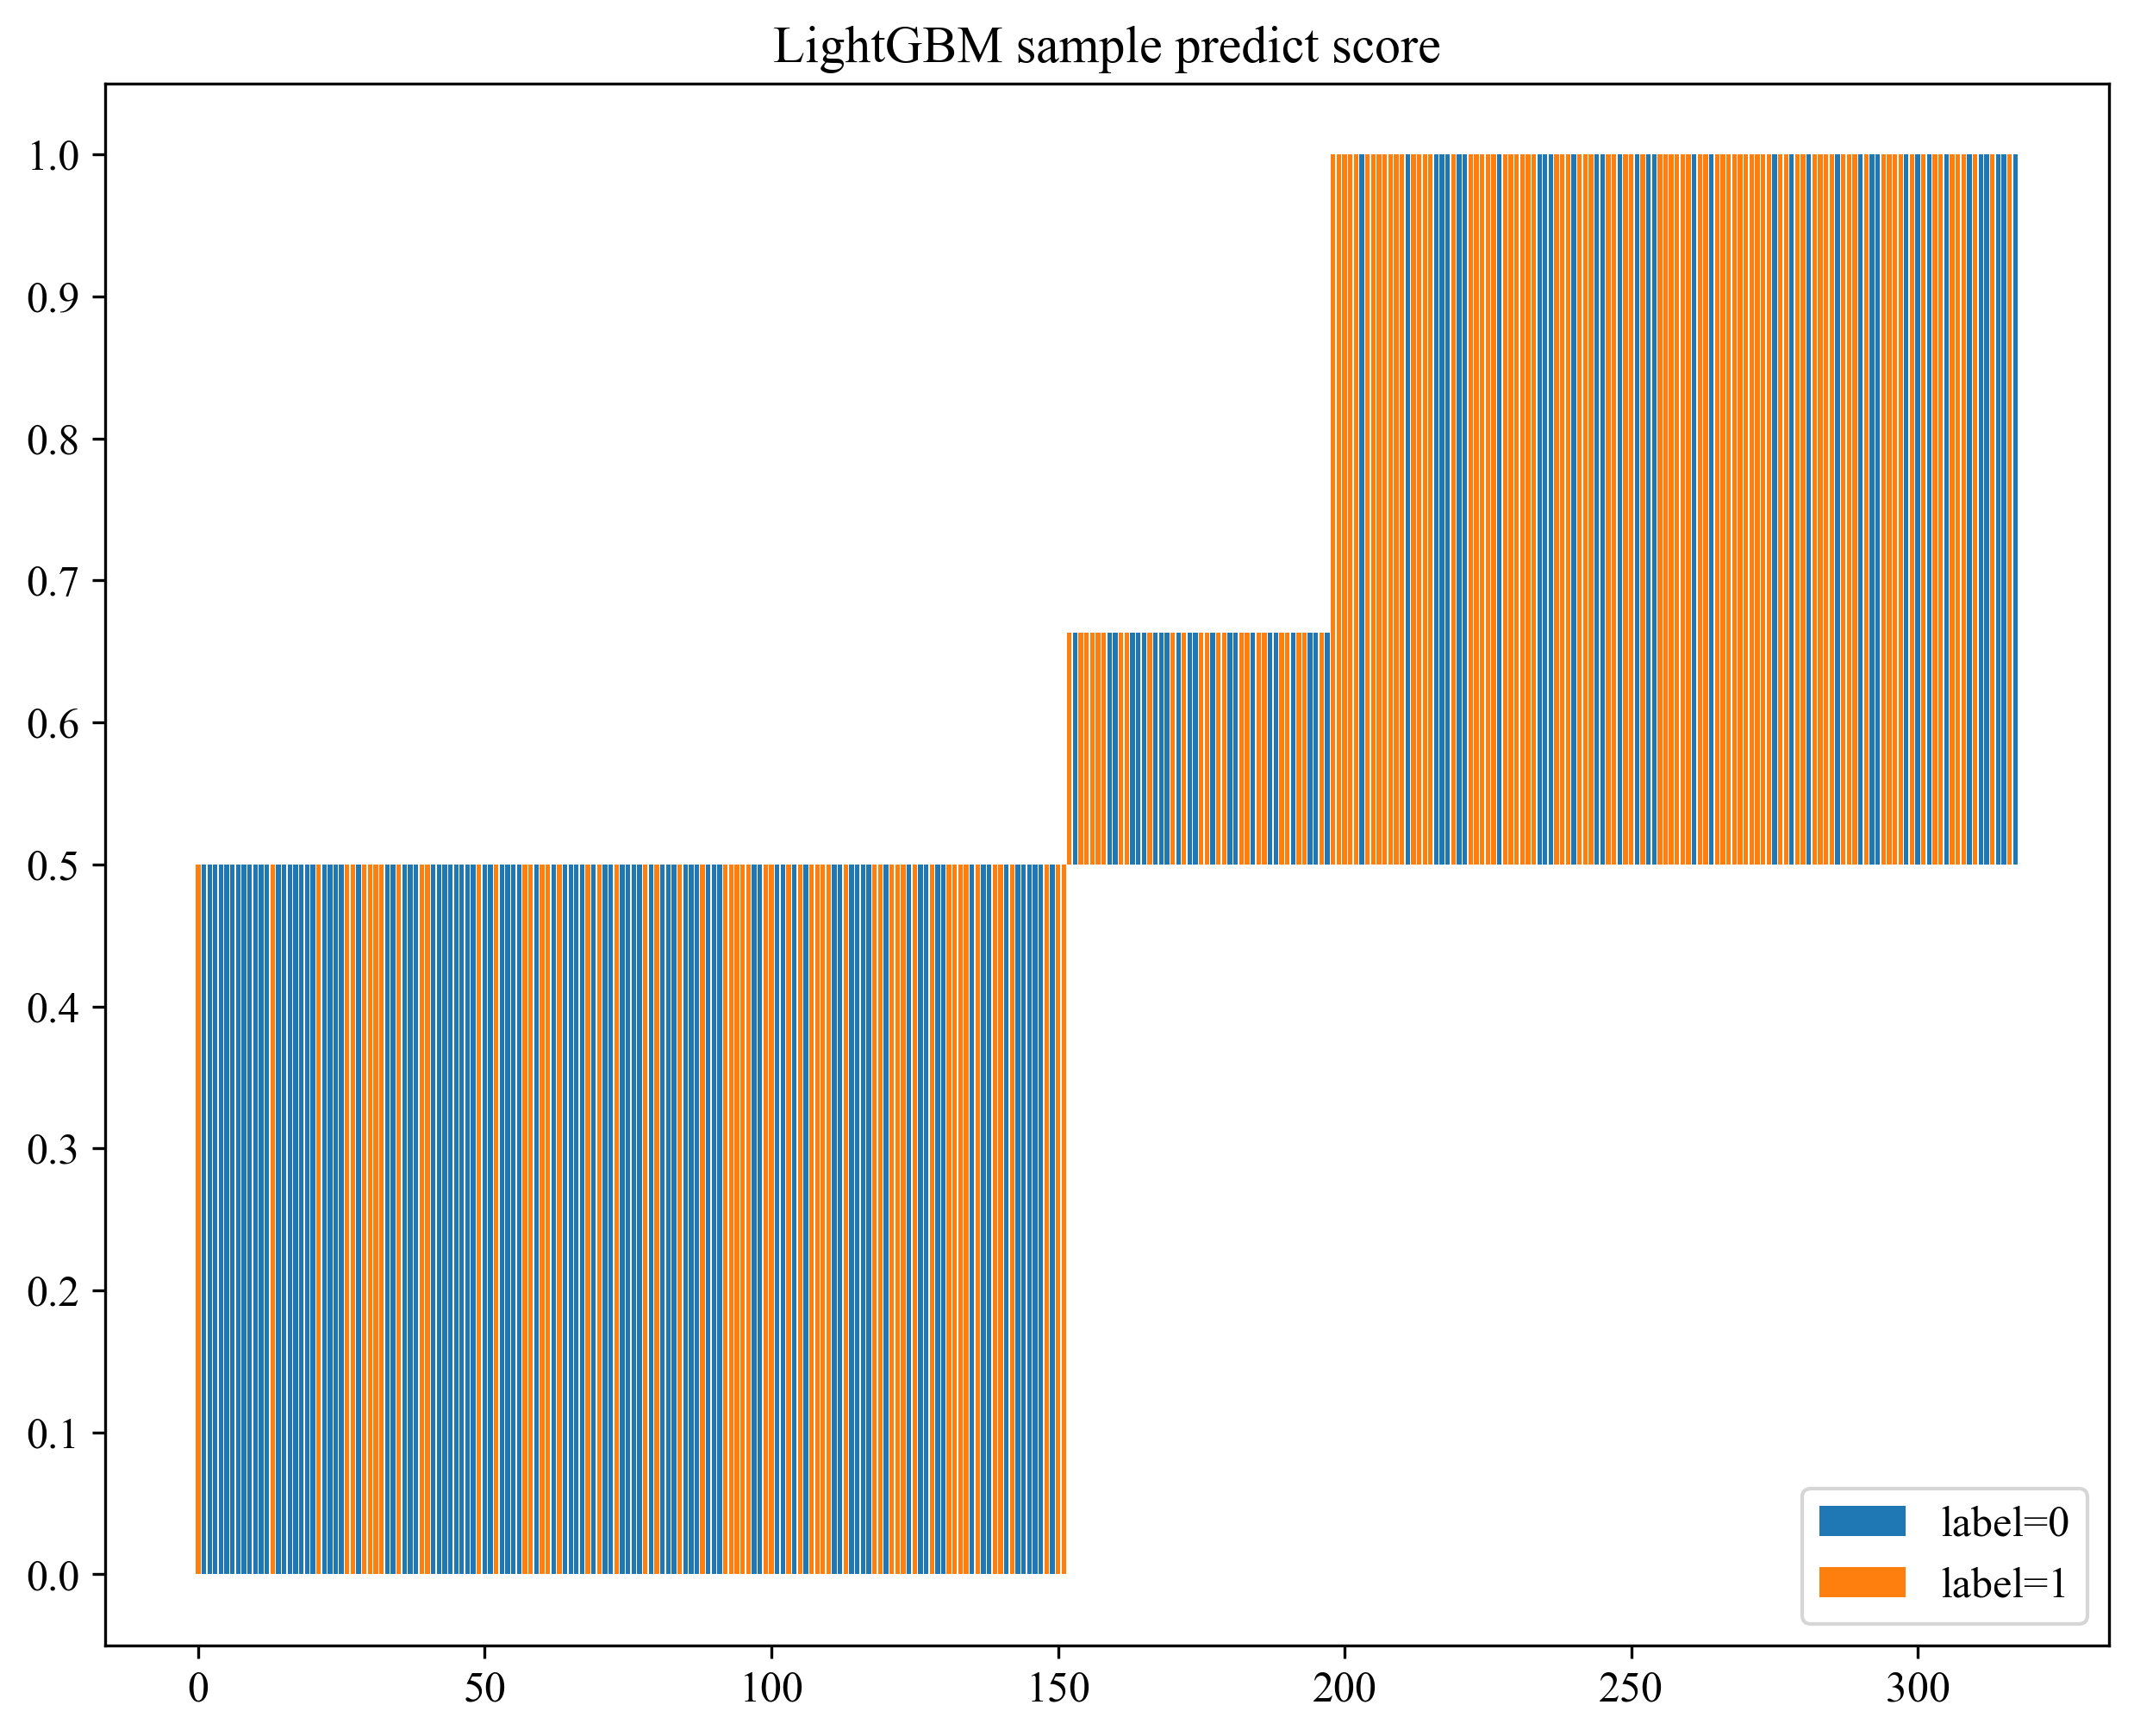

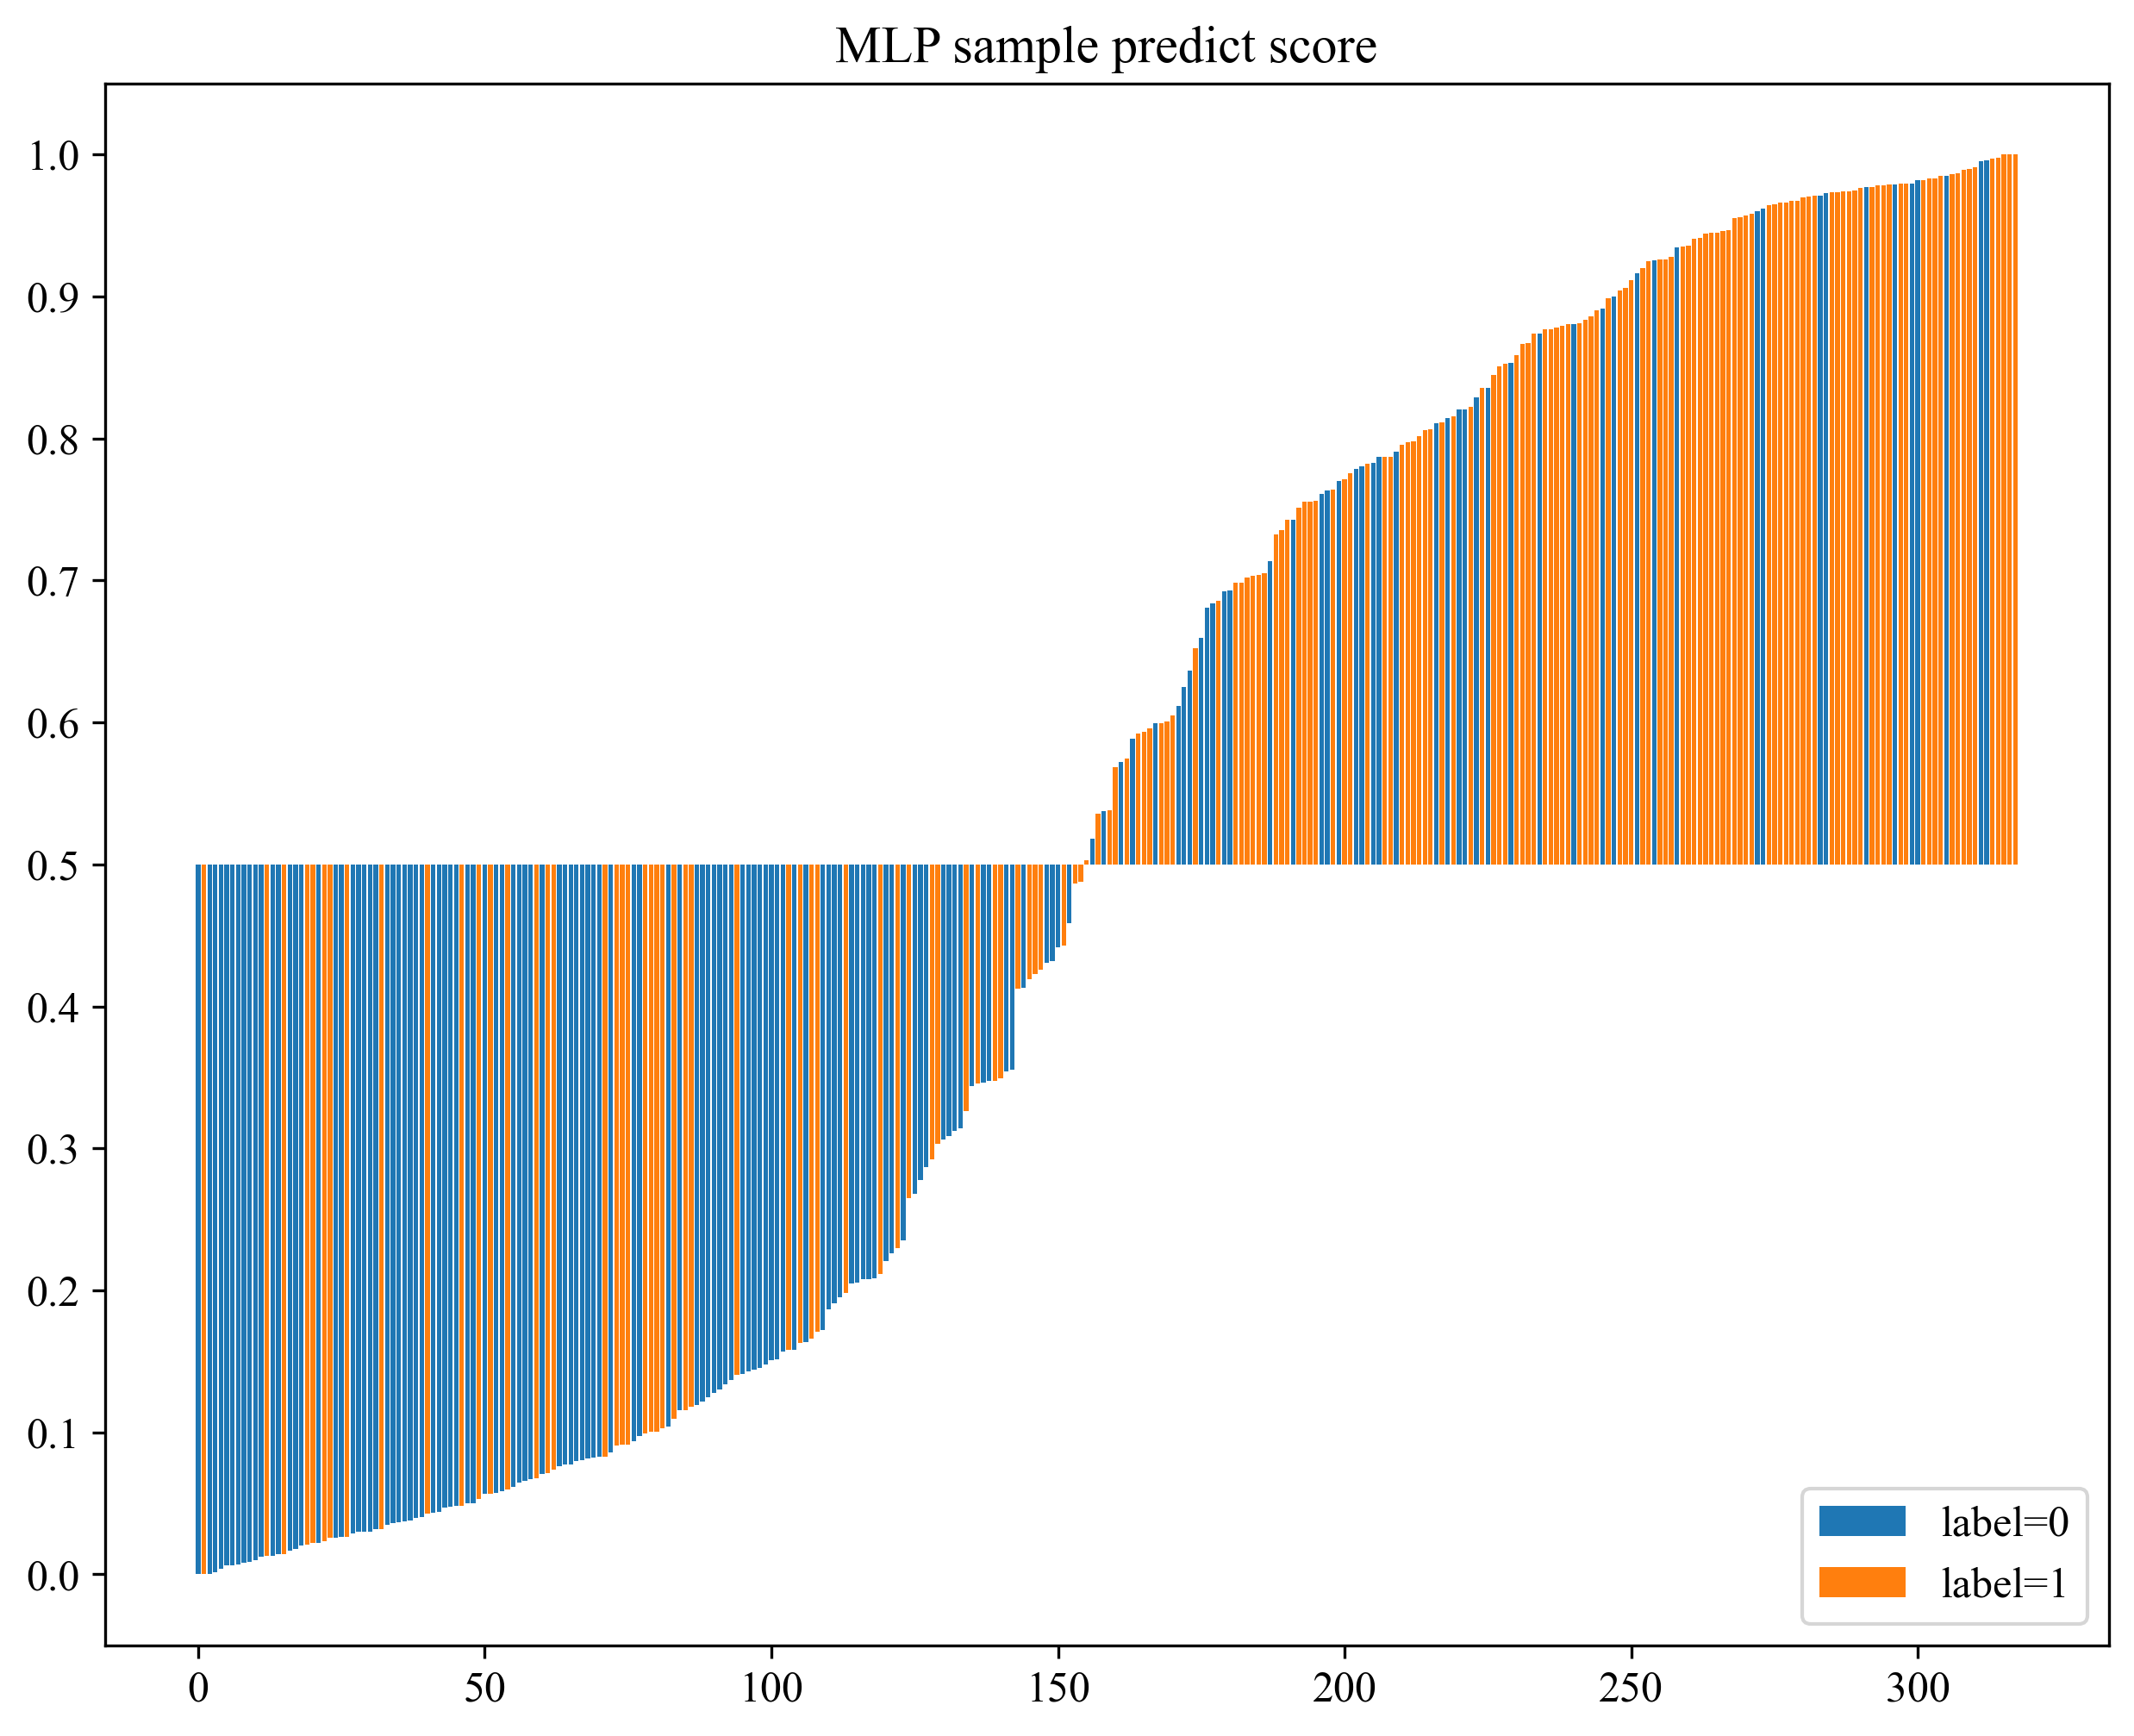

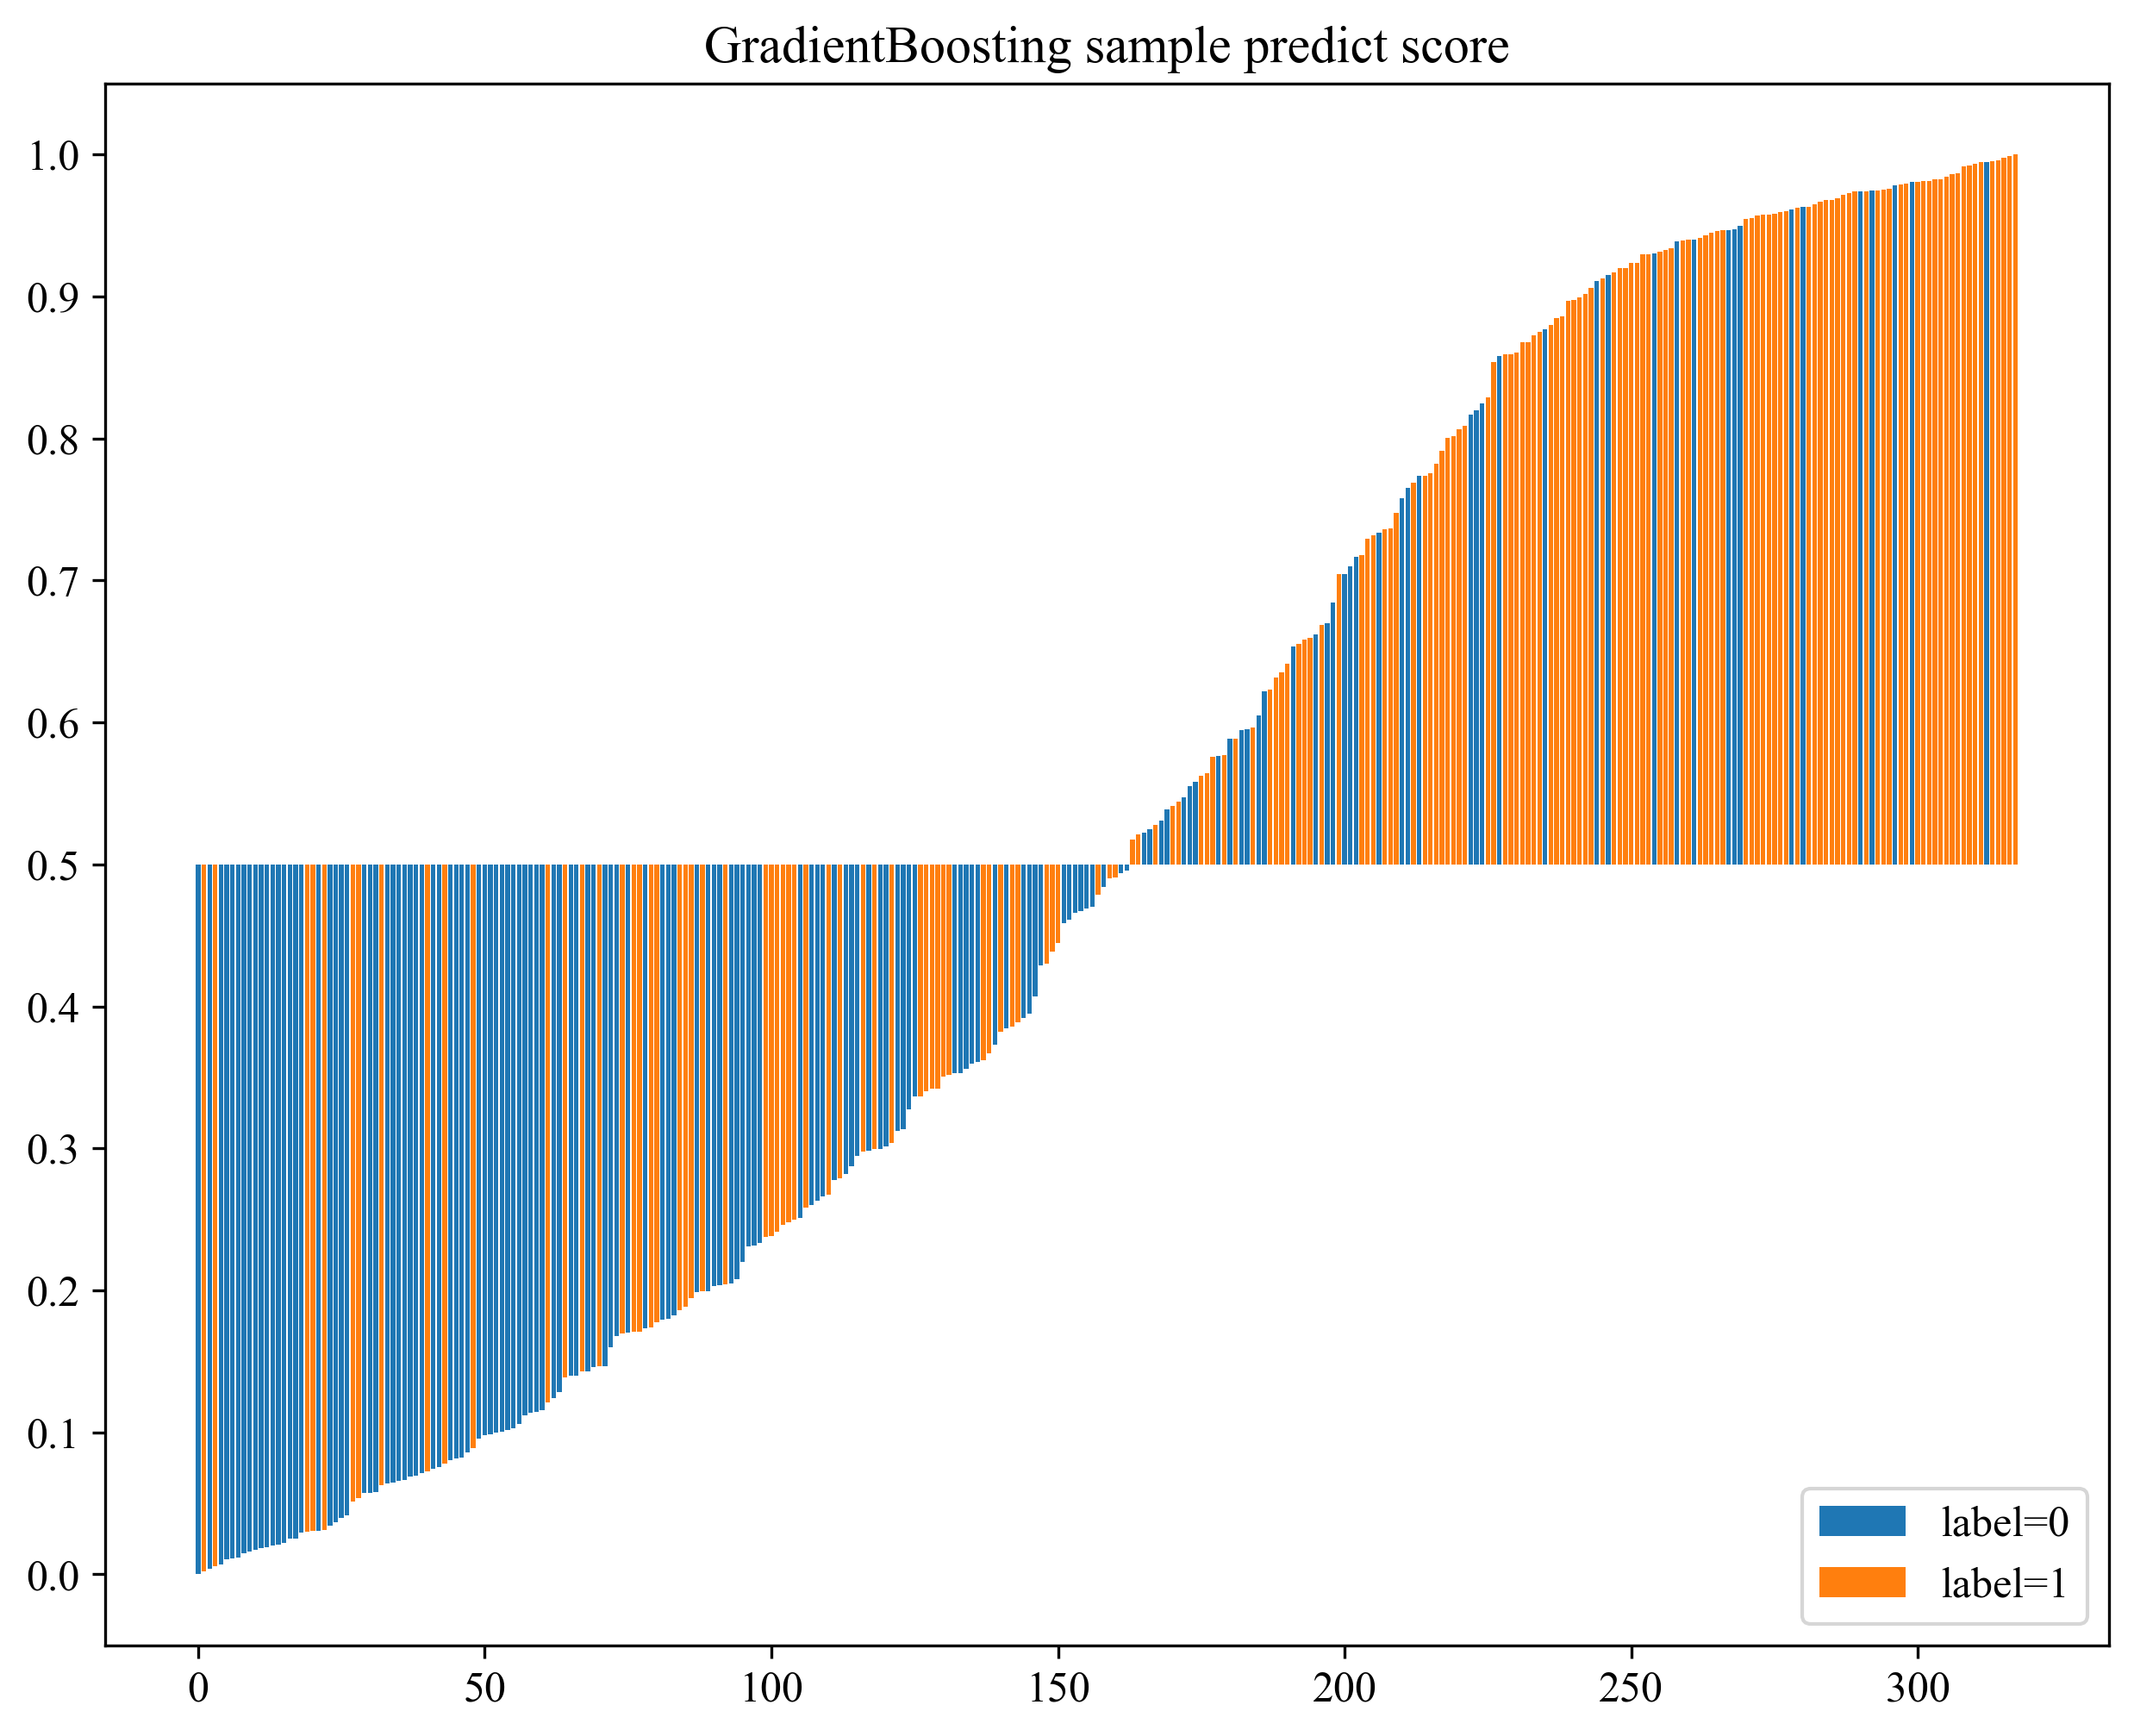

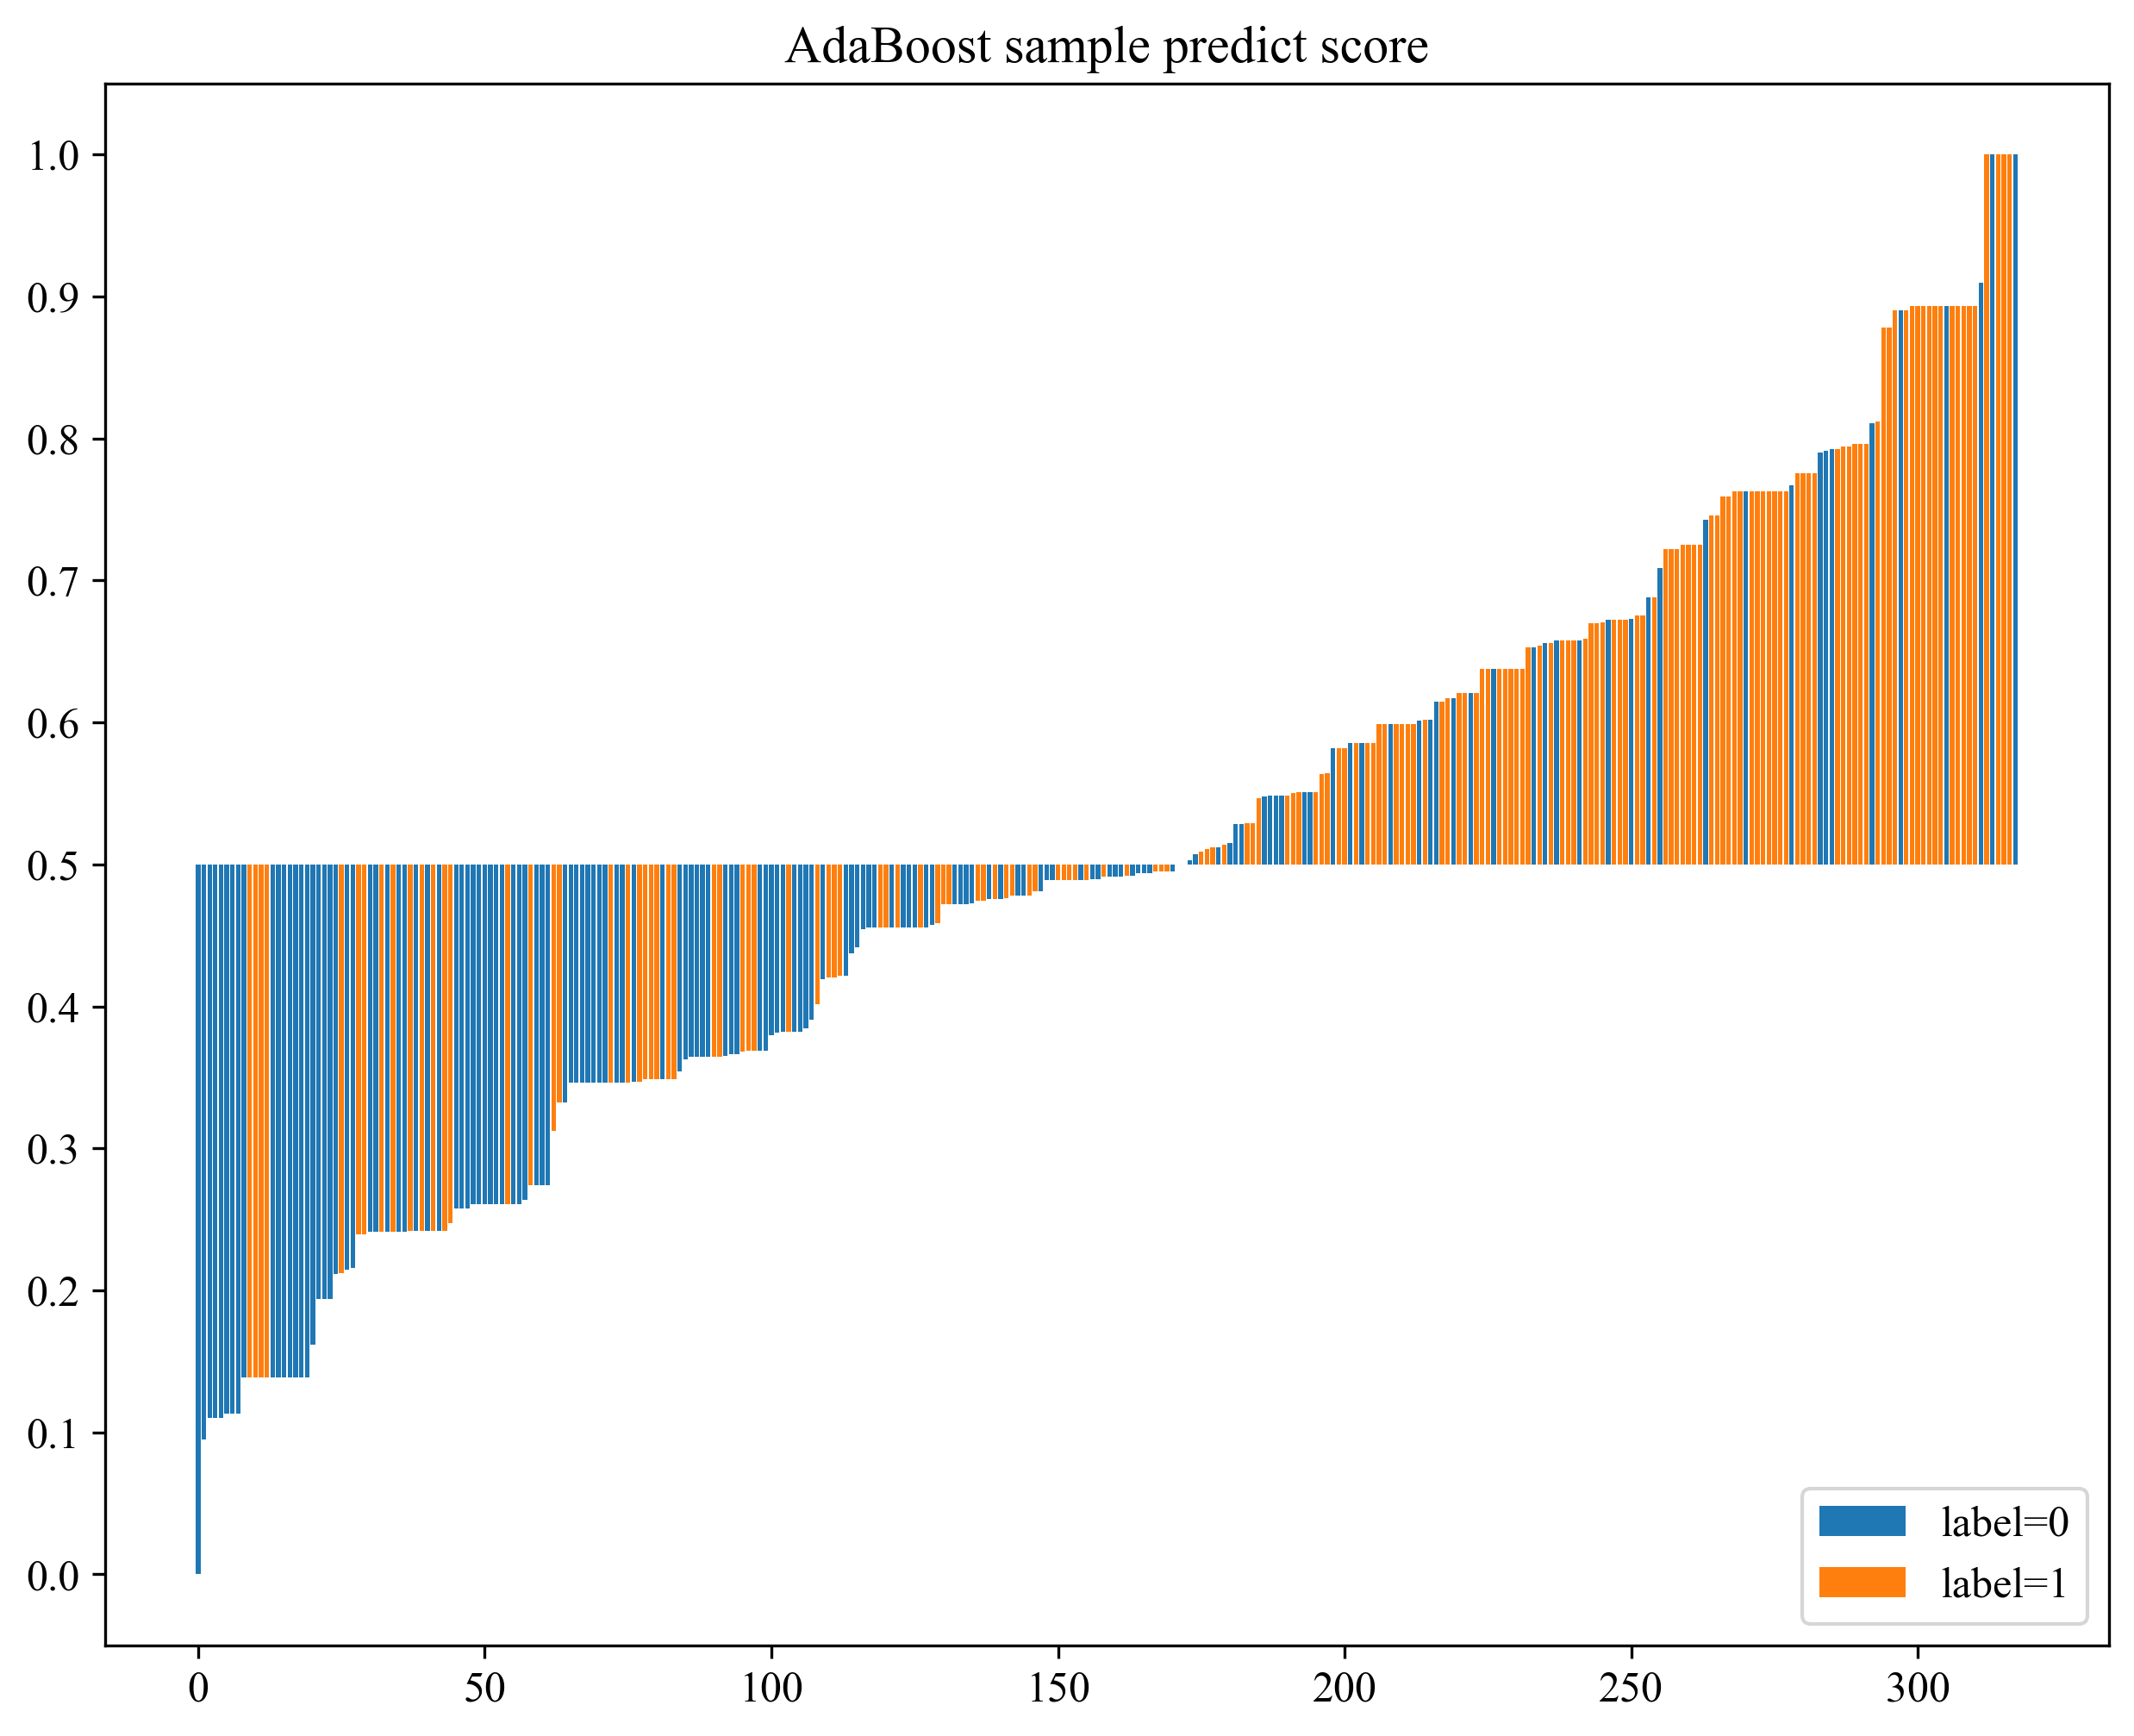

In [27]:
sel_model = model_names
c_matrix = {}

for sm in sel_model:
    if sm in model_names:
        sel_model_idx = model_names.index(sm)
        for idx, label in enumerate(labels):            
            okcomp.comp1.draw_predict_score(pred_scores[idx][sel_model_idx][-1], y_test_sel[label])
            plt.title(f'{sm} sample predict score')
            plt.legend(labels=["label=0","label=1"],loc="lower right") 
            plt.savefig(f'img/{task_type}_model_{sm}_sample_dis.svg', bbox_inches = 'tight')
            plt.show()

## 保存模型结果

可以把模型预测的标签结果以及每个类别的概率都保存下来。

In [28]:
import os
import numpy as np

os.makedirs('results', exist_ok=True)
sel_model = sel_model

for idx, label in enumerate(labels):
    for sm in sel_model:
        if sm in model_names:
            sel_model_idx = model_names.index(sm)
            target = targets[idx][sel_model_idx]
            # 预测训练集和测试集数据。
            train_indexes = np.reshape(np.array(train_ids), (-1, 1)).astype(str)
            test_indexes = np.reshape(np.array(test_ids), (-1, 1)).astype(str)
            y_train_pred_scores = target.predict_proba(X_train_sel)
            y_test_pred_scores = target.predict_proba(X_test_sel)
            columns = ['ID'] + [f"{label}-{i}"for i in range(y_test_pred_scores.shape[1])]
            # 保存预测的训练集和测试集结果
            result_train = pd.DataFrame(np.concatenate([train_indexes, y_train_pred_scores], axis=1), columns=columns)
            result_train.to_csv(f'results/{task_type}_{sm}_train.csv', index=False)
            result_test = pd.DataFrame(np.concatenate([test_indexes, y_test_pred_scores], axis=1), columns=columns)
            result_test.to_csv(f'results/{task_type}_{sm}_test.csv', index=False)